# Objective

Our aim was to try to analyze the prices of these ride-sharing apps and try to figure out what factors are driving the demand.

## Dataset description

Real-time data is collected using Uber&Lyft api queries and corresponding weather conditions, in few hot locations in Boston.
Data collected cab ride estimates every 5 mins and weather data every 1 hr.                 
Data collected from end week of November to December 2018.          
The Cab ride data covers various types of cabs for Uber & Lyft and their price for the given location. Weather data contains weather attributes like temperature, rain, cloud, etc for all the locations taken into consideration.

In [1760]:
# let's import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%config Inlinebackground.figureFormat='retina'
sns.set(font_scale=1.5)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [1761]:
# let's load the datasets
# cab data
cab_data = pd.read_csv(r'cab_rides.txt', encoding='utf-16')
# weather data
weather_data = pd.read_csv(r'weather.txt', encoding='utf-16')

In [1762]:
cab_data.head(3)

distance cab_type     time_stamp    destination            source  price  \
0      0.44     Lyft  1544952607890  North Station  Haymarket Square    5.0   
1      0.44     Lyft  1544952607890  North Station  Haymarket Square   11.0   
2      0.44     Lyft  1544952607890  North Station  Haymarket Square    7.0   

   surge_multiplier                                    id    product_id  \
0               1.0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7     lyft_line   
1               1.0  4bd23055-6827-41c6-b23b-3c491f24e74d  lyft_premier   
2               1.0  981a3613-77af-4620-a42a-0c0866077d1e          lyft   

     name  
0  Shared  
1     Lux  
2    Lyft

In [1763]:
weather_data.head(3)

temp           location  clouds  pressure    rain  time_stamp  humidity  \
0  42.42           Back Bay     1.0   1012.14  0.1228  1545003901      0.77   
1  42.43        Beacon Hill     1.0   1012.15  0.1846  1545003901      0.76   
2  42.50  Boston University     1.0   1012.15  0.1089  1545003901      0.76   

    wind  
0  11.25  
1  11.32  
2  11.07

In [1764]:
cab_data.info() # basic descr.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
distance            693071 non-null float64
cab_type            693071 non-null object
time_stamp          693071 non-null int64
destination         693071 non-null object
source              693071 non-null object
price               637976 non-null float64
surge_multiplier    693071 non-null float64
id                  693071 non-null object
product_id          693071 non-null object
name                693071 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


## Atrribute information

**Dependent variables**:       

    Distance - distance between source and destination             
    Cab_type - Uber or Lyft                 
    Time_stamp - epoch time when data was queried              
    Destination - destination of the ride              
    Source - the starting point of the ride              
    Surge_multiplier - the multiplier by which price was increased, default 1              
    Id - unique identifier              
    Product_id - uber/lyft identifier for cab-type              
    Name - Visible type of the cab eg: Uber Pool, UberXL              

**Target variable**:               

    Price - price estimate for the ride in USD

### Data Type      
**Object**

    - Cab type
    - Destination
    - Source
    - Id
    - Product Id
    - Name
    
**Numeric**       
    - Distance
    - Time stamp
    - Price
    - Surge Multiplier

### Feature category        
**Categorical**       
    - Cab type
    - Destination
    - Source
    - Product Id
    - Name
    - Id
    - Surge Multiplier
    
**Continuous**     
    - Distance
    - Time stamp
    - Price

# Exploratory Data Analysis

In [1765]:
# let's impute the unix epoch time to standard date time format
cab_data['time_stamp'] = pd.to_datetime(cab_data['time_stamp'], unit='ms')
cab_data['date'] = cab_data['time_stamp'].dt.date  # extract date
cab_data['hour'] = cab_data['time_stamp'].dt.hour  # extract hour

cab_data.drop('time_stamp', axis=1, inplace=True)  # drop time_stamp feature

# before doing EDA, let's split the dataset into Uber and Lyft
uber = cab_data[cab_data['cab_type']=='Uber']
lyft = cab_data[cab_data['cab_type']=='Lyft']

cab_data.head(3)

distance cab_type    destination            source  price  \
0      0.44     Lyft  North Station  Haymarket Square    5.0   
1      0.44     Lyft  North Station  Haymarket Square   11.0   
2      0.44     Lyft  North Station  Haymarket Square    7.0   

   surge_multiplier                                    id    product_id  \
0               1.0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7     lyft_line   
1               1.0  4bd23055-6827-41c6-b23b-3c491f24e74d  lyft_premier   
2               1.0  981a3613-77af-4620-a42a-0c0866077d1e          lyft   

     name        date  hour  
0  Shared  2018-12-16     9  
1     Lux  2018-12-16     9  
2    Lyft  2018-12-16     9

## Univariate analysis

### Continuous variables

**Distance**

In [1766]:
overall = cab_data['distance'].describe() # measure of central tendency
overall

count    693071.000000
mean          2.189430
std           1.138937
min           0.020000
25%           1.280000
50%           2.160000
75%           2.920000
max           7.860000
Name: distance, dtype: float64

In [1767]:
lyft_distance = lyft['distance'].describe()
uber_distance = uber['distance'].describe()

In [1768]:
df = pd.DataFrame({'Overall': overall.values,
                  'Lyft': lyft_distance.values,
                  'Uber': uber_distance.values}, index= ['Count', 'Mean', 'Std. Dev.', 'Min', '25%', '50%', '75%', 'Max'])
df

Overall           Lyft           Uber
Count      693071.000000  307408.000000  385663.000000
Mean            2.189430       2.186976       2.191386
Std. Dev.       1.138937       1.086622       1.178973
Min             0.020000       0.390000       0.020000
25%             1.280000       1.270000       1.300000
50%             2.160000       2.140000       2.170000
75%             2.920000       2.970000       2.840000
Max             7.860000       6.330000       7.860000

In [1769]:
# df.to_csv(r'C:\Users\gokul\Downloads\distance_metrics.csv')

In [1770]:
def calculate_mop(**kwargs):
    """ function to calculate and display the measures of dispersion."""
    for name, df in kwargs.items():
        print(name, '\n')
        print(f'Standard deviation:     {df.std()}')
        print(f'Skewness:               {df.skew()}')
        print(f'Kurtosis:               {df.kurtosis()}\n')

In [1771]:
calculate_mop(Lyft= lyft['distance'], Uber= uber['distance'])

Lyft 

Standard deviation:     1.0866216748358941
Skewness:               0.5402067692111785
Kurtosis:               -0.1383254913189118

Uber 

Standard deviation:     1.178973248775562
Skewness:               1.013982000306202
Kurtosis:               1.9675348045682979



(0, 0.6)

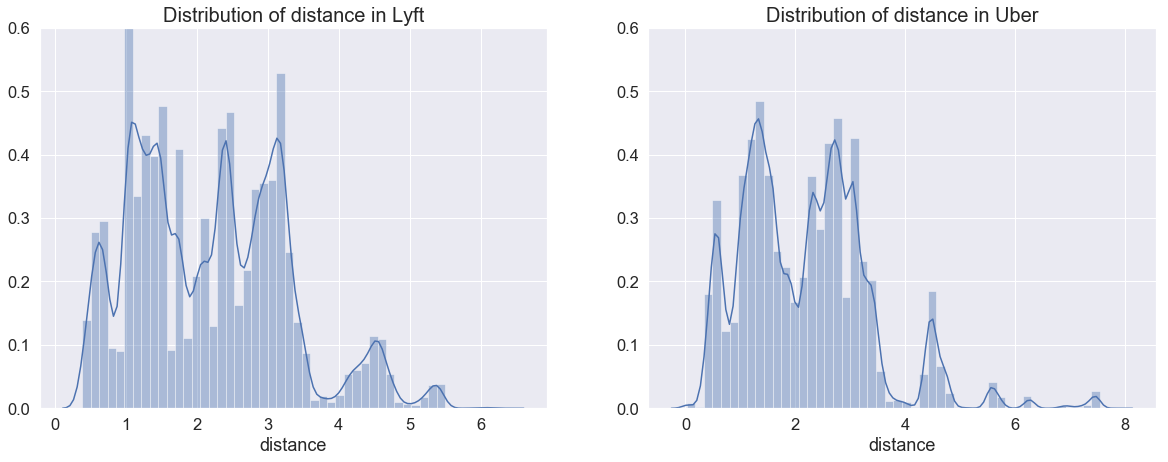

In [1772]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.distplot(lyft['distance'], ax=ax1, kde=True)
ax1.set_title('Distribution of distance in Lyft', fontsize=20)
ax1.set_ylim(0, 0.6)
a = sns.distplot(uber['distance'], ax=ax2)
ax2.set_title('Distribution of distance in Uber', fontsize=20)
ax2.set_ylim(0, 0.6)

In [1773]:
# a.figure.savefig(r'C:\Users\gokul\Downloads\distance.jpg')

Text(0.5, 1.0, 'Uber')

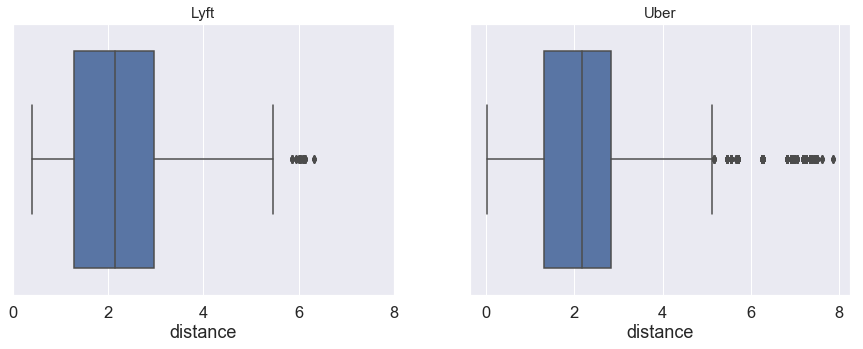

In [1774]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(lyft['distance'], ax=ax1)
ax1.set_title('Lyft', fontsize=15)
ax1.set_xlim(0, 8)
sns.boxplot(uber['distance'], ax=ax2)
ax2.set_title('Uber', fontsize=15)

In [1775]:
# lyft[lyft['distance']<0.3] # can we remove records below 0.3 as cancellation records

In [1776]:
# uber[uber['distance']<0.25].sort_values(by='distance', ascending=False).head(30)

From the above graphs, we can see that most of the rides are in the range of approximately 0.5 to 5.5 miles. 
The distribution is slightly right skewed in the both Lyft and Uber.
Distance in Lyft is more dispersed than Uber.           
Both the data contains outliers, due to certain weather conditions riders have to travel extra distance than usual,
and occassionally riders tend to travel long distances.

**Price (Target variable)**

In [1777]:
overall = cab_data['price'].describe()
overall # measure of central tendency

count    637976.000000
mean         16.545125
std           9.324359
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64

In [1778]:
uber_price = uber['price'].describe()
uber_price

count    330568.000000
mean         15.795343
std           8.560300
min           4.500000
25%           9.000000
50%          12.500000
75%          21.500000
max          89.500000
Name: price, dtype: float64

In [1779]:
lyft[lyft.price<2.9].shape

(211, 11)

In [1780]:
lyft_price = lyft['price'].describe()
lyft_price

count    307408.000000
mean         17.351396
std          10.019171
min           2.500000
25%           9.000000
50%          16.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64

In [1781]:
uber.price.sum(), lyft.price.sum()

(5221435.0, 5333957.979999999)

In [1782]:
df = pd.DataFrame({'Overall': overall.values,
                  'Lyft': lyft_price.values,
                  'Uber': uber_price.values}, index= ['Count', 'Mean', 'Std. Dev.', 'Min', '25%', '50%', '75%', 'Max'])
df

Overall           Lyft           Uber
Count      637976.000000  307408.000000  330568.000000
Mean           16.545125      17.351396      15.795343
Std. Dev.       9.324359      10.019171       8.560300
Min             2.500000       2.500000       4.500000
25%             9.000000       9.000000       9.000000
50%            13.500000      16.500000      12.500000
75%            22.500000      22.500000      21.500000
Max            97.500000      97.500000      89.500000

In [1783]:
# df.to_csv(r'C:\Users\gokul\Downloads\metrics.csv')

In [1784]:
calculate_mop(Lyft= lyft['price'], Uber= uber['price']) # measure of dispersion

Lyft 

Standard deviation:     10.019170761821647
Skewness:               0.9779622794919607
Kurtosis:               1.4373703138968161

Uber 

Standard deviation:     8.560299982017439
Skewness:               1.0528694623412944
Kurtosis:               0.44005424456108555



Text(0.5, 1.0, 'Distribution of price in Uber')

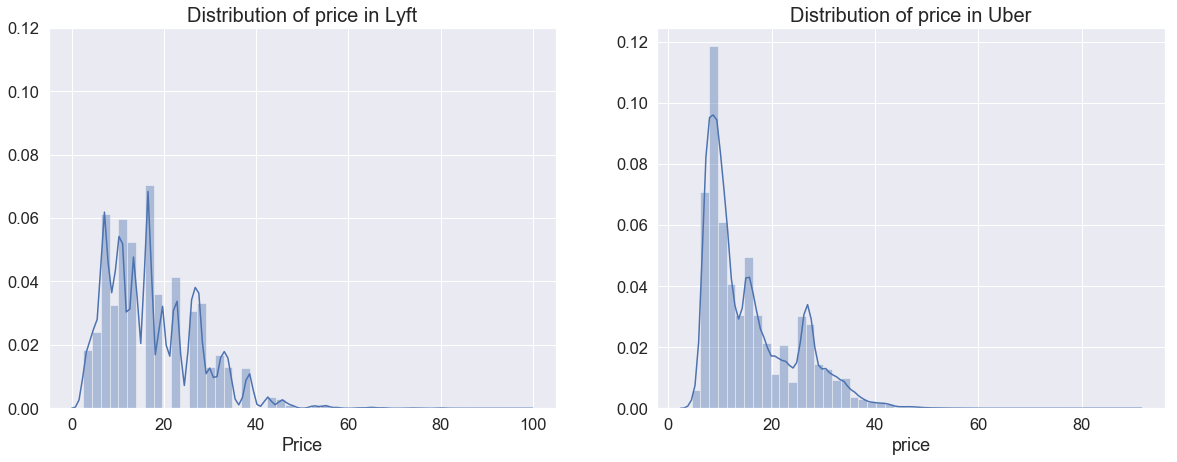

In [1785]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
a = sns.distplot(lyft['price'], ax=ax1)
ax1.set_title('Distribution of price in Lyft', fontsize=20)
ax1.set(xlabel='Price')
ax1.set_ylim(0, 0.12)
b =sns.distplot(uber[~uber['price'].isnull()]['price'], ax=ax2)
ax2.set_title('Distribution of price in Uber', fontsize=20)

In [1786]:
# a.figure.savefig(r'C:\Users\gokul\Downloads\price.jpg')

(0, 100)

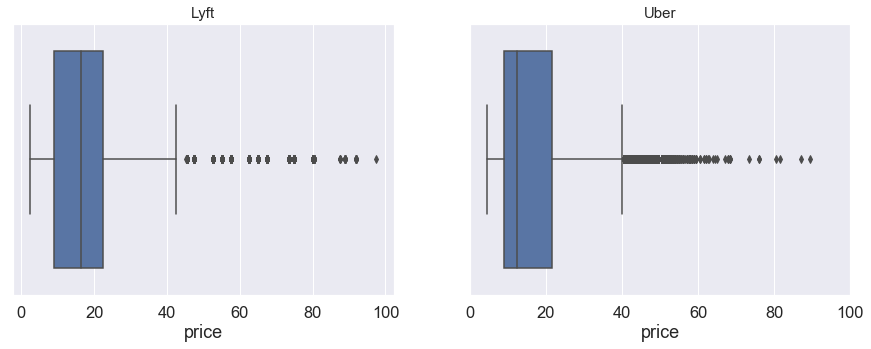

In [1787]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(lyft['price'], ax=ax1)
ax1.set_title('Lyft', fontsize=15)

sns.boxplot(uber[~uber['price'].isnull()]['price'], ax=ax2)
ax2.set_title('Uber', fontsize=15)
ax2.set_xlim(0, 100)

**Outliers**       
These outliers are due to use of high-end cars and high surge multipliers. So, we decided to keep it.

In [1788]:
lyft[(lyft['price']>40)].head(3)

distance cab_type       destination              source  price  \
469      2.93     Lyft  Theatre District   Boston University   42.5   
639      3.80     Lyft            Fenway  Financial District   42.5   
705      3.25     Lyft          Back Bay       South Station   42.5   

     surge_multiplier                                    id   product_id  \
469              1.25  fa6e092f-5562-49ef-916c-92d8148111ee  lyft_luxsuv   
639              1.00  4c1f503c-2411-4c59-b416-c9831f3da44b  lyft_luxsuv   
705              2.50  46c02b41-6f51-43ab-a389-21d704cac2db    lyft_plus   

             name        date  hour  
469  Lux Black XL  2018-12-02    21  
639  Lux Black XL  2018-11-27    12  
705       Lyft XL  2018-12-02     7

In [1789]:
uber[(uber['price']>40)].head(3)

distance cab_type         destination              source  price  \
595       4.42     Uber  Financial District              Fenway   41.0   
1981      5.56     Uber   Boston University  Financial District   40.5   
2104      4.48     Uber              Fenway  Financial District   42.0   

      surge_multiplier                                    id  \
595                1.0  64938ba3-cd07-4080-9ee9-ea78f1df0f11   
1981               1.0  dcf399d5-d80e-49c4-8675-c3da0b828729   
2104               1.0  d0e9ef6f-a268-411b-a41c-c7eb2fea3210   

                                product_id       name        date  hour  
595   6d318bcc-22a3-4af6-bddd-b409bfce1546  Black SUV  2018-12-16    17  
1981  6d318bcc-22a3-4af6-bddd-b409bfce1546  Black SUV  2018-12-03    16  
2104  6d318bcc-22a3-4af6-bddd-b409bfce1546  Black SUV  2018-11-27     5

In [1790]:
# a = uber[uber['price']<40].groupby(by=['source', 'destination']).median()#.head(10)
# a

In [1791]:
# a.to_csv(r'C:\Users\gokul\Downloads\tab.csv')

In [1792]:
uber[uber['price']>40].groupby(by=['source', 'destination']).mean().head(10)

distance      price  surge_multiplier  \
source      destination                                                      
Back Bay    Boston University        1.410000  43.250000               1.0   
            Fenway                   1.386667  44.166667               1.0   
            Haymarket Square         4.895556  46.888889               1.0   
            North End                6.117143  48.452381               1.0   
            Northeastern University  1.160000  44.500000               1.0   
            South Station            6.124224  44.118012               1.0   
Beacon Hill Boston University        2.270000  54.500000               1.0   
            Fenway                   2.290000  48.000000               1.0   
            North End                2.356667  45.666667               1.0   
            Northeastern University  2.407500  51.875000               1.0   

                                          hour  
source      destination                         
Back Bay    Boston University        23.000000  
            Fenway                   15.333333  
            Haymarket Square         11.222222  
            North End                17.523810  
            Northeastern University  11.500000  
            South Station            17.751553  
Beacon Hill Boston University         4.000000  
            Fenway                    0.000000  
            North End                 5.666667  
            Northeastern University   6.750000

**Outliers handling**      
We could see that, some rides higher price than usual for different car models. From our analysis, we came to know,
duration of the trip also has impact on the price, and we do not posses data regarding the
duration of the trip, so we cannot remove these outliers.

The price distribution is right skewed, from the boxplot we could see the outliers present in the data.         
On average, the price range varies from 5 to 40 US dollars,           
Presence of outliers is due to factors such as use of luxury or premium cars for rides, travelling in high traffic city 
and bad weather conditions.

**Categorical variables**

**Cab type**

In [1793]:
cab_data['cab_type'].value_counts() # frequency count

Uber    385663
Lyft    307408
Name: cab_type, dtype: int64

In [1794]:
cab_data['cab_type'].value_counts(normalize=True) # percentage of values

Uber    0.556455
Lyft    0.443545
Name: cab_type, dtype: float64

Text(0.5, 1.0, 'Frequency of Uber and Lyft data')

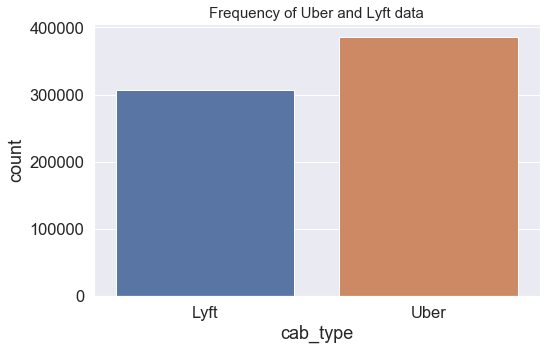

In [1795]:
plt.figure(figsize=(8,5))
sns.countplot('cab_type', data=cab_data)
plt.title('Frequency of Uber and Lyft data', fontsize=15)

The dataset contains relatively high proportion of Uber data, with both having records more than 300,000 data points.

**Car model**

In [1796]:
lyft['name'].value_counts() # frequency count

Lyft            51235
Lux Black       51235
Lux             51235
Lux Black XL    51235
Lyft XL         51235
Shared          51233
Name: name, dtype: int64

In [1797]:
uber['name'].value_counts()

WAV          55096
UberXL       55096
Black SUV    55096
Taxi         55095
Black        55095
UberX        55094
UberPool     55091
Name: name, dtype: int64

Text(0.5, 1.0, 'Frequency count of car models  in Uber')

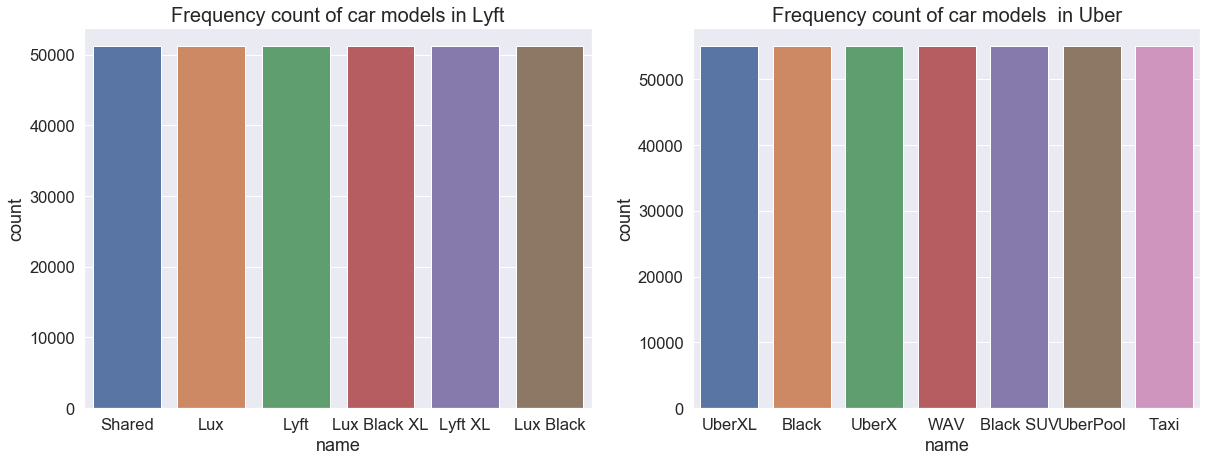

In [1798]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['name'], ax=ax1)
ax1.set_title('Frequency count of car models in Lyft', fontsize=20)
sns.countplot(uber['name'], ax=ax2)
ax2.set_title('Frequency count of car models  in Uber', fontsize=20)

From the frequency plot, we could almost all the car models are used in similar frequency.

**Source**

In [1799]:
lyft['source'].value_counts() # frequency count

Financial District         26237
Back Bay                   25655
South Station              25620
Fenway                     25620
North End                  25620
Boston University          25620
Northeastern University    25614
Haymarket Square           25614
Theatre District           25530
West End                   25488
Beacon Hill                25464
North Station              25326
Name: source, dtype: int64

In [1800]:
uber['source'].value_counts()

Financial District         32620
Theatre District           32283
Boston University          32144
North End                  32143
Northeastern University    32142
Fenway                     32137
Back Bay                   32137
South Station              32130
Haymarket Square           32122
West End                   32074
Beacon Hill                31939
North Station              31792
Name: source, dtype: int64

[Text(0, 0, 'North End'),
 Text(0, 0, 'Beacon Hill'),
 Text(0, 0, 'North Station'),
 Text(0, 0, 'Boston University'),
 Text(0, 0, 'South Station'),
 Text(0, 0, 'Fenway'),
 Text(0, 0, 'Theatre District'),
 Text(0, 0, 'West End'),
 Text(0, 0, 'Back Bay'),
 Text(0, 0, 'Northeastern University'),
 Text(0, 0, 'Haymarket Square'),
 Text(0, 0, 'Financial District')]

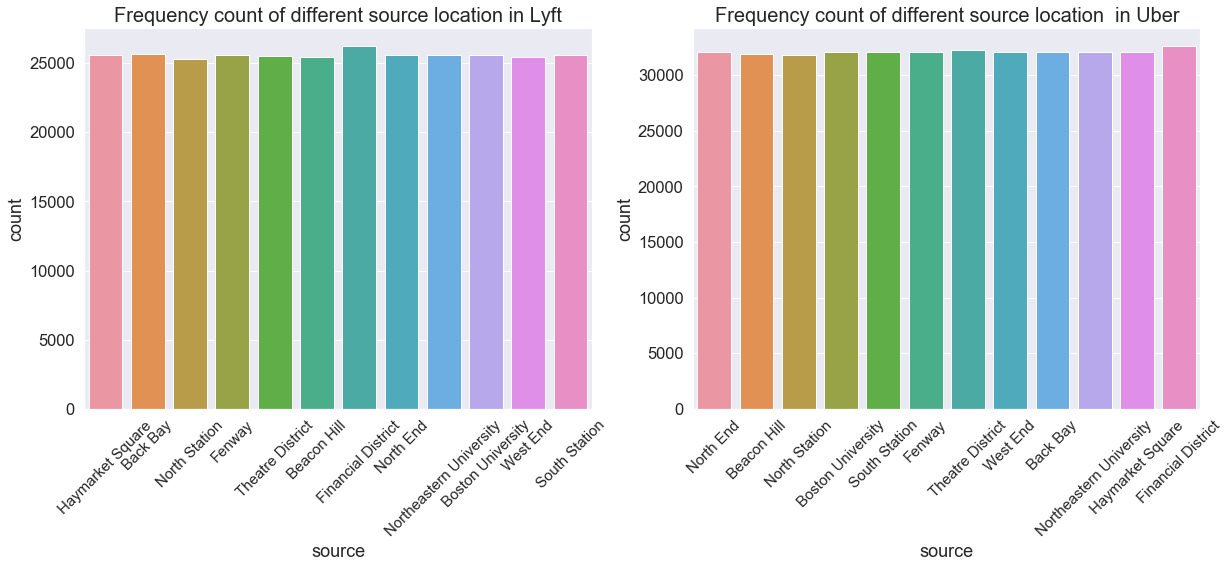

In [1801]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['source'], ax=ax1)
ax1.set_title('Frequency count of different source location in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=15)
# ax1.set_ylim(0, 25000)
sns.countplot(uber['source'], ax=ax2)
ax2.set_title('Frequency count of different source location  in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=15)

**Destination**

In [1802]:
lyft['destination'].value_counts()

Financial District         26238
Back Bay                   25650
South Station              25620
Fenway                     25620
Northeastern University    25619
North End                  25614
Boston University          25614
Haymarket Square           25613
Theatre District           25536
West End                   25494
Beacon Hill                25464
North Station              25326
Name: destination, dtype: int64

In [1803]:
uber['destination'].value_counts()

Financial District         32613
Theatre District           32262
Haymarket Square           32151
Boston University          32150
North End                  32142
Fenway                     32137
Northeastern University    32136
Back Bay                   32130
South Station              32129
West End                   32081
Beacon Hill                31939
North Station              31793
Name: destination, dtype: int64

[Text(0, 0, 'West End'),
 Text(0, 0, 'South Station'),
 Text(0, 0, 'Fenway'),
 Text(0, 0, 'Beacon Hill'),
 Text(0, 0, 'North Station'),
 Text(0, 0, 'Back Bay'),
 Text(0, 0, 'North End'),
 Text(0, 0, 'Northeastern University'),
 Text(0, 0, 'Financial District'),
 Text(0, 0, 'Theatre District'),
 Text(0, 0, 'Boston University'),
 Text(0, 0, 'Haymarket Square')]

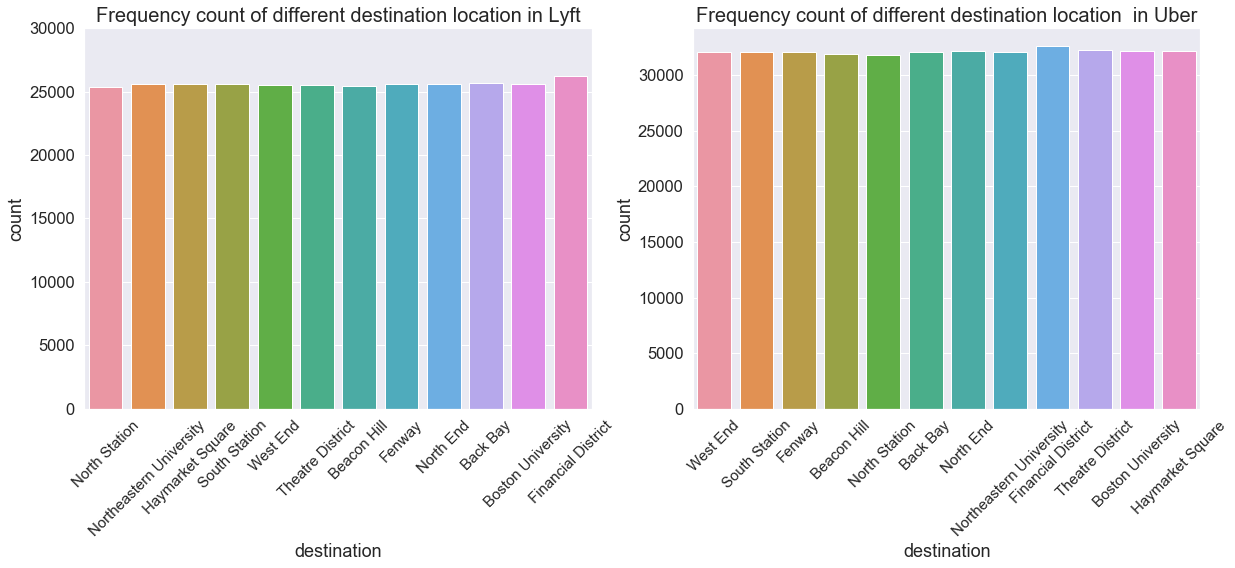

In [1804]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['destination'], ax=ax1)
ax1.set_title('Frequency count of different destination location in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=15)
ax1.set_ylim(0, 30000)
sns.countplot(uber['destination'], ax=ax2)
ax2.set_title('Frequency count of different destination location  in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=15)

**Product Id**

In [1805]:
lyft['product_id'].value_counts()

lyft_luxsuv     51235
lyft_lux        51235
lyft_premier    51235
lyft            51235
lyft_plus       51235
lyft_line       51233
Name: product_id, dtype: int64

In [1806]:
uber['product_id'].value_counts()

6d318bcc-22a3-4af6-bddd-b409bfce1546    55096
6f72dfc5-27f1-42e8-84db-ccc7a75f6969    55096
9a0e7b09-b92b-4c41-9779-2ad22b4d779d    55096
6c84fd89-3f11-4782-9b50-97c468b19529    55095
8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a    55095
55c66225-fbe7-4fd5-9072-eab1ece5e23e    55094
997acbb5-e102-41e1-b155-9df7de0a73f2    55091
Name: product_id, dtype: int64

[Text(0, 0, '6f72dfc5-27f1-42e8-84db-ccc7a75f6969'),
 Text(0, 0, '6c84fd89-3f11-4782-9b50-97c468b19529'),
 Text(0, 0, '55c66225-fbe7-4fd5-9072-eab1ece5e23e'),
 Text(0, 0, '9a0e7b09-b92b-4c41-9779-2ad22b4d779d'),
 Text(0, 0, '6d318bcc-22a3-4af6-bddd-b409bfce1546'),
 Text(0, 0, '997acbb5-e102-41e1-b155-9df7de0a73f2'),
 Text(0, 0, '8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a')]

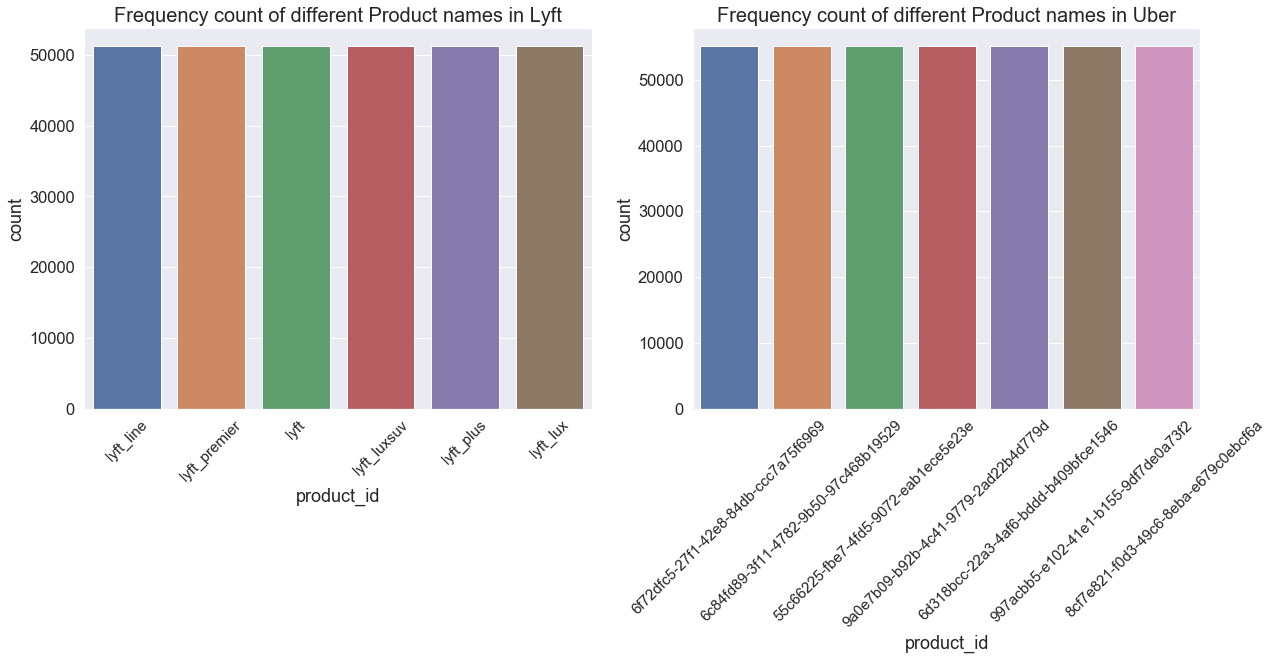

In [1807]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['product_id'], ax=ax1)
ax1.set_title('Frequency count of different Product names in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=15)
sns.countplot(uber['product_id'], ax=ax2)
ax2.set_title('Frequency count of different Product names in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=15)

**Surge multiplier**

In [1808]:
lyft['surge_multiplier'].value_counts() # frequency count

1.00    286433
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: surge_multiplier, dtype: int64

In [1809]:
uber['surge_multiplier'].value_counts()

1.0    385663
Name: surge_multiplier, dtype: int64

(0, 350000)

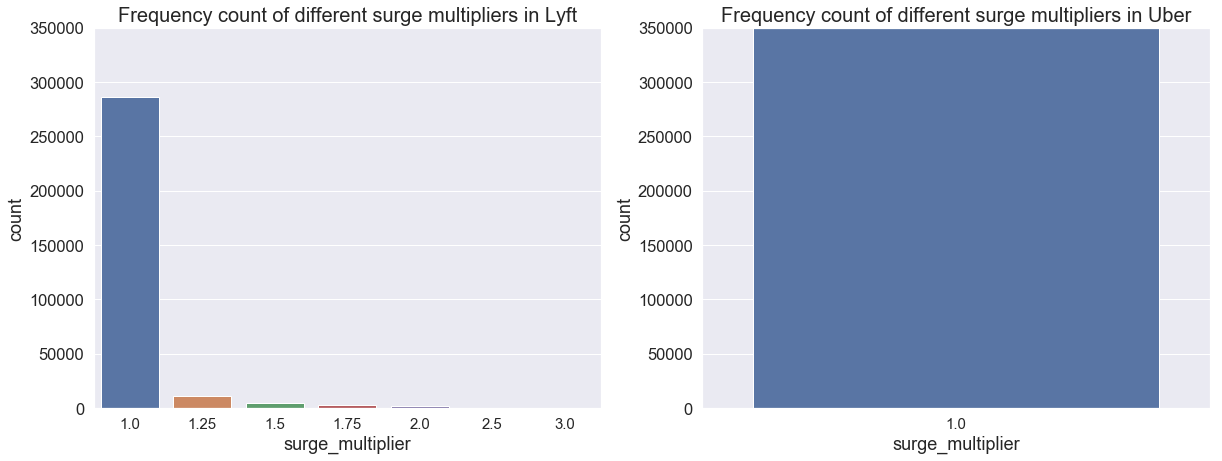

In [1810]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['surge_multiplier'], ax=ax1)
ax1.set_title('Frequency count of different surge multipliers in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
ax1.set_ylim(0, 350000)
sns.countplot(uber['surge_multiplier'], ax=ax2)
ax2.set_title('Frequency count of different surge multipliers in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)
ax2.set_ylim(0, 350000)

From the above charts, we see that, there is a variety of surge mulipliers in Lyft, whereas in Uber, there is only one 
surge multiplier.     
This has increased the number of riders in Uber, compared to Lyft.

**Hour**

In [1811]:
lyft['hour'].value_counts()

0     14976
23    14760
10    13248
16    13248
12    13248
13    13248
14    13248
11    13248
17    13248
18    13248
15    13247
2     13176
1     13176
22    12888
4     12888
3     12786
9     12600
21    12024
19    11952
6     11880
20    11592
5     11232
7     11160
8     11087
Name: hour, dtype: int64

In [1812]:
uber['hour'].value_counts()

0     17437
23    17171
10    17136
15    17136
12    17136
13    17136
14    17136
11    17136
16    17136
17    17136
18    17136
22    16548
9     16371
21    15708
19    15603
6     15456
4     15442
2     15372
1     15372
20    15190
3     15029
7     13776
5     13776
8     13188
Name: hour, dtype: int64

(0, 17500)

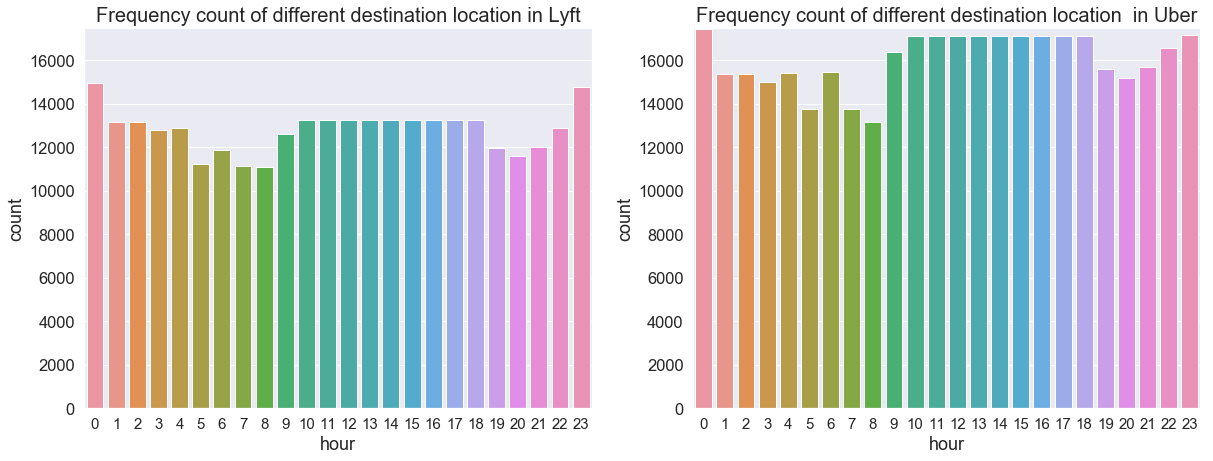

In [1813]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['hour'], ax=ax1)
ax1.set_title('Frequency count of different destination location in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
ax1.set_ylim(0, 17500)
sns.countplot(uber['hour'], ax=ax2)
ax2.set_title('Frequency count of different destination location  in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)
ax2.set_ylim(0, 17500)

Hour has almost similar distribution for both Uber and Lyft.  This is due to fact that cab riders has the option to choose
between Lyft and Uber for their customers.       
We can see that there is high usage in the hours from 10 to evening 7, this makes sense as this the office hours,
where people likely to travel frequently.

## Bi-variate Analysis

### Continuous & Continuous

(0, 100)

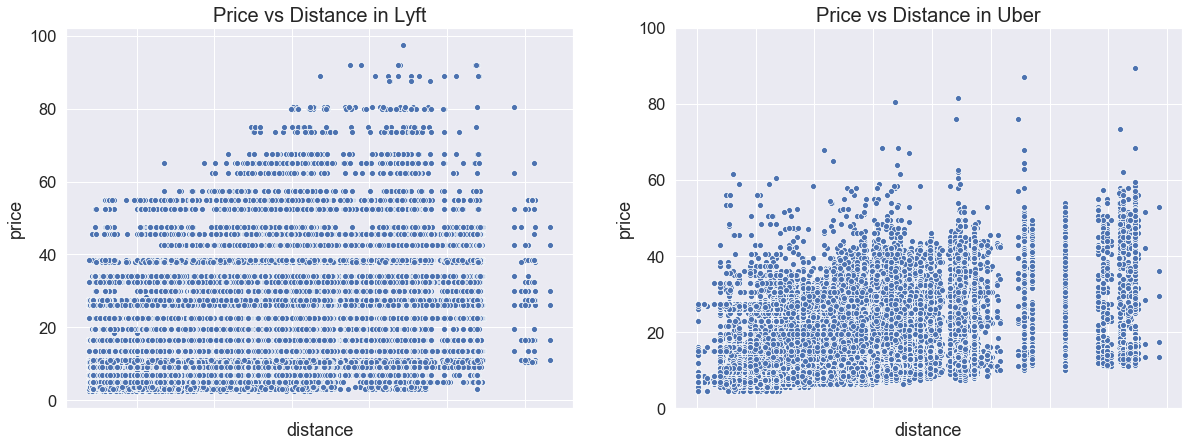

In [1814]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.scatterplot(lyft['distance'], lyft['price'], ax=ax1)
ax1.set_title('Price vs Distance in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
sns.scatterplot(uber['distance'], uber['price'], ax=ax2)
ax2.set_title('Price vs Distance in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)
ax2.set_ylim(0, 100)

In [1815]:
lyft['distance'].corr(lyft['price'])

0.3615666155487001

In [1816]:
uber['distance'].corr(uber['price'])

0.3362037661660918

Distance is one of the important factors, which drives the price of the rides.  We could see that there is a positive 
correlation in the graph, with the presence of outliers as we saw before, because of the use of luxury car models and 
bad weather conditions.

### Categorical & Categorical:

**Cab type vs Source**

In [1817]:
a= pd.crosstab(cab_data['cab_type'], cab_data['source'])
a

source    Back Bay  Beacon Hill  Boston University  Fenway  \
cab_type                                                     
Lyft         25655        25464              25620   25620   
Uber         32137        31939              32144   32137   

source    Financial District  Haymarket Square  North End  North Station  \
cab_type                                                                   
Lyft                   26237             25614      25620          25326   
Uber                   32620             32122      32143          31792   

source    Northeastern University  South Station  Theatre District  West End  
cab_type                                                                      
Lyft                        25614          25620             25530     25488  
Uber                        32142          32130             32283     32074

In [1818]:
pd.crosstab(cab_data['cab_type'], cab_data['source'], normalize=True)

source    Back Bay  Beacon Hill  Boston University    Fenway  \
cab_type                                                       
Lyft      0.037016     0.036741           0.036966  0.036966   
Uber      0.046369     0.046083           0.046379  0.046369   

source    Financial District  Haymarket Square  North End  North Station  \
cab_type                                                                   
Lyft                0.037856          0.036957   0.036966       0.036542   
Uber                0.047066          0.046347   0.046378       0.045871   

source    Northeastern University  South Station  Theatre District  West End  
cab_type                                                                      
Lyft                     0.036957       0.036966          0.036836  0.036775  
Uber                     0.046376       0.046359          0.046580  0.046278

<Figure size 720x504 with 0 Axes>

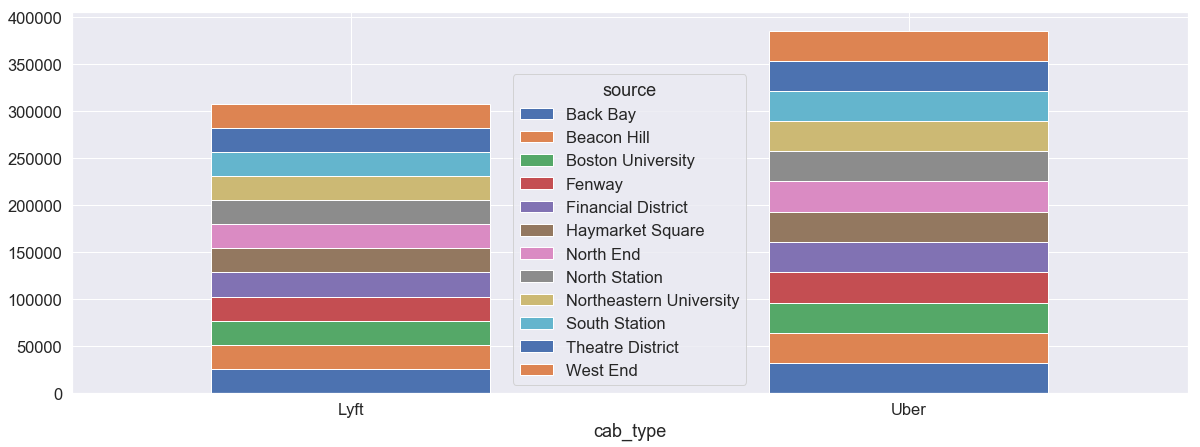

In [1819]:
plt.figure(figsize=(10,7))
pd.crosstab(cab_data['cab_type'], cab_data['source']).plot.bar(stacked=True, figsize=(20,7), rot=0)

**Cab type vs Destination**

In [1820]:
pd.crosstab(cab_data['cab_type'], cab_data['destination'])

destination  Back Bay  Beacon Hill  Boston University  Fenway  \
cab_type                                                        
Lyft            25650        25464              25614   25620   
Uber            32130        31939              32150   32137   

destination  Financial District  Haymarket Square  North End  North Station  \
cab_type                                                                      
Lyft                      26238             25613      25614          25326   
Uber                      32613             32151      32142          31793   

destination  Northeastern University  South Station  Theatre District  \
cab_type                                                                
Lyft                           25619          25620             25536   
Uber                           32136          32129             32262   

destination  West End  
cab_type               
Lyft            25494  
Uber            32081

In [1821]:
pd.crosstab(cab_data['cab_type'], cab_data['destination'], normalize=True)

destination  Back Bay  Beacon Hill  Boston University    Fenway  \
cab_type                                                          
Lyft         0.037009     0.036741           0.036957  0.036966   
Uber         0.046359     0.046083           0.046388  0.046369   

destination  Financial District  Haymarket Square  North End  North Station  \
cab_type                                                                      
Lyft                   0.037858          0.036956   0.036957       0.036542   
Uber                   0.047056          0.046389   0.046376       0.045873   

destination  Northeastern University  South Station  Theatre District  \
cab_type                                                                
Lyft                        0.036964       0.036966          0.036845   
Uber                        0.046368       0.046357          0.046549   

destination  West End  
cab_type               
Lyft         0.036784  
Uber         0.046288

<Figure size 720x504 with 0 Axes>

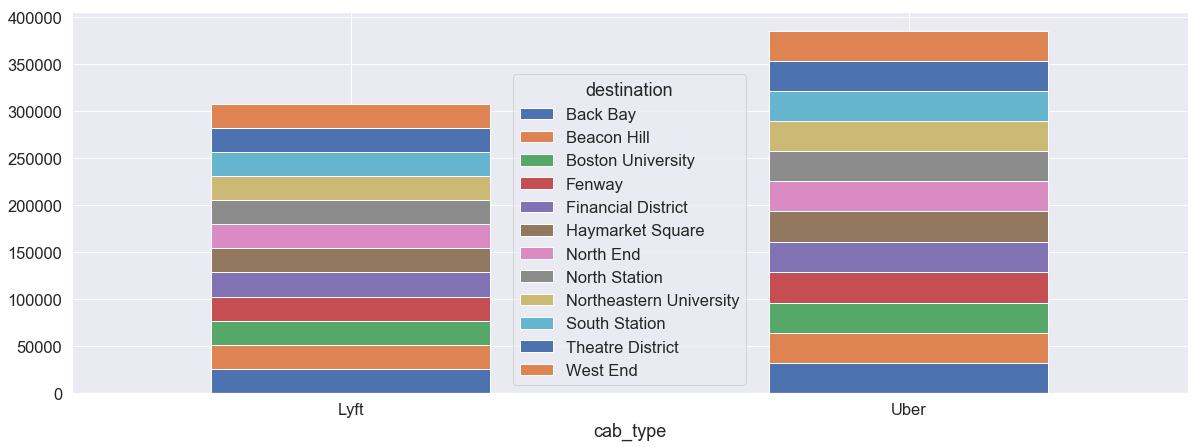

In [1822]:
plt.figure(figsize=(10,7))
pd.crosstab(cab_data['cab_type'], cab_data['destination']).plot.bar(stacked=True, figsize=(20,7), rot=0)

**Cab type vs Surge multiplier**

In [1823]:
pd.crosstab(cab_data['cab_type'], cab_data['surge_multiplier'])

surge_multiplier    1.00   1.25  1.50  1.75  2.00  2.50  3.00
cab_type                                                     
Lyft              286433  11085  5065  2420  2239   154    12
Uber              385663      0     0     0     0     0     0

In [1824]:
pd.crosstab(cab_data['cab_type'], cab_data['surge_multiplier'], normalize=True)

surge_multiplier      1.00      1.25      1.50      1.75      2.00      2.50  \
cab_type                                                                       
Lyft              0.413281  0.015994  0.007308  0.003492  0.003231  0.000222   
Uber              0.556455  0.000000  0.000000  0.000000  0.000000  0.000000   

surge_multiplier      3.00  
cab_type                    
Lyft              0.000017  
Uber              0.000000

<Figure size 720x504 with 0 Axes>

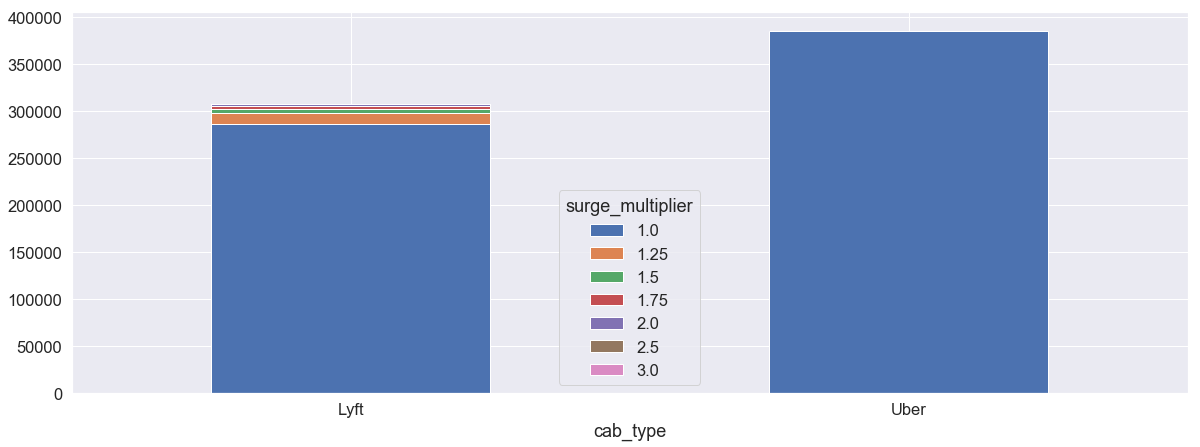

In [1825]:
plt.figure(figsize=(10,7))
pd.crosstab(cab_data['cab_type'], cab_data['surge_multiplier']).plot.bar(stacked=True, figsize=(20,7), rot=0)

**Car model vs Source**

In [1826]:
pd.crosstab(lyft['name'], lyft['source'])

source        Back Bay  Beacon Hill  Boston University  Fenway  \
name                                                             
Lux               4276         4244               4270    4270   
Lux Black         4276         4244               4270    4270   
Lux Black XL      4276         4244               4270    4270   
Lyft              4276         4244               4270    4270   
Lyft XL           4276         4244               4270    4270   
Shared            4275         4244               4270    4270   

source        Financial District  Haymarket Square  North End  North Station  \
name                                                                           
Lux                         4373              4269       4270           4221   
Lux Black                   4373              4269       4270           4221   
Lux Black XL                4373              4269       4270           4221   
Lyft                        4373              4269       4270           4221   
Lyft XL                     4373              4269       4270           4221   
Shared                      4372              4269       4270           4221   

source        Northeastern University  South Station  Theatre District  \
name                                                                     
Lux                              4269           4270              4255   
Lux Black                        4269           4270              4255   
Lux Black XL                     4269           4270              4255   
Lyft                             4269           4270              4255   
Lyft XL                          4269           4270              4255   
Shared                           4269           4270              4255   

source        West End  
name                    
Lux               4248  
Lux Black         4248  
Lux Black XL      4248  
Lyft              4248  
Lyft XL           4248  
Shared            4248

<Figure size 720x504 with 0 Axes>

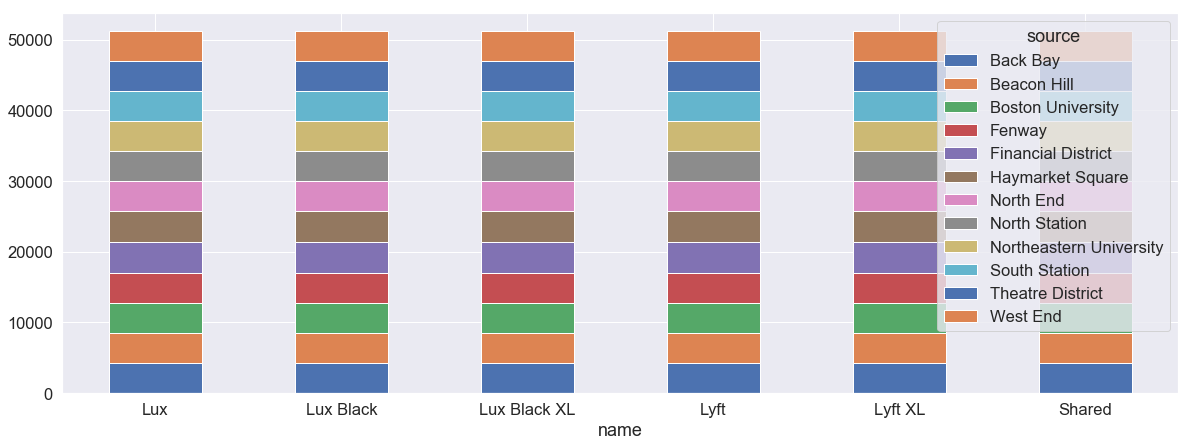

In [1827]:
plt.figure(figsize=(10,7))
pd.crosstab(lyft['name'], lyft['source']).plot.bar(stacked=True, figsize=(20,7), rot=0)

In [1828]:
cab_data['source'].nunique(), cab_data['destination'].nunique()

(12, 12)

In [1829]:
pd.crosstab(uber['name'], uber['source'])

source     Back Bay  Beacon Hill  Boston University  Fenway  \
name                                                          
Black          4591         4563               4592    4591   
Black SUV      4591         4563               4592    4591   
Taxi           4591         4562               4592    4591   
UberPool       4591         4562               4592    4591   
UberX          4591         4563               4592    4591   
UberXL         4591         4563               4592    4591   
WAV            4591         4563               4592    4591   

source     Financial District  Haymarket Square  North End  North Station  \
name                                                                        
Black                    4660              4589       4591           4542   
Black SUV                4660              4589       4592           4542   
Taxi                     4660              4589       4592           4542   
UberPool                 4660              4588       4592           4541   
UberX                    4660              4589       4592           4541   
UberXL                   4660              4589       4592           4542   
WAV                      4660              4589       4592           4542   

source     Northeastern University  South Station  Theatre District  West End  
name                                                                           
Black                         4592           4590              4612      4582  
Black SUV                     4592           4590              4612      4582  
Taxi                          4592           4590              4612      4582  
UberPool                      4591           4590              4611      4582  
UberX                         4591           4590              4612      4582  
UberXL                        4592           4590              4612      4582  
WAV                           4592           4590              4612      4582

**Car model vs Surge multiplier**

In [1830]:
pd.crosstab(lyft['name'], lyft['surge_multiplier'])

surge_multiplier   1.00  1.25  1.50  1.75  2.00  2.50  3.00
name                                                       
Lux               47040  2217  1013   484   481     0     0
Lux Black         47040  2217  1013   484   481     0     0
Lux Black XL      47040  2217  1013   484   481     0     0
Lyft              47040  2217  1013   484   398    77     6
Lyft XL           47040  2217  1013   484   398    77     6
Shared            51233     0     0     0     0     0     0

We can see that, the surge multiplier doesn't vary for different car models in Lyft, except for few exceptions
in Lyft XL, which is a high-end car services of Lyft.

In [1831]:
pd.crosstab(lyft['name'], lyft['surge_multiplier'], normalize=True)

surge_multiplier      1.00      1.25      1.50      1.75      2.00     2.50  \
name                                                                          
Lux               0.153021  0.007212  0.003295  0.001574  0.001565  0.00000   
Lux Black         0.153021  0.007212  0.003295  0.001574  0.001565  0.00000   
Lux Black XL      0.153021  0.007212  0.003295  0.001574  0.001565  0.00000   
Lyft              0.153021  0.007212  0.003295  0.001574  0.001295  0.00025   
Lyft XL           0.153021  0.007212  0.003295  0.001574  0.001295  0.00025   
Shared            0.166661  0.000000  0.000000  0.000000  0.000000  0.00000   

surge_multiplier     3.00  
name                       
Lux               0.00000  
Lux Black         0.00000  
Lux Black XL      0.00000  
Lyft              0.00002  
Lyft XL           0.00002  
Shared            0.00000

<Figure size 720x504 with 0 Axes>

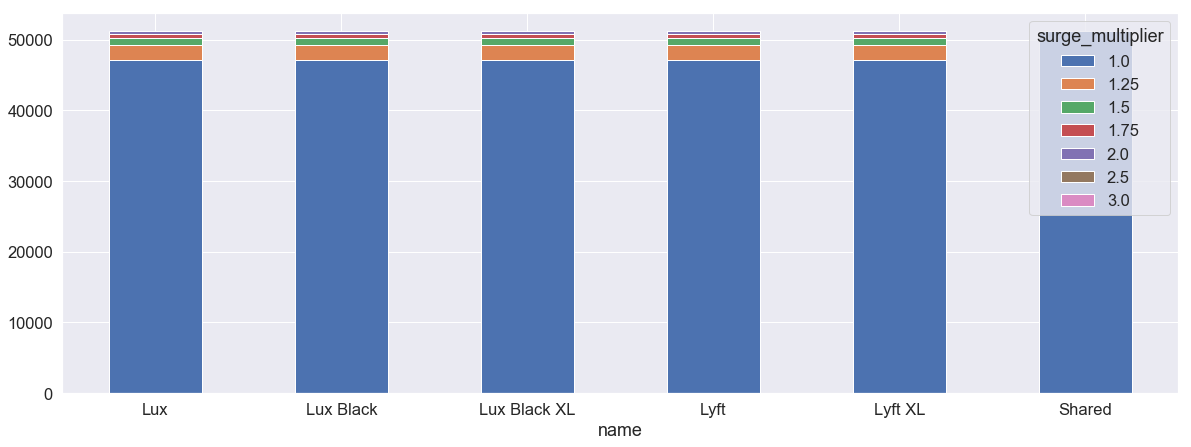

In [1832]:
plt.figure(figsize=(10,7))
pd.crosstab(lyft['name'], lyft['surge_multiplier']).plot.bar(stacked=True, figsize=(20,7), rot=0)

In [1833]:
pd.crosstab(uber['name'], uber['surge_multiplier'])

surge_multiplier    1.0
name                   
Black             55095
Black SUV         55096
Taxi              55095
UberPool          55091
UberX             55094
UberXL            55096
WAV               55096

**Source vs Destination**

In [1834]:
pd.crosstab(uber['source'], uber['destination'])

destination              Back Bay  Beacon Hill  Boston University  Fenway  \
source                                                                      
Back Bay                        0            0               5271    5257   
Beacon Hill                     0            0               5124    5236   
Boston University            5271         5117                  0       0   
Fenway                       5264         5236                  0       0   
Financial District              0            0               5397    5369   
Haymarket Square             5369         5348                  0       0   
North End                    5677         5593                  0       0   
North Station                   0            0               5250    5467   
Northeastern University      5313         5388                  0       0   
South Station                5236         5257                  0       0   
Theatre District                0            0               5550    5173   
West End                        0            0               5558    5635   

destination              Financial District  Haymarket Square  North End  \
source                                                                     
Back Bay                                  0              5369       5677   
Beacon Hill                               0              5348       5593   
Boston University                      5397                 0          0   
Fenway                                 5355                 0          0   
Financial District                        0              5628       5187   
Haymarket Square                       5628                 0          0   
North End                              5187                 0          0   
North Station                             0              5327       5227   
Northeastern University                5320                 0          0   
South Station                          5726                 0          0   
Theatre District                          0              5355       5362   
West End                                  0              5124       5096   

destination              North Station  Northeastern University  \
source                                                            
Back Bay                             0                     5313   
Beacon Hill                          0                     5382   
Boston University                 5250                        0   
Fenway                            5467                        0   
Financial District                   0                     5313   
Haymarket Square                  5320                        0   
North End                         5228                        0   
North Station                        0                     5425   
Northeastern University           5425                        0   
South Station                     5103                        0   
Theatre District                     0                     5390   
West End                             0                     5313   

destination              South Station  Theatre District  West End  
source                                                              
Back Bay                          5250                 0         0  
Beacon Hill                       5256                 0         0  
Boston University                    0              5551      5558  
Fenway                               0              5180      5635  
Financial District                5726                 0         0  
Haymarket Square                     0              5333      5124  
North End                            0              5355      5103  
North Station                     5096                 0         0  
Northeastern University              0              5390      5306  
South Station                        0              5453      5355  
Theatre District                  5453                 0         0  
West End            

This table shows that, we cannot hope to go to any place within Boston city, 
As we can see that, these destinations are within 3 miles from source. Are people in Massachussettes, choose to skip cabs 
within 3 miles, we need to analyze further to make any claims.

## Weather dataset

In [1835]:
weather_data.info() # basic info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
temp          6276 non-null float64
location      6276 non-null object
clouds        6276 non-null float64
pressure      6276 non-null float64
rain          894 non-null float64
time_stamp    6276 non-null int64
humidity      6276 non-null float64
wind          6276 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


**Attribute Information**

Location - Location name              
Clouds              
Pressure - pressure in mb              
Rain - rain in inches for the last hr              
Time_stamp - epoch time when row data was collected              
Humidity - humidity in %              
Wind - wind speed in mph

### Data Type      
**Object**

    - location
    
**Numeric**       
    - temp
    - clouds
    - pressure
    - rain
    - time stamp
    - humidity
    - wind

### Feature category        
**Categorical**       
    - location
    
**Continuous**     
    - temp
    - time stamp
    - clouds
    - pressure
    - rain
    - humidity
    - wind

### Univariate Analysis

In [1836]:
# let's impute the unix epoch time to standard date time format
weather_data['time_stamp'] = pd.to_datetime(weather_data['time_stamp'], unit='s')
weather_data['date'] = weather_data['time_stamp'].dt.date
weather_data['hour'] = weather_data['time_stamp'].dt.hour

weather_data.drop('time_stamp', axis=1, inplace=True)

weather_data.head(3)

temp           location  clouds  pressure    rain  humidity   wind  \
0  42.42           Back Bay     1.0   1012.14  0.1228      0.77  11.25   
1  42.43        Beacon Hill     1.0   1012.15  0.1846      0.76  11.32   
2  42.50  Boston University     1.0   1012.15  0.1089      0.76  11.07   

         date  hour  
0  2018-12-16    23  
1  2018-12-16    23  
2  2018-12-16    23

**Continuous**

**Temperature**

In [1837]:
weather_data['temp'].describe()

count    6276.000000
mean       39.090475
std         6.022055
min        19.620000
25%        36.077500
50%        40.130000
75%        42.832500
max        55.410000
Name: temp, dtype: float64

In [1838]:
calculate_mop(Temperature = weather_data['temp'])

Temperature 

Standard deviation:     6.0220551532287905
Skewness:               -0.6367774660732213
Kurtosis:               0.9473947101070599



Text(0.5, 1.0, 'Distribution of Temperature')

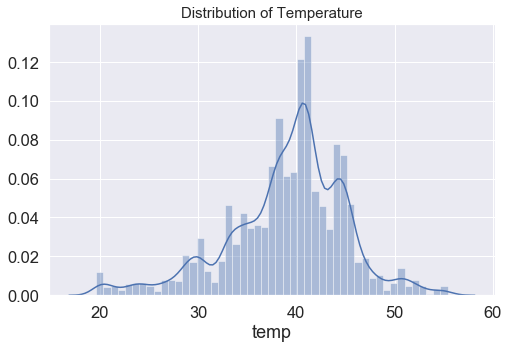

In [1839]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['temp'])
plt.title('Distribution of Temperature', fontsize=15)

Text(0.5, 1.0, 'Distribution of Temperature')

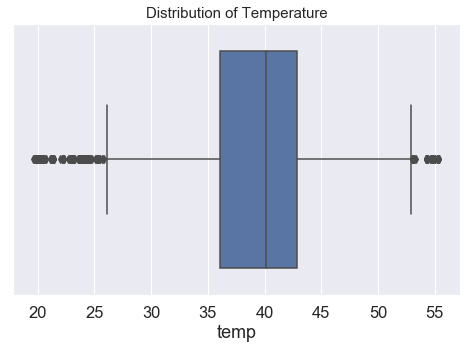

In [1840]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['temp'])
plt.title('Distribution of Temperature', fontsize=15)

In [1841]:
weather_data[weather_data.temp < 26].date.value_counts()

2018-12-13    171
2018-12-18     48
Name: date, dtype: int64

In [1842]:
weather_data[weather_data.temp > 53].date.value_counts()

2018-12-03    43
Name: date, dtype: int64

According to this website https://www.timeanddate.com/weather/usa/boston/historic?month=12&year=2018,
the data is legitimate. We can keep the outliers.

In [1843]:
weather_data[weather_data['temp']<27].shape

(263, 9)

In [1844]:
weather_data[weather_data['temp']>52.5].shape

(60, 9)

Temperature is slighty left skewed, and it makes sense, because this data is collected around the month of november,
although occassionally we can see high temperature as well in locations such as Financial district, Boston university
and Back bay.

In [1845]:
weather_data[weather_data.temp>53].location.value_counts()

Haymarket Square           4
Boston University          4
Beacon Hill                4
Financial District         4
South Station              4
Back Bay                   4
North End                  4
Fenway                     3
Theatre District           3
West End                   3
Northeastern University    3
North Station              3
Name: location, dtype: int64

**Clouds**

In [1846]:
weather_data['clouds'].describe()

count    6276.000000
mean        0.677777
std         0.314284
min         0.000000
25%         0.440000
50%         0.780000
75%         0.970000
max         1.000000
Name: clouds, dtype: float64

In [1847]:
calculate_mop(Clouds=weather_data['clouds'])

Clouds 

Standard deviation:     0.31428408307617434
Skewness:               -0.6298749220024757
Kurtosis:               -0.9471363341308998



Text(0.5, 1.0, 'Distribution of Clouds')

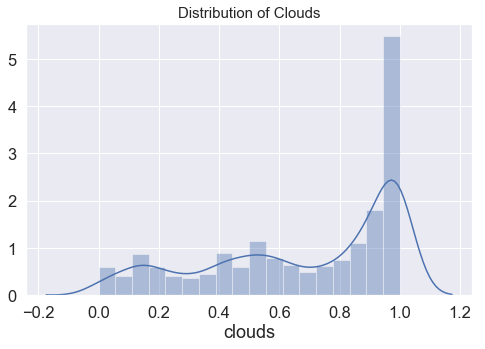

In [1848]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['clouds'])
plt.title('Distribution of Clouds', fontsize=15)

Text(0.5, 1.0, 'Distribution of Clouds')

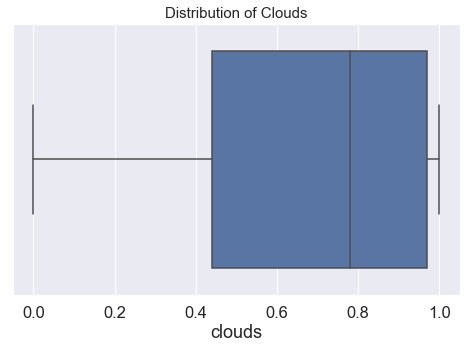

In [1849]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['clouds'])
plt.title('Distribution of Clouds', fontsize=15)

**Pressure**

In [1850]:
weather_data['pressure'].describe()

count    6276.000000
mean     1008.445209
std        12.870775
min       988.250000
25%       997.747500
50%      1007.660000
75%      1018.480000
max      1035.120000
Name: pressure, dtype: float64

In [1851]:
calculate_mop(Pressure=weather_data['pressure'])

Pressure 

Standard deviation:     12.870774589670066
Skewness:               0.2580312741810195
Kurtosis:               -0.972776128518789



Text(0.5, 1.0, 'Distribution of Pressure')

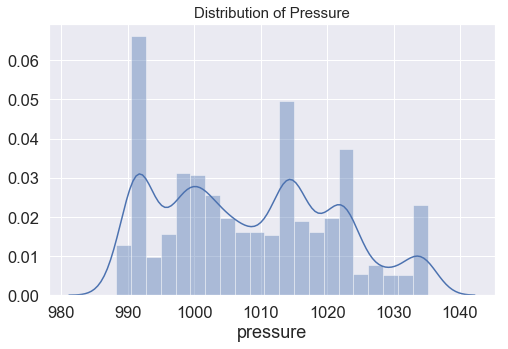

In [1852]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['pressure'])
plt.title('Distribution of Pressure', fontsize=15)

Text(0.5, 1.0, 'Distribution of Clouds')

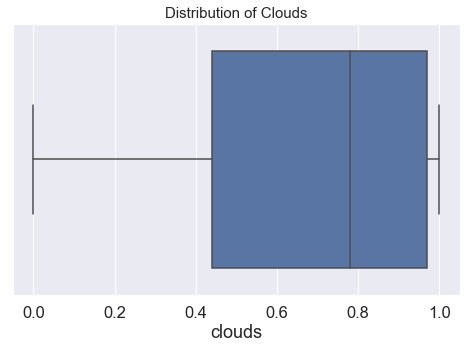

In [1853]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['clouds'])
plt.title('Distribution of Clouds', fontsize=15)

**Rain**

In [1854]:
weather_data['rain'].describe()

count    894.000000
mean       0.057652
std        0.100758
min        0.000200
25%        0.004900
50%        0.014850
75%        0.060925
max        0.780700
Name: rain, dtype: float64

In [1855]:
calculate_mop(Rain=weather_data['rain'])

Rain 

Standard deviation:     0.10075780186235399
Skewness:               3.8076076191204042
Kurtosis:               20.156153918679006



Text(0.5, 1.0, 'Distribution of Rain')

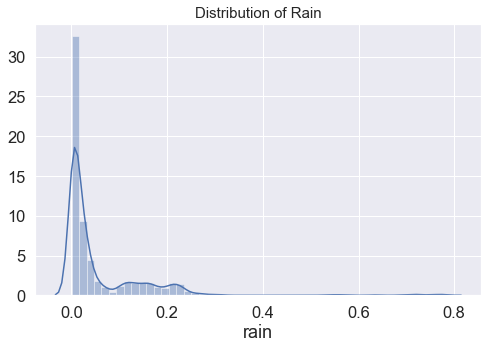

In [1856]:
plt.figure(figsize=(8,5))
a = sns.distplot(weather_data[~weather_data['rain'].isnull()]['rain'])
plt.title('Distribution of Rain', fontsize=15)

In [1857]:
# a.figure.savefig(r'C:\Users\gokul\Downloads\rain.jpg')

Text(0.5, 1.0, 'Distribution of Rain')

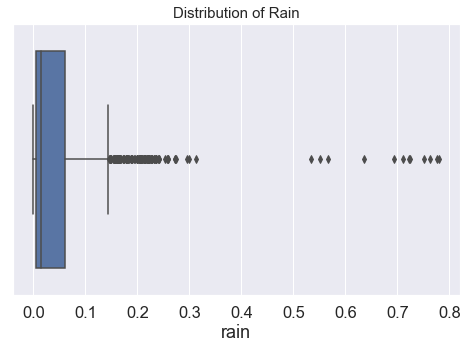

In [1858]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data[~weather_data['rain'].isnull()]['rain'])
plt.title('Distribution of Rain', fontsize=15)

In [1859]:
weather_data[weather_data['rain']>0.13].date.value_counts()

2018-11-27    140
2018-12-16      8
2018-11-26      4
Name: date, dtype: int64

**Outliers handling**

According to this website https://www.timeanddate.com/weather/usa/boston/historic?month=12&year=2018, 
there was rain only on specific days at particular hours.     
So, we've decided not to remove these outliers.

Rain is right skewed, it is understandable as this data is collected for 17 days, only in few days, there was rain
in Boston city.

**Humidity**

In [1860]:
weather_data['humidity'].describe()

count    6276.000000
mean        0.763985
std         0.127340
min         0.450000
25%         0.670000
50%         0.760000
75%         0.890000
max         0.990000
Name: humidity, dtype: float64

In [1861]:
calculate_mop(Humidity = weather_data['humidity'])

Humidity 

Standard deviation:     0.12733970290131602
Skewness:               -0.23414719562515968
Kurtosis:               -0.949730940221841



Text(0.5, 1.0, 'Distribution of Humidity')

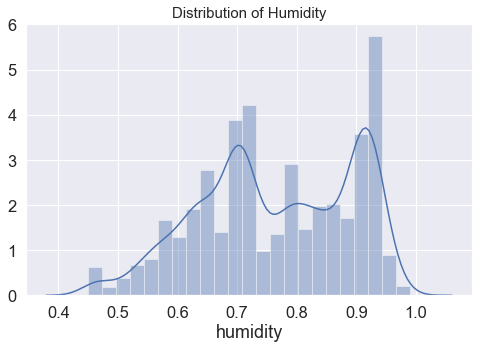

In [1862]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['humidity'])
plt.title('Distribution of Humidity', fontsize=15)

Text(0.5, 1.0, 'Distribution of Humidity')

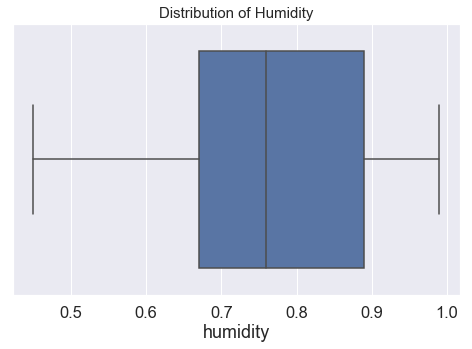

In [1863]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['humidity'])
plt.title('Distribution of Humidity', fontsize=15)

**Wind**

In [1864]:
weather_data['wind'].describe()

count    6276.000000
mean        6.802812
std         3.633466
min         0.290000
25%         3.517500
50%         6.570000
75%         9.920000
max        18.180000
Name: wind, dtype: float64

In [1865]:
calculate_mop(Wind=weather_data['wind'])

Wind 

Standard deviation:     3.633466319108246
Skewness:               0.20356454700960958
Kurtosis:               -0.7685125750832729



Text(0.5, 1.0, 'Distribution of Wind')

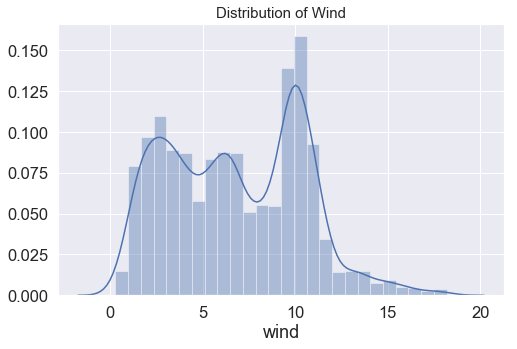

In [1866]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['wind'])
plt.title('Distribution of Wind', fontsize=15)

Text(0.5, 1.0, 'Distribution of Wind')

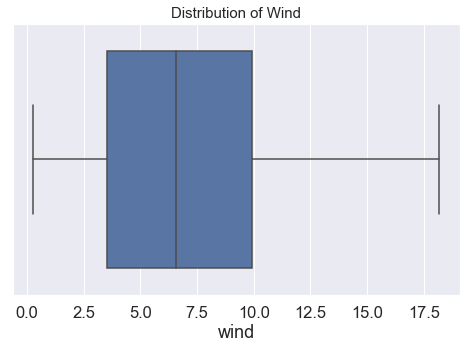

In [1867]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['wind'])
plt.title('Distribution of Wind', fontsize=15)

**Category**

**Location**

In [1868]:
weather_data['location'].value_counts()

North End                  523
Beacon Hill                523
North Station              523
Back Bay                   523
West End                   523
Boston University          523
Theatre District           523
Fenway                     523
Financial District         523
South Station              523
Northeastern University    523
Haymarket Square           523
Name: location, dtype: int64

### Bi-variate analysis

    - temp
    - time stamp
    - clouds
    - pressure
    - rain
    - humidity
    - wind

**Continuous & Continuous**

C:\Users\gokul\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\gokul\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


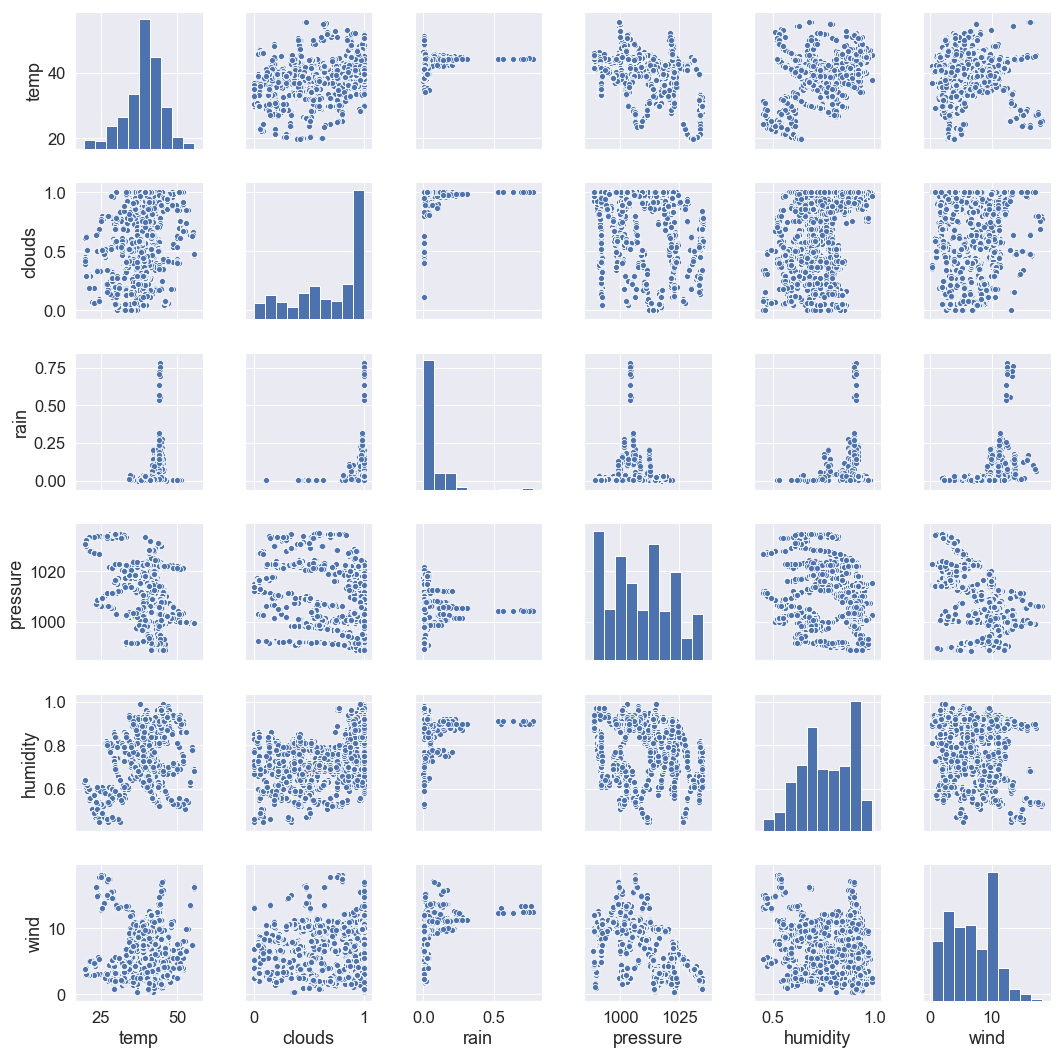

In [1869]:
sns.pairplot(weather_data[['temp', 'clouds', 'rain', 'pressure', 'humidity', 'wind']])

**Categorical & Continuous**

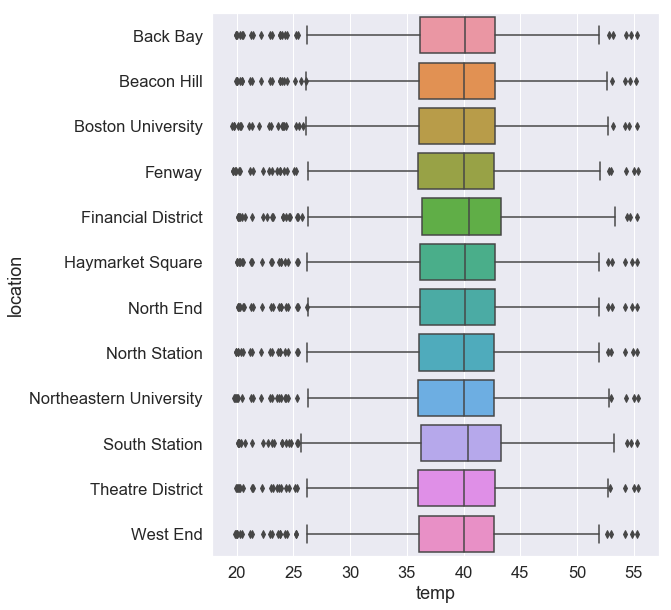

In [1870]:
sns.boxplot(weather_data['temp'], y=weather_data['location'], orient='h')

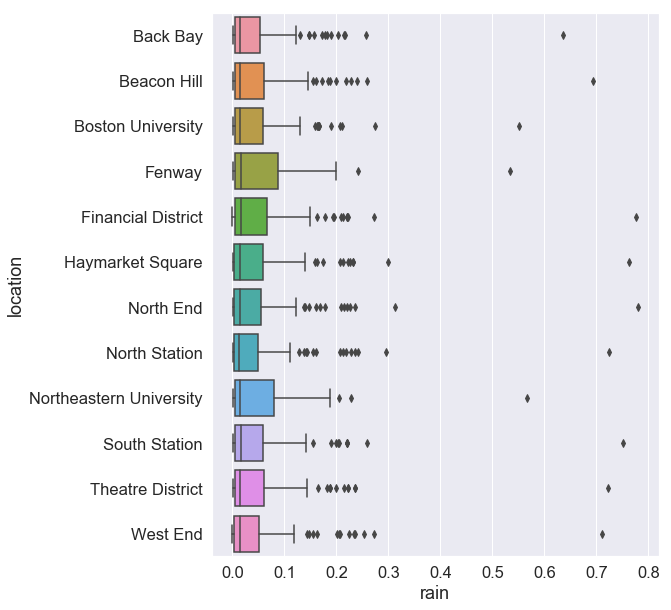

In [1871]:
sns.boxplot(weather_data['rain'], y=weather_data['location'], orient='h')

Since the data is collected within Boston city, the rain has effect on all the locations within the city,
among those locations such as Financial District, Haymarket Square and North end have experienced high rainfall.

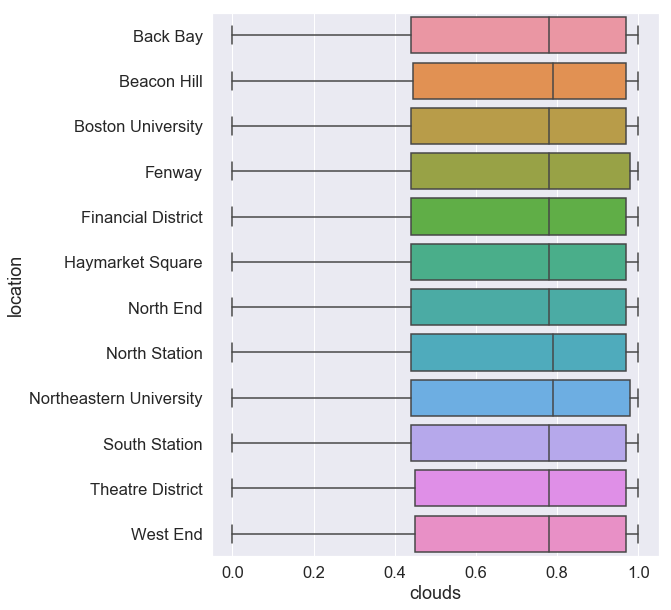

In [1872]:
sns.boxplot(weather_data['clouds'], y=weather_data['location'], orient='h')

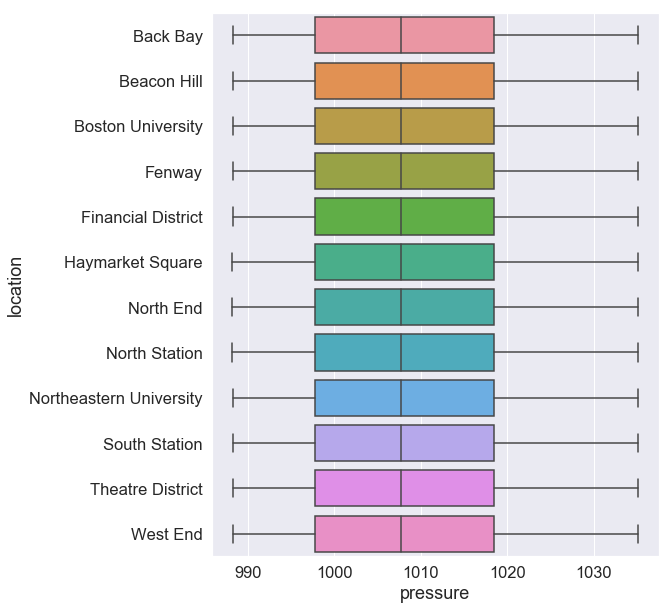

In [1873]:
sns.boxplot(weather_data['pressure'], y=weather_data['location'], orient='h')

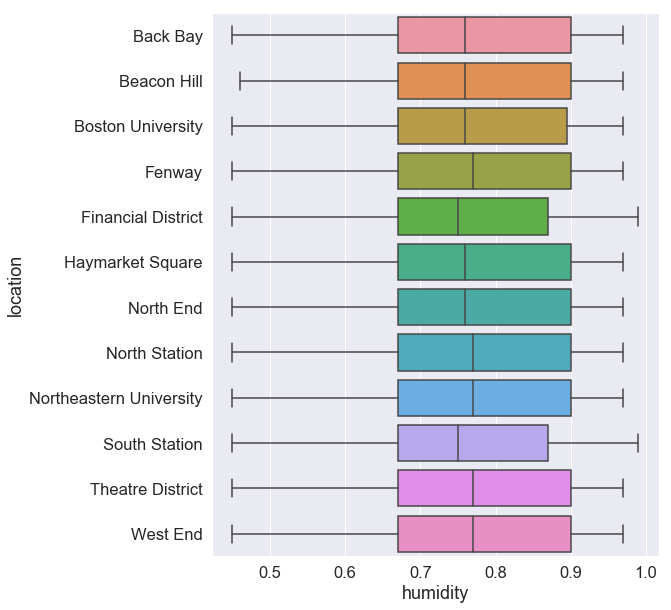

In [1874]:
sns.boxplot(weather_data['humidity'], y=weather_data['location'], orient='h')

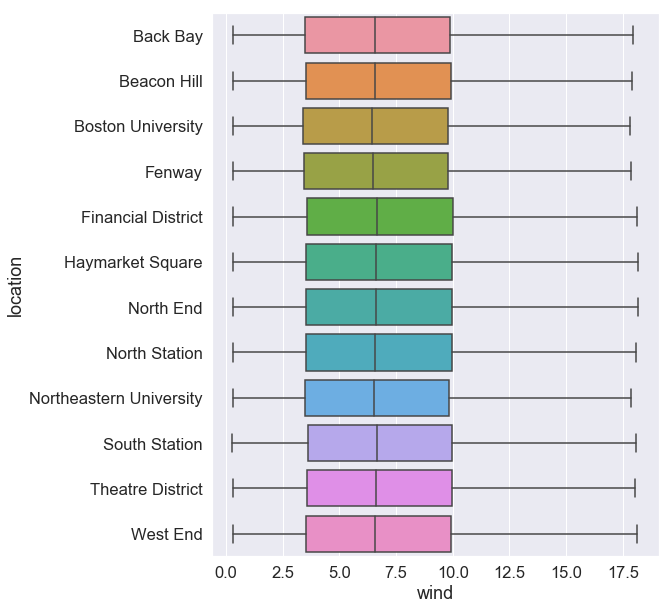

In [1875]:
sns.boxplot(weather_data['wind'], y=weather_data['location'], orient='h')

In [1876]:
weather_data['date'].value_counts().sort_index()

2018-11-26    852
2018-11-27    684
2018-11-28    948
2018-11-29    768
2018-11-30    300
2018-12-01    324
2018-12-02    288
2018-12-03    288
2018-12-04     72
2018-12-09     24
2018-12-10     72
2018-12-13    276
2018-12-14    288
2018-12-15    288
2018-12-16    288
2018-12-17    288
2018-12-18    228
Name: date, dtype: int64

### Missing Value Treatment

#### Cab rides dataset

In [1877]:
nrows, ncols = cab_data.shape
print(f'Cab ride dataset contains {nrows} rows and {ncols} columns.')

Cab ride dataset contains 693071 rows and 11 columns.


In [1878]:
mv  = cab_data.isnull().sum().sum()
prop = round(((mv/cab_data.shape[0]) * 100),3)
print(f'Cab ride dataset contains {mv} missing values, which is {prop} % of whole data.')

Cab ride dataset contains 55095 missing values, which is 7.949 % of whole data.


In [1879]:
cab_data.isnull().sum()

distance                0
cab_type                0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
date                    0
hour                    0
dtype: int64

The missing values are present in the price (target) column.

Let's check the missing values are occuring at random.

In [1880]:
# let's check the cab type
cab_data[cab_data['price'].isnull()]['cab_type'].value_counts() 

Uber    55095
Name: cab_type, dtype: int64

We can see that, the missing values are present only in the Uber data. Let's also check the car type and model.

In [1881]:
cab_data[cab_data['cab_type']=='Uber'].name.value_counts()

WAV          55096
UberXL       55096
Black SUV    55096
Taxi         55095
Black        55095
UberX        55094
UberPool     55091
Name: name, dtype: int64

In [1882]:
cab_data[cab_data['price'].isnull()]['name'].value_counts() # car model

Taxi    55095
Name: name, dtype: int64

We have checked the Uber official website for different car models, and the missing values are less than 10%
of the original data, we have decided to drop the records containing missing values in the target price feature.

In [1883]:
# let's drop those records
cab_data.dropna(how='any', inplace=True)
nrows, ncols = cab_data.shape
print(f'Now the dataset contains {nrows} rows and {ncols} columns.')

uber = cab_data[cab_data['cab_type']=='Uber']
lyft = cab_data[cab_data['cab_type']=='Lyft']

Now the dataset contains 637976 rows and 11 columns.


In [1884]:
cab_data.isnull().sum().sum() # check for missing values

0

In [1885]:
# cab_data.to_csv('C:\Users\gokul\Downloads\cabs.csv')

**Weather dataset**

In [1886]:
nrows, ncols = weather_data.shape
print(f'Cab ride dataset contains {nrows} rows and {ncols} columns.')

Cab ride dataset contains 6276 rows and 9 columns.


In [1887]:
mv  = weather_data.isnull().sum().sum()
prop = round(((mv/weather_data.shape[0]) * 100),3)
print(f'Cab ride dataset contains {mv} missing values, which is {prop} % of whole data.')

Cab ride dataset contains 5382 missing values, which is 85.755 % of whole data.


In [1888]:
weather_data.isnull().sum()

temp           0
location       0
clouds         0
pressure       0
rain        5382
humidity       0
wind           0
date           0
hour           0
dtype: int64

We can see that, in the 'rain' feature 85.75 % of the data is missing. After checking the weather conditions from the 
official website of Boston and through observation, we can infer that,      
The missing values are due to unobserved input variable, that is there was no rain observed on those particular hour.        

So, we have decided to impute the missing values with zero, which denotes no rain.

In [1889]:
# let's impute the missing values in the 'rain' column with 0
weather_data['rain'].fillna(0, inplace=True)

In [1890]:
weather_data.isnull().sum().sum() # check for missing values

0

### Base Model

In [1891]:
# weather data supposed to contain 1 record per hour, since it has more than one values for few hours, 
# we took groupby average
weather_data = weather_data.groupby(['location','date', 'hour']).mean()
weather_data.reset_index(inplace=True)

In [1892]:
merged_data = pd.merge(cab_data, weather_data, how='left', left_on=['source', 'date', 'hour'],
        right_on=['location', 'date', 'hour'])

In [1893]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637976 entries, 0 to 637975
Data columns (total 18 columns):
distance            637976 non-null float64
cab_type            637976 non-null object
destination         637976 non-null object
source              637976 non-null object
price               637976 non-null float64
surge_multiplier    637976 non-null float64
id                  637976 non-null object
product_id          637976 non-null object
name                637976 non-null object
date                637976 non-null object
hour                637976 non-null int64
location            635240 non-null object
temp                635240 non-null float64
clouds              635240 non-null float64
pressure            635240 non-null float64
rain                635240 non-null float64
humidity            635240 non-null float64
wind                635240 non-null float64
dtypes: float64(9), int64(1), object(8)
memory usage: 92.5+ MB


We could see that there is null values in the data.

In [1894]:
merged_data[merged_data.temp.isnull()].groupby(['source', 'date', 'hour']).mean().head(6)

distance      price  surge_multiplier  temp  \
source      date       hour                                                
Back Bay    2018-11-28 1     1.400000  13.395833               1.0   NaN   
            2018-12-04 6     1.798889  13.937500               1.0   NaN   
            2018-12-18 19    3.260000  17.875000               1.0   NaN   
Beacon Hill 2018-11-28 1     1.575000  13.864583               1.0   NaN   
            2018-12-04 6     2.028500  14.470833               1.0   NaN   
            2018-12-18 19    2.505000  16.208333               1.0   NaN   

                             clouds  pressure  rain  humidity  wind  
source      date       hour                                          
Back Bay    2018-11-28 1        NaN       NaN   NaN       NaN   NaN  
            2018-12-04 6        NaN       NaN   NaN       NaN   NaN  
            2018-12-18 19       NaN       NaN   NaN       NaN   NaN  
Beacon Hill 2018-11-28 1        NaN       NaN   NaN       NaN   NaN  
            2018-12-04 6        NaN       NaN   NaN       NaN   NaN  
            2018-12-18 19       NaN       NaN   NaN       NaN   NaN

Weather data doesn't have records for this particular dates and hours, let's impute these values with the previous values.

In [1895]:
df1 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 11, 28)) &
    (weather_data['hour']==0)]

df2 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 4)) &
    (weather_data['hour']==5)]
df3 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 11, 28)) &
    (weather_data['hour']==2)]
df4 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 4)) &
    (weather_data['hour']==7)]


lookup = pd.concat([df1, df2, df3, df4])
lookup = lookup.groupby(['hour', 'location', 'date']).mean().reset_index()
df5 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 18)) &
    (weather_data['hour']==18)]

lookup = pd.concat([lookup, df5])
lookup['hour'] += 1
lookup.reset_index(inplace=True)

C:\Users\gokul\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [1896]:
weather_data = pd.concat([weather_data, lookup], ignore_index=True) 

C:\Users\gokul\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [1897]:
weather_data.shape

(3996, 10)

In [1898]:
cab_data = pd.merge(cab_data, weather_data, how='left',
                left_on=['source', 'date', 'hour'],
                right_on=['location', 'date', 'hour'])

In [1899]:
cab_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637976 entries, 0 to 637975
Data columns (total 19 columns):
distance            637976 non-null float64
cab_type            637976 non-null object
destination         637976 non-null object
source              637976 non-null object
price               637976 non-null float64
surge_multiplier    637976 non-null float64
id                  637976 non-null object
product_id          637976 non-null object
name                637976 non-null object
date                637976 non-null object
hour                637976 non-null int64
clouds              637976 non-null float64
humidity            637976 non-null float64
index               2736 non-null float64
location            637976 non-null object
pressure            637976 non-null float64
rain                637976 non-null float64
temp                637976 non-null float64
wind                637976 non-null float64
dtypes: float64(10), int64(1), object(8)
memory usage: 97.3+ MB


In [1900]:
cab_data.drop('index', axis=1, inplace=True)

In [1901]:
cab_data.shape, cab_data.drop_duplicates().shape

((637976, 18), (637976, 18))

In [1902]:
# drop unnecessary features
cab_data = cab_data.drop(['id', 'product_id', 'location', 'date'], axis=1)

In [1903]:
corr_m = cab_data.corr()

In [1904]:
x = np.tri(corr_m.shape[0],k=-1)

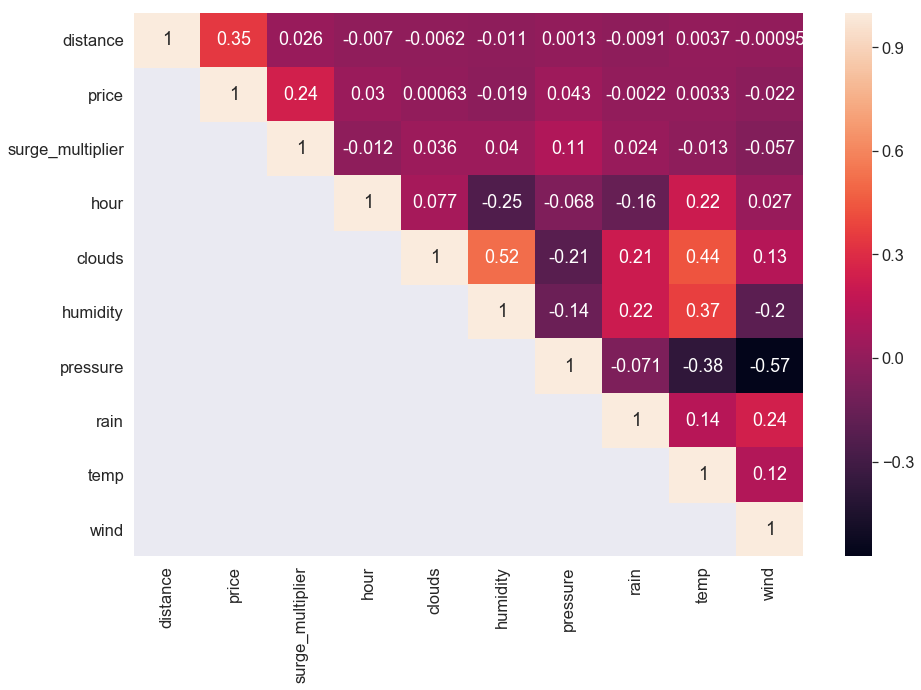

In [1905]:
plt.figure(figsize=(15,10))
a = sns.heatmap(corr_m, annot=True, mask=x)

In [1906]:
# a.figure.savefig(r'C:\Users\gokul\Downloads\corr.jpg')

In [1907]:
# Initial data preparation

In [1908]:
data = cab_data.drop(['price', 'surge_multiplier'], axis=1) # we are dropping surge multiplier, to avoid data leak
labels = cab_data['price'].copy()

In [1909]:
# model building libraries

# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [1910]:
uber = cab_data[cab_data['cab_type']=='Uber']
uber.reset_index(inplace=True)
uber.drop('index', axis=1, inplace=True)
lyft = cab_data[cab_data['cab_type']=='Lyft']
lyft.reset_index(inplace=True)
lyft.drop('index', axis=1, inplace=True)

C:\Users\gokul\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Hold out test data

In [1911]:
from sklearn.model_selection import train_test_split

uber, uber_test_data = train_test_split(uber, test_size=0.2, random_state=42)

uber.shape, uber_test_data.shape

((264454, 14), (66114, 14))

In [1912]:
uber.reset_index(inplace=True)
uber.drop('index', axis=1, inplace=True)

In [1913]:
uber_test_data.head()

distance cab_type        destination             source  price  \
1071        0.92     Uber      North Station          North End    5.5   
75829       1.56     Uber           Back Bay  Boston University    8.0   
248976      3.01     Uber  Boston University      North Station   18.5   
57034       2.14     Uber      South Station           West End   20.5   
74393       2.66     Uber             Fenway   Theatre District   23.5   

        surge_multiplier      name  hour    clouds  humidity  pressure   rain  \
1071                 1.0  UberPool    18  0.963333  0.633333    991.52  0.001   
75829                1.0  UberPool    11  0.386667  0.830000    990.80  0.000   
248976               1.0    UberXL     1  0.870000  0.850000   1026.15  0.000   
57034                1.0     Black     8  0.970000  0.910000   1021.20  0.000   
74393                1.0     Black    13  0.050000  0.790000   1017.29  0.000   

             temp      wind  
1071    41.336667  9.846667  
75829   32.953333  6.436667  
248976  41.190000  5.200000  
57034   45.620000  6.130000  
74393   33.150000  1.980000

In [1914]:
uber_test_labels = uber_test_data['price'].copy()
uber_test_data = uber_test_data.drop(['price', 'cab_type'], axis=1)

In [1915]:
uber_test_data.reset_index(inplace=True)
uber_test_data.drop('index', axis=1, inplace=True)

uber_test_labels = uber_test_labels.reset_index()
uber_test_labels.drop('index', axis=1, inplace=True)

In [1916]:
from sklearn.model_selection import train_test_split

lyft, lyft_test_data = train_test_split(lyft, test_size=0.2, random_state=42)

lyft.shape, lyft_test_data.shape

((245926, 14), (61482, 14))

In [1917]:
lyft.reset_index(inplace=True)
lyft.drop('index', axis=1, inplace=True)

In [1918]:
lyft_test_labels = lyft_test_data['price'].copy()
lyft_test_data = lyft_test_data.drop(['price', 'cab_type'], axis=1)

In [1919]:
lyft_test_data.reset_index(inplace=True)
lyft_test_data.drop('index', axis=1, inplace=True)

lyft_test_labels = lyft_test_labels.reset_index()
lyft_test_labels.drop('index', axis=1, inplace=True)

In [1920]:
uber.drop('cab_type', axis=1, inplace=True)
lyft.drop('cab_type', axis=1, inplace=True)

In [1921]:
lyft_data = lyft.copy() # backups
uber_data = uber.copy()

In [1922]:
uber_data.head()

distance              destination         source  price  surge_multiplier  \
0      2.46              Beacon Hill         Fenway    9.5               1.0   
1      1.41         Theatre District      North End   12.5               1.0   
2      3.31  Northeastern University  North Station   10.5               1.0   
3      3.30  Northeastern University  North Station    9.5               1.0   
4      2.34                 Back Bay      North End    9.5               1.0   

       name  hour    clouds  humidity     pressure      rain       temp  \
0       WAV     6  1.000000  0.915000   997.125000  0.015350  44.140000   
1    UberXL     8  0.620000  0.610000  1030.210000  0.000000  20.210000   
2     UberX     2  0.447143  0.707143   998.042857  0.000857  38.182857   
3  UberPool    21  0.760000  0.630000  1034.390000  0.000000  31.550000   
4     UberX    10  0.990000  0.900000  1021.640000  0.000000  45.970000   

        wind  
0  12.040000  
1   3.810000  
2  10.551429  
3   2.030000  
4   5.700000

In [1923]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264454 entries, 0 to 264453
Data columns (total 13 columns):
distance            264454 non-null float64
destination         264454 non-null object
source              264454 non-null object
price               264454 non-null float64
surge_multiplier    264454 non-null float64
name                264454 non-null object
hour                264454 non-null int64
clouds              264454 non-null float64
humidity            264454 non-null float64
pressure            264454 non-null float64
rain                264454 non-null float64
temp                264454 non-null float64
wind                264454 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 26.2+ MB


**Categorical columns encoding**

**One Hot encoding**

In [1924]:
ohe = OneHotEncoder()
car_type = pd.DataFrame(ohe.fit_transform(uber[['name']]).toarray(), columns=sorted(list(uber['name'].unique())))
source = pd.DataFrame(ohe.fit_transform(uber[['source']]).toarray(), 
                       columns=['src_'+loc for loc in sorted(list(uber['source'].unique()))])
destination = pd.DataFrame(ohe.fit_transform(uber[['destination']]).toarray(), 
                           columns=['dest_'+loc for loc in sorted(list(uber['destination'].unique()))])

In [1925]:
ohe = OneHotEncoder()
lyft_car_type = pd.DataFrame(ohe.fit_transform(lyft[['name']]).toarray(), columns=sorted(list(lyft['name'].unique())))
lyft_source = pd.DataFrame(ohe.fit_transform(lyft[['source']]).toarray(),
                           columns=['src_'+loc for loc in sorted(list(lyft['source'].unique()))])
lyft_destination = pd.DataFrame(ohe.fit_transform(lyft[['destination']]).toarray(),
                                columns=['dest_'+loc for loc in sorted(list(lyft['destination'].unique()))])

In [1926]:
uber = pd.concat([uber, car_type, source, destination], axis=1)
uber.drop(['name', 'source', 'destination'], axis=1, inplace=True)

In [1927]:
lyft = pd.concat([lyft, lyft_car_type, lyft_source, lyft_destination], axis=1)
lyft.drop(['name', 'source', 'destination'], axis=1, inplace=True)

**Label Encoding**

In [1928]:
from sklearn.preprocessing import LabelEncoder

In [1929]:
uber_le = uber_data.copy()
lyft_le = lyft_data.copy()

lb = LabelEncoder()

uber_le['name'] = lb.fit_transform(uber_data['name'])
uber_le['source'] = lb.fit_transform(uber_data['source'])
uber_le['destination'] = lb.fit_transform(uber_data['destination'])

lyft_le['name'] = lb.fit_transform(lyft_le['name'])
lyft_le['source'] = lb.fit_transform(lyft_le['source'])
lyft_le['destination'] = lb.fit_transform(lyft_le['destination'])

In [1930]:
uber_leX = uber_le.drop(['price', 'surge_multiplier'], axis=1)
uber_ley = uber_le['price'].copy()

lyft_leX = lyft_le.drop(['price', 'surge_multiplier'], axis=1)
lyft_ley = lyft_le['price'].copy()

In [1931]:
uber_X = uber.drop(['price', 'surge_multiplier'], axis=1)
uber_y = uber['price'].copy()

In [1932]:
lyft_X = lyft.drop(['price', 'surge_multiplier'], axis=1)
lyft_y = lyft['price'].copy()

In [1933]:
uber_leX.shape

(264454, 11)

In [1934]:
lyft_leX.shape

(245926, 11)

In [1935]:
import statsmodels.api as sm

**Uber base model**

In [1936]:
x_constant = sm.add_constant(uber_X)
uber_model = sm.OLS(uber_y, x_constant).fit()
uber_model.summary()

C:\Users\gokul\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 9.480e+04
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:57:45   Log-Likelihood:            -6.0239e+05
No. Observations:              264454   AIC:                         1.205e+06
Df Residuals:                  264419   BIC:                         1.205e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -18.6876      0.385    -48.548      0.000     -19.442     -17.933
distance                         2.5325      0.005    513.221      0.000       2.523       2.542
hour                             0.0222      0.001     29.396      0.000       0.021       0.024
clouds                           0.1258      0.019      6.545      0.000       0.088       0.164
humidity                        -0.5708      0.052    -10.991      0.000      -0.673      -0.469
pressure                         0.0338      0.000     70.313      0.000       0.033       0.035
rain                             2.3276      0.164     14.191      0.000       2.006       2.649
temp                             0.0280      0.001     31.737      0.000       0.026       0.030
wind                            -0.0022      0.002     -1.196      0.232      -0.006       0.001
Black                            1.6157      0.065     24.869      0.000       1.488       1.743
Black SUV                       11.3776      0.065    175.095      0.000      11.250      11.505
UberPool                       -10.1541      0.065   -156.292      0.000     -10.281     -10.027
UberX                           -9.1501      0.065   -140.830      0.000      -9.277      -9.023
UberXL                          -3.2296      0.065    -49.711      0.000      -3.357      -3.102
WAV                             -9.1471      0.065   -140.792      0.000      -9.274      -9.020
src_Back Bay                    -1.7011      0.035    -48.360      0.000      -1.770      -1.632
src_Beacon Hill                 -1.9044      0.035    -54.116      0.000      -1.973      -1.835
src_Boston University           -1.8058      0.035    -50.928      0.000      -1.875      -1.736
src_Fenway                      -1.7276      0.035    -48.800      0.000      -1.797      -1.658
src_Financial District          -1.2414      0.035    -35.072      0.000      -1.311      -1.172
src_Haymarket Square            -1.1230      0.036    -31.451      0.000      -1.193      -1.053
src_North End                   -1.0806      0.035    -30.500      0.000      -1.150      -1.011
src_North Station               -1.5267      0.035    -43.286      0.000      -1.596      -1.458
src_Northeastern University     -2.0337      0.035    -57.355      0.000      -2.103      -1.964
src_South Station               -1.5329      0.035    -43.411      0.000      -1.602      -1.464
src_Theatre District            -1.3764      0.035    -38.812      0.000      -1.446      -1.307
src_West End                    -1.6340      0.035    -46.087      0.000      -1.704      -1.565
dest_Back Bay                   -1.5408      0.035    -43.775      0.000      -1.610      -1.472
dest_Beacon Hill                -1.7965      0.035    -50.991      0.000    

We could see that Wind doesn't have significant impact on the price column.

**Lyft base model**

In [1937]:
x_constant = sm.add_constant(lyft_X)
lyft_model = sm.OLS(lyft_y, x_constant).fit()
lyft_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 5.529e+04
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:57:47   Log-Likelihood:            -6.5020e+05
No. Observations:              245926   AIC:                         1.300e+06
Df Residuals:                  245891   BIC:                         1.301e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -19.8979      0.562    -35.381      0.000     -21.000     -18.796
distance                         3.4800      0.009    395.572      0.000       3.463       3.497
hour                             0.0668      0.001     59.667      0.000       0.065       0.069
clouds                           0.5742      0.028     20.560      0.000       0.519       0.629
humidity                        -0.7114      0.077     -9.254      0.000      -0.862      -0.561
pressure                         0.0350      0.001     50.018      0.000       0.034       0.036
rain                             2.1123      0.236      8.944      0.000       1.649       2.575
temp                             0.0084      0.001      6.584      0.000       0.006       0.011
wind                            -0.0131      0.003     -4.856      0.000      -0.018      -0.008
Lux                             -2.8896      0.095    -30.417      0.000      -3.076      -2.703
Lux Black                        2.3854      0.095     25.114      0.000       2.199       2.572
Lux Black XL                    11.6588      0.095    122.730      0.000      11.473      11.845
Lyft                           -11.0561      0.095   -116.431      0.000     -11.242     -10.870
Lyft XL                         -5.3589      0.095    -56.425      0.000      -5.545      -5.173
Shared                         -14.6374      0.095   -154.119      0.000     -14.824     -14.451
src_Back Bay                    -1.0109      0.052    -19.577      0.000      -1.112      -0.910
src_Beacon Hill                 -2.0986      0.052    -40.648      0.000      -2.200      -1.997
src_Boston University           -2.0047      0.052    -38.377      0.000      -2.107      -1.902
src_Fenway                      -1.5529      0.052    -29.851      0.000      -1.655      -1.451
src_Financial District          -1.7395      0.052    -33.533      0.000      -1.841      -1.638
src_Haymarket Square            -1.7220      0.053    -32.797      0.000      -1.825      -1.619
src_North End                   -1.5473      0.052    -29.732      0.000      -1.649      -1.445
src_North Station               -2.2483      0.052    -43.392      0.000      -2.350      -2.147
src_Northeastern University     -1.5963      0.052    -30.712      0.000      -1.698      -1.494
src_South Station               -1.3536      0.052    -26.120      0.000      -1.455      -1.252
src_Theatre District            -0.9337      0.052    -17.927      0.000      -1.036      -0.832
src_West End                    -2.0901      0.052    -40.205      0.000      -2.192      -1.988
dest_Back Bay                   -1.7426      0.052    -33.766      0.000      -1.844      -1.641
dest_Beacon Hill                -2.1526      0.052    -41.735      0.000    

We could see that all the features are significant in the Lyft model, according to the p-values.

In [1938]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

In [1939]:
X_train, X_test, y_train, y_test = train_test_split(uber_X, uber_y, test_size=0.3, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1940]:
train_pred = lin_reg.predict(X_train)
print(f'Train score {np.sqrt(mean_squared_error(y_train, train_pred))}')

predicted = lin_reg.predict(X_test)
print(f'Test score {np.sqrt(mean_squared_error(y_test, predicted))}')

Train score 2.35529477706234
Test score 2.373171395703017


In [1941]:
X_train, X_test, y_train, y_test = train_test_split(lyft_X, lyft_y, test_size=0.3, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1942]:
train_pred = lin_reg.predict(X_train)
print(f'Train score {np.sqrt(mean_squared_error(y_train, train_pred))}')

predicted = lin_reg.predict(X_test)
print(f'Test score {np.sqrt(mean_squared_error(y_test, predicted))}')

Train score 3.4041882837110884
Test score 3.403919884051956


### Hypothesis Testing

**Price and Source**

In [1943]:
import statsmodels.api         as     sm
from   statsmodels.formula.api import ols
 
mod = ols('price ~ source', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df           F  PR(>F)
source    4.278632e+05      11.0  541.084944     0.0
Residual  1.900978e+07  264442.0         NaN     NaN


In [1944]:
mod = ols('price ~ source', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df           F  PR(>F)
source    7.678312e+05      11.0  719.213955     0.0
Residual  2.386702e+07  245914.0         NaN     NaN


**Price and Destination**

In [1945]:
mod = ols('price ~ destination', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                   sum_sq        df           F  PR(>F)
destination  3.497809e+05      11.0  440.531021     0.0
Residual     1.908787e+07  264442.0         NaN     NaN


In [1946]:
mod = ols('price ~ destination', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                   sum_sq        df           F  PR(>F)
destination  7.002879e+05      11.0  654.096317     0.0
Residual     2.393456e+07  245914.0         NaN     NaN


**Price and Name**

In [1947]:
mod = ols('price ~ name', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df              F  PR(>F)
name      1.567748e+07       5.0  220515.698653     0.0
Residual  3.760166e+06  264448.0            NaN     NaN


In [1948]:
mod = ols('price ~ name', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df             F  PR(>F)
name      1.839885e+07       5.0  145113.76562     0.0
Residual  6.235998e+06  245920.0           NaN     NaN


**Price and Cab type**

In [1949]:
mod = ols('price ~ cab_type', data = cab_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df            F  PR(>F)
cab_type  3.856740e+05       1.0  4466.959446     0.0
Residual  5.508221e+07  637974.0          NaN     NaN


**Price and Surge multiplier**

In [1950]:
mod = ols('price ~ surge_multiplier', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df              F  PR(>F)
surge_multiplier  6.607322e+07       1.0  898939.126391     0.0
Residual          1.943765e+07  264453.0            NaN     NaN


In [1951]:
mod = ols('price ~ surge_multiplier', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df             F  PR(>F)
surge_multiplier  2.324225e+06       1.0  25619.298713     0.0
Residual          2.231063e+07  245924.0           NaN     NaN


**Rain and Surge multiplier**

In [1952]:
mod = ols('rain ~ surge_multiplier', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                      sum_sq        df             F  PR(>F)
surge_multiplier   10.991699       1.0  11596.469904     0.0
Residual          250.661443  264453.0           NaN     NaN


In [1953]:
mod = ols('rain ~ surge_multiplier', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                      sum_sq        df           F        PR(>F)
surge_multiplier    0.266838       1.0  259.183331  2.769470e-58
Residual          253.187250  245924.0         NaN           NaN


**Humidity and Surge multiplier**

In [1954]:
mod = ols('humidity ~ surge_multiplier', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                         sum_sq        df             F  PR(>F)
surge_multiplier  149810.144648       1.0  8.892057e+06     0.0
Residual            4455.408031  264453.0           NaN     NaN


In [1955]:
mod = ols('humidity ~ surge_multiplier', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                       sum_sq        df            F         PR(>F)
surge_multiplier    19.583483       1.0  1200.752517  1.808406e-262
Residual          4010.858552  245924.0          NaN            NaN


**Wind and Surge multiplier**

In [1956]:
mod = ols('wind ~ surge_multiplier', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df              F  PR(>F)
surge_multiplier  1.249269e+07       1.0  939744.763909     0.0
Residual          3.515561e+06  264453.0            NaN     NaN


In [1957]:
mod = ols('wind ~ surge_multiplier', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df           F  PR(>F)
surge_multiplier  2.637857e+04       1.0  2001.33649     0.0
Residual          3.241395e+06  245924.0         NaN     NaN


**Cloud and Surge multiplier**

In [1958]:
mod = ols('clouds ~ surge_multiplier', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                         sum_sq        df             F  PR(>F)
surge_multiplier  121678.849327       1.0  1.250964e+06     0.0
Residual           25722.828385  264453.0           NaN     NaN


In [1959]:
mod = ols('clouds ~ surge_multiplier', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df           F         PR(>F)
surge_multiplier     91.138961       1.0  927.812743  2.116815e-203
Residual          24157.092150  245924.0         NaN            NaN


**Pressure and Surge multiplier**

In [1960]:
mod = ols('pressure ~ surge_multiplier', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df             F  PR(>F)
surge_multiplier  2.699289e+11       1.0  1.560322e+09     0.0
Residual          4.574920e+07  264453.0           NaN     NaN


In [1961]:
mod = ols('pressure ~ surge_multiplier', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df            F  PR(>F)
surge_multiplier  1.156158e+06       1.0  6406.723858     0.0
Residual          4.437945e+07  245924.0          NaN     NaN


**Temperature and Surge multiplier**

In [1962]:
mod = ols('temp ~ surge_multiplier', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df             F  PR(>F)
surge_multiplier  4.090022e+08       1.0  9.580504e+06     0.0
Residual          1.128979e+07  264453.0           NaN     NaN


In [1963]:
mod = ols('temp ~ surge_multiplier', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df          F        PR(>F)
surge_multiplier  1.909131e+03       1.0  42.955181  5.611838e-11
Residual          1.093002e+07  245924.0        NaN           NaN


**Distance and Surge multiplier**

In [1964]:
mod = ols('distance ~ surge_multiplier', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                        sum_sq        df              F  PR(>F)
surge_multiplier  1.270557e+06       1.0  913542.866926     0.0
Residual          3.678016e+05  264453.0            NaN     NaN


In [1965]:
mod = ols('distance ~ surge_multiplier', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                         sum_sq        df           F        PR(>F)
surge_multiplier     467.706596       1.0  397.904188  1.850740e-88
Residual          289065.258394  245924.0         NaN           NaN


#### Chi Square test of independence

In [1966]:
import scipy.stats as stats

**Name and Surge multiplier**

In [1967]:
data = pd.crosstab(uber_data['name'], uber_data['surge_multiplier']).to_numpy()

chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(data)

print('Chi-square statistic %3.5f P value %1.6f Degrees of freedom %d' %(chi_sq_Stat, p_value,deg_freedom))

Chi-square statistic 0.00000 P value 1.000000 Degrees of freedom 0


In [1968]:
data = pd.crosstab(lyft_data['name'], lyft_data['surge_multiplier']).to_numpy()

chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(data)

print('Chi-square statistic %3.5f P value %1.6f Degrees of freedom %d' %(chi_sq_Stat, p_value,deg_freedom))

Chi-square statistic 3868.90579 P value 0.000000 Degrees of freedom 30


**Source and Surge multiplier**

In [1969]:
data = pd.crosstab(uber_data['source'], uber_data['surge_multiplier']).to_numpy()

chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(data)

print('Chi-square statistic %3.5f P value %1.6f Degrees of freedom %d' %(chi_sq_Stat, p_value,deg_freedom))

Chi-square statistic 0.00000 P value 1.000000 Degrees of freedom 0


In [1970]:
data = pd.crosstab(lyft_data['source'], lyft_data['surge_multiplier']).to_numpy()

chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(data)

print('Chi-square statistic %3.5f P value %1.6f Degrees of freedom %d' %(chi_sq_Stat, p_value,deg_freedom))

Chi-square statistic 5631.75316 P value 0.000000 Degrees of freedom 66


**Destination and Surge multiplier**

In [1971]:
data = pd.crosstab(uber_data['destination'], uber_data['surge_multiplier']).to_numpy()

chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(data)

print('Chi-square statistic %3.5f P value %1.6f Degrees of freedom %d' %(chi_sq_Stat, p_value,deg_freedom))

Chi-square statistic 0.00000 P value 1.000000 Degrees of freedom 0


In [1972]:
data = pd.crosstab(lyft_data['destination'], lyft_data['surge_multiplier']).to_numpy()

chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(data)

print('Chi-square statistic %3.5f P value %1.6f Degrees of freedom %d' %(chi_sq_Stat, p_value,deg_freedom))

Chi-square statistic 232.53565 P value 0.000000 Degrees of freedom 66


**Hour and Surge multiplier**

In [1973]:
data=pd.crosstab(uber_data['hour'], uber_data['surge_multiplier']).to_numpy()

chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(data)

print('Chi-square statistic %3.5f P value %1.6f Degrees of freedom %d' %(chi_sq_Stat, p_value,deg_freedom))

Chi-square statistic 0.00000 P value 1.000000 Degrees of freedom 0


In [1974]:
data=pd.crosstab(cab_data['hour'], cab_data['surge_multiplier']).to_numpy()

chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(data)

print('Chi-square statistic %3.5f P value %1.6f Degrees of freedom %d' %(chi_sq_Stat, p_value,deg_freedom))

Chi-square statistic 19254.34525 P value 0.000000 Degrees of freedom 138


## Feature Selection

### 1. Correlation

In [1975]:
lyft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245926 entries, 0 to 245925
Data columns (total 13 columns):
distance            245926 non-null float64
destination         245926 non-null object
source              245926 non-null object
price               245926 non-null float64
surge_multiplier    245926 non-null float64
name                245926 non-null object
hour                245926 non-null int64
clouds              245926 non-null float64
humidity            245926 non-null float64
pressure            245926 non-null float64
rain                245926 non-null float64
temp                245926 non-null float64
wind                245926 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 24.4+ MB


**Lyft**

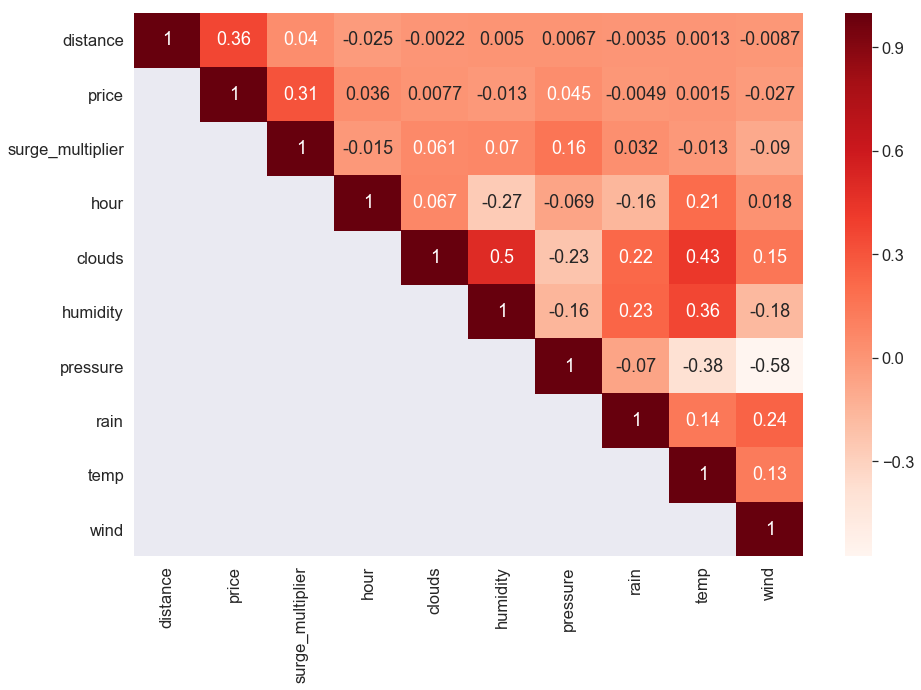

In [1976]:
plt.figure(figsize=(15,10))
corr_m = lyft_data.corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

In [1977]:
corr_m['price'].abs().sort_values(ascending=False)[1:]

distance            0.360826
surge_multiplier    0.307160
pressure            0.045021
hour                0.035598
wind                0.027202
humidity            0.013333
clouds              0.007735
rain                0.004924
temp                0.001478
Name: price, dtype: float64

From the correlation, we can see distance is moderately correlated,           
followed by pressure, hour and wind. (we can ignore surge multiplier, as it leaks info about price.)          
Rain and temperature are not significant.

**Uber**

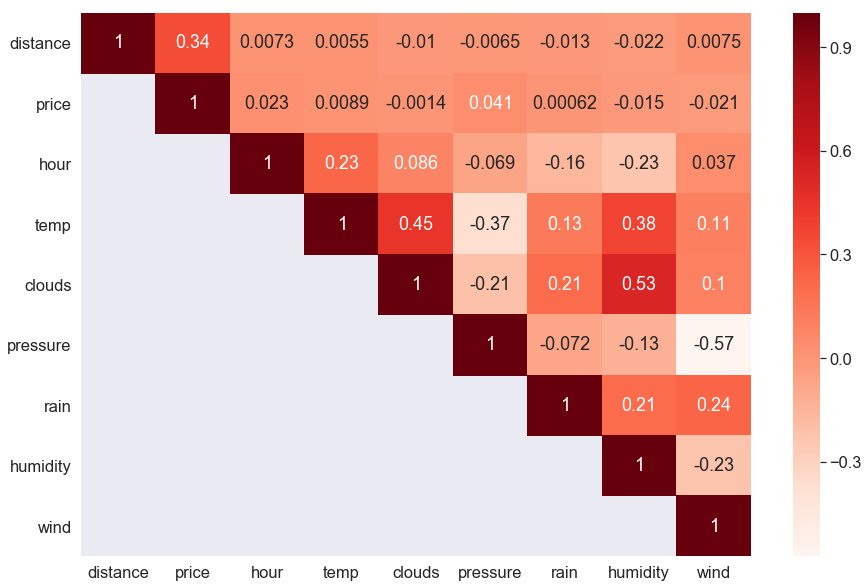

In [1509]:
plt.figure(figsize=(15,10))
corr_m = uber_data[['distance', 'destination', 'source', 'price','name', 'hour', 'temp', 'clouds', 'pressure', 'rain', 'humidity',
       'wind']].corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

In [1510]:
corr_m['price'].abs().sort_values(ascending=False)[1:]

distance    0.338690
pressure    0.041466
hour        0.022840
wind        0.020527
humidity    0.015395
temp        0.008859
clouds      0.001368
rain        0.000625
Name: price, dtype: float64

From the correlation, we can see distance is moderately correlated,           
followed by pressure, hour and wind.          
Rain and clouds are not significant.

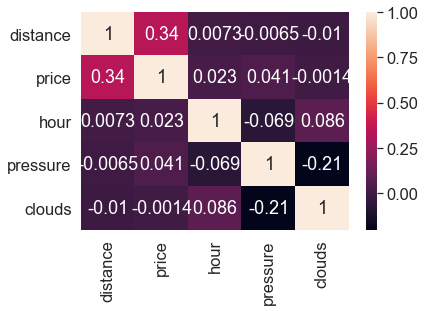

In [1511]:
corr_m = uber_data[['distance', 'destination', 'source', 'price','name', 'hour', 'pressure', 'clouds']].corr()
sns.heatmap(corr_m, annot=True)

In [1512]:
uber1_X = uber_X.copy()
uber1_y = uber_y.copy()

In [1513]:
lyft1_X = lyft_X
lyft1_y = lyft_y

### 2. Backward Elimination

**Uber**

In [1514]:
#Backward Elimination
cols = list(uber1_X.columns)
pmax = 1
counter=0
while (len(cols)>0):
    p= []
    counter+=1

    X_1 = uber1_X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(uber1_y,X_1).fit()
#     print(counter)
#     print(len(pd.Series(model.pvalues.values)))
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
#         print('inside')
        cols.remove(feature_with_p_max)
    else:
        break
    print(feature_with_p_max)
#     print(len(cols))
selected_features_BE = cols
print(selected_features_BE)

C:\Users\gokul\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


wind
['distance', 'hour', 'clouds', 'humidity', 'pressure', 'rain', 'temp', 'Black', 'Black SUV', 'UberPool', 'UberX', 'UberXL', 'WAV', 'src_Back Bay', 'src_Beacon Hill', 'src_Boston University', 'src_Fenway', 'src_Financial District', 'src_Haymarket Square', 'src_North End', 'src_North Station', 'src_Northeastern University', 'src_South Station', 'src_Theatre District', 'src_West End', 'dest_Back Bay', 'dest_Beacon Hill', 'dest_Boston University', 'dest_Fenway', 'dest_Financial District', 'dest_Haymarket Square', 'dest_North End', 'dest_North Station', 'dest_Northeastern University', 'dest_South Station', 'dest_Theatre District', 'dest_West End']


In [1515]:
len(selected_features_BE)

37

In [1516]:
uber2 = uber1_X[selected_features_BE]

In [1517]:
uber2_X = uber2
uber2_y = uber_data['price'].copy()

In [1518]:
x_constant = sm.add_constant(uber2_X)
uber_model = sm.OLS(uber2_y, x_constant).fit()
uber_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 9.767e+04
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:12:33   Log-Likelihood:            -6.0239e+05
No. Observations:              264454   AIC:                         1.205e+06
Df Residuals:                  264420   BIC:                         1.205e+06
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -18.9846      0.294    -64.539      0.000     -19.561     -18.408
distance                         2.5325      0.005    513.228      0.000       2.523       2.542
hour                             0.0223      0.001     29.690      0.000       0.021       0.024
clouds                           0.1207      0.019      6.440      0.000       0.084       0.157
humidity                        -0.5424      0.046    -11.742      0.000      -0.633      -0.452
pressure                         0.0342      0.000     90.661      0.000       0.033       0.035
rain                             2.2657      0.156     14.558      0.000       1.961       2.571
temp                             0.0281      0.001     31.816      0.000       0.026       0.030
Black                            1.5662      0.050     31.270      0.000       1.468       1.664
Black SUV                       11.3281      0.050    226.091      0.000      11.230      11.426
UberPool                       -10.2036      0.050   -203.732      0.000     -10.302     -10.105
UberX                           -9.1996      0.050   -183.649      0.000      -9.298      -9.101
UberXL                          -3.2791      0.050    -65.474      0.000      -3.377      -3.181
WAV                             -9.1966      0.050   -183.620      0.000      -9.295      -9.098
src_Back Bay                    -1.7257      0.029    -60.473      0.000      -1.782      -1.670
src_Beacon Hill                 -1.9291      0.028    -67.729      0.000      -1.985      -1.873
src_Boston University           -1.8303      0.029    -63.226      0.000      -1.887      -1.774
src_Fenway                      -1.7522      0.029    -60.835      0.000      -1.809      -1.696
src_Financial District          -1.2660      0.029    -43.960      0.000      -1.322      -1.210
src_Haymarket Square            -1.1480      0.029    -39.620      0.000      -1.205      -1.091
src_North End                   -1.1055      0.029    -38.552      0.000      -1.162      -1.049
src_North Station               -1.5514      0.029    -54.282      0.000      -1.607      -1.495
src_Northeastern University     -2.0585      0.029    -71.506      0.000      -2.115      -2.002
src_South Station               -1.5576      0.029    -54.318      0.000      -1.614      -1.501
src_Theatre District            -1.4014      0.029    -48.901      0.000      -1.458      -1.345
src_West End                    -1.6590      0.029    -57.878      0.000      -1.715      -1.603
dest_Back Bay                   -1.5654      0.029    -54.818      0.000      -1.621      -1.509
dest_Beacon Hill                -1.8212      0.029    -63.842      0.000      -1.877      -1.765
dest_Boston University          -1.4512      0.029    -50.256      0.000    

**Lyft**

In [1519]:
#Backward Elimination
cols = list(lyft1_X.columns)
pmax = 1
counter=0
while (len(cols)>0):
    p= []
    counter+=1
    X_1 = lyft1_X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(lyft1_y,X_1).fit()
#     print(counter)
#     print(len(pd.Series(model.pvalues.values)))
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
#         print('inside')
        cols.remove(feature_with_p_max)
    else:
        break
    print(feature_with_p_max)
#     print(len(cols))
selected_features_BE = cols
print('\n',selected_features_BE)


 ['distance', 'hour', 'clouds', 'humidity', 'pressure', 'rain', 'temp', 'wind', 'Lux', 'Lux Black', 'Lux Black XL', 'Lyft', 'Lyft XL', 'Shared', 'src_Back Bay', 'src_Beacon Hill', 'src_Boston University', 'src_Fenway', 'src_Financial District', 'src_Haymarket Square', 'src_North End', 'src_North Station', 'src_Northeastern University', 'src_South Station', 'src_Theatre District', 'src_West End', 'dest_Back Bay', 'dest_Beacon Hill', 'dest_Boston University', 'dest_Fenway', 'dest_Financial District', 'dest_Haymarket Square', 'dest_North End', 'dest_North Station', 'dest_Northeastern University', 'dest_South Station', 'dest_Theatre District', 'dest_West End']


In [1520]:
len(selected_features_BE)

38

In [1521]:
lyft2 = lyft1_X[selected_features_BE]

In [1522]:
lyft2_X = lyft2
lyft2_y = lyft_data['price'].copy()

In [1523]:
x_constant = sm.add_constant(lyft2_X)
lyft_model = sm.OLS(lyft2_y, x_constant).fit()
lyft_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 5.529e+04
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:12:37   Log-Likelihood:            -6.5020e+05
No. Observations:              245926   AIC:                         1.300e+06
Df Residuals:                  245891   BIC:                         1.301e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -19.8979      0.562    -35.381      0.000     -21.000     -18.796
distance                         3.4800      0.009    395.572      0.000       3.463       3.497
hour                             0.0668      0.001     59.667      0.000       0.065       0.069
clouds                           0.5742      0.028     20.560      0.000       0.519       0.629
humidity                        -0.7114      0.077     -9.254      0.000      -0.862      -0.561
pressure                         0.0350      0.001     50.018      0.000       0.034       0.036
rain                             2.1123      0.236      8.944      0.000       1.649       2.575
temp                             0.0084      0.001      6.584      0.000       0.006       0.011
wind                            -0.0131      0.003     -4.856      0.000      -0.018      -0.008
Lux                             -2.8896      0.095    -30.417      0.000      -3.076      -2.703
Lux Black                        2.3854      0.095     25.114      0.000       2.199       2.572
Lux Black XL                    11.6588      0.095    122.730      0.000      11.473      11.845
Lyft                           -11.0561      0.095   -116.431      0.000     -11.242     -10.870
Lyft XL                         -5.3589      0.095    -56.425      0.000      -5.545      -5.173
Shared                         -14.6374      0.095   -154.119      0.000     -14.824     -14.451
src_Back Bay                    -1.0109      0.052    -19.577      0.000      -1.112      -0.910
src_Beacon Hill                 -2.0986      0.052    -40.648      0.000      -2.200      -1.997
src_Boston University           -2.0047      0.052    -38.377      0.000      -2.107      -1.902
src_Fenway                      -1.5529      0.052    -29.851      0.000      -1.655      -1.451
src_Financial District          -1.7395      0.052    -33.533      0.000      -1.841      -1.638
src_Haymarket Square            -1.7220      0.053    -32.797      0.000      -1.825      -1.619
src_North End                   -1.5473      0.052    -29.732      0.000      -1.649      -1.445
src_North Station               -2.2483      0.052    -43.392      0.000      -2.350      -2.147
src_Northeastern University     -1.5963      0.052    -30.712      0.000      -1.698      -1.494
src_South Station               -1.3536      0.052    -26.120      0.000      -1.455      -1.252
src_Theatre District            -0.9337      0.052    -17.927      0.000      -1.036      -0.832
src_West End                    -2.0901      0.052    -40.205      0.000      -2.192      -1.988
dest_Back Bay                   -1.7426      0.052    -33.766      0.000      -1.844      -1.641
dest_Beacon Hill                -2.1526      0.052    -41.735      0.000    

### 3. Step Forward Selection

**Uber**

In [1524]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [1525]:
# Build RF classifier to use in feature selection
clf = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(uber1_X, uber1_y, test_size = 0.3, random_state = 0)


# Build step forward feature selection
sfs1 = sfs(clf,k_features = 38,forward=True,
           floating=False, scoring='r2',
           verbose=2,
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

**Lyft**

In [1526]:
# Build RF classifier to use in feature selection
clf = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(lyft1_X, lyft1_y, test_size = 0.3, random_state = 0)


# Build step forward feature selection
sfs1 = sfs(clf,k_features = 38,forward=True,
           floating=False, scoring='r2',
           verbose=2,
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    2.9s finished

[2019-11-17 18:12:46] Features: 1/38 -- score: 0.4464491324554829[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    5.0s finished

[2019-11-17 18:12:52] Features: 2/38 -- score: 0.6042409361423274[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    6.3s finished

[2019-11-17 18:12:58] Features: 3/38 -- score: 0.7342614950199351[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

### 4. Lasso

In [1527]:
from sklearn.linear_model import LassoCV

**Uber**

In [1528]:
reg = LassoCV()
reg.fit(uber1_X, uber1_y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(uber1_X,uber1_y))
coef = pd.Series(reg.coef_, index = uber1_X.columns)
coef

C:\Users\gokul\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha using built-in LassoCV: 0.004676
Best score using built-in LassoCV: 0.924012


distance                         2.506667
hour                             0.023462
clouds                           0.000000
humidity                        -0.000000
pressure                         0.035897
rain                             0.000000
temp                             0.028254
wind                             0.012335
Black                            7.911817
Black SUV                       17.673570
UberPool                        -3.802127
UberX                           -2.798238
UberXL                           3.066471
WAV                             -2.794786
src_Back Bay                    -0.067992
src_Beacon Hill                 -0.276656
src_Boston University           -0.117140
src_Fenway                      -0.047863
src_Financial District           0.299527
src_Haymarket Square             0.400474
src_North End                    0.455894
src_North Station                0.000000
src_Northeastern University     -0.354625
src_South Station                0

In [1529]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 30 variables and eliminated the other 8 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

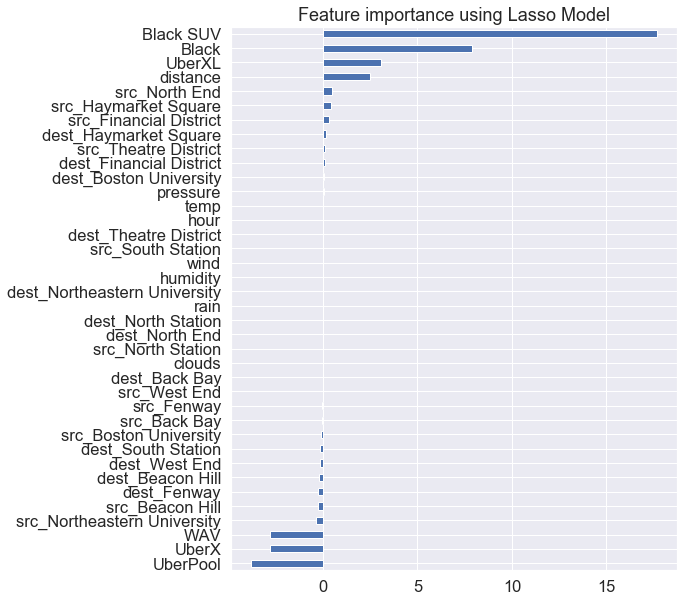

In [1530]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

**Lyft**

In [1531]:
reg = LassoCV()
reg.fit(lyft1_X, lyft1_y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(lyft1_X, lyft1_y))
coef = pd.Series(reg.coef_, index = lyft1_X.columns)
coef

C:\Users\gokul\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha using built-in LassoCV: 0.006131
Best score using built-in LassoCV: 0.884137


distance                         3.435141
hour                             0.069107
clouds                           0.405111
humidity                        -0.000000
pressure                         0.037391
rain                             0.000000
temp                             0.008515
wind                             0.002487
Lux                              2.398850
Lux Black                        7.673111
Lux Black XL                    16.945773
Lyft                            -5.694514
Lyft XL                         -0.000000
Shared                          -9.276686
src_Back Bay                     0.664359
src_Beacon Hill                 -0.266851
src_Boston University           -0.298405
src_Fenway                       0.000000
src_Financial District           0.000000
src_Haymarket Square            -0.102693
src_North End                    0.000000
src_North Station               -0.408174
src_Northeastern University      0.000000
src_South Station                0

In [1532]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 28 variables and eliminated the other 10 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

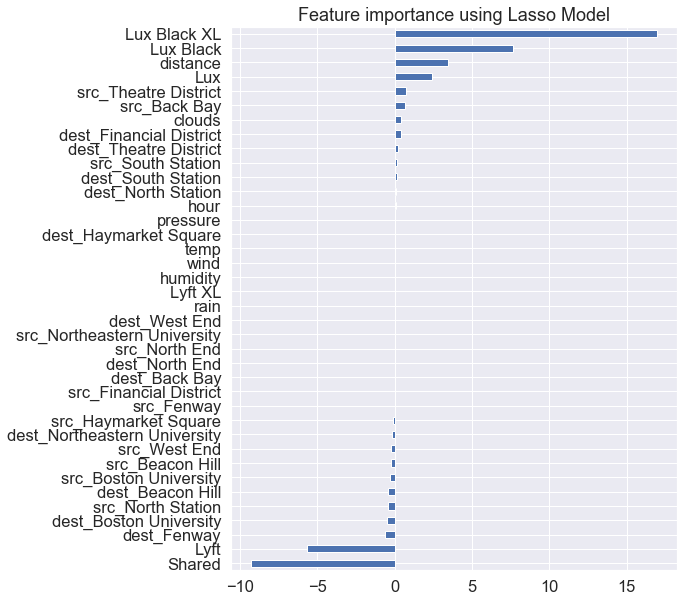

In [1533]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### 5. Using VIF

In [1534]:
## Building of simple OLS model.
X_constant = sm.add_constant(uber1_X)
model = sm.OLS(uber1_y, X_constant).fit()
predictions = model.predict(X_constant)
model.summary()

C:\Users\gokul\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 9.480e+04
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:15:21   Log-Likelihood:            -6.0239e+05
No. Observations:              264454   AIC:                         1.205e+06
Df Residuals:                  264419   BIC:                         1.205e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -18.6876      0.385    -48.548      0.000     -19.442     -17.933
distance                         2.5325      0.005    513.221      0.000       2.523       2.542
hour                             0.0222      0.001     29.396      0.000       0.021       0.024
clouds                           0.1258      0.019      6.545      0.000       0.088       0.164
humidity                        -0.5708      0.052    -10.991      0.000      -0.673      -0.469
pressure                         0.0338      0.000     70.313      0.000       0.033       0.035
rain                             2.3276      0.164     14.191      0.000       2.006       2.649
temp                             0.0280      0.001     31.737      0.000       0.026       0.030
wind                            -0.0022      0.002     -1.196      0.232      -0.006       0.001
Black                            1.6157      0.065     24.869      0.000       1.488       1.743
Black SUV                       11.3776      0.065    175.095      0.000      11.250      11.505
UberPool                       -10.1541      0.065   -156.292      0.000     -10.281     -10.027
UberX                           -9.1501      0.065   -140.830      0.000      -9.277      -9.023
UberXL                          -3.2296      0.065    -49.711      0.000      -3.357      -3.102
WAV                             -9.1471      0.065   -140.792      0.000      -9.274      -9.020
src_Back Bay                    -1.7011      0.035    -48.360      0.000      -1.770      -1.632
src_Beacon Hill                 -1.9044      0.035    -54.116      0.000      -1.973      -1.835
src_Boston University           -1.8058      0.035    -50.928      0.000      -1.875      -1.736
src_Fenway                      -1.7276      0.035    -48.800      0.000      -1.797      -1.658
src_Financial District          -1.2414      0.035    -35.072      0.000      -1.311      -1.172
src_Haymarket Square            -1.1230      0.036    -31.451      0.000      -1.193      -1.053
src_North End                   -1.0806      0.035    -30.500      0.000      -1.150      -1.011
src_North Station               -1.5267      0.035    -43.286      0.000      -1.596      -1.458
src_Northeastern University     -2.0337      0.035    -57.355      0.000      -2.103      -1.964
src_South Station               -1.5329      0.035    -43.411      0.000      -1.602      -1.464
src_Theatre District            -1.3764      0.035    -38.812      0.000      -1.446      -1.307
src_West End                    -1.6340      0.035    -46.087      0.000      -1.704      -1.565
dest_Back Bay                   -1.5408      0.035    -43.775      0.000      -1.610      -1.472
dest_Beacon Hill                -1.7965      0.035    -50.991      0.000    

In [ ]:
### calculating the vif values as multicollinearity exists

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(uber1_X.values, j) for j in range(1, uber1_X.shape[1])]
vif

In [ ]:
# removing collinear variables
# function definition

def calculate_vif(x):
    thresh = 5.0
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, j) for j in range(x.shape[1])]
    for i in range(1,k):
        print("Iteration no.")
        print(i)
        print(vif)
        a = np.argmax(vif)
        print("Max VIF is for variable no.:")
        print(a)
        
        if vif[a] <= thresh :
            break
        if i == 1 :          
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1 :
            output = output.drop(output.columns[a],axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        print(output.columns)
    return(output)

In [ ]:
## passing X to the function so that the multicollinearity gets removed.
train_out = calculate_vif(uber1_X)

In [ ]:
## includes only the relevant features.
train_out.head()

In [ ]:
len(train_out.columns)

**Select Features**

In [1978]:
uber_X = uber_X.drop(['wind', 'humidity', 'temp', 'clouds'], axis=1) #onehot encoded
lyft_X = lyft_X.drop(['wind', 'humidity', 'temp', 'clouds'], axis=1)

In [1979]:
uber_leX = uber_leX.drop(['wind', 'humidity', 'temp', 'clouds'], axis=1) # label encoded
lyft_leX = lyft_leX.drop(['wind', 'humidity', 'temp', 'clouds'], axis=1)

In [1980]:
uber_leX.head()

distance  destination  source  name  hour     pressure      rain
0      2.46            1       3     5     6   997.125000  0.015350
1      1.41           10       6     4     8  1030.210000  0.000000
2      3.31            8       7     3     2   998.042857  0.000857
3      3.30            8       7     2    21  1034.390000  0.000000
4      2.34            0       6     3    10  1021.640000  0.000000

In [1981]:
lyft_leX.head()

distance  destination  source  name  hour  pressure  rain
0      1.68           11       9     3    12   1003.67   0.0
1      0.69            4       9     4     5   1018.85   0.0
2      1.26           10       5     5     4   1001.89   0.0
3      0.71            5       7     4    20    993.25   0.0
4      3.15            2      10     3     7   1005.18   0.0

### Feature transformation

#### Scaling

In [137]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

uber_std = pd.DataFrame(sc.fit_transform(uber_X[['distance', 'hour', 'pressure', 'rain']]), 
                        columns=['distance', 'hour', 'pressure', 'rain'])

lyft_std = pd.DataFrame(sc.fit_transform(lyft_X[['distance', 'hour', 'pressure', 'rain']]),
                        columns=['distance', 'hour', 'pressure', 'rain'])

uber_X = uber_X.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)
lyft_X = lyft_X.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)

uber_X = pd.concat([uber_std, uber_X], axis=1)
lyft_X = pd.concat([lyft_std, lyft_X], axis=1)

### Model Building

In [138]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

### 1. Linear Regression

**Uber** (with weather conditions)

In [139]:
X_trainu, X_testu, y_trainu, y_testu = train_test_split(uber_X, uber_y, test_size=0.3, random_state=42)

In [140]:
lin_reg_uber = LinearRegression()
lin_reg_uber.fit(X_trainu, y_trainu)

# print(f'Train score : {lin_reg_uber.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, lin_reg_uber.predict(X_trainu)))}')
predicted = lin_reg_uber.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

Train RMSE score : 2.3609761096606263
Test score : 2.377850798259172


In [141]:
train_cv = cross_val_score(LinearRegression(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(LinearRegression(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

l_reg_uber = {}
l_reg_uber['Train'] = round(train_rmse, 4)
l_reg_uber['Test'] = round(test_rmse, 4)
l_reg_uber

{'Train': 2.3612, 'Test': 2.3783}

**Lyft** (with weather conditions)

In [142]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split(lyft_X, lyft_y, test_size=0.3, random_state=42)

In [143]:
lin_reg_lyft = LinearRegression()
lin_reg_lyft.fit(X_trainl, y_trainl)

# print(f'Train score : {lin_reg_lyft.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, lin_reg_lyft.predict(X_trainl)))}')
predicted = lin_reg_lyft.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

Train RMSE score : 3.4081796090051704
Test score : 3.407732283446027


In [144]:
train_cv = cross_val_score(LinearRegression(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(LinearRegression(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

l_reg_lyft = {}
l_reg_lyft['Train'] = round(train_rmse, 4)
l_reg_lyft['Test'] = round(test_rmse, 4)
l_reg_lyft

{'Train': 3.4087, 'Test': 3.4084}

### 2. Ridge

**Uber** (with weather conditions)

In [145]:
ridge_reg = Ridge(random_state=42)
ridge_reg.fit(X_trainu, y_trainu)

ridge_reg_predict = ridge_reg.predict(X_testu)

# print(f'Train score : {ridge_reg.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, ridge_reg.predict(X_trainu)))}')
predicted = ridge_reg.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

np.sqrt(np.abs(cross_val_score(Ridge(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')))

Train RMSE score : 2.360976103732664
Test score : 2.3778502548567495


array([2.40777638, 2.38163208, 2.3186362 , 2.3854178 , 2.31207079])

In [146]:
train_cv = cross_val_score(Ridge(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Ridge(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

r_reg_uber = {}
r_reg_uber['Train'] = round(train_rmse, 4)
r_reg_uber['Test'] = round(test_rmse, 4)
r_reg_uber

{'Train': 2.3611, 'Test': 2.3783}

**Hyperparameter Tuning**

In [147]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Ridge(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X_trainu,y_trainu)
grid_search.best_estimator_

Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [148]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, model.predict(X_trainu)))}')
predicted = model.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(model, X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 2.361109608130434
Test score : 2.3780113781835546


**Lyft** (with weather conditions)

In [149]:
ridge_reg = Ridge(random_state=42)
ridge_reg.fit(X_trainl, y_trainl)

ridge_reg_predict = ridge_reg.predict(X_testl)

# print(f'Train score : {ridge_reg.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, ridge_reg.predict(X_trainl)))}')
predicted = ridge_reg.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Ridge(), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 3.4081796841318908
Test score : 3.4077300875801524


In [150]:
train_cv = cross_val_score(Ridge(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Ridge(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

r_reg_lyft = {}
r_reg_lyft['Train'] = round(train_rmse, 4)
r_reg_lyft['Test'] = round(test_rmse, 4)
r_reg_lyft

{'Train': 3.4087, 'Test': 3.4084}

**Hyperparameter Tuning**

In [151]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Ridge(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X_trainl,y_trainl)
grid_search.best_estimator_

Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [152]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, model.predict(X_trainl)))}')
predicted = model.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(model, X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 3.4083171245273203
Test score : 3.407910559056293


### 3. Lasso

**Uber** (with weather conditions)

In [153]:
lasso_reg = Lasso(random_state=42)
lasso_reg.fit(X_trainu, y_trainu)

lasso_reg_predict = lasso_reg.predict(X_testu)

# print(f'Train score : {lasso_reg.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, lasso_reg.predict(X_trainu)))}')
predicted = lasso_reg.predict(X_testu)
# print(np.sqrt(mean_squared_error(y_trainu, lasso_reg.predict(X_trainu))))
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Lasso(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 5.464162245834651
Test score : 5.480790536435233


In [154]:
train_cv = cross_val_score(Lasso(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Lasso(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

la_reg_uber = {}
la_reg_uber['Train'] = round(train_rmse, 4)
la_reg_uber['Test'] = round(test_rmse, 4)
la_reg_uber

{'Train': 5.4642, 'Test': 5.4697}

**Hyperparameter Tuning**

In [155]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Lasso(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X_trainu,y_trainu)
grid_search.best_estimator_

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [156]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, model.predict(X_trainu)))}')
predicted = model.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(model, X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 5.464162245834651
Test score : 5.480790536435233


**Lyft** (with weather conditions)

In [157]:
lasso_reg = Lasso(random_state=42)
lasso_reg.fit(X_trainl, y_trainl)

# print(f'Train score : {lasso_reg.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, lasso_reg.predict(X_trainl)))}')
predicted = lasso_reg.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Lasso(random_state=42), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 6.149852709839745
Test score : 6.145297680239538


In [158]:
train_cv = cross_val_score(Lasso(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Lasso(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

la_reg_lyft = {}
la_reg_lyft['Train'] = round(train_rmse, 4)
la_reg_lyft['Test'] = round(test_rmse, 4)
la_reg_lyft

{'Train': 6.15, 'Test': 6.1492}

**HyperParameter Tuning**

In [ ]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Lasso(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X_trainl,y_trainl)
grid_search.best_estimator_

In [ ]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, model.predict(X_trainl)))}')
predicted = model.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

np.sqrt(np.abs(cross_val_score(model, X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_absolute_error')))

### 4. Elastic Net

**Uber** (with weather conditions)

In [160]:
elastic_reg = ElasticNet(random_state=42)
elastic_reg.fit(X_trainu, y_trainu)

elastic_reg_predict = elastic_reg.predict(X_testu)

# print(f'Train score : {elastic_reg.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, elastic_reg.predict(X_trainu)))}')
predicted = elastic_reg.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(ElasticNet(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 6.959696273451115
Test score : 6.979297663958905


In [161]:
train_cv = cross_val_score(ElasticNet(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(ElasticNet(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

el_reg_uber = {}
el_reg_uber['Train'] = round(train_rmse, 4)
el_reg_uber['Test'] = round(test_rmse, 4)
el_reg_uber

{'Train': 6.9598, 'Test': 6.9721}

**Hyperparameter Tuning**

In [ ]:
# parametersGrid = {"alpha": [ 0.001, 0.01, 0.1, 1, 10, 100],
#                   "l1_ratio": np.arange(0.2, 1.0, 0.1)}
params={'alpha':lambdas}

grid_search=GridSearchCV(ElasticNet(),param_grid=params,cv=10,scoring='r2')
grid_search.fit(X_trainu,y_trainu)
grid_search.best_estimator_

In [ ]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, model.predict(X_trainu)))}')
predicted = model.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cross_val_score(model, X_trainu, y_trainu, cv=5, n_jobs=-1)

**Lyft** (with weather conditions)

In [162]:
elastic_reg = ElasticNet(random_state=42)
elastic_reg.fit(X_trainl, y_trainl)

elastic_reg_predict = elastic_reg.predict(X_testl)

# print(f'Train score : {elastic_reg.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, elastic_reg.predict(X_trainl)))}')
predicted = elastic_reg.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cross_val_score(ElasticNet(), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 8.05438386633362
Test score : 8.065687636553081


array([0.35008142, 0.35176404, 0.3516793 , 0.35216083, 0.35148703])

In [163]:
train_cv = cross_val_score(ElasticNet(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(ElasticNet(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

el_reg_lyft = {}
el_reg_lyft['Train'] = round(train_rmse, 4)
el_reg_lyft['Test'] = round(test_rmse, 4)
el_reg_lyft

{'Train': 8.0544, 'Test': 8.0569}

**HyperParameterTuning**

In [ ]:
# parametersGrid = {"alpha": [ 0.001, 0.01, 0.1, 1, 10, 100],
#                   "l1_ratio": np.arange(0.2, 1.0, 0.1)}
params={'alpha':lambdas}

grid_search=GridSearchCV(ElasticNet(),param_grid=params,cv=10,scoring='r2')
grid_search.fit(X_trainl,y_trainl)
grid_search.best_estimator_

In [ ]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, model.predict(X_trainl)))}')
predicted = model.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(model, X_trainl, y_trainl, cv=5, n_jobs=-1)

### 5. KNN

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

**Uber**

In [ ]:
# knn = KNeighborsRegressor()

# knn.fit(X_trainu, y_trainu)

# train_pred = knn.predict(X_trainu)

# tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
# print(f'Train score : {tr_rmse}')
# predicted = knn.predict(X_testu)
# rmse = np.sqrt(mean_squared_error(y_testu, predicted))
# print(f'Test score : {rmse}')

# cross_val_score(KNeighborsRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1)

**Lyft**

In [ ]:
# knn = KNeighborsRegressor()

# knn.fit(X_trainl, y_trainl)

# knn = knn.predict(X_testl)

# print(f'Train score : {knn.score(X_trainl, y_trainl)}')
# predicted = knn.predict(X_testl)
# rmse = np.sqrt(mean_squared_error(y_testl, predicted))
# print(f'Test score : {rmse}')

# cross_val_score(KNeighborsRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1)

**KNN taking long time, so dropping the model.**

### 5. Decision Tree

In [164]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve

**Uber**

In [1982]:
X_trainu, X_testu, y_trainu, y_testu = train_test_split(uber_leX, uber_ley, test_size=0.3, random_state=42)

In [1983]:
dtree = DecisionTreeRegressor()

dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train score : 0.5684281404997369
Test score : 1.6477721032154846


array([0.96077196, 0.95842358, 0.96044385, 0.96106987, 0.96177192])

In [1984]:
max_depth = range(1,20)
train_results = []
test_results = []
for n in max_depth:
    dt = DecisionTreeRegressor(max_depth=n)
    dt.fit(X_trainu, y_trainu)
    train_pred = dt.predict(X_trainu)
    rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
    train_results.append(rmse)
    y_pred = dt.predict(X_testu)
    ts_rmse = np.sqrt(mean_squared_error(y_testu, y_pred))
    test_results.append(ts_rmse)

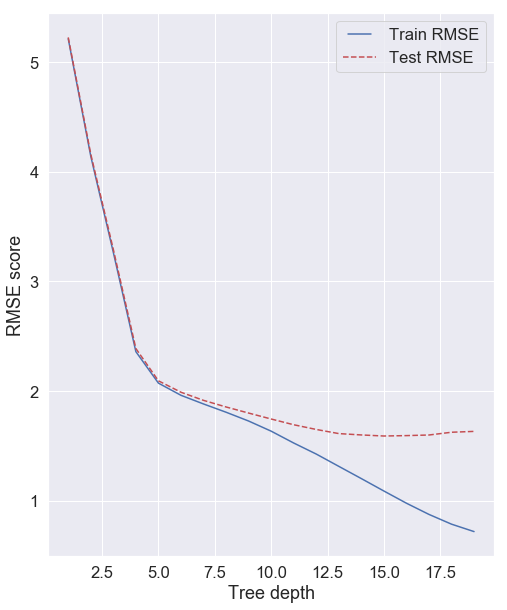

In [1985]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depth, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depth, test_results, 'r--', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('Tree depth')
plt.show()

Let's choose 15 as max depth

In [1986]:
dtree = DecisionTreeRegressor(max_depth=15)

dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train score : 1.0880395376247955
Test score : 1.5833659232297672


In [1987]:
train_cv = cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(DecisionTreeRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

dt_reg_uber = {}
dt_reg_uber['Train'] = round(train_rmse, 4)
dt_reg_uber['Test'] = round(test_rmse, 4)
dt_reg_uber

{'Train': 1.7006, 'Test': 1.9661}

**Lyft**

In [1989]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split(lyft_leX, lyft_ley, test_size=0.3, random_state=42)

In [1990]:
dtree = DecisionTreeRegressor(max_depth=15)

dtree.fit(X_trainl, y_trainl)

train_pred = dtree.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train score : 1.6505630957136392
Test score : 2.664406721933393


In [1991]:
train_cv = cross_val_score(DecisionTreeRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(DecisionTreeRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

dt_reg_lyft = {}
dt_reg_lyft['Train'] = round(train_rmse, 4)
dt_reg_lyft['Test'] = round(test_rmse, 4)
dt_reg_lyft

{'Train': 2.9829, 'Test': 3.3157}

**HyperParameter tuning**

In [ ]:
param_grid = {'max_depth': np.arange(3, 30),
             'min_samples_split': np.arange(.1,1.1,.1),
             'min_samples_leaf': np.arange(.1,.6,.1)}

In [ ]:
grid_srch_dtree = tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
grid_srch_dtree.fit(X_trainu, y_trainu)
grid_srch_dtree.best_estimator_

### 6. Random Forest

In [174]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.cross

In [1992]:
rf = RandomForestRegressor()
rf.fit(X_trainu, y_trainu)

train_pred = rf.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = rf.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(RandomForestRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\gokul\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train score : 0.7409353223082231
Test score : 1.393091910916908
[1.44005863 1.4471492  1.40270669 1.45192368 1.37614436]


In [1993]:
train_cv = cross_val_score(RandomForestRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(RandomForestRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

rf_reg_uber = {}
rf_reg_uber['Train'] = round(train_rmse, 4)
rf_reg_uber['Test'] = round(test_rmse, 4)
rf_reg_uber

{'Train': 1.423, 'Test': 1.5769}

**Hyper Parameter Tuning**

In [ ]:
param_grid = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'max_features' : list(range(1,X_trainu.shape[1])),
              'max_depth': np.arange(3, 30),
             'min_samples_split': np.arange(.1,1.1,.1),
             'min_samples_leaf': np.arange(.1,.6,.1)}

In [ ]:
grid_srch_rf = tree = GridSearchCV(RandomForestRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
grid_srch_rf.fit(X_trainu, y_trainu)
grid_srch_rf.best_estimator_

In [1994]:
rf = RandomForestRegressor()
rf.fit(X_trainl, y_trainl)

train_pred = rf.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = rf.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(RandomForestRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\gokul\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train score : 1.2099745056182545
Test score : 2.3693293589037077
[2.46153291 2.49284955 2.44848945 2.41190071 2.42680192]


In [1995]:
train_cv = cross_val_score(RandomForestRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(RandomForestRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

rf_reg_lyft = {}
rf_reg_lyft['Train'] = round(train_rmse, 4)
rf_reg_lyft['Test'] = round(test_rmse, 4)
rf_reg_lyft

{'Train': 2.4492, 'Test': 2.6183}

### 7. Boosting

**Ada Boost**

In [178]:
from sklearn.ensemble import AdaBoostRegressor

In [1259]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_trainu, y_trainu)

train_pred = abr.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = abr.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(AdaBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 5.801814617682737
Test score : 5.818091938789842
[5.5122542  5.69288263 5.34465297 5.32064093 5.70734424]


In [1260]:
train_cv = cross_val_score(AdaBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(AdaBoostRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

abr_reg_uber = {}
abr_reg_uber['Train'] = round(train_rmse, 4)
abr_reg_uber['Test'] = round(test_rmse, 4)
abr_reg_uber

{'Train': 5.5402, 'Test': 5.5358}

In [1261]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_trainl, y_trainl)

train_pred = abr.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = abr.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(AdaBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 5.950612179138436
Test score : 5.990572223255693
[5.93783734 6.12187474 6.80978001 6.68469601 6.58685351]


In [1262]:
train_cv = cross_val_score(AdaBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(AdaBoostRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

abr_reg_lyft = {}
abr_reg_lyft['Train'] = round(train_rmse, 4)
abr_reg_lyft['Test'] = round(test_rmse, 4)
abr_reg_lyft

{'Train': 5.9007, 'Test': 5.5681}

**Gradient Boosting**

In [183]:
from sklearn.ensemble import GradientBoostingRegressor

**Uber**

In [1996]:
X_trainu.head()

distance  destination  source  name  hour    pressure    rain
37054       0.99            4       5     4    16  1018.92000  0.0080
129011      1.25            5       4     5     9  1000.08000  0.0000
255934      1.41           10       6     3    14   991.75000  0.0000
164678      1.56            0       2     2     8  1001.11000  0.0000
79155       2.33            6       0     4     0  1006.03625  0.1569

In [1997]:
gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_trainu, y_trainu)

train_pred = gbr.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = gbr.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(GradientBoostingRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 1.8112309370045312
Test score : 1.8385149477069842
[1.85530173 1.84963684 1.77497461 1.83804905 1.74627353]


In [1998]:
train_cv = cross_val_score(GradientBoostingRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(GradientBoostingRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

gbr_reg_uber = {}
gbr_reg_uber['Train'] = round(train_rmse, 4)
gbr_reg_uber['Test'] = round(test_rmse, 4)
gbr_reg_uber

{'Train': 1.8128, 'Test': 1.8386}

**Lyft**

In [1999]:
gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_trainl, y_trainl)

train_pred = gbr.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = gbr.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(GradientBoostingRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 2.796350149743055
Test score : 2.809142078335918
[2.79864226 2.85381168 2.80264815 2.73051397 2.80779499]


In [2000]:
train_cv = cross_val_score(GradientBoostingRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(GradientBoostingRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

gbr_reg_lyft = {}
gbr_reg_lyft['Train'] = round(train_rmse, 4)
gbr_reg_lyft['Test'] = round(test_rmse, 4)
gbr_reg_lyft

{'Train': 2.7987, 'Test': 2.8128}

**Xg Boosting**

In [188]:
from xgboost import XGBRegressor

**Uber**

In [2001]:
xbr = XGBRegressor(random_state=42)

xbr.fit(X_trainu, y_trainu)

train_pred = xbr.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = xbr.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(XGBRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\gokul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:06:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train score : 1.801719452924508
Test score : 1.8286004832407086
[1.8586963  1.84596709 1.76502341 1.83581353 1.75849327]


In [2002]:
train_cv = cross_val_score(XGBRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(XGBRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

xbr_reg_uber = {}
xbr_reg_uber['Train'] = round(train_rmse, 4)
xbr_reg_uber['Test'] = round(test_rmse, 4)
xbr_reg_uber

{'Train': 1.8128, 'Test': 1.8389}

**Lyft**

In [2003]:
xbr = XGBRegressor(random_state=42)

xbr.fit(X_trainl, y_trainl)

train_pred = xbr.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = xbr.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(XGBRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\gokul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:07:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train score : 2.788957348869898
Test score : 2.8034948574341185
[2.79595571 2.84916699 2.80231315 2.73141629 2.80647778]


In [2004]:
train_cv = cross_val_score(XGBRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(XGBRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

xbr_reg_lyft = {}
xbr_reg_lyft['Train'] = round(train_rmse, 4)
xbr_reg_lyft['Test'] = round(test_rmse, 4)
xbr_reg_lyft

{'Train': 2.7971, 'Test': 2.8139}

**Cat Boost**

In [193]:
from catboost import CatBoostRegressor

**Uber**

In [2005]:
X_trainu.head()

distance  destination  source  name  hour    pressure    rain
37054       0.99            4       5     4    16  1018.92000  0.0080
129011      1.25            5       4     5     9  1000.08000  0.0000
255934      1.41           10       6     3    14   991.75000  0.0000
164678      1.56            0       2     2     8  1001.11000  0.0000
79155       2.33            6       0     4     0  1006.03625  0.1569

In [2046]:
cbr_uber = CatBoostRegressor(random_state=42, verbose=400)

cbr_uber.fit(X_trainu, y_trainu)

train_pred = cbr_uber.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = cbr_uber.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cv = cross_val_score(CatBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
# print(np.sqrt(np.abs(cv)))

0:	learn: 8.3291919	total: 19.1ms	remaining: 19.1s
400:	learn: 1.6511471	total: 6.92s	remaining: 10.3s
800:	learn: 1.5282214	total: 13.6s	remaining: 3.39s
999:	learn: 1.4933252	total: 17s	remaining: 0us
Train score : 1.493325160314029
Test score : 1.5274406845672879


In [2007]:
train_cv = cross_val_score(CatBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(CatBoostRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

cbr_reg_uber = {}
cbr_reg_uber['Train'] = round(train_rmse, 4)
cbr_reg_uber['Test'] = round(test_rmse, 4)
cbr_reg_uber

C:\Users\gokul\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'Train': 1.5113, 'Test': 1.5421}

**Hyper Parameter Tuning**

In [ ]:
param_grid = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'learning_rate': np.arange(0.05, 0.31, 0.05),
              'max_depth': np.arange(3, 20),
             'colsample_bylevel':  np.arange(0.3, 0.8, 0.1),
              'eval_metric': 'RMSE'}

In [ ]:
grid_srch_rf = tree = GridSearchCV(CatBoostRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
grid_srch_rf.fit(X_trainu, y_trainu)
grid_srch_rf.best_estimator_

**Lyft**

In [2036]:
cbr_lyft = CatBoostRegressor(random_state=42, verbose=400)

cbr_lyft.fit(X_trainl, y_trainl)

train_pred = cbr.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = cbr.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cv = cross_val_score(CatBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
# print(np.sqrt(np.abs(cv)))

0:	learn: 9.7474076	total: 32.7ms	remaining: 32.7s
400:	learn: 2.5090385	total: 7.12s	remaining: 10.6s
800:	learn: 2.3249138	total: 13.9s	remaining: 3.46s
999:	learn: 2.2762320	total: 17.2s	remaining: 0us
Train score : 2.2762320000838336
Test score : 2.3084269551373344


In [2009]:
train_cv = cross_val_score(CatBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(CatBoostRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

cbr_reg_lyft = {}
cbr_reg_lyft['Train'] = round(train_rmse, 4)
cbr_reg_lyft['Test'] = round(test_rmse, 4)
cbr_reg_lyft

{'Train': 2.3137, 'Test': 2.3504}

**Hyper Parameter Tuning**

In [ ]:
param_grid = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'learning_rate': np.arange(0.05, 0.31, 0.05),
              'max_depth': np.arange(3, 20),
             'colsample_bylevel':  np.arange(0.3, 0.8, 0.1),
              'eval_metric': 'RMSE'}

In [2060]:
param_grid = {'n_estimators': [100],
              'learning_rate': np.arange(0.05, 0.31, 0.5),
              'max_depth': np.arange(3, 15),
             'colsample_bylevel':  np.arange(0.3, 0.8, 0.2),
              'eval_metric': ['RMSE']}

In [ ]:
grid_srch_rf = tree = GridSearchCV(CatBoostRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
grid_srch_rf.fit(X_trainl, y_trainl)
grid_srch_rf.best_estimator_

0:	learn: 9.9398489	total: 13.9ms	remaining: 1.38s
1:	learn: 9.8961266	total: 24.9ms	remaining: 1.22s
2:	learn: 9.8870481	total: 35ms	remaining: 1.13s
3:	learn: 9.8495112	total: 45.8ms	remaining: 1.1s
4:	learn: 9.8047184	total: 56.2ms	remaining: 1.07s
5:	learn: 9.7663380	total: 68.3ms	remaining: 1.07s
6:	learn: 9.5151789	total: 81.5ms	remaining: 1.08s
7:	learn: 9.5109014	total: 91ms	remaining: 1.05s
8:	learn: 9.2433321	total: 101ms	remaining: 1.02s
9:	learn: 8.9959886	total: 111ms	remaining: 1s
10:	learn: 8.7968079	total: 122ms	remaining: 986ms
11:	learn: 8.7950808	total: 132ms	remaining: 966ms
12:	learn: 8.5782513	total: 142ms	remaining: 949ms
13:	learn: 8.3776387	total: 152ms	remaining: 936ms
14:	learn: 8.0997974	total: 163ms	remaining: 921ms
15:	learn: 8.0982410	total: 172ms	remaining: 906ms
16:	learn: 7.8630374	total: 183ms	remaining: 892ms
17:	learn: 7.7216308	total: 193ms	remaining: 880ms
18:	learn: 7.5667907	total: 203ms	remaining: 866ms
19:	learn: 7.5635152	total: 348ms	remaini

63:	learn: 5.1042389	total: 739ms	remaining: 416ms
64:	learn: 5.0711208	total: 753ms	remaining: 406ms
65:	learn: 5.0477065	total: 764ms	remaining: 393ms
66:	learn: 4.9726934	total: 774ms	remaining: 381ms
67:	learn: 4.9726934	total: 781ms	remaining: 367ms
68:	learn: 4.9726934	total: 788ms	remaining: 354ms
69:	learn: 4.9679744	total: 799ms	remaining: 342ms
70:	learn: 4.9672967	total: 808ms	remaining: 330ms
71:	learn: 4.9490923	total: 820ms	remaining: 319ms
72:	learn: 4.9063277	total: 831ms	remaining: 307ms
73:	learn: 4.8918286	total: 842ms	remaining: 296ms
74:	learn: 4.8731259	total: 854ms	remaining: 285ms
75:	learn: 4.8730764	total: 865ms	remaining: 273ms
76:	learn: 4.8418363	total: 877ms	remaining: 262ms
77:	learn: 4.8060518	total: 888ms	remaining: 250ms
78:	learn: 4.8052423	total: 901ms	remaining: 239ms
79:	learn: 4.7866870	total: 912ms	remaining: 228ms
80:	learn: 4.7712109	total: 922ms	remaining: 216ms
81:	learn: 4.7712109	total: 932ms	remaining: 204ms
82:	learn: 4.7596980	total: 943

34:	learn: 6.2421151	total: 379ms	remaining: 703ms
35:	learn: 6.1632375	total: 392ms	remaining: 697ms
36:	learn: 6.1131291	total: 404ms	remaining: 688ms
37:	learn: 6.0627409	total: 415ms	remaining: 677ms
38:	learn: 6.0593077	total: 424ms	remaining: 663ms
39:	learn: 6.0349863	total: 436ms	remaining: 654ms
40:	learn: 5.9373810	total: 448ms	remaining: 644ms
41:	learn: 5.8926077	total: 458ms	remaining: 632ms
42:	learn: 5.7763443	total: 468ms	remaining: 621ms
43:	learn: 5.7753865	total: 477ms	remaining: 607ms
44:	learn: 5.7171681	total: 488ms	remaining: 597ms
45:	learn: 5.6605928	total: 498ms	remaining: 585ms
46:	learn: 5.5933452	total: 508ms	remaining: 573ms
47:	learn: 5.5903174	total: 518ms	remaining: 561ms
48:	learn: 5.5564229	total: 529ms	remaining: 550ms
49:	learn: 5.5261687	total: 539ms	remaining: 539ms
50:	learn: 5.5091807	total: 547ms	remaining: 526ms
51:	learn: 5.4468780	total: 560ms	remaining: 517ms
52:	learn: 5.3353116	total: 571ms	remaining: 506ms
53:	learn: 5.3206355	total: 581

0:	learn: 9.9382461	total: 14.8ms	remaining: 1.47s
1:	learn: 9.8949171	total: 25.2ms	remaining: 1.23s
2:	learn: 9.8862059	total: 36.4ms	remaining: 1.18s
3:	learn: 9.8469035	total: 48.4ms	remaining: 1.16s
4:	learn: 9.8053483	total: 59.7ms	remaining: 1.13s
5:	learn: 9.7640588	total: 71.2ms	remaining: 1.11s
6:	learn: 9.5130805	total: 83.2ms	remaining: 1.1s
7:	learn: 9.5090338	total: 92.6ms	remaining: 1.06s
8:	learn: 9.2414675	total: 103ms	remaining: 1.04s
9:	learn: 8.9947137	total: 115ms	remaining: 1.03s
10:	learn: 8.7956994	total: 126ms	remaining: 1.02s
11:	learn: 8.7940296	total: 136ms	remaining: 999ms
12:	learn: 8.5766900	total: 148ms	remaining: 994ms
13:	learn: 8.3756567	total: 159ms	remaining: 978ms
14:	learn: 8.0957970	total: 170ms	remaining: 962ms
15:	learn: 8.0943158	total: 181ms	remaining: 950ms
16:	learn: 7.8586792	total: 193ms	remaining: 941ms
17:	learn: 7.7173884	total: 204ms	remaining: 931ms
18:	learn: 7.5634132	total: 217ms	remaining: 924ms
19:	learn: 7.5596385	total: 226ms	

61:	learn: 5.1199925	total: 747ms	remaining: 458ms
62:	learn: 5.1160971	total: 758ms	remaining: 445ms
63:	learn: 5.1160971	total: 765ms	remaining: 430ms
64:	learn: 5.0827042	total: 776ms	remaining: 418ms
65:	learn: 5.0599493	total: 787ms	remaining: 406ms
66:	learn: 4.9849346	total: 798ms	remaining: 393ms
67:	learn: 4.9849346	total: 805ms	remaining: 379ms
68:	learn: 4.9849346	total: 812ms	remaining: 365ms
69:	learn: 4.9805721	total: 822ms	remaining: 352ms
70:	learn: 4.9797580	total: 833ms	remaining: 340ms
71:	learn: 4.9615473	total: 843ms	remaining: 328ms
72:	learn: 4.9188188	total: 856ms	remaining: 316ms
73:	learn: 4.9037634	total: 870ms	remaining: 306ms
74:	learn: 4.8850162	total: 883ms	remaining: 294ms
75:	learn: 4.8849609	total: 894ms	remaining: 282ms
76:	learn: 4.8530929	total: 905ms	remaining: 270ms
77:	learn: 4.8168172	total: 919ms	remaining: 259ms
78:	learn: 4.8160659	total: 931ms	remaining: 247ms
79:	learn: 4.7981789	total: 944ms	remaining: 236ms
80:	learn: 4.7826000	total: 956

33:	learn: 6.2692847	total: 389ms	remaining: 755ms
34:	learn: 6.1867000	total: 409ms	remaining: 760ms
35:	learn: 6.1325383	total: 423ms	remaining: 752ms
36:	learn: 6.0580430	total: 436ms	remaining: 743ms
37:	learn: 6.0117922	total: 448ms	remaining: 730ms
38:	learn: 5.9671040	total: 458ms	remaining: 716ms
39:	learn: 5.9653075	total: 467ms	remaining: 701ms
40:	learn: 5.9382876	total: 480ms	remaining: 691ms
41:	learn: 5.8035522	total: 491ms	remaining: 678ms
42:	learn: 5.7652877	total: 501ms	remaining: 664ms
43:	learn: 5.6640413	total: 514ms	remaining: 654ms
44:	learn: 5.6630159	total: 523ms	remaining: 639ms
45:	learn: 5.6038420	total: 535ms	remaining: 629ms
46:	learn: 5.5503663	total: 552ms	remaining: 623ms
47:	learn: 5.4592210	total: 565ms	remaining: 612ms
48:	learn: 5.4562782	total: 579ms	remaining: 602ms
49:	learn: 5.4265249	total: 592ms	remaining: 592ms
50:	learn: 5.4002497	total: 605ms	remaining: 581ms
51:	learn: 5.3804197	total: 616ms	remaining: 569ms
52:	learn: 5.3220660	total: 627

0:	learn: 9.6873183	total: 13.5ms	remaining: 1.33s
1:	learn: 9.4083021	total: 26.9ms	remaining: 1.31s
2:	learn: 9.3695514	total: 36ms	remaining: 1.16s
3:	learn: 9.0694496	total: 49.4ms	remaining: 1.19s
4:	learn: 8.7248851	total: 63.1ms	remaining: 1.2s
5:	learn: 8.5335860	total: 75.3ms	remaining: 1.18s
6:	learn: 8.5335860	total: 82.8ms	remaining: 1.1s
7:	learn: 8.2869204	total: 95.2ms	remaining: 1.09s
8:	learn: 8.1178130	total: 107ms	remaining: 1.08s
9:	learn: 7.9282201	total: 117ms	remaining: 1.06s
10:	learn: 7.6798514	total: 132ms	remaining: 1.07s
11:	learn: 7.5134070	total: 144ms	remaining: 1.06s
12:	learn: 7.2905036	total: 156ms	remaining: 1.04s
13:	learn: 7.1784304	total: 167ms	remaining: 1.03s
14:	learn: 7.0270889	total: 179ms	remaining: 1.01s
15:	learn: 6.9930712	total: 191ms	remaining: 1s
16:	learn: 6.8325233	total: 203ms	remaining: 991ms
17:	learn: 6.8302966	total: 213ms	remaining: 969ms
18:	learn: 6.7388805	total: 226ms	remaining: 965ms
19:	learn: 6.6989889	total: 240ms	remain

62:	learn: 4.7575957	total: 741ms	remaining: 435ms
63:	learn: 4.6788748	total: 757ms	remaining: 426ms
64:	learn: 4.6643509	total: 770ms	remaining: 414ms
65:	learn: 4.6230159	total: 784ms	remaining: 404ms
66:	learn: 4.6127954	total: 796ms	remaining: 392ms
67:	learn: 4.5787319	total: 808ms	remaining: 380ms
68:	learn: 4.5617030	total: 819ms	remaining: 368ms
69:	learn: 4.5083150	total: 829ms	remaining: 355ms
70:	learn: 4.4785395	total: 841ms	remaining: 343ms
71:	learn: 4.4354090	total: 852ms	remaining: 331ms
72:	learn: 4.4354090	total: 860ms	remaining: 318ms
73:	learn: 4.4159358	total: 872ms	remaining: 306ms
74:	learn: 4.3929032	total: 886ms	remaining: 295ms
75:	learn: 4.3473890	total: 900ms	remaining: 284ms
76:	learn: 4.3407799	total: 914ms	remaining: 273ms
77:	learn: 4.2813547	total: 931ms	remaining: 263ms
78:	learn: 4.2813547	total: 940ms	remaining: 250ms
79:	learn: 4.2427810	total: 958ms	remaining: 239ms
80:	learn: 4.1940648	total: 973ms	remaining: 228ms
81:	learn: 4.1940648	total: 981

32:	learn: 5.8579590	total: 387ms	remaining: 785ms
33:	learn: 5.8363000	total: 398ms	remaining: 773ms
34:	learn: 5.7025575	total: 411ms	remaining: 764ms
35:	learn: 5.6353007	total: 423ms	remaining: 753ms
36:	learn: 5.5838375	total: 435ms	remaining: 741ms
37:	learn: 5.5838375	total: 442ms	remaining: 722ms
38:	learn: 5.5828387	total: 451ms	remaining: 706ms
39:	learn: 5.4513749	total: 464ms	remaining: 696ms
40:	learn: 5.3547711	total: 477ms	remaining: 687ms
41:	learn: 5.3381730	total: 489ms	remaining: 676ms
42:	learn: 5.2837883	total: 501ms	remaining: 664ms
43:	learn: 5.2623796	total: 514ms	remaining: 654ms
44:	learn: 5.2588304	total: 526ms	remaining: 643ms
45:	learn: 5.2567320	total: 536ms	remaining: 629ms
46:	learn: 5.2063224	total: 550ms	remaining: 620ms
47:	learn: 5.1728572	total: 561ms	remaining: 608ms
48:	learn: 5.1145120	total: 576ms	remaining: 600ms
49:	learn: 5.0823005	total: 589ms	remaining: 589ms
50:	learn: 5.0641351	total: 603ms	remaining: 580ms
51:	learn: 5.0337954	total: 617

95:	learn: 3.9636131	total: 1.11s	remaining: 46.2ms
96:	learn: 3.9520912	total: 1.12s	remaining: 34.8ms
97:	learn: 3.9414768	total: 1.14s	remaining: 23.2ms
98:	learn: 3.9369444	total: 1.15s	remaining: 11.6ms
99:	learn: 3.9369444	total: 1.16s	remaining: 0us
0:	learn: 9.6855675	total: 16.1ms	remaining: 1.59s
1:	learn: 9.4062425	total: 31.8ms	remaining: 1.55s
2:	learn: 9.3680100	total: 42.3ms	remaining: 1.37s
3:	learn: 9.0677798	total: 55.2ms	remaining: 1.32s
4:	learn: 8.7234753	total: 68.1ms	remaining: 1.29s
5:	learn: 8.5327954	total: 80.9ms	remaining: 1.27s
6:	learn: 8.5327954	total: 89ms	remaining: 1.18s
7:	learn: 8.2858230	total: 99.4ms	remaining: 1.14s
8:	learn: 8.1172730	total: 113ms	remaining: 1.15s
9:	learn: 7.9281438	total: 124ms	remaining: 1.11s
10:	learn: 7.6799989	total: 136ms	remaining: 1.1s
11:	learn: 7.5129354	total: 150ms	remaining: 1.1s
12:	learn: 7.2898605	total: 179ms	remaining: 1.2s
13:	learn: 7.1779725	total: 197ms	remaining: 1.21s
14:	learn: 7.0272019	total: 222ms	re

68:	learn: 4.5402502	total: 752ms	remaining: 338ms
69:	learn: 4.4874931	total: 761ms	remaining: 326ms
70:	learn: 4.4581317	total: 773ms	remaining: 316ms
71:	learn: 4.3953047	total: 784ms	remaining: 305ms
72:	learn: 4.3953047	total: 791ms	remaining: 293ms
73:	learn: 4.3748825	total: 803ms	remaining: 282ms
74:	learn: 4.3536032	total: 816ms	remaining: 272ms
75:	learn: 4.3089692	total: 828ms	remaining: 262ms
76:	learn: 4.3022951	total: 839ms	remaining: 251ms
77:	learn: 4.2484221	total: 851ms	remaining: 240ms
78:	learn: 4.2484221	total: 857ms	remaining: 228ms
79:	learn: 4.2105818	total: 868ms	remaining: 217ms
80:	learn: 4.1638604	total: 880ms	remaining: 206ms
81:	learn: 4.1638604	total: 886ms	remaining: 195ms
82:	learn: 4.1483883	total: 897ms	remaining: 184ms
83:	learn: 4.1185712	total: 909ms	remaining: 173ms
84:	learn: 4.1101987	total: 920ms	remaining: 162ms
85:	learn: 4.0941696	total: 932ms	remaining: 152ms
86:	learn: 4.0941696	total: 939ms	remaining: 140ms
87:	learn: 4.0864627	total: 950

33:	learn: 5.6846594	total: 380ms	remaining: 738ms
34:	learn: 5.6090867	total: 392ms	remaining: 727ms
35:	learn: 5.5488709	total: 403ms	remaining: 716ms
36:	learn: 5.5488709	total: 409ms	remaining: 697ms
37:	learn: 5.5477124	total: 417ms	remaining: 681ms
38:	learn: 5.4493085	total: 429ms	remaining: 672ms
39:	learn: 5.3812598	total: 441ms	remaining: 662ms
40:	learn: 5.3639014	total: 452ms	remaining: 651ms
41:	learn: 5.3019818	total: 464ms	remaining: 640ms
42:	learn: 5.2810736	total: 476ms	remaining: 631ms
43:	learn: 5.2774130	total: 487ms	remaining: 620ms
44:	learn: 5.2752955	total: 496ms	remaining: 607ms
45:	learn: 5.2156615	total: 508ms	remaining: 596ms
46:	learn: 5.1766273	total: 516ms	remaining: 582ms
47:	learn: 5.1181300	total: 527ms	remaining: 571ms
48:	learn: 5.0794756	total: 542ms	remaining: 564ms
49:	learn: 5.0618790	total: 554ms	remaining: 554ms
50:	learn: 5.0263556	total: 566ms	remaining: 544ms
51:	learn: 5.0248777	total: 576ms	remaining: 531ms
52:	learn: 5.0248777	total: 582

0:	learn: 9.6871085	total: 14.5ms	remaining: 1.43s
1:	learn: 9.3046559	total: 28.1ms	remaining: 1.38s
2:	learn: 8.9564235	total: 43.9ms	remaining: 1.42s
3:	learn: 8.7034134	total: 56.3ms	remaining: 1.35s
4:	learn: 8.6542516	total: 69.5ms	remaining: 1.32s
5:	learn: 8.6210026	total: 79.3ms	remaining: 1.24s
6:	learn: 8.3934598	total: 93.2ms	remaining: 1.24s
7:	learn: 8.1421995	total: 106ms	remaining: 1.22s
8:	learn: 7.9433248	total: 120ms	remaining: 1.21s
9:	learn: 7.9050193	total: 133ms	remaining: 1.2s
10:	learn: 7.6484135	total: 148ms	remaining: 1.2s
11:	learn: 7.4668019	total: 162ms	remaining: 1.19s
12:	learn: 7.3070082	total: 175ms	remaining: 1.17s
13:	learn: 7.1520653	total: 188ms	remaining: 1.15s
14:	learn: 7.0399660	total: 197ms	remaining: 1.12s
15:	learn: 7.0059768	total: 210ms	remaining: 1.1s
16:	learn: 7.0059768	total: 217ms	remaining: 1.06s
17:	learn: 6.8015918	total: 230ms	remaining: 1.05s
18:	learn: 6.6160283	total: 241ms	remaining: 1.03s
19:	learn: 6.4148193	total: 254ms	rem

63:	learn: 4.2926558	total: 757ms	remaining: 426ms
64:	learn: 4.2328150	total: 770ms	remaining: 415ms
65:	learn: 4.1678664	total: 783ms	remaining: 403ms
66:	learn: 4.1207805	total: 793ms	remaining: 391ms
67:	learn: 4.0698973	total: 806ms	remaining: 379ms
68:	learn: 4.0698973	total: 813ms	remaining: 365ms
69:	learn: 4.0359953	total: 825ms	remaining: 354ms
70:	learn: 4.0068001	total: 838ms	remaining: 342ms
71:	learn: 4.0021920	total: 850ms	remaining: 331ms
72:	learn: 3.9919571	total: 859ms	remaining: 318ms
73:	learn: 3.9695879	total: 872ms	remaining: 306ms
74:	learn: 3.9304783	total: 885ms	remaining: 295ms
75:	learn: 3.9304783	total: 892ms	remaining: 282ms
76:	learn: 3.9279078	total: 902ms	remaining: 269ms
77:	learn: 3.9107596	total: 917ms	remaining: 259ms
78:	learn: 3.9030383	total: 930ms	remaining: 247ms
79:	learn: 3.9030383	total: 938ms	remaining: 234ms
80:	learn: 3.8923689	total: 951ms	remaining: 223ms
81:	learn: 3.8669941	total: 964ms	remaining: 212ms
82:	learn: 3.8341141	total: 978

30:	learn: 5.6406674	total: 374ms	remaining: 834ms
31:	learn: 5.6388335	total: 383ms	remaining: 815ms
32:	learn: 5.6202850	total: 394ms	remaining: 800ms
33:	learn: 5.4799376	total: 407ms	remaining: 790ms
34:	learn: 5.4150269	total: 417ms	remaining: 775ms
35:	learn: 5.3497071	total: 430ms	remaining: 765ms
36:	learn: 5.2775515	total: 445ms	remaining: 757ms
37:	learn: 5.2597418	total: 458ms	remaining: 747ms
38:	learn: 5.1670053	total: 467ms	remaining: 731ms
39:	learn: 5.1027822	total: 478ms	remaining: 717ms
40:	learn: 5.0500253	total: 491ms	remaining: 707ms
41:	learn: 5.0400478	total: 501ms	remaining: 691ms
42:	learn: 5.0231914	total: 514ms	remaining: 681ms
43:	learn: 4.9764052	total: 529ms	remaining: 673ms
44:	learn: 4.9756932	total: 536ms	remaining: 656ms
45:	learn: 4.9734151	total: 547ms	remaining: 642ms
46:	learn: 4.9575546	total: 561ms	remaining: 632ms
47:	learn: 4.9054839	total: 574ms	remaining: 622ms
48:	learn: 4.8643999	total: 586ms	remaining: 610ms
49:	learn: 4.7854531	total: 598

94:	learn: 3.6500255	total: 1.11s	remaining: 58.4ms
95:	learn: 3.6383468	total: 1.12s	remaining: 46.8ms
96:	learn: 3.6000967	total: 1.14s	remaining: 35.2ms
97:	learn: 3.5965370	total: 1.15s	remaining: 23.5ms
98:	learn: 3.5772292	total: 1.16s	remaining: 11.8ms
99:	learn: 3.5735487	total: 1.18s	remaining: 0us
0:	learn: 9.6850595	total: 16.5ms	remaining: 1.64s
1:	learn: 9.3032385	total: 30ms	remaining: 1.47s
2:	learn: 8.9553399	total: 46.9ms	remaining: 1.52s
3:	learn: 8.6987469	total: 59.5ms	remaining: 1.43s
4:	learn: 8.6495233	total: 74ms	remaining: 1.41s
5:	learn: 8.6170980	total: 83.8ms	remaining: 1.31s
6:	learn: 8.3895701	total: 97.1ms	remaining: 1.29s
7:	learn: 8.1380671	total: 110ms	remaining: 1.26s
8:	learn: 7.9385801	total: 123ms	remaining: 1.25s
9:	learn: 7.9003590	total: 136ms	remaining: 1.23s
10:	learn: 7.6430452	total: 151ms	remaining: 1.22s
11:	learn: 7.4626879	total: 166ms	remaining: 1.22s
12:	learn: 7.3070207	total: 178ms	remaining: 1.19s
13:	learn: 7.1548163	total: 191ms	r

61:	learn: 4.3512591	total: 737ms	remaining: 451ms
62:	learn: 4.3253199	total: 750ms	remaining: 440ms
63:	learn: 4.2988186	total: 765ms	remaining: 430ms
64:	learn: 4.2389456	total: 779ms	remaining: 419ms
65:	learn: 4.1804137	total: 792ms	remaining: 408ms
66:	learn: 4.1343227	total: 802ms	remaining: 395ms
67:	learn: 4.0841652	total: 815ms	remaining: 383ms
68:	learn: 4.0841652	total: 822ms	remaining: 369ms
69:	learn: 4.0513970	total: 834ms	remaining: 357ms
70:	learn: 4.0076156	total: 847ms	remaining: 346ms
71:	learn: 4.0031627	total: 859ms	remaining: 334ms
72:	learn: 3.9939309	total: 867ms	remaining: 321ms
73:	learn: 3.9619452	total: 880ms	remaining: 309ms
74:	learn: 3.9265353	total: 895ms	remaining: 298ms
75:	learn: 3.9265353	total: 902ms	remaining: 285ms
76:	learn: 3.9233657	total: 915ms	remaining: 273ms
77:	learn: 3.9069354	total: 930ms	remaining: 262ms
78:	learn: 3.8988667	total: 943ms	remaining: 251ms
79:	learn: 3.8988667	total: 950ms	remaining: 237ms
80:	learn: 3.8900055	total: 963

31:	learn: 5.7422803	total: 381ms	remaining: 810ms
32:	learn: 5.7406426	total: 390ms	remaining: 792ms
33:	learn: 5.7200047	total: 401ms	remaining: 779ms
34:	learn: 5.5730868	total: 415ms	remaining: 771ms
35:	learn: 5.5029326	total: 426ms	remaining: 757ms
36:	learn: 5.4329161	total: 438ms	remaining: 745ms
37:	learn: 5.3579129	total: 451ms	remaining: 736ms
38:	learn: 5.3397953	total: 463ms	remaining: 725ms
39:	learn: 5.2444244	total: 473ms	remaining: 709ms
40:	learn: 5.1779352	total: 484ms	remaining: 697ms
41:	learn: 5.1212355	total: 497ms	remaining: 687ms
42:	learn: 5.1107473	total: 507ms	remaining: 672ms
43:	learn: 5.0941533	total: 519ms	remaining: 661ms
44:	learn: 5.0437579	total: 533ms	remaining: 651ms
45:	learn: 5.0430635	total: 543ms	remaining: 637ms
46:	learn: 5.0409669	total: 553ms	remaining: 623ms
47:	learn: 5.0252161	total: 567ms	remaining: 614ms
48:	learn: 4.9697656	total: 581ms	remaining: 605ms
49:	learn: 4.9237886	total: 594ms	remaining: 594ms
50:	learn: 4.8431100	total: 607

96:	learn: 3.6523896	total: 1.12s	remaining: 34.6ms
97:	learn: 3.6133856	total: 1.13s	remaining: 23.1ms
98:	learn: 3.6096636	total: 1.15s	remaining: 11.6ms
99:	learn: 3.5887919	total: 1.16s	remaining: 0us
0:	learn: 9.6862752	total: 16.3ms	remaining: 1.61s
1:	learn: 9.4586659	total: 28.3ms	remaining: 1.39s
2:	learn: 9.1844495	total: 44.1ms	remaining: 1.43s
3:	learn: 8.9345641	total: 54.8ms	remaining: 1.31s
4:	learn: 8.8789306	total: 71.3ms	remaining: 1.35s
5:	learn: 8.8755191	total: 79.8ms	remaining: 1.25s
6:	learn: 8.5610626	total: 94.3ms	remaining: 1.25s
7:	learn: 8.5164232	total: 109ms	remaining: 1.25s
8:	learn: 8.2151794	total: 125ms	remaining: 1.26s
9:	learn: 8.2136379	total: 134ms	remaining: 1.21s
10:	learn: 8.0053902	total: 150ms	remaining: 1.21s
11:	learn: 7.9730919	total: 164ms	remaining: 1.2s
12:	learn: 7.6848272	total: 178ms	remaining: 1.19s
13:	learn: 7.5099102	total: 191ms	remaining: 1.17s
14:	learn: 7.2502252	total: 208ms	remaining: 1.18s
15:	learn: 7.0344201	total: 219ms	

68:	learn: 3.7649911	total: 942ms	remaining: 423ms
69:	learn: 3.7173204	total: 960ms	remaining: 411ms
70:	learn: 3.7106662	total: 974ms	remaining: 398ms
71:	learn: 3.7106662	total: 981ms	remaining: 381ms
72:	learn: 3.7091138	total: 992ms	remaining: 367ms
73:	learn: 3.7091138	total: 998ms	remaining: 351ms
74:	learn: 3.6497572	total: 1.01s	remaining: 338ms
75:	learn: 3.6150579	total: 1.03s	remaining: 325ms
76:	learn: 3.6039588	total: 1.04s	remaining: 311ms
77:	learn: 3.5733330	total: 1.06s	remaining: 298ms
78:	learn: 3.5720673	total: 1.07s	remaining: 283ms
79:	learn: 3.5276977	total: 1.08s	remaining: 270ms
80:	learn: 3.5096703	total: 1.09s	remaining: 257ms
81:	learn: 3.4834915	total: 1.11s	remaining: 244ms
82:	learn: 3.4718854	total: 1.12s	remaining: 230ms
83:	learn: 3.4543878	total: 1.14s	remaining: 217ms
84:	learn: 3.4488118	total: 1.16s	remaining: 204ms
85:	learn: 3.4488118	total: 1.17s	remaining: 190ms
86:	learn: 3.4380041	total: 1.18s	remaining: 177ms
87:	learn: 3.4196344	total: 1.1

41:	learn: 4.5843343	total: 570ms	remaining: 787ms
42:	learn: 4.5099449	total: 584ms	remaining: 774ms
43:	learn: 4.4787867	total: 604ms	remaining: 768ms
44:	learn: 4.4497683	total: 618ms	remaining: 756ms
45:	learn: 4.3910483	total: 633ms	remaining: 743ms
46:	learn: 4.3699090	total: 647ms	remaining: 729ms
47:	learn: 4.3551808	total: 659ms	remaining: 714ms
48:	learn: 4.2702574	total: 674ms	remaining: 702ms
49:	learn: 4.2307600	total: 688ms	remaining: 688ms
50:	learn: 4.1705818	total: 705ms	remaining: 677ms
51:	learn: 4.1280844	total: 720ms	remaining: 665ms
52:	learn: 4.0995195	total: 735ms	remaining: 652ms
53:	learn: 4.0995195	total: 742ms	remaining: 632ms
54:	learn: 4.0990448	total: 750ms	remaining: 614ms
55:	learn: 4.0882422	total: 761ms	remaining: 598ms
56:	learn: 4.0283017	total: 774ms	remaining: 584ms
57:	learn: 3.9980247	total: 789ms	remaining: 571ms
58:	learn: 3.9858860	total: 805ms	remaining: 559ms
59:	learn: 3.9706794	total: 815ms	remaining: 544ms
60:	learn: 3.9611904	total: 829

14:	learn: 7.2524886	total: 212ms	remaining: 1.2s
15:	learn: 7.0369396	total: 222ms	remaining: 1.17s
16:	learn: 6.8351147	total: 233ms	remaining: 1.14s
17:	learn: 6.5989796	total: 248ms	remaining: 1.13s
18:	learn: 6.5973756	total: 257ms	remaining: 1.1s
19:	learn: 6.4149019	total: 273ms	remaining: 1.09s
20:	learn: 6.2636940	total: 289ms	remaining: 1.09s
21:	learn: 6.1476443	total: 303ms	remaining: 1.07s
22:	learn: 6.1475676	total: 311ms	remaining: 1.04s
23:	learn: 6.0453492	total: 326ms	remaining: 1.03s
24:	learn: 5.9582421	total: 335ms	remaining: 1s
25:	learn: 5.8062122	total: 350ms	remaining: 996ms
26:	learn: 5.6466907	total: 365ms	remaining: 986ms
27:	learn: 5.4778175	total: 379ms	remaining: 976ms
28:	learn: 5.3582508	total: 394ms	remaining: 965ms
29:	learn: 5.2206243	total: 411ms	remaining: 958ms
30:	learn: 5.0978536	total: 425ms	remaining: 946ms
31:	learn: 5.0858796	total: 433ms	remaining: 920ms
32:	learn: 5.0271310	total: 445ms	remaining: 904ms
33:	learn: 4.9116683	total: 460ms	re

82:	learn: 3.4840862	total: 1.12s	remaining: 229ms
83:	learn: 3.4590767	total: 1.13s	remaining: 216ms
84:	learn: 3.4536759	total: 1.15s	remaining: 203ms
85:	learn: 3.4536759	total: 1.16s	remaining: 189ms
86:	learn: 3.4426373	total: 1.18s	remaining: 176ms
87:	learn: 3.4249873	total: 1.19s	remaining: 162ms
88:	learn: 3.4205203	total: 1.2s	remaining: 148ms
89:	learn: 3.4162582	total: 1.21s	remaining: 134ms
90:	learn: 3.4048987	total: 1.22s	remaining: 120ms
91:	learn: 3.4046433	total: 1.23s	remaining: 107ms
92:	learn: 3.3855686	total: 1.24s	remaining: 93.3ms
93:	learn: 3.3665931	total: 1.25s	remaining: 80.1ms
94:	learn: 3.3567978	total: 1.27s	remaining: 67ms
95:	learn: 3.3567978	total: 1.28s	remaining: 53.3ms
96:	learn: 3.3480255	total: 1.29s	remaining: 40.1ms
97:	learn: 3.3340726	total: 1.31s	remaining: 26.7ms
98:	learn: 3.3272597	total: 1.32s	remaining: 13.3ms
99:	learn: 3.3102674	total: 1.34s	remaining: 0us
0:	learn: 9.6894314	total: 15.9ms	remaining: 1.57s
1:	learn: 9.4618206	total: 28

52:	learn: 4.0328441	total: 769ms	remaining: 682ms
53:	learn: 4.0323668	total: 778ms	remaining: 663ms
54:	learn: 4.0213375	total: 790ms	remaining: 646ms
55:	learn: 3.9725330	total: 806ms	remaining: 633ms
56:	learn: 3.9434049	total: 822ms	remaining: 620ms
57:	learn: 3.9297923	total: 841ms	remaining: 609ms
58:	learn: 3.9160325	total: 853ms	remaining: 593ms
59:	learn: 3.9059448	total: 875ms	remaining: 583ms
60:	learn: 3.8736556	total: 891ms	remaining: 570ms
61:	learn: 3.8609460	total: 904ms	remaining: 554ms
62:	learn: 3.8372479	total: 923ms	remaining: 542ms
63:	learn: 3.7692097	total: 946ms	remaining: 532ms
64:	learn: 3.7606873	total: 962ms	remaining: 518ms
65:	learn: 3.7406996	total: 980ms	remaining: 505ms
66:	learn: 3.7319064	total: 997ms	remaining: 491ms
67:	learn: 3.7239229	total: 1.01s	remaining: 478ms
68:	learn: 3.6763058	total: 1.03s	remaining: 464ms
69:	learn: 3.6698892	total: 1.05s	remaining: 450ms
70:	learn: 3.6698892	total: 1.06s	remaining: 432ms
71:	learn: 3.6684101	total: 1.0

26:	learn: 5.5994034	total: 415ms	remaining: 1.12s
27:	learn: 5.4312378	total: 433ms	remaining: 1.11s
28:	learn: 5.2978034	total: 452ms	remaining: 1.11s
29:	learn: 5.1978876	total: 464ms	remaining: 1.08s
30:	learn: 5.0899709	total: 481ms	remaining: 1.07s
31:	learn: 5.0280069	total: 499ms	remaining: 1.06s
32:	learn: 5.0221920	total: 511ms	remaining: 1.04s
33:	learn: 5.0221920	total: 518ms	remaining: 1s
34:	learn: 4.9534681	total: 534ms	remaining: 992ms
35:	learn: 4.8915665	total: 553ms	remaining: 983ms
36:	learn: 4.8191367	total: 569ms	remaining: 969ms
37:	learn: 4.8191367	total: 576ms	remaining: 940ms
38:	learn: 4.7274900	total: 592ms	remaining: 925ms
39:	learn: 4.7274377	total: 601ms	remaining: 902ms
40:	learn: 4.6639996	total: 617ms	remaining: 888ms
41:	learn: 4.5812694	total: 653ms	remaining: 902ms
42:	learn: 4.5614734	total: 674ms	remaining: 894ms
43:	learn: 4.5464672	total: 688ms	remaining: 875ms
44:	learn: 4.4498155	total: 705ms	remaining: 861ms
45:	learn: 4.3457804	total: 724ms	

93:	learn: 3.1388564	total: 1.5s	remaining: 95.6ms
94:	learn: 3.1302681	total: 1.51s	remaining: 79.5ms
95:	learn: 3.1239209	total: 1.52s	remaining: 63.3ms
96:	learn: 3.1035501	total: 1.54s	remaining: 47.6ms
97:	learn: 3.0912381	total: 1.56s	remaining: 31.8ms
98:	learn: 3.0852208	total: 1.57s	remaining: 15.9ms
99:	learn: 3.0637973	total: 1.59s	remaining: 0us
0:	learn: 9.6878863	total: 20.4ms	remaining: 2.02s
1:	learn: 9.3043525	total: 40.4ms	remaining: 1.98s
2:	learn: 9.0583740	total: 58.2ms	remaining: 1.88s
3:	learn: 9.0533908	total: 70.1ms	remaining: 1.68s
4:	learn: 8.7986271	total: 87.9ms	remaining: 1.67s
5:	learn: 8.4738328	total: 108ms	remaining: 1.69s
6:	learn: 8.2587619	total: 124ms	remaining: 1.64s
7:	learn: 8.2259770	total: 137ms	remaining: 1.57s
8:	learn: 8.0147693	total: 156ms	remaining: 1.57s
9:	learn: 7.9833217	total: 170ms	remaining: 1.53s
10:	learn: 7.6956558	total: 185ms	remaining: 1.5s
11:	learn: 7.5181249	total: 199ms	remaining: 1.46s
12:	learn: 7.2606838	total: 217ms	

62:	learn: 3.6828735	total: 969ms	remaining: 569ms
63:	learn: 3.6716131	total: 981ms	remaining: 552ms
64:	learn: 3.6572883	total: 997ms	remaining: 537ms
65:	learn: 3.6217747	total: 1.01s	remaining: 522ms
66:	learn: 3.6170119	total: 1.03s	remaining: 506ms
67:	learn: 3.6020265	total: 1.04s	remaining: 492ms
68:	learn: 3.5490132	total: 1.07s	remaining: 480ms
69:	learn: 3.5203872	total: 1.08s	remaining: 465ms
70:	learn: 3.4943319	total: 1.1s	remaining: 451ms
71:	learn: 3.4769346	total: 1.13s	remaining: 438ms
72:	learn: 3.4728880	total: 1.14s	remaining: 422ms
73:	learn: 3.4460058	total: 1.16s	remaining: 408ms
74:	learn: 3.4382691	total: 1.18s	remaining: 393ms
75:	learn: 3.4288982	total: 1.2s	remaining: 378ms
76:	learn: 3.4275345	total: 1.21s	remaining: 361ms
77:	learn: 3.4031327	total: 1.23s	remaining: 346ms
78:	learn: 3.3888755	total: 1.24s	remaining: 329ms
79:	learn: 3.3884990	total: 1.25s	remaining: 312ms
80:	learn: 3.3602285	total: 1.27s	remaining: 297ms
81:	learn: 3.3587614	total: 1.28s

27:	learn: 5.4301521	total: 421ms	remaining: 1.08s
28:	learn: 5.2958456	total: 439ms	remaining: 1.07s
29:	learn: 5.1958648	total: 452ms	remaining: 1.05s
30:	learn: 5.0887841	total: 469ms	remaining: 1.04s
31:	learn: 5.0272155	total: 486ms	remaining: 1.03s
32:	learn: 5.0213259	total: 499ms	remaining: 1.01s
33:	learn: 5.0213259	total: 506ms	remaining: 982ms
34:	learn: 4.9529396	total: 523ms	remaining: 971ms
35:	learn: 4.8915192	total: 541ms	remaining: 961ms
36:	learn: 4.8192320	total: 557ms	remaining: 948ms
37:	learn: 4.8192320	total: 564ms	remaining: 920ms
38:	learn: 4.7273647	total: 580ms	remaining: 907ms
39:	learn: 4.7273133	total: 588ms	remaining: 882ms
40:	learn: 4.6639918	total: 606ms	remaining: 871ms
41:	learn: 4.5824543	total: 623ms	remaining: 861ms
42:	learn: 4.5622551	total: 641ms	remaining: 850ms
43:	learn: 4.5473380	total: 655ms	remaining: 834ms
44:	learn: 4.4506585	total: 670ms	remaining: 819ms
45:	learn: 4.3463112	total: 688ms	remaining: 808ms
46:	learn: 4.2936411	total: 706

98:	learn: 3.0890190	total: 1.51s	remaining: 15.3ms
99:	learn: 3.0679397	total: 1.53s	remaining: 0us
0:	learn: 9.6860307	total: 19.2ms	remaining: 1.9s
1:	learn: 9.3027078	total: 37.6ms	remaining: 1.84s
2:	learn: 9.0567031	total: 56.2ms	remaining: 1.82s
3:	learn: 9.0516809	total: 67.2ms	remaining: 1.61s
4:	learn: 8.7975640	total: 83.3ms	remaining: 1.58s
5:	learn: 8.4731246	total: 103ms	remaining: 1.61s
6:	learn: 8.2577251	total: 118ms	remaining: 1.57s
7:	learn: 8.2241820	total: 130ms	remaining: 1.5s
8:	learn: 8.0128840	total: 148ms	remaining: 1.5s
9:	learn: 7.9808936	total: 163ms	remaining: 1.47s
10:	learn: 7.6935978	total: 178ms	remaining: 1.44s
11:	learn: 7.5159742	total: 191ms	remaining: 1.4s
12:	learn: 7.2585275	total: 208ms	remaining: 1.39s
13:	learn: 7.1125562	total: 221ms	remaining: 1.36s
14:	learn: 6.8969240	total: 241ms	remaining: 1.37s
15:	learn: 6.6752411	total: 260ms	remaining: 1.36s
16:	learn: 6.4360246	total: 277ms	remaining: 1.35s
17:	learn: 6.4088474	total: 286ms	remaini

62:	learn: 3.6124694	total: 938ms	remaining: 551ms
63:	learn: 3.5646902	total: 955ms	remaining: 537ms
64:	learn: 3.5548810	total: 969ms	remaining: 522ms
65:	learn: 3.5413324	total: 982ms	remaining: 506ms
66:	learn: 3.5098756	total: 998ms	remaining: 492ms
67:	learn: 3.5044512	total: 1.01s	remaining: 476ms
68:	learn: 3.4897925	total: 1.03s	remaining: 463ms
69:	learn: 3.4439354	total: 1.05s	remaining: 449ms
70:	learn: 3.4189990	total: 1.06s	remaining: 434ms
71:	learn: 3.3965751	total: 1.08s	remaining: 420ms
72:	learn: 3.3813069	total: 1.1s	remaining: 406ms
73:	learn: 3.3768813	total: 1.11s	remaining: 389ms
74:	learn: 3.3524806	total: 1.13s	remaining: 375ms
75:	learn: 3.3444831	total: 1.14s	remaining: 361ms
76:	learn: 3.3356229	total: 1.16s	remaining: 347ms
77:	learn: 3.3340862	total: 1.17s	remaining: 330ms
78:	learn: 3.3126901	total: 1.19s	remaining: 315ms
79:	learn: 3.3031137	total: 1.2s	remaining: 299ms
80:	learn: 3.3027331	total: 1.21s	remaining: 283ms
81:	learn: 3.2771522	total: 1.22s

31:	learn: 4.6603273	total: 601ms	remaining: 1.28s
32:	learn: 4.5605544	total: 620ms	remaining: 1.26s
33:	learn: 4.4801924	total: 639ms	remaining: 1.24s
34:	learn: 4.4274891	total: 658ms	remaining: 1.22s
35:	learn: 4.4274890	total: 665ms	remaining: 1.18s
36:	learn: 4.3725509	total: 684ms	remaining: 1.17s
37:	learn: 4.3719967	total: 693ms	remaining: 1.13s
38:	learn: 4.2894165	total: 715ms	remaining: 1.12s
39:	learn: 4.2452535	total: 737ms	remaining: 1.1s
40:	learn: 4.1855020	total: 757ms	remaining: 1.09s
41:	learn: 4.1689499	total: 779ms	remaining: 1.07s
42:	learn: 4.1338395	total: 795ms	remaining: 1.05s
43:	learn: 4.0726632	total: 810ms	remaining: 1.03s
44:	learn: 3.9792591	total: 830ms	remaining: 1.01s
45:	learn: 3.9543423	total: 847ms	remaining: 994ms
46:	learn: 3.9371721	total: 855ms	remaining: 965ms
47:	learn: 3.8975260	total: 868ms	remaining: 941ms
48:	learn: 3.8692946	total: 889ms	remaining: 925ms
49:	learn: 3.8338520	total: 912ms	remaining: 912ms
50:	learn: 3.7618699	total: 933m

94:	learn: 3.0307363	total: 1.7s	remaining: 89.6ms
95:	learn: 3.0271923	total: 1.72s	remaining: 71.6ms
96:	learn: 3.0144484	total: 1.74s	remaining: 53.8ms
97:	learn: 3.0094814	total: 1.75s	remaining: 35.7ms
98:	learn: 3.0090097	total: 1.76s	remaining: 17.8ms
99:	learn: 2.9978701	total: 1.78s	remaining: 0us
0:	learn: 9.6853124	total: 20.4ms	remaining: 2.02s
1:	learn: 9.3896065	total: 43.3ms	remaining: 2.12s
2:	learn: 9.0071319	total: 65.3ms	remaining: 2.11s
3:	learn: 8.9680354	total: 76.4ms	remaining: 1.83s
4:	learn: 8.6441921	total: 91.4ms	remaining: 1.74s
5:	learn: 8.3354486	total: 111ms	remaining: 1.74s
6:	learn: 8.0378003	total: 131ms	remaining: 1.74s
7:	learn: 7.7210815	total: 151ms	remaining: 1.74s
8:	learn: 7.4156462	total: 172ms	remaining: 1.74s
9:	learn: 7.2708043	total: 182ms	remaining: 1.64s
10:	learn: 7.0098831	total: 204ms	remaining: 1.65s
11:	learn: 6.9824207	total: 214ms	remaining: 1.57s
12:	learn: 6.7712929	total: 227ms	remaining: 1.52s
13:	learn: 6.5620161	total: 246ms	

56:	learn: 3.5474775	total: 989ms	remaining: 746ms
57:	learn: 3.5083873	total: 1s	remaining: 728ms
58:	learn: 3.4591669	total: 1.03s	remaining: 714ms
59:	learn: 3.4591669	total: 1.03s	remaining: 690ms
60:	learn: 3.4089230	total: 1.06s	remaining: 675ms
61:	learn: 3.3685046	total: 1.08s	remaining: 660ms
62:	learn: 3.3561344	total: 1.1s	remaining: 644ms
63:	learn: 3.3183133	total: 1.12s	remaining: 630ms
64:	learn: 3.2792891	total: 1.14s	remaining: 613ms
65:	learn: 3.2652157	total: 1.15s	remaining: 595ms
66:	learn: 3.2391768	total: 1.18s	remaining: 580ms
67:	learn: 3.2323388	total: 1.19s	remaining: 559ms
68:	learn: 3.2279133	total: 1.2s	remaining: 537ms
69:	learn: 3.2232385	total: 1.21s	remaining: 518ms
70:	learn: 3.2157206	total: 1.22s	remaining: 499ms
71:	learn: 3.2152238	total: 1.23s	remaining: 478ms
72:	learn: 3.1902124	total: 1.25s	remaining: 462ms
73:	learn: 3.1695674	total: 1.27s	remaining: 447ms
74:	learn: 3.1558506	total: 1.29s	remaining: 431ms
75:	learn: 3.1352411	total: 1.31s	re

23:	learn: 5.0907248	total: 428ms	remaining: 1.36s
24:	learn: 5.0133657	total: 444ms	remaining: 1.33s
25:	learn: 4.8927895	total: 465ms	remaining: 1.32s
26:	learn: 4.8217443	total: 487ms	remaining: 1.31s
27:	learn: 4.8097986	total: 497ms	remaining: 1.28s
28:	learn: 4.7844585	total: 516ms	remaining: 1.26s
29:	learn: 4.7234988	total: 536ms	remaining: 1.25s
30:	learn: 4.6589001	total: 558ms	remaining: 1.24s
31:	learn: 4.6589001	total: 565ms	remaining: 1.2s
32:	learn: 4.5595079	total: 587ms	remaining: 1.19s
33:	learn: 4.4792158	total: 608ms	remaining: 1.18s
34:	learn: 4.4271557	total: 629ms	remaining: 1.17s
35:	learn: 4.4271557	total: 636ms	remaining: 1.13s
36:	learn: 4.3721083	total: 656ms	remaining: 1.12s
37:	learn: 4.3715019	total: 664ms	remaining: 1.08s
38:	learn: 4.2888504	total: 686ms	remaining: 1.07s
39:	learn: 4.2453515	total: 709ms	remaining: 1.06s
40:	learn: 4.1849253	total: 729ms	remaining: 1.05s
41:	learn: 4.1670714	total: 751ms	remaining: 1.04s
42:	learn: 4.1309035	total: 766m

86:	learn: 3.0399079	total: 1.69s	remaining: 252ms
87:	learn: 3.0399079	total: 1.7s	remaining: 231ms
88:	learn: 3.0309641	total: 1.72s	remaining: 213ms
89:	learn: 3.0293394	total: 1.73s	remaining: 192ms
90:	learn: 3.0162275	total: 1.75s	remaining: 174ms
91:	learn: 3.0085071	total: 1.77s	remaining: 154ms
92:	learn: 3.0041997	total: 1.78s	remaining: 134ms
93:	learn: 3.0018935	total: 1.8s	remaining: 115ms
94:	learn: 2.9887930	total: 1.82s	remaining: 95.8ms
95:	learn: 2.9847271	total: 1.83s	remaining: 76.4ms
96:	learn: 2.9841854	total: 1.84s	remaining: 57ms
97:	learn: 2.9736738	total: 1.86s	remaining: 38ms
98:	learn: 2.9636918	total: 1.89s	remaining: 19ms
99:	learn: 2.9591114	total: 1.9s	remaining: 0us
0:	learn: 9.6835671	total: 20.7ms	remaining: 2.05s
1:	learn: 9.3878553	total: 42.5ms	remaining: 2.08s
2:	learn: 9.0057286	total: 65ms	remaining: 2.1s
3:	learn: 8.9661330	total: 75.4ms	remaining: 1.81s
4:	learn: 8.6428434	total: 91.7ms	remaining: 1.74s
5:	learn: 8.3347157	total: 111ms	remaini

49:	learn: 3.8780775	total: 966ms	remaining: 966ms
50:	learn: 3.8418035	total: 992ms	remaining: 954ms
51:	learn: 3.7682550	total: 1.02s	remaining: 941ms
52:	learn: 3.7439292	total: 1.04s	remaining: 924ms
53:	learn: 3.6963926	total: 1.06s	remaining: 907ms
54:	learn: 3.6327082	total: 1.08s	remaining: 888ms
55:	learn: 3.5738130	total: 1.11s	remaining: 870ms
56:	learn: 3.5578863	total: 1.12s	remaining: 845ms
57:	learn: 3.5563713	total: 1.13s	remaining: 819ms
58:	learn: 3.5174689	total: 1.15s	remaining: 802ms
59:	learn: 3.4665310	total: 1.18s	remaining: 786ms
60:	learn: 3.4665310	total: 1.19s	remaining: 759ms
61:	learn: 3.4165649	total: 1.21s	remaining: 742ms
62:	learn: 3.3759408	total: 1.23s	remaining: 723ms
63:	learn: 3.3643628	total: 1.25s	remaining: 705ms
64:	learn: 3.3252572	total: 1.28s	remaining: 689ms
65:	learn: 3.2866142	total: 1.3s	remaining: 671ms
66:	learn: 3.2721813	total: 1.32s	remaining: 650ms
67:	learn: 3.2513908	total: 1.34s	remaining: 631ms
68:	learn: 3.2452610	total: 1.35

11:	learn: 7.7497082	total: 223ms	remaining: 1.64s
12:	learn: 7.4477824	total: 254ms	remaining: 1.7s
13:	learn: 7.3179365	total: 263ms	remaining: 1.62s
14:	learn: 7.1249433	total: 278ms	remaining: 1.57s
15:	learn: 6.8755163	total: 302ms	remaining: 1.58s
16:	learn: 6.6315016	total: 327ms	remaining: 1.6s
17:	learn: 6.6002872	total: 339ms	remaining: 1.54s
18:	learn: 6.4839032	total: 355ms	remaining: 1.51s
19:	learn: 6.4839032	total: 363ms	remaining: 1.45s
20:	learn: 6.4839032	total: 370ms	remaining: 1.39s
21:	learn: 6.2685653	total: 393ms	remaining: 1.39s
22:	learn: 6.1025770	total: 411ms	remaining: 1.38s
23:	learn: 5.9238047	total: 431ms	remaining: 1.36s
24:	learn: 5.7267041	total: 455ms	remaining: 1.37s
25:	learn: 5.5710802	total: 504ms	remaining: 1.44s
26:	learn: 5.4339674	total: 534ms	remaining: 1.44s
27:	learn: 5.3129347	total: 556ms	remaining: 1.43s
28:	learn: 5.1935466	total: 579ms	remaining: 1.42s
29:	learn: 5.1445300	total: 589ms	remaining: 1.37s
30:	learn: 5.0272723	total: 623ms

79:	learn: 3.1670081	total: 1.55s	remaining: 387ms
80:	learn: 3.1508815	total: 1.57s	remaining: 368ms
81:	learn: 3.1434861	total: 1.59s	remaining: 350ms
82:	learn: 3.1305347	total: 1.62s	remaining: 332ms
83:	learn: 3.1283200	total: 1.63s	remaining: 311ms
84:	learn: 3.1283200	total: 1.64s	remaining: 289ms
85:	learn: 3.1238179	total: 1.65s	remaining: 269ms
86:	learn: 3.0976686	total: 1.69s	remaining: 252ms
87:	learn: 3.0825885	total: 1.72s	remaining: 234ms
88:	learn: 3.0776295	total: 1.74s	remaining: 216ms
89:	learn: 3.0662168	total: 1.77s	remaining: 197ms
90:	learn: 3.0652962	total: 1.78s	remaining: 176ms
91:	learn: 3.0554681	total: 1.8s	remaining: 157ms
92:	learn: 3.0374046	total: 1.83s	remaining: 138ms
93:	learn: 3.0352812	total: 1.85s	remaining: 118ms
94:	learn: 3.0350180	total: 1.87s	remaining: 98.3ms
95:	learn: 3.0220034	total: 1.88s	remaining: 78.5ms
96:	learn: 3.0187651	total: 1.9s	remaining: 58.8ms
97:	learn: 2.9990350	total: 1.92s	remaining: 39.3ms
98:	learn: 2.9910204	total: 1

49:	learn: 3.8892530	total: 988ms	remaining: 988ms
50:	learn: 3.8558683	total: 1.01s	remaining: 975ms
51:	learn: 3.7981300	total: 1.05s	remaining: 970ms
52:	learn: 3.7828743	total: 1.07s	remaining: 954ms
53:	learn: 3.7124369	total: 1.1s	remaining: 936ms
54:	learn: 3.7124369	total: 1.11s	remaining: 906ms
55:	learn: 3.6484873	total: 1.13s	remaining: 891ms
56:	learn: 3.5975708	total: 1.16s	remaining: 876ms
57:	learn: 3.5876618	total: 1.17s	remaining: 849ms
58:	learn: 3.5876618	total: 1.18s	remaining: 821ms
59:	learn: 3.5602506	total: 1.19s	remaining: 795ms
60:	learn: 3.5520967	total: 1.2s	remaining: 768ms
61:	learn: 3.5113718	total: 1.22s	remaining: 747ms
62:	learn: 3.4607336	total: 1.24s	remaining: 730ms
63:	learn: 3.4370044	total: 1.27s	remaining: 713ms
64:	learn: 3.4305502	total: 1.28s	remaining: 689ms
65:	learn: 3.4128123	total: 1.3s	remaining: 671ms
66:	learn: 3.3771731	total: 1.33s	remaining: 654ms
67:	learn: 3.3392958	total: 1.34s	remaining: 633ms
68:	learn: 3.3242744	total: 1.36s	

12:	learn: 7.4479774	total: 237ms	remaining: 1.59s
13:	learn: 7.3182991	total: 246ms	remaining: 1.51s
14:	learn: 7.1250489	total: 259ms	remaining: 1.47s
15:	learn: 6.8762828	total: 283ms	remaining: 1.48s
16:	learn: 6.6312989	total: 306ms	remaining: 1.49s
17:	learn: 6.5977534	total: 317ms	remaining: 1.44s
18:	learn: 6.4792155	total: 332ms	remaining: 1.42s
19:	learn: 6.4792155	total: 339ms	remaining: 1.36s
20:	learn: 6.4792155	total: 346ms	remaining: 1.3s
21:	learn: 6.2642179	total: 371ms	remaining: 1.31s
22:	learn: 6.0982036	total: 386ms	remaining: 1.29s
23:	learn: 5.9199574	total: 405ms	remaining: 1.28s
24:	learn: 5.7228434	total: 431ms	remaining: 1.29s
25:	learn: 5.5676215	total: 460ms	remaining: 1.31s
26:	learn: 5.4309735	total: 486ms	remaining: 1.31s
27:	learn: 5.3099626	total: 503ms	remaining: 1.29s
28:	learn: 5.1920420	total: 522ms	remaining: 1.28s
29:	learn: 5.1430655	total: 531ms	remaining: 1.24s
30:	learn: 5.0253204	total: 557ms	remaining: 1.24s
31:	learn: 4.9103971	total: 571m

80:	learn: 3.1707219	total: 1.53s	remaining: 358ms
81:	learn: 3.1627779	total: 1.55s	remaining: 339ms
82:	learn: 3.1523454	total: 1.57s	remaining: 322ms
83:	learn: 3.1501998	total: 1.58s	remaining: 302ms
84:	learn: 3.1501998	total: 1.59s	remaining: 281ms
85:	learn: 3.1455138	total: 1.6s	remaining: 261ms
86:	learn: 3.1190690	total: 1.63s	remaining: 244ms
87:	learn: 3.1027873	total: 1.66s	remaining: 226ms
88:	learn: 3.0974374	total: 1.67s	remaining: 207ms
89:	learn: 3.0859675	total: 1.69s	remaining: 188ms
90:	learn: 3.0850533	total: 1.71s	remaining: 169ms
91:	learn: 3.0734085	total: 1.72s	remaining: 150ms
92:	learn: 3.0563814	total: 1.75s	remaining: 132ms
93:	learn: 3.0515529	total: 1.77s	remaining: 113ms
94:	learn: 3.0512845	total: 1.78s	remaining: 93.8ms
95:	learn: 3.0382378	total: 1.8s	remaining: 74.9ms
96:	learn: 3.0347615	total: 1.81s	remaining: 56.1ms
97:	learn: 3.0149476	total: 1.84s	remaining: 37.5ms
98:	learn: 3.0069550	total: 1.87s	remaining: 18.9ms
99:	learn: 2.9941779	total: 

50:	learn: 3.7208355	total: 981ms	remaining: 942ms
51:	learn: 3.7064047	total: 1.01s	remaining: 930ms
52:	learn: 3.6408975	total: 1.03s	remaining: 916ms
53:	learn: 3.6408975	total: 1.04s	remaining: 886ms
54:	learn: 3.5809083	total: 1.06s	remaining: 871ms
55:	learn: 3.5321938	total: 1.09s	remaining: 858ms
56:	learn: 3.5240487	total: 1.1s	remaining: 831ms
57:	learn: 3.5240487	total: 1.11s	remaining: 802ms
58:	learn: 3.5016889	total: 1.12s	remaining: 778ms
59:	learn: 3.4949980	total: 1.13s	remaining: 753ms
60:	learn: 3.4567003	total: 1.15s	remaining: 733ms
61:	learn: 3.4091952	total: 1.17s	remaining: 718ms
62:	learn: 3.3888172	total: 1.19s	remaining: 702ms
63:	learn: 3.3835608	total: 1.21s	remaining: 679ms
64:	learn: 3.3689467	total: 1.23s	remaining: 662ms
65:	learn: 3.3366951	total: 1.25s	remaining: 646ms
66:	learn: 3.2973620	total: 1.27s	remaining: 627ms
67:	learn: 3.2843785	total: 1.29s	remaining: 607ms
68:	learn: 3.2730221	total: 1.3s	remaining: 586ms
69:	learn: 3.2452922	total: 1.33s

23:	learn: 5.4020289	total: 427ms	remaining: 1.35s
24:	learn: 5.3096477	total: 440ms	remaining: 1.32s
25:	learn: 5.1508529	total: 471ms	remaining: 1.34s
26:	learn: 5.0676654	total: 492ms	remaining: 1.33s
27:	learn: 5.0646926	total: 502ms	remaining: 1.29s
28:	learn: 4.9097326	total: 530ms	remaining: 1.3s
29:	learn: 4.8826097	total: 550ms	remaining: 1.28s
30:	learn: 4.7821133	total: 563ms	remaining: 1.25s
31:	learn: 4.6596078	total: 575ms	remaining: 1.22s
32:	learn: 4.5623712	total: 592ms	remaining: 1.2s
33:	learn: 4.5030442	total: 608ms	remaining: 1.18s
34:	learn: 4.3962584	total: 641ms	remaining: 1.19s
35:	learn: 4.2876883	total: 670ms	remaining: 1.19s
36:	learn: 4.1775632	total: 698ms	remaining: 1.19s
37:	learn: 4.1775632	total: 705ms	remaining: 1.15s
38:	learn: 4.1768107	total: 712ms	remaining: 1.11s
39:	learn: 4.1653002	total: 723ms	remaining: 1.08s
40:	learn: 4.0914193	total: 733ms	remaining: 1.05s
41:	learn: 4.0385152	total: 746ms	remaining: 1.03s
42:	learn: 3.9906076	total: 759ms

86:	learn: 2.9516151	total: 1.52s	remaining: 227ms
87:	learn: 2.9344050	total: 1.54s	remaining: 210ms
88:	learn: 2.9244311	total: 1.57s	remaining: 194ms
89:	learn: 2.9159630	total: 1.59s	remaining: 176ms
90:	learn: 2.9159630	total: 1.59s	remaining: 158ms
91:	learn: 2.9122376	total: 1.61s	remaining: 140ms
92:	learn: 2.9012300	total: 1.63s	remaining: 122ms
93:	learn: 2.8988617	total: 1.63s	remaining: 104ms
94:	learn: 2.8967096	total: 1.64s	remaining: 86.5ms
95:	learn: 2.8880744	total: 1.66s	remaining: 69.3ms
96:	learn: 2.8762625	total: 1.69s	remaining: 52.4ms
97:	learn: 2.8663297	total: 1.71s	remaining: 34.9ms
98:	learn: 2.8663297	total: 1.72s	remaining: 17.4ms
99:	learn: 2.8563734	total: 1.75s	remaining: 0us
0:	learn: 9.6833901	total: 36.9ms	remaining: 3.66s
1:	learn: 9.2949865	total: 57.5ms	remaining: 2.82s
2:	learn: 8.9372411	total: 88.2ms	remaining: 2.85s
3:	learn: 8.5616095	total: 124ms	remaining: 2.97s
4:	learn: 8.2127267	total: 153ms	remaining: 2.91s
5:	learn: 7.8929342	total: 184

54:	learn: 3.6006244	total: 959ms	remaining: 785ms
55:	learn: 3.5568134	total: 971ms	remaining: 763ms
56:	learn: 3.4952342	total: 998ms	remaining: 753ms
57:	learn: 3.4761417	total: 1.01s	remaining: 732ms
58:	learn: 3.4674169	total: 1.02s	remaining: 708ms
59:	learn: 3.4480964	total: 1.05s	remaining: 699ms
60:	learn: 3.4090925	total: 1.08s	remaining: 691ms
61:	learn: 3.3885806	total: 1.09s	remaining: 669ms
62:	learn: 3.3718609	total: 1.1s	remaining: 648ms
63:	learn: 3.3473020	total: 1.12s	remaining: 629ms
64:	learn: 3.3056116	total: 1.15s	remaining: 617ms
65:	learn: 3.2718773	total: 1.18s	remaining: 607ms
66:	learn: 3.2718773	total: 1.19s	remaining: 584ms
67:	learn: 3.2667716	total: 1.19s	remaining: 562ms
68:	learn: 3.2665253	total: 1.2s	remaining: 540ms
69:	learn: 3.2405137	total: 1.23s	remaining: 527ms
70:	learn: 3.2052063	total: 1.26s	remaining: 515ms
71:	learn: 3.1755666	total: 1.28s	remaining: 496ms
72:	learn: 3.1629571	total: 1.29s	remaining: 477ms
73:	learn: 3.1547109	total: 1.3s	

20:	learn: 5.8763006	total: 443ms	remaining: 1.67s
21:	learn: 5.6870338	total: 458ms	remaining: 1.62s
22:	learn: 5.5452448	total: 474ms	remaining: 1.59s
23:	learn: 5.4061765	total: 487ms	remaining: 1.54s
24:	learn: 5.3134129	total: 499ms	remaining: 1.5s
25:	learn: 5.1553152	total: 526ms	remaining: 1.5s
26:	learn: 5.0717134	total: 546ms	remaining: 1.48s
27:	learn: 5.0688457	total: 555ms	remaining: 1.43s
28:	learn: 4.9163001	total: 584ms	remaining: 1.43s
29:	learn: 4.8873432	total: 607ms	remaining: 1.42s
30:	learn: 4.7846662	total: 620ms	remaining: 1.38s
31:	learn: 4.6586220	total: 633ms	remaining: 1.34s
32:	learn: 4.5626899	total: 652ms	remaining: 1.32s
33:	learn: 4.5031261	total: 668ms	remaining: 1.3s
34:	learn: 4.3953989	total: 695ms	remaining: 1.29s
35:	learn: 4.2878377	total: 725ms	remaining: 1.29s
36:	learn: 4.1784815	total: 760ms	remaining: 1.29s
37:	learn: 4.1784814	total: 767ms	remaining: 1.25s
38:	learn: 4.1777724	total: 776ms	remaining: 1.21s
39:	learn: 4.1674096	total: 788ms	

92:	learn: 2.9145335	total: 1.55s	remaining: 117ms
93:	learn: 2.9117382	total: 1.56s	remaining: 99.5ms
94:	learn: 2.9101414	total: 1.57s	remaining: 82.6ms
95:	learn: 2.9007061	total: 1.58s	remaining: 66ms
96:	learn: 2.8918405	total: 1.61s	remaining: 49.9ms
97:	learn: 2.8809577	total: 1.63s	remaining: 33.2ms
98:	learn: 2.8809577	total: 1.63s	remaining: 16.5ms
99:	learn: 2.8694890	total: 1.66s	remaining: 0us
0:	learn: 9.6815680	total: 29.5ms	remaining: 2.92s
1:	learn: 9.2935050	total: 45.6ms	remaining: 2.23s
2:	learn: 8.9362642	total: 72.8ms	remaining: 2.35s
3:	learn: 8.5609855	total: 98.9ms	remaining: 2.37s
4:	learn: 8.2124621	total: 122ms	remaining: 2.33s
5:	learn: 7.8931119	total: 151ms	remaining: 2.37s
6:	learn: 7.7259889	total: 159ms	remaining: 2.11s
7:	learn: 7.4519352	total: 171ms	remaining: 1.96s
8:	learn: 7.1678138	total: 197ms	remaining: 1.99s
9:	learn: 6.9974060	total: 206ms	remaining: 1.85s
10:	learn: 6.8675968	total: 215ms	remaining: 1.74s
11:	learn: 6.6255101	total: 239ms	r

62:	learn: 3.3805656	total: 968ms	remaining: 568ms
63:	learn: 3.3649369	total: 978ms	remaining: 550ms
64:	learn: 3.3427941	total: 988ms	remaining: 532ms
65:	learn: 3.3032534	total: 1.01s	remaining: 523ms
66:	learn: 3.2783784	total: 1.04s	remaining: 512ms
67:	learn: 3.2783784	total: 1.05s	remaining: 492ms
68:	learn: 3.2741192	total: 1.05s	remaining: 473ms
69:	learn: 3.2738123	total: 1.06s	remaining: 455ms
70:	learn: 3.2520139	total: 1.09s	remaining: 444ms
71:	learn: 3.2148327	total: 1.11s	remaining: 434ms
72:	learn: 3.1830481	total: 1.13s	remaining: 417ms
73:	learn: 3.1653123	total: 1.14s	remaining: 401ms
74:	learn: 3.1577759	total: 1.15s	remaining: 384ms
75:	learn: 3.1392915	total: 1.18s	remaining: 373ms
76:	learn: 3.1080211	total: 1.21s	remaining: 361ms
77:	learn: 3.0881132	total: 1.26s	remaining: 354ms
78:	learn: 3.0614971	total: 1.29s	remaining: 342ms
79:	learn: 3.0381646	total: 1.31s	remaining: 329ms
80:	learn: 3.0329863	total: 1.32s	remaining: 311ms
81:	learn: 3.0109236	total: 1.3

28:	learn: 4.9470683	total: 620ms	remaining: 1.52s
29:	learn: 4.8277652	total: 663ms	remaining: 1.55s
30:	learn: 4.7256037	total: 679ms	remaining: 1.51s
31:	learn: 4.6078117	total: 696ms	remaining: 1.48s
32:	learn: 4.5071976	total: 742ms	remaining: 1.5s
33:	learn: 4.4461226	total: 760ms	remaining: 1.47s
34:	learn: 4.3428176	total: 817ms	remaining: 1.52s
35:	learn: 4.3428175	total: 831ms	remaining: 1.48s
36:	learn: 4.3428175	total: 842ms	remaining: 1.43s
37:	learn: 4.2352990	total: 930ms	remaining: 1.52s
38:	learn: 4.2352989	total: 939ms	remaining: 1.47s
39:	learn: 4.1469339	total: 992ms	remaining: 1.49s
40:	learn: 4.1469339	total: 1000ms	remaining: 1.44s
41:	learn: 4.0723037	total: 1.01s	remaining: 1.4s
42:	learn: 3.9765312	total: 1.06s	remaining: 1.4s
43:	learn: 3.9186596	total: 1.07s	remaining: 1.36s
44:	learn: 3.8624449	total: 1.1s	remaining: 1.35s
45:	learn: 3.8311859	total: 1.11s	remaining: 1.31s
46:	learn: 3.7725923	total: 1.15s	remaining: 1.29s
47:	learn: 3.7725923	total: 1.16s	

97:	learn: 2.8452847	total: 1.95s	remaining: 39.7ms
98:	learn: 2.8325180	total: 1.99s	remaining: 20.1ms
99:	learn: 2.8281528	total: 2s	remaining: 0us
0:	learn: 9.6072459	total: 33.4ms	remaining: 3.3s
1:	learn: 9.2136394	total: 48.4ms	remaining: 2.37s
2:	learn: 8.8593396	total: 75.3ms	remaining: 2.43s
3:	learn: 8.4869999	total: 101ms	remaining: 2.42s
4:	learn: 8.1525274	total: 142ms	remaining: 2.7s
5:	learn: 7.8614217	total: 162ms	remaining: 2.54s
6:	learn: 7.5800029	total: 174ms	remaining: 2.31s
7:	learn: 7.3770811	total: 185ms	remaining: 2.12s
8:	learn: 7.0811002	total: 213ms	remaining: 2.15s
9:	learn: 6.8131134	total: 253ms	remaining: 2.28s
10:	learn: 6.8106289	total: 261ms	remaining: 2.11s
11:	learn: 6.5401543	total: 291ms	remaining: 2.14s
12:	learn: 6.5401542	total: 298ms	remaining: 2s
13:	learn: 6.5401541	total: 305ms	remaining: 1.87s
14:	learn: 6.3816858	total: 314ms	remaining: 1.78s
15:	learn: 6.3816857	total: 321ms	remaining: 1.68s
16:	learn: 6.3816857	total: 328ms	remaining: 1

60:	learn: 3.3526643	total: 1.19s	remaining: 764ms
61:	learn: 3.3039390	total: 1.23s	remaining: 757ms
62:	learn: 3.2931702	total: 1.24s	remaining: 731ms
63:	learn: 3.2714036	total: 1.27s	remaining: 715ms
64:	learn: 3.2653524	total: 1.28s	remaining: 688ms
65:	learn: 3.2583651	total: 1.29s	remaining: 664ms
66:	learn: 3.2420081	total: 1.3s	remaining: 639ms
67:	learn: 3.2415208	total: 1.3s	remaining: 614ms
68:	learn: 3.2092397	total: 1.34s	remaining: 602ms
69:	learn: 3.1926211	total: 1.35s	remaining: 580ms
70:	learn: 3.1559999	total: 1.38s	remaining: 565ms
71:	learn: 3.1516933	total: 1.39s	remaining: 542ms
72:	learn: 3.1178087	total: 1.44s	remaining: 531ms
73:	learn: 3.0947799	total: 1.45s	remaining: 510ms
74:	learn: 3.0876953	total: 1.46s	remaining: 487ms
75:	learn: 3.0843248	total: 1.47s	remaining: 464ms
76:	learn: 3.0593011	total: 1.5s	remaining: 447ms
77:	learn: 3.0439154	total: 1.51s	remaining: 426ms
78:	learn: 3.0391763	total: 1.52s	remaining: 405ms
79:	learn: 3.0232222	total: 1.55s	

22:	learn: 5.6132492	total: 418ms	remaining: 1.4s
23:	learn: 5.4648100	total: 431ms	remaining: 1.36s
24:	learn: 5.3586945	total: 444ms	remaining: 1.33s
25:	learn: 5.1951990	total: 490ms	remaining: 1.39s
26:	learn: 5.1013095	total: 507ms	remaining: 1.37s
27:	learn: 5.0982003	total: 515ms	remaining: 1.32s
28:	learn: 4.9438901	total: 558ms	remaining: 1.37s
29:	learn: 4.8282681	total: 594ms	remaining: 1.39s
30:	learn: 4.7262803	total: 607ms	remaining: 1.35s
31:	learn: 4.6086153	total: 618ms	remaining: 1.31s
32:	learn: 4.5070763	total: 651ms	remaining: 1.32s
33:	learn: 4.4440676	total: 665ms	remaining: 1.29s
34:	learn: 4.3398290	total: 696ms	remaining: 1.29s
35:	learn: 4.3398289	total: 702ms	remaining: 1.25s
36:	learn: 4.3398289	total: 709ms	remaining: 1.21s
37:	learn: 4.2321176	total: 756ms	remaining: 1.23s
38:	learn: 4.2321175	total: 763ms	remaining: 1.19s
39:	learn: 4.1441423	total: 805ms	remaining: 1.21s
40:	learn: 4.1441423	total: 812ms	remaining: 1.17s
41:	learn: 4.0691122	total: 823m

92:	learn: 2.9002068	total: 1.93s	remaining: 145ms
93:	learn: 2.8893108	total: 1.96s	remaining: 125ms
94:	learn: 2.8828893	total: 1.98s	remaining: 104ms
95:	learn: 2.8712509	total: 2.02s	remaining: 84ms
96:	learn: 2.8588795	total: 2.06s	remaining: 63.6ms
97:	learn: 2.8504008	total: 2.08s	remaining: 42.4ms
98:	learn: 2.8416634	total: 2.12s	remaining: 21.4ms
99:	learn: 2.8372121	total: 2.13s	remaining: 0us
0:	learn: 9.6058606	total: 32.5ms	remaining: 3.22s
1:	learn: 9.2124833	total: 46.9ms	remaining: 2.29s
2:	learn: 8.8586635	total: 73.7ms	remaining: 2.38s
3:	learn: 8.4866771	total: 99.1ms	remaining: 2.38s
4:	learn: 8.1525413	total: 143ms	remaining: 2.71s
5:	learn: 7.8616992	total: 162ms	remaining: 2.54s
6:	learn: 7.5804845	total: 173ms	remaining: 2.3s
7:	learn: 7.3776708	total: 183ms	remaining: 2.11s
8:	learn: 7.0815003	total: 212ms	remaining: 2.14s
9:	learn: 6.8147057	total: 252ms	remaining: 2.27s
10:	learn: 6.8122385	total: 259ms	remaining: 2.1s
11:	learn: 6.5419013	total: 290ms	remai

62:	learn: 3.3259469	total: 1.23s	remaining: 725ms
63:	learn: 3.3149654	total: 1.24s	remaining: 699ms
64:	learn: 3.2946643	total: 1.27s	remaining: 683ms
65:	learn: 3.2883957	total: 1.28s	remaining: 657ms
66:	learn: 3.2816530	total: 1.29s	remaining: 634ms
67:	learn: 3.2626612	total: 1.29s	remaining: 610ms
68:	learn: 3.2622213	total: 1.3s	remaining: 585ms
69:	learn: 3.2267776	total: 1.34s	remaining: 573ms
70:	learn: 3.2106650	total: 1.35s	remaining: 552ms
71:	learn: 3.1741546	total: 1.38s	remaining: 537ms
72:	learn: 3.1694691	total: 1.39s	remaining: 515ms
73:	learn: 3.1375477	total: 1.43s	remaining: 504ms
74:	learn: 3.1137197	total: 1.45s	remaining: 482ms
75:	learn: 3.1065373	total: 1.46s	remaining: 460ms
76:	learn: 3.1030482	total: 1.47s	remaining: 438ms
77:	learn: 3.0771428	total: 1.49s	remaining: 421ms
78:	learn: 3.0648107	total: 1.5s	remaining: 400ms
79:	learn: 3.0600897	total: 1.52s	remaining: 379ms
80:	learn: 3.0404817	total: 1.54s	remaining: 361ms
81:	learn: 3.0157322	total: 1.58s

25:	learn: 5.2998691	total: 1.6s	remaining: 4.57s
26:	learn: 5.1199897	total: 1.65s	remaining: 4.46s
27:	learn: 5.0268512	total: 1.72s	remaining: 4.42s
28:	learn: 4.9558035	total: 1.73s	remaining: 4.23s
29:	learn: 4.8227967	total: 1.74s	remaining: 4.06s
30:	learn: 4.7114333	total: 1.8s	remaining: 4.01s
31:	learn: 4.6906873	total: 1.81s	remaining: 3.86s
32:	learn: 4.5696146	total: 1.85s	remaining: 3.76s
33:	learn: 4.5696145	total: 1.86s	remaining: 3.61s
34:	learn: 4.4652018	total: 1.93s	remaining: 3.58s
35:	learn: 4.3725547	total: 2s	remaining: 3.55s
36:	learn: 4.3640215	total: 2.01s	remaining: 3.42s
37:	learn: 4.2757261	total: 2.02s	remaining: 3.29s
38:	learn: 4.1637356	total: 2.08s	remaining: 3.26s
39:	learn: 4.0994656	total: 2.09s	remaining: 3.14s
40:	learn: 4.0369562	total: 2.15s	remaining: 3.1s
41:	learn: 4.0091870	total: 2.16s	remaining: 2.99s
42:	learn: 4.0091869	total: 2.17s	remaining: 2.88s
43:	learn: 3.9327845	total: 2.22s	remaining: 2.82s
44:	learn: 3.8634986	total: 2.25s	rem

90:	learn: 2.8677830	total: 2.54s	remaining: 251ms
91:	learn: 2.8663738	total: 2.54s	remaining: 221ms
92:	learn: 2.8490766	total: 2.61s	remaining: 197ms
93:	learn: 2.8477667	total: 2.62s	remaining: 167ms
94:	learn: 2.8345539	total: 2.67s	remaining: 140ms
95:	learn: 2.8320984	total: 2.68s	remaining: 112ms
96:	learn: 2.8193391	total: 2.73s	remaining: 84.4ms
97:	learn: 2.8193390	total: 2.73s	remaining: 55.8ms
98:	learn: 2.8158268	total: 2.75s	remaining: 27.7ms
99:	learn: 2.8053097	total: 2.82s	remaining: 0us
0:	learn: 9.6072459	total: 37.4ms	remaining: 3.7s
1:	learn: 9.3098876	total: 54.1ms	remaining: 2.65s
2:	learn: 8.9322769	total: 82.6ms	remaining: 2.67s
3:	learn: 8.5570457	total: 136ms	remaining: 3.25s
4:	learn: 8.2204445	total: 203ms	remaining: 3.85s
5:	learn: 7.9235782	total: 267ms	remaining: 4.19s
6:	learn: 7.7556014	total: 276ms	remaining: 3.66s
7:	learn: 7.5645055	total: 285ms	remaining: 3.27s
8:	learn: 7.2578040	total: 313ms	remaining: 3.17s
9:	learn: 6.9654034	total: 383ms	rema

52:	learn: 3.5672470	total: 1.5s	remaining: 1.33s
53:	learn: 3.5642941	total: 1.51s	remaining: 1.29s
54:	learn: 3.5517158	total: 1.52s	remaining: 1.24s
55:	learn: 3.5226252	total: 1.58s	remaining: 1.24s
56:	learn: 3.4814682	total: 1.61s	remaining: 1.21s
57:	learn: 3.4296973	total: 1.68s	remaining: 1.21s
58:	learn: 3.3778107	total: 1.72s	remaining: 1.19s
59:	learn: 3.3294944	total: 1.78s	remaining: 1.18s
60:	learn: 3.3290472	total: 1.78s	remaining: 1.14s
61:	learn: 3.2908755	total: 1.84s	remaining: 1.13s
62:	learn: 3.2710370	total: 1.85s	remaining: 1.09s
63:	learn: 3.2644184	total: 1.86s	remaining: 1.05s
64:	learn: 3.2222219	total: 1.9s	remaining: 1.02s
65:	learn: 3.1837000	total: 1.96s	remaining: 1.01s
66:	learn: 3.1483453	total: 2.01s	remaining: 990ms
67:	learn: 3.1114291	total: 2.07s	remaining: 972ms
68:	learn: 3.0983303	total: 2.08s	remaining: 936ms
69:	learn: 3.0671177	total: 2.12s	remaining: 909ms
70:	learn: 3.0456012	total: 2.13s	remaining: 871ms
71:	learn: 3.0349359	total: 2.14s

24:	learn: 5.3030726	total: 664ms	remaining: 1.99s
25:	learn: 5.2999498	total: 672ms	remaining: 1.91s
26:	learn: 5.1205978	total: 721ms	remaining: 1.95s
27:	learn: 5.0294934	total: 787ms	remaining: 2.02s
28:	learn: 4.9584396	total: 796ms	remaining: 1.95s
29:	learn: 4.8254318	total: 808ms	remaining: 1.89s
30:	learn: 4.7143637	total: 869ms	remaining: 1.94s
31:	learn: 4.6939267	total: 881ms	remaining: 1.87s
32:	learn: 4.5675108	total: 917ms	remaining: 1.86s
33:	learn: 4.5675108	total: 923ms	remaining: 1.79s
34:	learn: 4.4633326	total: 991ms	remaining: 1.84s
35:	learn: 4.3653724	total: 1.06s	remaining: 1.89s
36:	learn: 4.3569713	total: 1.07s	remaining: 1.82s
37:	learn: 4.2688020	total: 1.08s	remaining: 1.76s
38:	learn: 4.1562791	total: 1.14s	remaining: 1.79s
39:	learn: 4.0922597	total: 1.15s	remaining: 1.73s
40:	learn: 4.0300587	total: 1.22s	remaining: 1.75s
41:	learn: 4.0023212	total: 1.23s	remaining: 1.69s
42:	learn: 4.0023211	total: 1.23s	remaining: 1.63s
43:	learn: 3.9225929	total: 1.2

89:	learn: 2.8921978	total: 2.55s	remaining: 283ms
90:	learn: 2.8771063	total: 2.62s	remaining: 259ms
91:	learn: 2.8757449	total: 2.63s	remaining: 229ms
92:	learn: 2.8601870	total: 2.72s	remaining: 205ms
93:	learn: 2.8589010	total: 2.73s	remaining: 174ms
94:	learn: 2.8453782	total: 2.8s	remaining: 147ms
95:	learn: 2.8430068	total: 2.81s	remaining: 117ms
96:	learn: 2.8303446	total: 2.85s	remaining: 88.3ms
97:	learn: 2.8303445	total: 2.86s	remaining: 58.4ms
98:	learn: 2.8267574	total: 2.87s	remaining: 29ms
99:	learn: 2.8162254	total: 2.91s	remaining: 0us
0:	learn: 9.6058606	total: 33.6ms	remaining: 3.33s
1:	learn: 9.3084858	total: 50.3ms	remaining: 2.46s
2:	learn: 8.9314127	total: 78.8ms	remaining: 2.55s
3:	learn: 8.5576999	total: 132ms	remaining: 3.18s
4:	learn: 8.2214887	total: 203ms	remaining: 3.85s
5:	learn: 7.9239561	total: 269ms	remaining: 4.21s
6:	learn: 7.7562439	total: 277ms	remaining: 3.68s
7:	learn: 7.5649183	total: 286ms	remaining: 3.28s
8:	learn: 7.2579548	total: 315ms	remai

57:	learn: 3.4311535	total: 1.78s	remaining: 1.29s
58:	learn: 3.3792287	total: 1.85s	remaining: 1.28s
59:	learn: 3.3279825	total: 1.89s	remaining: 1.26s
60:	learn: 3.2803006	total: 1.95s	remaining: 1.24s
61:	learn: 3.2799640	total: 1.95s	remaining: 1.2s
62:	learn: 3.2437831	total: 2.01s	remaining: 1.18s
63:	learn: 3.2261398	total: 2.02s	remaining: 1.14s
64:	learn: 3.2194992	total: 2.03s	remaining: 1.09s
65:	learn: 3.1800533	total: 2.08s	remaining: 1.07s
66:	learn: 3.1451423	total: 2.13s	remaining: 1.05s
67:	learn: 3.1105439	total: 2.18s	remaining: 1.03s
68:	learn: 3.0772277	total: 2.24s	remaining: 1.01s
69:	learn: 3.0604088	total: 2.26s	remaining: 967ms
70:	learn: 3.0309908	total: 2.29s	remaining: 936ms
71:	learn: 3.0104018	total: 2.31s	remaining: 896ms
72:	learn: 3.0042155	total: 2.31s	remaining: 856ms
73:	learn: 2.9778255	total: 2.36s	remaining: 831ms
74:	learn: 2.9634761	total: 2.38s	remaining: 793ms
75:	learn: 2.9632419	total: 2.38s	remaining: 753ms
76:	learn: 2.9509400	total: 2.4s

25:	learn: 5.3022695	total: 718ms	remaining: 2.04s
26:	learn: 5.2867445	total: 727ms	remaining: 1.97s
27:	learn: 5.1824010	total: 740ms	remaining: 1.9s
28:	learn: 5.0069456	total: 879ms	remaining: 2.15s
29:	learn: 4.9742157	total: 1s	remaining: 2.33s
30:	learn: 4.9017083	total: 1.01s	remaining: 2.25s
31:	learn: 4.7732572	total: 1.02s	remaining: 2.17s
32:	learn: 4.6644174	total: 1.14s	remaining: 2.31s
33:	learn: 4.6462392	total: 1.15s	remaining: 2.23s
34:	learn: 4.5251724	total: 1.2s	remaining: 2.23s
35:	learn: 4.4133231	total: 1.31s	remaining: 2.33s
36:	learn: 4.2989126	total: 1.38s	remaining: 2.35s
37:	learn: 4.2143628	total: 1.39s	remaining: 2.27s
38:	learn: 4.1062960	total: 1.46s	remaining: 2.27s
39:	learn: 4.0437224	total: 1.47s	remaining: 2.2s
40:	learn: 3.9803086	total: 1.58s	remaining: 2.28s
41:	learn: 3.9031117	total: 1.7s	remaining: 2.35s
42:	learn: 3.8455201	total: 1.75s	remaining: 2.33s
43:	learn: 3.7783169	total: 1.79s	remaining: 2.28s
44:	learn: 3.7783168	total: 1.8s	remai

90:	learn: 2.8529219	total: 3.52s	remaining: 348ms
91:	learn: 2.8515096	total: 3.52s	remaining: 306ms
92:	learn: 2.8402557	total: 3.62s	remaining: 273ms
93:	learn: 2.8154561	total: 3.67s	remaining: 234ms
94:	learn: 2.8142834	total: 3.68s	remaining: 194ms
95:	learn: 2.7982202	total: 3.8s	remaining: 158ms
96:	learn: 2.7823731	total: 3.85s	remaining: 119ms
97:	learn: 2.7797104	total: 3.85s	remaining: 78.7ms
98:	learn: 2.7685317	total: 3.96s	remaining: 40ms
99:	learn: 2.7673819	total: 3.97s	remaining: 0us
0:	learn: 9.6072459	total: 36.3ms	remaining: 3.59s
1:	learn: 9.3098876	total: 54.1ms	remaining: 2.65s
2:	learn: 8.9322769	total: 83.2ms	remaining: 2.69s
3:	learn: 8.5569438	total: 199ms	remaining: 4.78s
4:	learn: 8.5535722	total: 207ms	remaining: 3.93s
5:	learn: 8.5518715	total: 215ms	remaining: 3.37s
6:	learn: 8.2141003	total: 294ms	remaining: 3.91s
7:	learn: 7.9931785	total: 305ms	remaining: 3.51s
8:	learn: 7.7444859	total: 316ms	remaining: 3.2s
9:	learn: 7.4561933	total: 350ms	remainin

55:	learn: 3.3863356	total: 2.43s	remaining: 1.91s
56:	learn: 3.3390715	total: 2.46s	remaining: 1.86s
57:	learn: 3.2864666	total: 2.53s	remaining: 1.83s
58:	learn: 3.2864665	total: 2.54s	remaining: 1.76s
59:	learn: 3.2475867	total: 2.66s	remaining: 1.77s
60:	learn: 3.2131631	total: 2.76s	remaining: 1.76s
61:	learn: 3.1758052	total: 2.89s	remaining: 1.77s
62:	learn: 3.1456009	total: 3.03s	remaining: 1.78s
63:	learn: 3.1370135	total: 3.04s	remaining: 1.71s
64:	learn: 3.1370134	total: 3.05s	remaining: 1.64s
65:	learn: 3.1284510	total: 3.06s	remaining: 1.58s
66:	learn: 3.0955355	total: 3.09s	remaining: 1.52s
67:	learn: 3.0810708	total: 3.1s	remaining: 1.46s
68:	learn: 3.0765757	total: 3.12s	remaining: 1.4s
69:	learn: 3.0527908	total: 3.14s	remaining: 1.35s
70:	learn: 3.0194082	total: 3.27s	remaining: 1.33s
71:	learn: 3.0007773	total: 3.3s	remaining: 1.28s
72:	learn: 3.0004373	total: 3.31s	remaining: 1.23s
73:	learn: 2.9869776	total: 3.33s	remaining: 1.17s
74:	learn: 2.9815546	total: 3.34s	

18:	learn: 6.1209881	total: 496ms	remaining: 2.11s
19:	learn: 6.1200343	total: 504ms	remaining: 2.02s
20:	learn: 6.0949887	total: 514ms	remaining: 1.93s
21:	learn: 5.8933220	total: 529ms	remaining: 1.88s
22:	learn: 5.7360600	total: 543ms	remaining: 1.82s
23:	learn: 5.5879566	total: 557ms	remaining: 1.76s
24:	learn: 5.4823748	total: 569ms	remaining: 1.71s
25:	learn: 5.2996870	total: 705ms	remaining: 2.01s
26:	learn: 5.2845089	total: 713ms	remaining: 1.93s
27:	learn: 5.1821173	total: 723ms	remaining: 1.86s
28:	learn: 5.0083518	total: 852ms	remaining: 2.09s
29:	learn: 4.9765677	total: 975ms	remaining: 2.28s
30:	learn: 4.9051346	total: 985ms	remaining: 2.19s
31:	learn: 4.7765558	total: 998ms	remaining: 2.12s
32:	learn: 4.6653759	total: 1.11s	remaining: 2.26s
33:	learn: 4.6463418	total: 1.12s	remaining: 2.18s
34:	learn: 4.5206651	total: 1.18s	remaining: 2.19s
35:	learn: 4.4115668	total: 1.29s	remaining: 2.3s
36:	learn: 4.2964858	total: 1.36s	remaining: 2.32s
37:	learn: 4.2122018	total: 1.38

83:	learn: 2.9350755	total: 3.32s	remaining: 633ms
84:	learn: 2.9199956	total: 3.36s	remaining: 593ms
85:	learn: 2.9192478	total: 3.37s	remaining: 549ms
86:	learn: 2.9174713	total: 3.38s	remaining: 505ms
87:	learn: 2.9075376	total: 3.4s	remaining: 463ms
88:	learn: 2.8879427	total: 3.52s	remaining: 435ms
89:	learn: 2.8857738	total: 3.53s	remaining: 392ms
90:	learn: 2.8644942	total: 3.66s	remaining: 362ms
91:	learn: 2.8630895	total: 3.66s	remaining: 319ms
92:	learn: 2.8513576	total: 3.77s	remaining: 284ms
93:	learn: 2.8274458	total: 3.82s	remaining: 244ms
94:	learn: 2.8262097	total: 3.83s	remaining: 202ms
95:	learn: 2.8091169	total: 3.95s	remaining: 164ms
96:	learn: 2.7927302	total: 4s	remaining: 124ms
97:	learn: 2.7901541	total: 4.01s	remaining: 81.9ms
98:	learn: 2.7784123	total: 4.13s	remaining: 41.7ms
99:	learn: 2.7772983	total: 4.13s	remaining: 0us
0:	learn: 9.6058606	total: 38.6ms	remaining: 3.82s
1:	learn: 9.3084858	total: 55.6ms	remaining: 2.72s
2:	learn: 8.9314127	total: 84.4ms	r

52:	learn: 3.4455464	total: 2.17s	remaining: 1.93s
53:	learn: 3.4228632	total: 2.21s	remaining: 1.88s
54:	learn: 3.3731955	total: 2.27s	remaining: 1.86s
55:	learn: 3.3344660	total: 2.3s	remaining: 1.81s
56:	learn: 3.2832761	total: 2.37s	remaining: 1.79s
57:	learn: 3.2832761	total: 2.38s	remaining: 1.72s
58:	learn: 3.2444133	total: 2.51s	remaining: 1.74s
59:	learn: 3.2096216	total: 2.59s	remaining: 1.73s
60:	learn: 3.1723270	total: 2.7s	remaining: 1.73s
61:	learn: 3.1423197	total: 2.83s	remaining: 1.74s
62:	learn: 3.1337868	total: 2.84s	remaining: 1.67s
63:	learn: 3.1337867	total: 2.85s	remaining: 1.6s
64:	learn: 3.1254793	total: 2.86s	remaining: 1.54s
65:	learn: 3.0939632	total: 2.89s	remaining: 1.49s
66:	learn: 3.0792959	total: 2.9s	remaining: 1.43s
67:	learn: 3.0743611	total: 2.92s	remaining: 1.37s
68:	learn: 3.0514676	total: 2.94s	remaining: 1.32s
69:	learn: 3.0206779	total: 3.08s	remaining: 1.32s
70:	learn: 3.0025729	total: 3.11s	remaining: 1.27s
71:	learn: 3.0022154	total: 3.12s	r

23:	learn: 5.3741168	total: 1.25s	remaining: 3.96s
24:	learn: 5.3671477	total: 1.26s	remaining: 3.78s
25:	learn: 5.3671477	total: 1.27s	remaining: 3.61s
26:	learn: 5.1790953	total: 1.46s	remaining: 3.95s
27:	learn: 5.0432955	total: 1.74s	remaining: 4.48s
28:	learn: 4.9221958	total: 1.76s	remaining: 4.32s
29:	learn: 4.7748518	total: 1.91s	remaining: 4.45s
30:	learn: 4.7185699	total: 1.92s	remaining: 4.26s
31:	learn: 4.7059243	total: 1.92s	remaining: 4.09s
32:	learn: 4.5681800	total: 2.17s	remaining: 4.41s
33:	learn: 4.4689386	total: 2.36s	remaining: 4.58s
34:	learn: 4.3813569	total: 2.38s	remaining: 4.42s
35:	learn: 4.2910025	total: 2.4s	remaining: 4.26s
36:	learn: 4.1765242	total: 2.47s	remaining: 4.2s
37:	learn: 4.1093337	total: 2.48s	remaining: 4.04s
38:	learn: 4.0393139	total: 2.76s	remaining: 4.32s
39:	learn: 3.9353935	total: 3s	remaining: 4.49s
40:	learn: 3.8743863	total: 3.17s	remaining: 4.56s
41:	learn: 3.8060291	total: 3.19s	remaining: 4.4s
42:	learn: 3.8060290	total: 3.2s	rema

86:	learn: 2.8497294	total: 5.73s	remaining: 856ms
87:	learn: 2.8379963	total: 5.78s	remaining: 788ms
88:	learn: 2.8296721	total: 5.79s	remaining: 716ms
89:	learn: 2.8265025	total: 5.8s	remaining: 645ms
90:	learn: 2.8253965	total: 5.81s	remaining: 575ms
91:	learn: 2.8035237	total: 6.07s	remaining: 528ms
92:	learn: 2.8027847	total: 6.08s	remaining: 458ms
93:	learn: 2.7892054	total: 6.35s	remaining: 406ms
94:	learn: 2.7694379	total: 6.57s	remaining: 346ms
95:	learn: 2.7694379	total: 6.57s	remaining: 274ms
96:	learn: 2.7550451	total: 6.75s	remaining: 209ms
97:	learn: 2.7432844	total: 7.01s	remaining: 143ms
98:	learn: 2.7387141	total: 7.03s	remaining: 71ms
99:	learn: 2.7297307	total: 7.08s	remaining: 0us
0:	learn: 9.6072459	total: 38.1ms	remaining: 3.77s
1:	learn: 9.3098876	total: 56.6ms	remaining: 2.77s
2:	learn: 8.9322769	total: 87.6ms	remaining: 2.83s
3:	learn: 8.5584039	total: 332ms	remaining: 7.96s
4:	learn: 8.2245355	total: 554ms	remaining: 10.5s
5:	learn: 8.1778621	total: 567ms	rema

48:	learn: 3.5457932	total: 3.22s	remaining: 3.35s
49:	learn: 3.5399195	total: 3.22s	remaining: 3.22s
50:	learn: 3.5255174	total: 3.23s	remaining: 3.11s
51:	learn: 3.4889107	total: 3.43s	remaining: 3.17s
52:	learn: 3.4445340	total: 3.45s	remaining: 3.06s
53:	learn: 3.3892073	total: 3.53s	remaining: 3s
54:	learn: 3.3406833	total: 3.55s	remaining: 2.91s
55:	learn: 3.2871684	total: 3.62s	remaining: 2.85s
56:	learn: 3.2457001	total: 3.64s	remaining: 2.75s
57:	learn: 3.2173383	total: 3.67s	remaining: 2.65s
58:	learn: 3.1733861	total: 3.86s	remaining: 2.69s
59:	learn: 3.1473904	total: 3.91s	remaining: 2.6s
60:	learn: 3.1185775	total: 4.13s	remaining: 2.64s
61:	learn: 3.1090186	total: 4.14s	remaining: 2.54s
62:	learn: 3.0845195	total: 4.17s	remaining: 2.45s
63:	learn: 3.0705017	total: 4.18s	remaining: 2.35s
64:	learn: 3.0656313	total: 4.19s	remaining: 2.26s
65:	learn: 3.0442146	total: 4.22s	remaining: 2.17s
66:	learn: 3.0133244	total: 4.47s	remaining: 2.2s
67:	learn: 3.0052743	total: 4.49s	re

23:	learn: 5.3809264	total: 1.14s	remaining: 3.62s
24:	learn: 5.3738298	total: 1.15s	remaining: 3.46s
25:	learn: 5.3738297	total: 1.16s	remaining: 3.3s
26:	learn: 5.1862212	total: 1.33s	remaining: 3.6s
27:	learn: 5.0506692	total: 1.58s	remaining: 4.07s
28:	learn: 4.9286856	total: 1.6s	remaining: 3.92s
29:	learn: 4.7809695	total: 1.71s	remaining: 3.98s
30:	learn: 4.7249436	total: 1.72s	remaining: 3.82s
31:	learn: 4.7123471	total: 1.73s	remaining: 3.67s
32:	learn: 4.5745780	total: 1.93s	remaining: 3.93s
33:	learn: 4.4710128	total: 2.09s	remaining: 4.06s
34:	learn: 4.3836573	total: 2.11s	remaining: 3.92s
35:	learn: 4.2923568	total: 2.12s	remaining: 3.77s
36:	learn: 4.1782981	total: 2.19s	remaining: 3.73s
37:	learn: 4.1116595	total: 2.2s	remaining: 3.6s
38:	learn: 4.0429349	total: 2.46s	remaining: 3.84s
39:	learn: 3.9426652	total: 2.66s	remaining: 3.98s
40:	learn: 3.8787066	total: 2.8s	remaining: 4.03s
41:	learn: 3.8098457	total: 2.82s	remaining: 3.89s
42:	learn: 3.8098456	total: 2.83s	rem

86:	learn: 2.8455477	total: 5.27s	remaining: 788ms
87:	learn: 2.8345667	total: 5.32s	remaining: 726ms
88:	learn: 2.8278159	total: 5.34s	remaining: 660ms
89:	learn: 2.8244127	total: 5.35s	remaining: 595ms
90:	learn: 2.8231576	total: 5.37s	remaining: 531ms
91:	learn: 2.8038339	total: 5.63s	remaining: 490ms
92:	learn: 2.8030855	total: 5.64s	remaining: 425ms
93:	learn: 2.7893831	total: 5.92s	remaining: 378ms
94:	learn: 2.7709612	total: 6.17s	remaining: 325ms
95:	learn: 2.7709611	total: 6.18s	remaining: 258ms
96:	learn: 2.7552766	total: 6.36s	remaining: 197ms
97:	learn: 2.7434834	total: 6.61s	remaining: 135ms
98:	learn: 2.7390370	total: 6.64s	remaining: 67.1ms
99:	learn: 2.7298775	total: 6.7s	remaining: 0us
0:	learn: 9.6058606	total: 40.6ms	remaining: 4.01s
1:	learn: 9.3084858	total: 59.8ms	remaining: 2.93s
2:	learn: 8.9314127	total: 92.2ms	remaining: 2.98s
3:	learn: 8.5583120	total: 339ms	remaining: 8.13s
4:	learn: 8.2242753	total: 573ms	remaining: 10.9s
5:	learn: 8.1772605	total: 593ms	re

50:	learn: 3.5138460	total: 3.84s	remaining: 3.69s
51:	learn: 3.4680196	total: 3.87s	remaining: 3.57s
52:	learn: 3.4145193	total: 3.94s	remaining: 3.49s
53:	learn: 3.3653484	total: 3.97s	remaining: 3.38s
54:	learn: 3.3112314	total: 4.04s	remaining: 3.3s
55:	learn: 3.2698093	total: 4.06s	remaining: 3.19s
56:	learn: 3.2384090	total: 4.08s	remaining: 3.08s
57:	learn: 3.1951993	total: 4.28s	remaining: 3.1s
58:	learn: 3.1678405	total: 4.32s	remaining: 3s
59:	learn: 3.1346403	total: 4.55s	remaining: 3.03s
60:	learn: 3.1251027	total: 4.56s	remaining: 2.91s
61:	learn: 3.1001619	total: 4.58s	remaining: 2.81s
62:	learn: 3.0851467	total: 4.6s	remaining: 2.7s
63:	learn: 3.0797138	total: 4.61s	remaining: 2.59s
64:	learn: 3.0577900	total: 4.64s	remaining: 2.5s
65:	learn: 3.0278696	total: 4.93s	remaining: 2.54s
66:	learn: 3.0185790	total: 4.95s	remaining: 2.44s
67:	learn: 3.0182507	total: 4.96s	remaining: 2.33s
68:	learn: 3.0040944	total: 4.97s	remaining: 2.23s
69:	learn: 2.9978699	total: 4.98s	remai

16:	learn: 6.5678247	total: 199ms	remaining: 972ms
17:	learn: 6.4389245	total: 211ms	remaining: 963ms
18:	learn: 6.2853776	total: 226ms	remaining: 962ms
19:	learn: 6.2079261	total: 238ms	remaining: 953ms
20:	learn: 6.1781242	total: 251ms	remaining: 943ms
21:	learn: 6.0551049	total: 262ms	remaining: 929ms
22:	learn: 6.0172291	total: 274ms	remaining: 917ms
23:	learn: 5.9275816	total: 285ms	remaining: 902ms
24:	learn: 5.8225673	total: 296ms	remaining: 889ms
25:	learn: 5.7437075	total: 307ms	remaining: 874ms
26:	learn: 5.6611056	total: 318ms	remaining: 861ms
27:	learn: 5.5471658	total: 330ms	remaining: 850ms
28:	learn: 5.4991482	total: 346ms	remaining: 847ms
29:	learn: 5.4360769	total: 357ms	remaining: 833ms
30:	learn: 5.4145149	total: 369ms	remaining: 822ms
31:	learn: 5.3423146	total: 383ms	remaining: 814ms
32:	learn: 5.2585104	total: 396ms	remaining: 804ms
33:	learn: 5.2013834	total: 409ms	remaining: 794ms
34:	learn: 5.1155300	total: 426ms	remaining: 790ms
35:	learn: 5.0806602	total: 437

89:	learn: 3.6753951	total: 1.11s	remaining: 123ms
90:	learn: 3.6706530	total: 1.12s	remaining: 111ms
91:	learn: 3.6463780	total: 1.13s	remaining: 98.7ms
92:	learn: 3.6382537	total: 1.15s	remaining: 86.2ms
93:	learn: 3.6277824	total: 1.16s	remaining: 73.8ms
94:	learn: 3.6233829	total: 1.17s	remaining: 61.6ms
95:	learn: 3.6176963	total: 1.18s	remaining: 49.3ms
96:	learn: 3.6047357	total: 1.19s	remaining: 36.9ms
97:	learn: 3.6010993	total: 1.21s	remaining: 24.7ms
98:	learn: 3.5812753	total: 1.22s	remaining: 12.3ms
99:	learn: 3.5747552	total: 1.23s	remaining: 0us
0:	learn: 9.6285971	total: 14.4ms	remaining: 1.42s
1:	learn: 9.2776922	total: 26.4ms	remaining: 1.29s
2:	learn: 8.9928106	total: 39.8ms	remaining: 1.29s
3:	learn: 8.6812737	total: 51ms	remaining: 1.22s
4:	learn: 8.4512770	total: 62.3ms	remaining: 1.18s
5:	learn: 8.2154670	total: 74.2ms	remaining: 1.16s
6:	learn: 7.9936709	total: 85.4ms	remaining: 1.13s
7:	learn: 7.7880753	total: 98.2ms	remaining: 1.13s
8:	learn: 7.6017782	total: 

61:	learn: 4.0991540	total: 741ms	remaining: 454ms
62:	learn: 4.0705000	total: 755ms	remaining: 444ms
63:	learn: 4.0618168	total: 767ms	remaining: 431ms
64:	learn: 4.0480149	total: 778ms	remaining: 419ms
65:	learn: 4.0399056	total: 790ms	remaining: 407ms
66:	learn: 4.0221000	total: 800ms	remaining: 394ms
67:	learn: 3.9901807	total: 815ms	remaining: 383ms
68:	learn: 3.9723394	total: 825ms	remaining: 371ms
69:	learn: 3.9584095	total: 837ms	remaining: 359ms
70:	learn: 3.9444443	total: 851ms	remaining: 348ms
71:	learn: 3.9444443	total: 859ms	remaining: 334ms
72:	learn: 3.9287358	total: 874ms	remaining: 323ms
73:	learn: 3.8941616	total: 887ms	remaining: 312ms
74:	learn: 3.8761498	total: 898ms	remaining: 299ms
75:	learn: 3.8708138	total: 911ms	remaining: 288ms
76:	learn: 3.8474869	total: 927ms	remaining: 277ms
77:	learn: 3.8351038	total: 945ms	remaining: 267ms
78:	learn: 3.8270359	total: 958ms	remaining: 255ms
79:	learn: 3.8161800	total: 973ms	remaining: 243ms
80:	learn: 3.7977008	total: 985

32:	learn: 5.2574354	total: 398ms	remaining: 808ms
33:	learn: 5.2003613	total: 411ms	remaining: 798ms
34:	learn: 5.1130239	total: 423ms	remaining: 785ms
35:	learn: 5.0784962	total: 434ms	remaining: 772ms
36:	learn: 5.0013289	total: 449ms	remaining: 765ms
37:	learn: 4.9525146	total: 460ms	remaining: 750ms
38:	learn: 4.8975183	total: 472ms	remaining: 739ms
39:	learn: 4.8566917	total: 484ms	remaining: 726ms
40:	learn: 4.8305404	total: 498ms	remaining: 716ms
41:	learn: 4.7913701	total: 509ms	remaining: 702ms
42:	learn: 4.7693758	total: 522ms	remaining: 692ms
43:	learn: 4.7297863	total: 533ms	remaining: 678ms
44:	learn: 4.6952490	total: 543ms	remaining: 664ms
45:	learn: 4.6457683	total: 553ms	remaining: 649ms
46:	learn: 4.5918255	total: 566ms	remaining: 638ms
47:	learn: 4.5287977	total: 578ms	remaining: 627ms
48:	learn: 4.5005532	total: 591ms	remaining: 615ms
49:	learn: 4.4691014	total: 602ms	remaining: 602ms
50:	learn: 4.4545315	total: 614ms	remaining: 590ms
51:	learn: 4.4229791	total: 626

98:	learn: 3.5642259	total: 1.31s	remaining: 13.3ms
99:	learn: 3.5575389	total: 1.32s	remaining: 0us
0:	learn: 9.6272082	total: 16.3ms	remaining: 1.61s
1:	learn: 9.2765951	total: 33ms	remaining: 1.62s
2:	learn: 8.9923171	total: 47.3ms	remaining: 1.53s
3:	learn: 8.6809496	total: 61.3ms	remaining: 1.47s
4:	learn: 8.4499155	total: 76ms	remaining: 1.44s
5:	learn: 8.2145903	total: 88.6ms	remaining: 1.39s
6:	learn: 7.9932799	total: 102ms	remaining: 1.35s
7:	learn: 7.7881464	total: 117ms	remaining: 1.34s
8:	learn: 7.6023140	total: 129ms	remaining: 1.31s
9:	learn: 7.4261430	total: 142ms	remaining: 1.28s
10:	learn: 7.2591791	total: 154ms	remaining: 1.24s
11:	learn: 7.1046058	total: 165ms	remaining: 1.21s
12:	learn: 6.9469923	total: 194ms	remaining: 1.29s
13:	learn: 6.7696842	total: 210ms	remaining: 1.29s
14:	learn: 6.7295728	total: 229ms	remaining: 1.3s
15:	learn: 6.5742551	total: 259ms	remaining: 1.36s
16:	learn: 6.5716103	total: 270ms	remaining: 1.32s
17:	learn: 6.4428635	total: 283ms	remaini

66:	learn: 4.1066017	total: 938ms	remaining: 462ms
67:	learn: 4.0809436	total: 950ms	remaining: 447ms
68:	learn: 4.0577246	total: 967ms	remaining: 434ms
69:	learn: 4.0390607	total: 981ms	remaining: 420ms
70:	learn: 4.0248858	total: 995ms	remaining: 406ms
71:	learn: 4.0110295	total: 1.01s	remaining: 392ms
72:	learn: 4.0110295	total: 1.02s	remaining: 377ms
73:	learn: 3.9950384	total: 1.03s	remaining: 362ms
74:	learn: 3.9585959	total: 1.04s	remaining: 348ms
75:	learn: 3.9407813	total: 1.05s	remaining: 333ms
76:	learn: 3.9352376	total: 1.07s	remaining: 319ms
77:	learn: 3.9121423	total: 1.08s	remaining: 305ms
78:	learn: 3.8999074	total: 1.09s	remaining: 290ms
79:	learn: 3.8923485	total: 1.11s	remaining: 277ms
80:	learn: 3.8806075	total: 1.12s	remaining: 263ms
81:	learn: 3.8502746	total: 1.14s	remaining: 249ms
82:	learn: 3.8263389	total: 1.15s	remaining: 235ms
83:	learn: 3.7967388	total: 1.17s	remaining: 222ms
84:	learn: 3.7917886	total: 1.18s	remaining: 208ms
85:	learn: 3.7836760	total: 1.2

28:	learn: 5.1097060	total: 394ms	remaining: 964ms
29:	learn: 5.0585345	total: 410ms	remaining: 957ms
30:	learn: 4.9421735	total: 425ms	remaining: 946ms
31:	learn: 4.9233518	total: 437ms	remaining: 929ms
32:	learn: 4.8245911	total: 454ms	remaining: 921ms
33:	learn: 4.8050119	total: 468ms	remaining: 909ms
34:	learn: 4.7122999	total: 485ms	remaining: 901ms
35:	learn: 4.6636823	total: 499ms	remaining: 887ms
36:	learn: 4.6197676	total: 513ms	remaining: 873ms
37:	learn: 4.5425434	total: 528ms	remaining: 862ms
38:	learn: 4.5027496	total: 544ms	remaining: 851ms
39:	learn: 4.4336929	total: 558ms	remaining: 837ms
40:	learn: 4.3511991	total: 575ms	remaining: 828ms
41:	learn: 4.3175276	total: 591ms	remaining: 816ms
42:	learn: 4.2868533	total: 607ms	remaining: 804ms
43:	learn: 4.2576907	total: 624ms	remaining: 795ms
44:	learn: 4.1932328	total: 640ms	remaining: 782ms
45:	learn: 4.1238876	total: 662ms	remaining: 777ms
46:	learn: 4.0887860	total: 678ms	remaining: 764ms
47:	learn: 4.0389894	total: 694

93:	learn: 3.2078442	total: 1.31s	remaining: 83.4ms
94:	learn: 3.1940472	total: 1.32s	remaining: 69.6ms
95:	learn: 3.1873948	total: 1.35s	remaining: 56.1ms
96:	learn: 3.1805355	total: 1.36s	remaining: 42ms
97:	learn: 3.1742643	total: 1.37s	remaining: 28ms
98:	learn: 3.1702224	total: 1.38s	remaining: 14ms
99:	learn: 3.1614848	total: 1.4s	remaining: 0us
0:	learn: 9.6134047	total: 14.6ms	remaining: 1.44s
1:	learn: 9.2622298	total: 27.2ms	remaining: 1.33s
2:	learn: 8.9069305	total: 40.5ms	remaining: 1.31s
3:	learn: 8.8539692	total: 53.9ms	remaining: 1.29s
4:	learn: 8.5968478	total: 68ms	remaining: 1.29s
5:	learn: 8.3001216	total: 80ms	remaining: 1.25s
6:	learn: 8.2694501	total: 90.4ms	remaining: 1.2s
7:	learn: 8.0437691	total: 104ms	remaining: 1.2s
8:	learn: 7.8397735	total: 117ms	remaining: 1.18s
9:	learn: 7.6549442	total: 129ms	remaining: 1.16s
10:	learn: 7.4867669	total: 141ms	remaining: 1.14s
11:	learn: 7.3204775	total: 154ms	remaining: 1.13s
12:	learn: 7.0760717	total: 166ms	remaining

55:	learn: 3.7364065	total: 749ms	remaining: 589ms
56:	learn: 3.7091891	total: 762ms	remaining: 575ms
57:	learn: 3.6957044	total: 782ms	remaining: 566ms
58:	learn: 3.6710884	total: 795ms	remaining: 553ms
59:	learn: 3.6561277	total: 808ms	remaining: 539ms
60:	learn: 3.6386811	total: 820ms	remaining: 524ms
61:	learn: 3.6136569	total: 833ms	remaining: 510ms
62:	learn: 3.5810871	total: 849ms	remaining: 498ms
63:	learn: 3.5588294	total: 862ms	remaining: 485ms
64:	learn: 3.5383225	total: 875ms	remaining: 471ms
65:	learn: 3.5111520	total: 888ms	remaining: 458ms
66:	learn: 3.4942601	total: 901ms	remaining: 444ms
67:	learn: 3.4882882	total: 915ms	remaining: 430ms
68:	learn: 3.4729659	total: 934ms	remaining: 420ms
69:	learn: 3.4657605	total: 948ms	remaining: 406ms
70:	learn: 3.4356576	total: 963ms	remaining: 393ms
71:	learn: 3.4145620	total: 978ms	remaining: 381ms
72:	learn: 3.4082612	total: 993ms	remaining: 367ms
73:	learn: 3.4011592	total: 1.01s	remaining: 354ms
74:	learn: 3.3910305	total: 1.0

27:	learn: 5.1767762	total: 391ms	remaining: 1s
28:	learn: 5.1149310	total: 413ms	remaining: 1.01s
29:	learn: 5.0629328	total: 428ms	remaining: 999ms
30:	learn: 4.9467200	total: 443ms	remaining: 985ms
31:	learn: 4.9277126	total: 460ms	remaining: 977ms
32:	learn: 4.8283864	total: 474ms	remaining: 962ms
33:	learn: 4.8087908	total: 490ms	remaining: 952ms
34:	learn: 4.7168887	total: 506ms	remaining: 940ms
35:	learn: 4.6683209	total: 520ms	remaining: 925ms
36:	learn: 4.6247838	total: 534ms	remaining: 909ms
37:	learn: 4.5476477	total: 547ms	remaining: 892ms
38:	learn: 4.5079171	total: 564ms	remaining: 882ms
39:	learn: 4.4391225	total: 581ms	remaining: 871ms
40:	learn: 4.3567873	total: 596ms	remaining: 858ms
41:	learn: 4.3228261	total: 609ms	remaining: 841ms
42:	learn: 4.2915724	total: 623ms	remaining: 826ms
43:	learn: 4.2616256	total: 638ms	remaining: 812ms
44:	learn: 4.1972985	total: 653ms	remaining: 798ms
45:	learn: 4.1280692	total: 666ms	remaining: 782ms
46:	learn: 4.0929220	total: 678ms	

94:	learn: 3.2082131	total: 1.52s	remaining: 79.9ms
95:	learn: 3.1977801	total: 1.53s	remaining: 63.9ms
96:	learn: 3.1906807	total: 1.55s	remaining: 47.9ms
97:	learn: 3.1843905	total: 1.56s	remaining: 31.9ms
98:	learn: 3.1803788	total: 1.58s	remaining: 16ms
99:	learn: 3.1739445	total: 1.6s	remaining: 0us
0:	learn: 9.6120814	total: 15ms	remaining: 1.49s
1:	learn: 9.2593981	total: 29.8ms	remaining: 1.46s
2:	learn: 8.9049241	total: 44.8ms	remaining: 1.45s
3:	learn: 8.8513825	total: 57.6ms	remaining: 1.38s
4:	learn: 8.5941566	total: 71ms	remaining: 1.35s
5:	learn: 8.2984463	total: 84.1ms	remaining: 1.32s
6:	learn: 8.2669811	total: 92.7ms	remaining: 1.23s
7:	learn: 8.0412366	total: 107ms	remaining: 1.24s
8:	learn: 7.8383787	total: 121ms	remaining: 1.23s
9:	learn: 7.6538018	total: 135ms	remaining: 1.22s
10:	learn: 7.4851008	total: 150ms	remaining: 1.21s
11:	learn: 7.3184536	total: 165ms	remaining: 1.21s
12:	learn: 7.0750280	total: 179ms	remaining: 1.2s
13:	learn: 6.8670412	total: 194ms	remai

66:	learn: 3.4952387	total: 941ms	remaining: 463ms
67:	learn: 3.4743403	total: 961ms	remaining: 452ms
68:	learn: 3.4664983	total: 975ms	remaining: 438ms
69:	learn: 3.4393126	total: 988ms	remaining: 423ms
70:	learn: 3.4208965	total: 1s	remaining: 409ms
71:	learn: 3.4144345	total: 1.02s	remaining: 395ms
72:	learn: 3.4075180	total: 1.03s	remaining: 381ms
73:	learn: 3.3977088	total: 1.04s	remaining: 367ms
74:	learn: 3.3853977	total: 1.06s	remaining: 353ms
75:	learn: 3.3742169	total: 1.07s	remaining: 338ms
76:	learn: 3.3601124	total: 1.08s	remaining: 323ms
77:	learn: 3.3601124	total: 1.09s	remaining: 307ms
78:	learn: 3.3496286	total: 1.1s	remaining: 293ms
79:	learn: 3.3450978	total: 1.11s	remaining: 278ms
80:	learn: 3.3250235	total: 1.13s	remaining: 264ms
81:	learn: 3.3193224	total: 1.14s	remaining: 251ms
82:	learn: 3.3145386	total: 1.16s	remaining: 237ms
83:	learn: 3.2943081	total: 1.17s	remaining: 223ms
84:	learn: 3.2815233	total: 1.19s	remaining: 210ms
85:	learn: 3.2757439	total: 1.2s	re

36:	learn: 4.2030488	total: 580ms	remaining: 987ms
37:	learn: 4.1211794	total: 596ms	remaining: 973ms
38:	learn: 4.0549885	total: 610ms	remaining: 955ms
39:	learn: 4.0050333	total: 625ms	remaining: 937ms
40:	learn: 3.9518028	total: 645ms	remaining: 928ms
41:	learn: 3.9018390	total: 661ms	remaining: 913ms
42:	learn: 3.8490237	total: 678ms	remaining: 899ms
43:	learn: 3.8016663	total: 692ms	remaining: 881ms
44:	learn: 3.7580109	total: 707ms	remaining: 865ms
45:	learn: 3.7218208	total: 720ms	remaining: 845ms
46:	learn: 3.6961599	total: 732ms	remaining: 825ms
47:	learn: 3.6756937	total: 748ms	remaining: 810ms
48:	learn: 3.6386285	total: 766ms	remaining: 798ms
49:	learn: 3.5913216	total: 783ms	remaining: 783ms
50:	learn: 3.5613755	total: 798ms	remaining: 767ms
51:	learn: 3.5428200	total: 813ms	remaining: 750ms
52:	learn: 3.5026342	total: 831ms	remaining: 736ms
53:	learn: 3.4741288	total: 848ms	remaining: 723ms
54:	learn: 3.4573286	total: 863ms	remaining: 706ms
55:	learn: 3.4291556	total: 878

0:	learn: 9.5891015	total: 17.5ms	remaining: 1.73s
1:	learn: 9.5360577	total: 34.2ms	remaining: 1.68s
2:	learn: 9.1683739	total: 50.1ms	remaining: 1.62s
3:	learn: 8.8371640	total: 65.9ms	remaining: 1.58s
4:	learn: 8.4930409	total: 82.4ms	remaining: 1.56s
5:	learn: 8.2511849	total: 99.5ms	remaining: 1.56s
6:	learn: 7.9672470	total: 115ms	remaining: 1.53s
7:	learn: 7.7563651	total: 134ms	remaining: 1.54s
8:	learn: 7.4669470	total: 150ms	remaining: 1.51s
9:	learn: 7.2254899	total: 165ms	remaining: 1.48s
10:	learn: 7.0049342	total: 181ms	remaining: 1.46s
11:	learn: 6.7784134	total: 198ms	remaining: 1.45s
12:	learn: 6.5889841	total: 214ms	remaining: 1.43s
13:	learn: 6.3987037	total: 230ms	remaining: 1.41s
14:	learn: 6.2251672	total: 245ms	remaining: 1.39s
15:	learn: 6.1001250	total: 260ms	remaining: 1.37s
16:	learn: 5.9170866	total: 277ms	remaining: 1.35s
17:	learn: 5.7999609	total: 293ms	remaining: 1.33s
18:	learn: 5.6643087	total: 308ms	remaining: 1.31s
19:	learn: 5.5506932	total: 323ms	r

65:	learn: 3.2491037	total: 1.15s	remaining: 595ms
66:	learn: 3.2460210	total: 1.17s	remaining: 576ms
67:	learn: 3.2385903	total: 1.18s	remaining: 557ms
68:	learn: 3.2272173	total: 1.2s	remaining: 538ms
69:	learn: 3.2123698	total: 1.21s	remaining: 520ms
70:	learn: 3.2024118	total: 1.23s	remaining: 501ms
71:	learn: 3.1936636	total: 1.25s	remaining: 485ms
72:	learn: 3.1789879	total: 1.26s	remaining: 468ms
73:	learn: 3.1651787	total: 1.28s	remaining: 450ms
74:	learn: 3.1525101	total: 1.29s	remaining: 432ms
75:	learn: 3.1446726	total: 1.31s	remaining: 414ms
76:	learn: 3.1378795	total: 1.33s	remaining: 396ms
77:	learn: 3.1326931	total: 1.34s	remaining: 379ms
78:	learn: 3.1241947	total: 1.36s	remaining: 363ms
79:	learn: 3.1156085	total: 1.38s	remaining: 346ms
80:	learn: 3.1065554	total: 1.4s	remaining: 329ms
81:	learn: 3.1010531	total: 1.42s	remaining: 311ms
82:	learn: 3.0959305	total: 1.43s	remaining: 294ms
83:	learn: 3.0899398	total: 1.45s	remaining: 276ms
84:	learn: 3.0834435	total: 1.46s

35:	learn: 4.2400250	total: 571ms	remaining: 1.01s
36:	learn: 4.1973706	total: 589ms	remaining: 1s
37:	learn: 4.1162633	total: 606ms	remaining: 989ms
38:	learn: 4.0517170	total: 621ms	remaining: 971ms
39:	learn: 4.0013832	total: 636ms	remaining: 954ms
40:	learn: 3.9485672	total: 652ms	remaining: 939ms
41:	learn: 3.8988565	total: 668ms	remaining: 923ms
42:	learn: 3.8461024	total: 684ms	remaining: 907ms
43:	learn: 3.7990404	total: 698ms	remaining: 889ms
44:	learn: 3.7560326	total: 713ms	remaining: 871ms
45:	learn: 3.7210473	total: 725ms	remaining: 852ms
46:	learn: 3.6958745	total: 737ms	remaining: 831ms
47:	learn: 3.6757120	total: 752ms	remaining: 814ms
48:	learn: 3.6385409	total: 770ms	remaining: 801ms
49:	learn: 3.5913704	total: 790ms	remaining: 790ms
50:	learn: 3.5614539	total: 807ms	remaining: 776ms
51:	learn: 3.5421390	total: 822ms	remaining: 758ms
52:	learn: 3.5023554	total: 842ms	remaining: 747ms
53:	learn: 3.4739952	total: 858ms	remaining: 731ms
54:	learn: 3.4572307	total: 873ms	

0:	learn: 9.5877829	total: 16.6ms	remaining: 1.65s
1:	learn: 9.5341810	total: 34.7ms	remaining: 1.7s
2:	learn: 9.1670001	total: 50.3ms	remaining: 1.63s
3:	learn: 8.8361279	total: 65ms	remaining: 1.56s
4:	learn: 8.4924557	total: 80ms	remaining: 1.52s
5:	learn: 8.2505807	total: 95.5ms	remaining: 1.5s
6:	learn: 7.9669559	total: 110ms	remaining: 1.47s
7:	learn: 7.7566072	total: 126ms	remaining: 1.45s
8:	learn: 7.4680299	total: 141ms	remaining: 1.43s
9:	learn: 7.2271112	total: 155ms	remaining: 1.4s
10:	learn: 7.0077177	total: 170ms	remaining: 1.37s
11:	learn: 6.7820983	total: 186ms	remaining: 1.36s
12:	learn: 6.5930910	total: 203ms	remaining: 1.36s
13:	learn: 6.4069666	total: 224ms	remaining: 1.38s
14:	learn: 6.2319074	total: 239ms	remaining: 1.35s
15:	learn: 6.1064535	total: 253ms	remaining: 1.33s
16:	learn: 5.9239559	total: 271ms	remaining: 1.32s
17:	learn: 5.8082830	total: 286ms	remaining: 1.3s
18:	learn: 5.6730406	total: 301ms	remaining: 1.28s
19:	learn: 5.5596775	total: 315ms	remaining

64:	learn: 3.2800422	total: 1.12s	remaining: 606ms
65:	learn: 3.2621113	total: 1.15s	remaining: 590ms
66:	learn: 3.2467052	total: 1.16s	remaining: 572ms
67:	learn: 3.2271125	total: 1.18s	remaining: 556ms
68:	learn: 3.2189189	total: 1.2s	remaining: 539ms
69:	learn: 3.2088933	total: 1.22s	remaining: 521ms
70:	learn: 3.1983089	total: 1.23s	remaining: 503ms
71:	learn: 3.1822186	total: 1.25s	remaining: 485ms
72:	learn: 3.1738417	total: 1.26s	remaining: 467ms
73:	learn: 3.1590214	total: 1.28s	remaining: 449ms
74:	learn: 3.1460486	total: 1.29s	remaining: 431ms
75:	learn: 3.1374858	total: 1.31s	remaining: 414ms
76:	learn: 3.1323269	total: 1.33s	remaining: 397ms
77:	learn: 3.1244032	total: 1.35s	remaining: 380ms
78:	learn: 3.1163942	total: 1.36s	remaining: 363ms
79:	learn: 3.1077556	total: 1.38s	remaining: 345ms
80:	learn: 3.1003543	total: 1.4s	remaining: 328ms
81:	learn: 3.0944545	total: 1.41s	remaining: 310ms
82:	learn: 3.0884283	total: 1.43s	remaining: 293ms
83:	learn: 3.0827489	total: 1.45s

32:	learn: 4.1870824	total: 612ms	remaining: 1.24s
33:	learn: 4.1163777	total: 632ms	remaining: 1.23s
34:	learn: 4.0734961	total: 649ms	remaining: 1.21s
35:	learn: 3.9983180	total: 671ms	remaining: 1.19s
36:	learn: 3.9386357	total: 690ms	remaining: 1.18s
37:	learn: 3.8714339	total: 708ms	remaining: 1.16s
38:	learn: 3.8157675	total: 731ms	remaining: 1.14s
39:	learn: 3.7708672	total: 755ms	remaining: 1.13s
40:	learn: 3.7250518	total: 779ms	remaining: 1.12s
41:	learn: 3.6823498	total: 800ms	remaining: 1.1s
42:	learn: 3.6437875	total: 823ms	remaining: 1.09s
43:	learn: 3.5934720	total: 842ms	remaining: 1.07s
44:	learn: 3.5652052	total: 864ms	remaining: 1.05s
45:	learn: 3.5206982	total: 883ms	remaining: 1.04s
46:	learn: 3.4845901	total: 902ms	remaining: 1.02s
47:	learn: 3.4543060	total: 924ms	remaining: 1s
48:	learn: 3.4312587	total: 947ms	remaining: 986ms
49:	learn: 3.4039639	total: 966ms	remaining: 966ms
50:	learn: 3.3846019	total: 990ms	remaining: 951ms
51:	learn: 3.3574161	total: 1.01s	r

98:	learn: 2.9159370	total: 1.87s	remaining: 18.9ms
99:	learn: 2.9117981	total: 1.89s	remaining: 0us
0:	learn: 9.5743631	total: 20.3ms	remaining: 2.01s
1:	learn: 9.1855139	total: 36.8ms	remaining: 1.8s
2:	learn: 8.8380119	total: 55.1ms	remaining: 1.78s
3:	learn: 8.7816156	total: 75ms	remaining: 1.8s
4:	learn: 8.4864378	total: 93.7ms	remaining: 1.78s
5:	learn: 8.1691197	total: 110ms	remaining: 1.73s
6:	learn: 7.8550726	total: 126ms	remaining: 1.68s
7:	learn: 7.5780277	total: 144ms	remaining: 1.65s
8:	learn: 7.3213458	total: 162ms	remaining: 1.63s
9:	learn: 7.0744483	total: 180ms	remaining: 1.62s
10:	learn: 6.8535392	total: 197ms	remaining: 1.59s
11:	learn: 6.6213752	total: 214ms	remaining: 1.57s
12:	learn: 6.3869241	total: 232ms	remaining: 1.55s
13:	learn: 6.1966606	total: 249ms	remaining: 1.53s
14:	learn: 6.0177387	total: 265ms	remaining: 1.5s
15:	learn: 5.8808771	total: 282ms	remaining: 1.48s
16:	learn: 5.6962870	total: 301ms	remaining: 1.47s
17:	learn: 5.5361091	total: 318ms	remainin

67:	learn: 3.1156057	total: 1.14s	remaining: 536ms
68:	learn: 3.1066622	total: 1.16s	remaining: 519ms
69:	learn: 3.0941178	total: 1.17s	remaining: 502ms
70:	learn: 3.0866477	total: 1.19s	remaining: 485ms
71:	learn: 3.0755042	total: 1.2s	remaining: 468ms
72:	learn: 3.0671467	total: 1.22s	remaining: 452ms
73:	learn: 3.0577311	total: 1.24s	remaining: 435ms
74:	learn: 3.0548967	total: 1.25s	remaining: 416ms
75:	learn: 3.0442695	total: 1.26s	remaining: 399ms
76:	learn: 3.0363652	total: 1.28s	remaining: 383ms
77:	learn: 3.0344795	total: 1.29s	remaining: 364ms
78:	learn: 3.0246514	total: 1.31s	remaining: 348ms
79:	learn: 3.0224742	total: 1.32s	remaining: 329ms
80:	learn: 3.0139143	total: 1.33s	remaining: 313ms
81:	learn: 3.0045992	total: 1.35s	remaining: 296ms
82:	learn: 2.9971479	total: 1.37s	remaining: 280ms
83:	learn: 2.9904618	total: 1.39s	remaining: 264ms
84:	learn: 2.9830904	total: 1.4s	remaining: 248ms
85:	learn: 2.9790738	total: 1.42s	remaining: 231ms
86:	learn: 2.9721270	total: 1.44s

33:	learn: 4.1220998	total: 574ms	remaining: 1.11s
34:	learn: 4.0794940	total: 589ms	remaining: 1.09s
35:	learn: 4.0042917	total: 606ms	remaining: 1.08s
36:	learn: 3.9448048	total: 622ms	remaining: 1.06s
37:	learn: 3.8780705	total: 641ms	remaining: 1.04s
38:	learn: 3.8225406	total: 658ms	remaining: 1.03s
39:	learn: 3.7778538	total: 675ms	remaining: 1.01s
40:	learn: 3.7324346	total: 691ms	remaining: 994ms
41:	learn: 3.6898308	total: 707ms	remaining: 976ms
42:	learn: 3.6505928	total: 724ms	remaining: 959ms
43:	learn: 3.6016066	total: 742ms	remaining: 944ms
44:	learn: 3.5727603	total: 759ms	remaining: 927ms
45:	learn: 3.5286294	total: 776ms	remaining: 912ms
46:	learn: 3.4915905	total: 794ms	remaining: 896ms
47:	learn: 3.4616949	total: 810ms	remaining: 877ms
48:	learn: 3.4301424	total: 827ms	remaining: 861ms
49:	learn: 3.4043291	total: 844ms	remaining: 844ms
50:	learn: 3.3843763	total: 863ms	remaining: 830ms
51:	learn: 3.3587913	total: 880ms	remaining: 812ms
52:	learn: 3.3360456	total: 894

96:	learn: 2.9356627	total: 1.53s	remaining: 47.4ms
97:	learn: 2.9309215	total: 1.55s	remaining: 31.6ms
98:	learn: 2.9251759	total: 1.56s	remaining: 15.8ms
99:	learn: 2.9220253	total: 1.58s	remaining: 0us
0:	learn: 9.5729421	total: 17.6ms	remaining: 1.74s
1:	learn: 9.1844587	total: 33.4ms	remaining: 1.63s
2:	learn: 8.8345836	total: 51.6ms	remaining: 1.67s
3:	learn: 8.7782203	total: 70.5ms	remaining: 1.69s
4:	learn: 8.4835350	total: 87.9ms	remaining: 1.67s
5:	learn: 8.1665313	total: 106ms	remaining: 1.67s
6:	learn: 7.8525522	total: 122ms	remaining: 1.62s
7:	learn: 7.5760210	total: 140ms	remaining: 1.6s
8:	learn: 7.3198657	total: 157ms	remaining: 1.59s
9:	learn: 7.0730486	total: 175ms	remaining: 1.57s
10:	learn: 6.8523968	total: 191ms	remaining: 1.54s
11:	learn: 6.6245575	total: 210ms	remaining: 1.54s
12:	learn: 6.3895168	total: 229ms	remaining: 1.53s
13:	learn: 6.1983067	total: 245ms	remaining: 1.5s
14:	learn: 6.0195217	total: 261ms	remaining: 1.48s
15:	learn: 5.8821672	total: 278ms	rem

68:	learn: 3.0897341	total: 1.14s	remaining: 513ms
69:	learn: 3.0833402	total: 1.16s	remaining: 498ms
70:	learn: 3.0723946	total: 1.18s	remaining: 482ms
71:	learn: 3.0635750	total: 1.2s	remaining: 465ms
72:	learn: 3.0553080	total: 1.21s	remaining: 449ms
73:	learn: 3.0424792	total: 1.23s	remaining: 433ms
74:	learn: 3.0320999	total: 1.25s	remaining: 416ms
75:	learn: 3.0300007	total: 1.26s	remaining: 398ms
76:	learn: 3.0202439	total: 1.27s	remaining: 381ms
77:	learn: 3.0125933	total: 1.29s	remaining: 364ms
78:	learn: 3.0106281	total: 1.3s	remaining: 346ms
79:	learn: 2.9989278	total: 1.32s	remaining: 330ms
80:	learn: 2.9972554	total: 1.33s	remaining: 312ms
81:	learn: 2.9892291	total: 1.34s	remaining: 295ms
82:	learn: 2.9803193	total: 1.36s	remaining: 279ms
83:	learn: 2.9724790	total: 1.38s	remaining: 263ms
84:	learn: 2.9661170	total: 1.4s	remaining: 246ms
85:	learn: 2.9596284	total: 1.41s	remaining: 230ms
86:	learn: 2.9559000	total: 1.43s	remaining: 214ms
87:	learn: 2.9495245	total: 1.45s	

36:	learn: 3.6804314	total: 794ms	remaining: 1.35s
37:	learn: 3.6629851	total: 814ms	remaining: 1.33s
38:	learn: 3.6156562	total: 834ms	remaining: 1.3s
39:	learn: 3.5625525	total: 854ms	remaining: 1.28s
40:	learn: 3.5211112	total: 876ms	remaining: 1.26s
41:	learn: 3.4758495	total: 897ms	remaining: 1.24s
42:	learn: 3.4334360	total: 919ms	remaining: 1.22s
43:	learn: 3.3943595	total: 940ms	remaining: 1.2s
44:	learn: 3.3627017	total: 960ms	remaining: 1.17s
45:	learn: 3.3348409	total: 983ms	remaining: 1.15s
46:	learn: 3.3096299	total: 1s	remaining: 1.13s
47:	learn: 3.2858654	total: 1.02s	remaining: 1.11s
48:	learn: 3.2792852	total: 1.03s	remaining: 1.07s
49:	learn: 3.2494725	total: 1.05s	remaining: 1.05s
50:	learn: 3.2314154	total: 1.07s	remaining: 1.03s
51:	learn: 3.2069690	total: 1.09s	remaining: 1s
52:	learn: 3.1970434	total: 1.1s	remaining: 979ms
53:	learn: 3.1740843	total: 1.12s	remaining: 957ms
54:	learn: 3.1568119	total: 1.14s	remaining: 936ms
55:	learn: 3.1421045	total: 1.16s	remain

99:	learn: 2.8016056	total: 1.9s	remaining: 0us
0:	learn: 9.5623040	total: 19.2ms	remaining: 1.9s
1:	learn: 9.1681322	total: 39ms	remaining: 1.91s
2:	learn: 8.7995762	total: 61.6ms	remaining: 1.99s
3:	learn: 8.4528195	total: 81.6ms	remaining: 1.96s
4:	learn: 8.1388054	total: 104ms	remaining: 1.98s
5:	learn: 7.8303557	total: 125ms	remaining: 1.96s
6:	learn: 7.5358874	total: 144ms	remaining: 1.91s
7:	learn: 7.3274898	total: 155ms	remaining: 1.78s
8:	learn: 7.0679733	total: 172ms	remaining: 1.74s
9:	learn: 6.8386007	total: 190ms	remaining: 1.71s
10:	learn: 6.6006640	total: 210ms	remaining: 1.7s
11:	learn: 6.4059183	total: 228ms	remaining: 1.67s
12:	learn: 6.1944719	total: 250ms	remaining: 1.67s
13:	learn: 6.0471254	total: 271ms	remaining: 1.66s
14:	learn: 5.8605577	total: 291ms	remaining: 1.65s
15:	learn: 5.6706327	total: 311ms	remaining: 1.63s
16:	learn: 5.6495911	total: 322ms	remaining: 1.57s
17:	learn: 5.4672510	total: 342ms	remaining: 1.56s
18:	learn: 5.3526310	total: 361ms	remaining:

62:	learn: 3.0311953	total: 1.41s	remaining: 826ms
63:	learn: 3.0180375	total: 1.43s	remaining: 804ms
64:	learn: 3.0061744	total: 1.45s	remaining: 782ms
65:	learn: 2.9941647	total: 1.47s	remaining: 759ms
66:	learn: 2.9871609	total: 1.49s	remaining: 735ms
67:	learn: 2.9793782	total: 1.51s	remaining: 712ms
68:	learn: 2.9700263	total: 1.53s	remaining: 688ms
69:	learn: 2.9605328	total: 1.55s	remaining: 665ms
70:	learn: 2.9519899	total: 1.57s	remaining: 642ms
71:	learn: 2.9446732	total: 1.59s	remaining: 619ms
72:	learn: 2.9366020	total: 1.61s	remaining: 597ms
73:	learn: 2.9328557	total: 1.63s	remaining: 574ms
74:	learn: 2.9248103	total: 1.65s	remaining: 551ms
75:	learn: 2.9183886	total: 1.67s	remaining: 528ms
76:	learn: 2.9084632	total: 1.69s	remaining: 506ms
77:	learn: 2.9027472	total: 1.71s	remaining: 483ms
78:	learn: 2.8976332	total: 1.73s	remaining: 460ms
79:	learn: 2.8910302	total: 1.75s	remaining: 438ms
80:	learn: 2.8859758	total: 1.77s	remaining: 416ms
81:	learn: 2.8777449	total: 1.8

26:	learn: 4.3698251	total: 607ms	remaining: 1.64s
27:	learn: 4.2794456	total: 635ms	remaining: 1.63s
28:	learn: 4.1962213	total: 657ms	remaining: 1.61s
29:	learn: 4.1142849	total: 677ms	remaining: 1.58s
30:	learn: 4.0439163	total: 699ms	remaining: 1.55s
31:	learn: 3.9661531	total: 719ms	remaining: 1.53s
32:	learn: 3.8940226	total: 742ms	remaining: 1.51s
33:	learn: 3.8247712	total: 767ms	remaining: 1.49s
34:	learn: 3.7760135	total: 787ms	remaining: 1.46s
35:	learn: 3.7266656	total: 812ms	remaining: 1.44s
36:	learn: 3.6779583	total: 835ms	remaining: 1.42s
37:	learn: 3.6620224	total: 855ms	remaining: 1.4s
38:	learn: 3.6148309	total: 878ms	remaining: 1.37s
39:	learn: 3.5618375	total: 900ms	remaining: 1.35s
40:	learn: 3.5199124	total: 921ms	remaining: 1.32s
41:	learn: 3.4749895	total: 943ms	remaining: 1.3s
42:	learn: 3.4324506	total: 964ms	remaining: 1.28s
43:	learn: 3.3934289	total: 988ms	remaining: 1.26s
44:	learn: 3.3632938	total: 1.01s	remaining: 1.23s
45:	learn: 3.3311342	total: 1.03s

96:	learn: 2.8230175	total: 2.15s	remaining: 66.3ms
97:	learn: 2.8209762	total: 2.16s	remaining: 44.2ms
98:	learn: 2.8161182	total: 2.18s	remaining: 22.1ms
99:	learn: 2.8125027	total: 2.21s	remaining: 0us
0:	learn: 9.5608443	total: 20.5ms	remaining: 2.03s
1:	learn: 9.1670937	total: 40.4ms	remaining: 1.98s
2:	learn: 8.7988193	total: 59.9ms	remaining: 1.94s
3:	learn: 8.4526823	total: 80.3ms	remaining: 1.93s
4:	learn: 8.1389757	total: 102ms	remaining: 1.94s
5:	learn: 7.8308275	total: 123ms	remaining: 1.92s
6:	learn: 7.5359201	total: 142ms	remaining: 1.88s
7:	learn: 7.3279926	total: 153ms	remaining: 1.76s
8:	learn: 7.0688090	total: 172ms	remaining: 1.74s
9:	learn: 6.8396366	total: 190ms	remaining: 1.71s
10:	learn: 6.6019379	total: 210ms	remaining: 1.7s
11:	learn: 6.4075904	total: 230ms	remaining: 1.69s
12:	learn: 6.1963798	total: 255ms	remaining: 1.71s
13:	learn: 6.0487857	total: 277ms	remaining: 1.7s
14:	learn: 5.8628157	total: 299ms	remaining: 1.69s
15:	learn: 5.6742557	total: 319ms	rema

61:	learn: 3.0680050	total: 1.34s	remaining: 825ms
62:	learn: 3.0530203	total: 1.36s	remaining: 802ms
63:	learn: 3.0386814	total: 1.39s	remaining: 782ms
64:	learn: 3.0252780	total: 1.41s	remaining: 761ms
65:	learn: 3.0135243	total: 1.44s	remaining: 741ms
66:	learn: 3.0035500	total: 1.46s	remaining: 720ms
67:	learn: 2.9962567	total: 1.48s	remaining: 698ms
68:	learn: 2.9845747	total: 1.51s	remaining: 677ms
69:	learn: 2.9756578	total: 1.53s	remaining: 655ms
70:	learn: 2.9662645	total: 1.55s	remaining: 632ms
71:	learn: 2.9571401	total: 1.57s	remaining: 610ms
72:	learn: 2.9490935	total: 1.59s	remaining: 587ms
73:	learn: 2.9423197	total: 1.6s	remaining: 564ms
74:	learn: 2.9385231	total: 1.63s	remaining: 542ms
75:	learn: 2.9302139	total: 1.65s	remaining: 520ms
76:	learn: 2.9257551	total: 1.67s	remaining: 498ms
77:	learn: 2.9161427	total: 1.69s	remaining: 476ms
78:	learn: 2.9100582	total: 1.71s	remaining: 455ms
79:	learn: 2.9050251	total: 1.74s	remaining: 435ms
80:	learn: 2.8978373	total: 1.76

25:	learn: 4.2064775	total: 614ms	remaining: 1.75s
26:	learn: 4.1204974	total: 638ms	remaining: 1.73s
27:	learn: 4.0302616	total: 660ms	remaining: 1.7s
28:	learn: 3.9512759	total: 683ms	remaining: 1.67s
29:	learn: 3.8826929	total: 705ms	remaining: 1.65s
30:	learn: 3.8826929	total: 713ms	remaining: 1.59s
31:	learn: 3.8201002	total: 735ms	remaining: 1.56s
32:	learn: 3.7574875	total: 757ms	remaining: 1.54s
33:	learn: 3.7122040	total: 779ms	remaining: 1.51s
34:	learn: 3.6491730	total: 807ms	remaining: 1.5s
35:	learn: 3.5903893	total: 832ms	remaining: 1.48s
36:	learn: 3.5465214	total: 851ms	remaining: 1.45s
37:	learn: 3.5030094	total: 873ms	remaining: 1.42s
38:	learn: 3.4641383	total: 895ms	remaining: 1.4s
39:	learn: 3.4285053	total: 919ms	remaining: 1.38s
40:	learn: 3.3857024	total: 939ms	remaining: 1.35s
41:	learn: 3.3555474	total: 962ms	remaining: 1.33s
42:	learn: 3.3555474	total: 971ms	remaining: 1.29s
43:	learn: 3.3271628	total: 1s	remaining: 1.28s
44:	learn: 3.2927850	total: 1.03s	rem

89:	learn: 2.7955597	total: 2.15s	remaining: 239ms
90:	learn: 2.7876699	total: 2.17s	remaining: 215ms
91:	learn: 2.7837532	total: 2.2s	remaining: 191ms
92:	learn: 2.7798716	total: 2.23s	remaining: 168ms
93:	learn: 2.7770343	total: 2.25s	remaining: 144ms
94:	learn: 2.7710252	total: 2.29s	remaining: 121ms
95:	learn: 2.7676455	total: 2.32s	remaining: 96.6ms
96:	learn: 2.7643175	total: 2.35s	remaining: 72.6ms
97:	learn: 2.7562934	total: 2.37s	remaining: 48.4ms
98:	learn: 2.7533647	total: 2.39s	remaining: 24.2ms
99:	learn: 2.7483476	total: 2.42s	remaining: 0us
0:	learn: 9.5615297	total: 23.9ms	remaining: 2.37s
1:	learn: 9.1661398	total: 50.9ms	remaining: 2.49s
2:	learn: 8.7859808	total: 75.1ms	remaining: 2.43s
3:	learn: 8.4326262	total: 99.8ms	remaining: 2.39s
4:	learn: 8.0825593	total: 125ms	remaining: 2.38s
5:	learn: 7.7668758	total: 150ms	remaining: 2.35s
6:	learn: 7.4648014	total: 172ms	remaining: 2.29s
7:	learn: 7.2034167	total: 202ms	remaining: 2.33s
8:	learn: 6.9188808	total: 227ms	r

59:	learn: 2.9999873	total: 1.38s	remaining: 922ms
60:	learn: 2.9892826	total: 1.41s	remaining: 899ms
61:	learn: 2.9892826	total: 1.41s	remaining: 867ms
62:	learn: 2.9759199	total: 1.44s	remaining: 845ms
63:	learn: 2.9634440	total: 1.46s	remaining: 822ms
64:	learn: 2.9523439	total: 1.48s	remaining: 798ms
65:	learn: 2.9424480	total: 1.5s	remaining: 774ms
66:	learn: 2.9328949	total: 1.52s	remaining: 752ms
67:	learn: 2.9203204	total: 1.55s	remaining: 729ms
68:	learn: 2.9127133	total: 1.57s	remaining: 707ms
69:	learn: 2.9052463	total: 1.6s	remaining: 686ms
70:	learn: 2.8967176	total: 1.63s	remaining: 665ms
71:	learn: 2.8967176	total: 1.64s	remaining: 636ms
72:	learn: 2.8853452	total: 1.66s	remaining: 616ms
73:	learn: 2.8798605	total: 1.69s	remaining: 593ms
74:	learn: 2.8731065	total: 1.71s	remaining: 570ms
75:	learn: 2.8649617	total: 1.73s	remaining: 547ms
76:	learn: 2.8531060	total: 1.76s	remaining: 526ms
77:	learn: 2.8464549	total: 1.79s	remaining: 504ms
78:	learn: 2.8404059	total: 1.81s

25:	learn: 4.2059720	total: 615ms	remaining: 1.75s
26:	learn: 4.1195293	total: 638ms	remaining: 1.72s
27:	learn: 4.0282857	total: 663ms	remaining: 1.71s
28:	learn: 3.9493252	total: 687ms	remaining: 1.68s
29:	learn: 3.8809333	total: 708ms	remaining: 1.65s
30:	learn: 3.8809333	total: 716ms	remaining: 1.59s
31:	learn: 3.8183375	total: 737ms	remaining: 1.57s
32:	learn: 3.7550982	total: 759ms	remaining: 1.54s
33:	learn: 3.7101610	total: 783ms	remaining: 1.52s
34:	learn: 3.6480040	total: 811ms	remaining: 1.5s
35:	learn: 3.5892937	total: 836ms	remaining: 1.49s
36:	learn: 3.5450752	total: 859ms	remaining: 1.46s
37:	learn: 3.5014755	total: 882ms	remaining: 1.44s
38:	learn: 3.4626120	total: 905ms	remaining: 1.42s
39:	learn: 3.4270777	total: 931ms	remaining: 1.4s
40:	learn: 3.3855499	total: 954ms	remaining: 1.37s
41:	learn: 3.3561759	total: 978ms	remaining: 1.35s
42:	learn: 3.3561758	total: 986ms	remaining: 1.31s
43:	learn: 3.3252397	total: 1.01s	remaining: 1.28s
44:	learn: 3.2910425	total: 1.03s

88:	learn: 2.7960084	total: 2.13s	remaining: 263ms
89:	learn: 2.7915229	total: 2.15s	remaining: 239ms
90:	learn: 2.7848959	total: 2.17s	remaining: 215ms
91:	learn: 2.7806087	total: 2.2s	remaining: 191ms
92:	learn: 2.7768508	total: 2.22s	remaining: 167ms
93:	learn: 2.7739375	total: 2.24s	remaining: 143ms
94:	learn: 2.7678730	total: 2.26s	remaining: 119ms
95:	learn: 2.7626387	total: 2.28s	remaining: 95.1ms
96:	learn: 2.7562767	total: 2.31s	remaining: 71.5ms
97:	learn: 2.7490046	total: 2.34s	remaining: 47.7ms
98:	learn: 2.7462418	total: 2.36s	remaining: 23.9ms
99:	learn: 2.7374587	total: 2.38s	remaining: 0us
0:	learn: 9.5600986	total: 23.5ms	remaining: 2.32s
1:	learn: 9.1650309	total: 49.5ms	remaining: 2.42s
2:	learn: 8.7851162	total: 72ms	remaining: 2.33s
3:	learn: 8.4315104	total: 97.5ms	remaining: 2.34s
4:	learn: 8.0816518	total: 121ms	remaining: 2.3s
5:	learn: 7.7663161	total: 143ms	remaining: 2.25s
6:	learn: 7.4644001	total: 163ms	remaining: 2.16s
7:	learn: 7.2035408	total: 187ms	rem

52:	learn: 3.1523448	total: 1.2s	remaining: 1.07s
53:	learn: 3.1373743	total: 1.23s	remaining: 1.05s
54:	learn: 3.1156691	total: 1.25s	remaining: 1.02s
55:	learn: 3.0969160	total: 1.27s	remaining: 1s
56:	learn: 3.0780065	total: 1.3s	remaining: 978ms
57:	learn: 3.0661187	total: 1.32s	remaining: 956ms
58:	learn: 3.0617406	total: 1.33s	remaining: 926ms
59:	learn: 3.0441608	total: 1.35s	remaining: 902ms
60:	learn: 3.0276962	total: 1.38s	remaining: 880ms
61:	learn: 3.0175066	total: 1.41s	remaining: 864ms
62:	learn: 3.0175066	total: 1.42s	remaining: 833ms
63:	learn: 2.9984161	total: 1.44s	remaining: 811ms
64:	learn: 2.9857159	total: 1.46s	remaining: 788ms
65:	learn: 2.9735470	total: 1.49s	remaining: 766ms
66:	learn: 2.9617442	total: 1.51s	remaining: 744ms
67:	learn: 2.9511363	total: 1.53s	remaining: 721ms
68:	learn: 2.9426939	total: 1.55s	remaining: 699ms
69:	learn: 2.9328453	total: 1.58s	remaining: 676ms
70:	learn: 2.9253377	total: 1.6s	remaining: 655ms
71:	learn: 2.9156609	total: 1.63s	rem

16:	learn: 5.2493072	total: 467ms	remaining: 2.28s
17:	learn: 5.0946763	total: 498ms	remaining: 2.27s
18:	learn: 4.9520353	total: 525ms	remaining: 2.24s
19:	learn: 4.8211367	total: 553ms	remaining: 2.21s
20:	learn: 4.6930499	total: 580ms	remaining: 2.18s
21:	learn: 4.5610688	total: 608ms	remaining: 2.15s
22:	learn: 4.4423630	total: 636ms	remaining: 2.13s
23:	learn: 4.3372689	total: 671ms	remaining: 2.13s
24:	learn: 4.2243105	total: 702ms	remaining: 2.1s
25:	learn: 4.1239602	total: 729ms	remaining: 2.07s
26:	learn: 4.0484235	total: 745ms	remaining: 2.02s
27:	learn: 3.9699517	total: 774ms	remaining: 1.99s
28:	learn: 3.8965476	total: 800ms	remaining: 1.96s
29:	learn: 3.8268400	total: 831ms	remaining: 1.94s
30:	learn: 3.7521274	total: 865ms	remaining: 1.93s
31:	learn: 3.6881669	total: 895ms	remaining: 1.9s
32:	learn: 3.6292424	total: 922ms	remaining: 1.87s
33:	learn: 3.5699578	total: 953ms	remaining: 1.85s
34:	learn: 3.5296825	total: 980ms	remaining: 1.82s
35:	learn: 3.4794804	total: 1s	re

78:	learn: 2.7632638	total: 2.21s	remaining: 587ms
79:	learn: 2.7583553	total: 2.24s	remaining: 560ms
80:	learn: 2.7544394	total: 2.27s	remaining: 532ms
81:	learn: 2.7480807	total: 2.29s	remaining: 504ms
82:	learn: 2.7444245	total: 2.32s	remaining: 475ms
83:	learn: 2.7412700	total: 2.35s	remaining: 447ms
84:	learn: 2.7377850	total: 2.37s	remaining: 419ms
85:	learn: 2.7331871	total: 2.4s	remaining: 391ms
86:	learn: 2.7300918	total: 2.43s	remaining: 363ms
87:	learn: 2.7195140	total: 2.45s	remaining: 335ms
88:	learn: 2.7119853	total: 2.48s	remaining: 307ms
89:	learn: 2.7075550	total: 2.51s	remaining: 279ms
90:	learn: 2.7033016	total: 2.54s	remaining: 251ms
91:	learn: 2.6979923	total: 2.57s	remaining: 223ms
92:	learn: 2.6916613	total: 2.6s	remaining: 195ms
93:	learn: 2.6861156	total: 2.63s	remaining: 168ms
94:	learn: 2.6804074	total: 2.66s	remaining: 140ms
95:	learn: 2.6770795	total: 2.69s	remaining: 112ms
96:	learn: 2.6656478	total: 2.71s	remaining: 83.9ms
97:	learn: 2.6603953	total: 2.74

43:	learn: 3.2187360	total: 1.22s	remaining: 1.55s
44:	learn: 3.1911486	total: 1.25s	remaining: 1.53s
45:	learn: 3.1611751	total: 1.28s	remaining: 1.5s
46:	learn: 3.1341177	total: 1.3s	remaining: 1.47s
47:	learn: 3.1077755	total: 1.33s	remaining: 1.44s
48:	learn: 3.0840824	total: 1.36s	remaining: 1.42s
49:	learn: 3.0578211	total: 1.39s	remaining: 1.39s
50:	learn: 3.0365575	total: 1.43s	remaining: 1.37s
51:	learn: 3.0156704	total: 1.45s	remaining: 1.34s
52:	learn: 2.9957507	total: 1.49s	remaining: 1.32s
53:	learn: 2.9791442	total: 1.51s	remaining: 1.29s
54:	learn: 2.9624113	total: 1.54s	remaining: 1.26s
55:	learn: 2.9469933	total: 1.56s	remaining: 1.23s
56:	learn: 2.9333055	total: 1.59s	remaining: 1.2s
57:	learn: 2.9216424	total: 1.62s	remaining: 1.17s
58:	learn: 2.9096709	total: 1.65s	remaining: 1.15s
59:	learn: 2.9001966	total: 1.67s	remaining: 1.12s
60:	learn: 2.8914521	total: 1.7s	remaining: 1.08s
61:	learn: 2.8814826	total: 1.72s	remaining: 1.06s
62:	learn: 2.8717614	total: 1.75s	r

8:	learn: 6.9192483	total: 239ms	remaining: 2.41s
9:	learn: 6.6556310	total: 274ms	remaining: 2.47s
10:	learn: 6.4130557	total: 301ms	remaining: 2.44s
11:	learn: 6.1899184	total: 331ms	remaining: 2.43s
12:	learn: 5.9932395	total: 361ms	remaining: 2.41s
13:	learn: 5.7842765	total: 391ms	remaining: 2.4s
14:	learn: 5.5832087	total: 416ms	remaining: 2.35s
15:	learn: 5.4088642	total: 451ms	remaining: 2.37s
16:	learn: 5.2462831	total: 482ms	remaining: 2.35s
17:	learn: 5.0916606	total: 515ms	remaining: 2.35s
18:	learn: 4.9488210	total: 544ms	remaining: 2.32s
19:	learn: 4.8180527	total: 574ms	remaining: 2.3s
20:	learn: 4.6885473	total: 604ms	remaining: 2.27s
21:	learn: 4.5561854	total: 637ms	remaining: 2.26s
22:	learn: 4.4384118	total: 670ms	remaining: 2.24s
23:	learn: 4.3348855	total: 709ms	remaining: 2.25s
24:	learn: 4.2237754	total: 739ms	remaining: 2.22s
25:	learn: 4.1237831	total: 767ms	remaining: 2.18s
26:	learn: 4.0484947	total: 783ms	remaining: 2.12s
27:	learn: 3.9706096	total: 815ms	r

73:	learn: 2.8057474	total: 2.19s	remaining: 769ms
74:	learn: 2.7978951	total: 2.22s	remaining: 740ms
75:	learn: 2.7883868	total: 2.25s	remaining: 712ms
76:	learn: 2.7805184	total: 2.29s	remaining: 684ms
77:	learn: 2.7732586	total: 2.32s	remaining: 654ms
78:	learn: 2.7690832	total: 2.35s	remaining: 626ms
79:	learn: 2.7643660	total: 2.39s	remaining: 597ms
80:	learn: 2.7599878	total: 2.42s	remaining: 568ms
81:	learn: 2.7556928	total: 2.45s	remaining: 539ms
82:	learn: 2.7518364	total: 2.48s	remaining: 508ms
83:	learn: 2.7458953	total: 2.52s	remaining: 480ms
84:	learn: 2.7419017	total: 2.55s	remaining: 450ms
85:	learn: 2.7356903	total: 2.58s	remaining: 420ms
86:	learn: 2.7328838	total: 2.61s	remaining: 390ms
87:	learn: 2.7218111	total: 2.64s	remaining: 360ms
88:	learn: 2.7113763	total: 2.67s	remaining: 330ms
89:	learn: 2.7048830	total: 2.7s	remaining: 300ms
90:	learn: 2.7015596	total: 2.73s	remaining: 270ms
91:	learn: 2.6951054	total: 2.76s	remaining: 240ms
92:	learn: 2.6883621	total: 2.8s

35:	learn: 3.4535665	total: 1.05s	remaining: 1.86s
36:	learn: 3.4100744	total: 1.07s	remaining: 1.83s
37:	learn: 3.3878757	total: 1.09s	remaining: 1.77s
38:	learn: 3.3458696	total: 1.11s	remaining: 1.74s
39:	learn: 3.3120347	total: 1.14s	remaining: 1.71s
40:	learn: 3.2804303	total: 1.17s	remaining: 1.68s
41:	learn: 3.2442125	total: 1.2s	remaining: 1.65s
42:	learn: 3.2106324	total: 1.23s	remaining: 1.62s
43:	learn: 3.1812264	total: 1.25s	remaining: 1.6s
44:	learn: 3.1558709	total: 1.28s	remaining: 1.57s
45:	learn: 3.1275766	total: 1.31s	remaining: 1.54s
46:	learn: 3.1075511	total: 1.34s	remaining: 1.51s
47:	learn: 3.0880432	total: 1.36s	remaining: 1.48s
48:	learn: 3.0661866	total: 1.39s	remaining: 1.45s
49:	learn: 3.0471292	total: 1.42s	remaining: 1.42s
50:	learn: 3.0307362	total: 1.45s	remaining: 1.4s
51:	learn: 3.0161148	total: 1.48s	remaining: 1.37s
52:	learn: 3.0031629	total: 1.51s	remaining: 1.34s
53:	learn: 2.9909246	total: 1.54s	remaining: 1.31s
54:	learn: 2.9760324	total: 1.57s	

0:	learn: 9.5534378	total: 30.3ms	remaining: 3s
1:	learn: 9.1344547	total: 60.5ms	remaining: 2.96s
2:	learn: 8.7374710	total: 90.8ms	remaining: 2.93s
3:	learn: 8.3802599	total: 120ms	remaining: 2.89s
4:	learn: 8.0313279	total: 144ms	remaining: 2.74s
5:	learn: 7.7106914	total: 174ms	remaining: 2.72s
6:	learn: 7.4011603	total: 205ms	remaining: 2.72s
7:	learn: 7.1251142	total: 228ms	remaining: 2.62s
8:	learn: 6.8411524	total: 264ms	remaining: 2.67s
9:	learn: 6.5909897	total: 297ms	remaining: 2.68s
10:	learn: 6.3448690	total: 328ms	remaining: 2.65s
11:	learn: 6.1062969	total: 359ms	remaining: 2.63s
12:	learn: 5.8820661	total: 387ms	remaining: 2.59s
13:	learn: 5.7003995	total: 416ms	remaining: 2.55s
14:	learn: 5.5084396	total: 449ms	remaining: 2.54s
15:	learn: 5.3613022	total: 468ms	remaining: 2.46s
16:	learn: 5.1819471	total: 497ms	remaining: 2.42s
17:	learn: 5.0148297	total: 529ms	remaining: 2.41s
18:	learn: 4.8691495	total: 553ms	remaining: 2.36s
19:	learn: 4.7265638	total: 573ms	remaini

65:	learn: 2.7948832	total: 1.98s	remaining: 1.02s
66:	learn: 2.7916971	total: 1.99s	remaining: 982ms
67:	learn: 2.7805826	total: 2.03s	remaining: 954ms
68:	learn: 2.7744630	total: 2.06s	remaining: 925ms
69:	learn: 2.7711262	total: 2.07s	remaining: 889ms
70:	learn: 2.7610920	total: 2.1s	remaining: 860ms
71:	learn: 2.7543526	total: 2.14s	remaining: 832ms
72:	learn: 2.7483597	total: 2.17s	remaining: 804ms
73:	learn: 2.7409111	total: 2.21s	remaining: 775ms
74:	learn: 2.7356417	total: 2.24s	remaining: 746ms
75:	learn: 2.7264857	total: 2.26s	remaining: 714ms
76:	learn: 2.7214031	total: 2.29s	remaining: 684ms
77:	learn: 2.7181644	total: 2.3s	remaining: 650ms
78:	learn: 2.7125376	total: 2.33s	remaining: 620ms
79:	learn: 2.7090151	total: 2.35s	remaining: 589ms
80:	learn: 2.7053023	total: 2.39s	remaining: 560ms
81:	learn: 2.6973336	total: 2.41s	remaining: 529ms
82:	learn: 2.6899327	total: 2.44s	remaining: 500ms
83:	learn: 2.6853828	total: 2.46s	remaining: 470ms
84:	learn: 2.6733238	total: 2.49s

32:	learn: 3.5366413	total: 1.02s	remaining: 2.06s
33:	learn: 3.4836884	total: 1.06s	remaining: 2.05s
34:	learn: 3.4313169	total: 1.09s	remaining: 2.02s
35:	learn: 3.3835063	total: 1.12s	remaining: 1.99s
36:	learn: 3.3371005	total: 1.16s	remaining: 1.97s
37:	learn: 3.2949361	total: 1.18s	remaining: 1.93s
38:	learn: 3.2568860	total: 1.22s	remaining: 1.91s
39:	learn: 3.2211504	total: 1.25s	remaining: 1.88s
40:	learn: 3.1884093	total: 1.29s	remaining: 1.85s
41:	learn: 3.1601563	total: 1.32s	remaining: 1.82s
42:	learn: 3.1323586	total: 1.35s	remaining: 1.78s
43:	learn: 3.1045669	total: 1.38s	remaining: 1.75s
44:	learn: 3.0749955	total: 1.41s	remaining: 1.72s
45:	learn: 3.0500031	total: 1.44s	remaining: 1.69s
46:	learn: 3.0295044	total: 1.47s	remaining: 1.66s
47:	learn: 3.0295043	total: 1.48s	remaining: 1.6s
48:	learn: 3.0098872	total: 1.51s	remaining: 1.57s
49:	learn: 2.9905892	total: 1.54s	remaining: 1.54s
50:	learn: 2.9729815	total: 1.56s	remaining: 1.5s
51:	learn: 2.9492835	total: 1.58s

97:	learn: 2.6094831	total: 3.01s	remaining: 61.5ms
98:	learn: 2.6057012	total: 3.04s	remaining: 30.8ms
99:	learn: 2.5995246	total: 3.08s	remaining: 0us
0:	learn: 9.5526867	total: 30.2ms	remaining: 2.99s
1:	learn: 9.1344904	total: 60.2ms	remaining: 2.95s
2:	learn: 8.7371205	total: 88.6ms	remaining: 2.87s
3:	learn: 8.3788011	total: 120ms	remaining: 2.87s
4:	learn: 8.0307936	total: 148ms	remaining: 2.81s
5:	learn: 7.7107879	total: 181ms	remaining: 2.83s
6:	learn: 7.4010672	total: 213ms	remaining: 2.83s
7:	learn: 7.1224711	total: 242ms	remaining: 2.79s
8:	learn: 6.8384300	total: 278ms	remaining: 2.81s
9:	learn: 6.5885445	total: 312ms	remaining: 2.81s
10:	learn: 6.3395931	total: 344ms	remaining: 2.78s
11:	learn: 6.1009398	total: 375ms	remaining: 2.75s
12:	learn: 5.8777571	total: 402ms	remaining: 2.69s
13:	learn: 5.6959238	total: 438ms	remaining: 2.69s
14:	learn: 5.5038772	total: 472ms	remaining: 2.67s
15:	learn: 5.3567549	total: 488ms	remaining: 2.56s
16:	learn: 5.1776036	total: 518ms	rema

59:	learn: 2.8754076	total: 1.78s	remaining: 1.19s
60:	learn: 2.8618255	total: 1.82s	remaining: 1.16s
61:	learn: 2.8521341	total: 1.85s	remaining: 1.14s
62:	learn: 2.8449766	total: 1.88s	remaining: 1.1s
63:	learn: 2.8354222	total: 1.91s	remaining: 1.07s
64:	learn: 2.8276865	total: 1.94s	remaining: 1.04s
65:	learn: 2.8118525	total: 1.97s	remaining: 1.01s
66:	learn: 2.8087195	total: 1.98s	remaining: 974ms
67:	learn: 2.7987608	total: 2.01s	remaining: 947ms
68:	learn: 2.7924563	total: 2.04s	remaining: 918ms
69:	learn: 2.7870011	total: 2.06s	remaining: 881ms
70:	learn: 2.7765787	total: 2.09s	remaining: 852ms
71:	learn: 2.7695941	total: 2.12s	remaining: 823ms
72:	learn: 2.7639487	total: 2.14s	remaining: 793ms
73:	learn: 2.7543348	total: 2.17s	remaining: 764ms
74:	learn: 2.7492914	total: 2.2s	remaining: 735ms
75:	learn: 2.7431238	total: 2.23s	remaining: 703ms
76:	learn: 2.7324747	total: 2.26s	remaining: 675ms
77:	learn: 2.7292594	total: 2.27s	remaining: 641ms
78:	learn: 2.7232432	total: 2.3s	

26:	learn: 4.0274618	total: 812ms	remaining: 2.19s
27:	learn: 3.9366100	total: 847ms	remaining: 2.18s
28:	learn: 3.8496062	total: 871ms	remaining: 2.13s
29:	learn: 3.7793173	total: 896ms	remaining: 2.09s
30:	learn: 3.7039245	total: 925ms	remaining: 2.06s
31:	learn: 3.6335517	total: 954ms	remaining: 2.03s
32:	learn: 3.5703556	total: 976ms	remaining: 1.98s
33:	learn: 3.5172916	total: 989ms	remaining: 1.92s
34:	learn: 3.4678365	total: 1.03s	remaining: 1.91s
35:	learn: 3.4150705	total: 1.05s	remaining: 1.87s
36:	learn: 3.3676110	total: 1.09s	remaining: 1.85s
37:	learn: 3.3220743	total: 1.12s	remaining: 1.82s
38:	learn: 3.2811239	total: 1.14s	remaining: 1.79s
39:	learn: 3.2421144	total: 1.17s	remaining: 1.75s
40:	learn: 3.2081852	total: 1.2s	remaining: 1.73s
41:	learn: 3.1777939	total: 1.24s	remaining: 1.71s
42:	learn: 3.1518063	total: 1.27s	remaining: 1.68s
43:	learn: 3.1198554	total: 1.3s	remaining: 1.65s
44:	learn: 3.0918325	total: 1.33s	remaining: 1.62s
45:	learn: 3.0670627	total: 1.36s

93:	learn: 2.6193173	total: 2.68s	remaining: 171ms
94:	learn: 2.6179629	total: 2.69s	remaining: 142ms
95:	learn: 2.6120529	total: 2.73s	remaining: 114ms
96:	learn: 2.6076332	total: 2.76s	remaining: 85.3ms
97:	learn: 2.6012342	total: 2.79s	remaining: 56.8ms
98:	learn: 2.6012341	total: 2.79s	remaining: 28.2ms
99:	learn: 2.5963885	total: 2.82s	remaining: 0us
0:	learn: 9.5511024	total: 45.4ms	remaining: 4.5s
1:	learn: 9.1277260	total: 92.5ms	remaining: 4.53s
2:	learn: 8.7528693	total: 140ms	remaining: 4.53s
3:	learn: 8.3727341	total: 186ms	remaining: 4.46s
4:	learn: 8.0263420	total: 220ms	remaining: 4.18s
5:	learn: 7.7017045	total: 270ms	remaining: 4.23s
6:	learn: 7.3820254	total: 316ms	remaining: 4.19s
7:	learn: 7.0823781	total: 363ms	remaining: 4.17s
8:	learn: 6.8096481	total: 385ms	remaining: 3.89s
9:	learn: 6.5455126	total: 423ms	remaining: 3.81s
10:	learn: 6.5120510	total: 432ms	remaining: 3.49s
11:	learn: 6.2622479	total: 471ms	remaining: 3.45s
12:	learn: 6.0289861	total: 521ms	remai

56:	learn: 2.8366391	total: 2.35s	remaining: 1.77s
57:	learn: 2.8252341	total: 2.39s	remaining: 1.73s
58:	learn: 2.8143286	total: 2.43s	remaining: 1.69s
59:	learn: 2.7993206	total: 2.48s	remaining: 1.65s
60:	learn: 2.7852019	total: 2.53s	remaining: 1.62s
61:	learn: 2.7699863	total: 2.57s	remaining: 1.58s
62:	learn: 2.7682723	total: 2.58s	remaining: 1.52s
63:	learn: 2.7597557	total: 2.63s	remaining: 1.48s
64:	learn: 2.7521764	total: 2.66s	remaining: 1.43s
65:	learn: 2.7500907	total: 2.67s	remaining: 1.38s
66:	learn: 2.7353303	total: 2.72s	remaining: 1.34s
67:	learn: 2.7254536	total: 2.77s	remaining: 1.3s
68:	learn: 2.7190413	total: 2.8s	remaining: 1.26s
69:	learn: 2.7140851	total: 2.83s	remaining: 1.21s
70:	learn: 2.7060572	total: 2.87s	remaining: 1.17s
71:	learn: 2.6995655	total: 2.92s	remaining: 1.14s
72:	learn: 2.6863536	total: 2.97s	remaining: 1.1s
73:	learn: 2.6750163	total: 3.01s	remaining: 1.06s
74:	learn: 2.6697698	total: 3.06s	remaining: 1.02s
75:	learn: 2.6613475	total: 3.1s	r

18:	learn: 4.9420253	total: 804ms	remaining: 3.43s
19:	learn: 4.7914001	total: 851ms	remaining: 3.4s
20:	learn: 4.6434416	total: 899ms	remaining: 3.38s
21:	learn: 4.5070825	total: 946ms	remaining: 3.35s
22:	learn: 4.3807142	total: 993ms	remaining: 3.32s
23:	learn: 4.2710164	total: 1.04s	remaining: 3.31s
24:	learn: 4.1624540	total: 1.09s	remaining: 3.29s
25:	learn: 4.0582968	total: 1.15s	remaining: 3.26s
26:	learn: 3.9623144	total: 1.2s	remaining: 3.24s
27:	learn: 3.8735889	total: 1.24s	remaining: 3.19s
28:	learn: 3.7895921	total: 1.29s	remaining: 3.16s
29:	learn: 3.7150581	total: 1.33s	remaining: 3.1s
30:	learn: 3.6482167	total: 1.35s	remaining: 3.01s
31:	learn: 3.5831376	total: 1.4s	remaining: 2.98s
32:	learn: 3.5227358	total: 1.46s	remaining: 2.96s
33:	learn: 3.4625790	total: 1.51s	remaining: 2.94s
34:	learn: 3.4069802	total: 1.55s	remaining: 2.88s
35:	learn: 3.3549501	total: 1.6s	remaining: 2.85s
36:	learn: 3.3079009	total: 1.65s	remaining: 2.81s
37:	learn: 3.2681040	total: 1.7s	rem

80:	learn: 2.6557461	total: 3.69s	remaining: 865ms
81:	learn: 2.6439960	total: 3.73s	remaining: 820ms
82:	learn: 2.6398157	total: 3.78s	remaining: 774ms
83:	learn: 2.6335528	total: 3.83s	remaining: 729ms
84:	learn: 2.6294175	total: 3.87s	remaining: 683ms
85:	learn: 2.6240503	total: 3.92s	remaining: 638ms
86:	learn: 2.6137940	total: 3.97s	remaining: 593ms
87:	learn: 2.6070945	total: 4.01s	remaining: 547ms
88:	learn: 2.6031944	total: 4.06s	remaining: 502ms
89:	learn: 2.5983245	total: 4.11s	remaining: 457ms
90:	learn: 2.5921478	total: 4.15s	remaining: 411ms
91:	learn: 2.5861275	total: 4.2s	remaining: 365ms
92:	learn: 2.5810540	total: 4.24s	remaining: 319ms
93:	learn: 2.5810540	total: 4.25s	remaining: 271ms
94:	learn: 2.5746385	total: 4.31s	remaining: 227ms
95:	learn: 2.5695682	total: 4.36s	remaining: 182ms
96:	learn: 2.5675350	total: 4.37s	remaining: 135ms
97:	learn: 2.5623155	total: 4.42s	remaining: 90.2ms
98:	learn: 2.5567546	total: 4.47s	remaining: 45.2ms
99:	learn: 2.5519470	total: 4.

47:	learn: 2.9964986	total: 2.2s	remaining: 2.38s
48:	learn: 2.9779431	total: 2.25s	remaining: 2.35s
49:	learn: 2.9601044	total: 2.3s	remaining: 2.3s
50:	learn: 2.9403193	total: 2.36s	remaining: 2.26s
51:	learn: 2.9315685	total: 2.37s	remaining: 2.19s
52:	learn: 2.9161905	total: 2.42s	remaining: 2.15s
53:	learn: 2.8949318	total: 2.48s	remaining: 2.11s
54:	learn: 2.8811768	total: 2.53s	remaining: 2.07s
55:	learn: 2.8699626	total: 2.58s	remaining: 2.03s
56:	learn: 2.8578108	total: 2.63s	remaining: 1.98s
57:	learn: 2.8464443	total: 2.68s	remaining: 1.94s
58:	learn: 2.8367693	total: 2.72s	remaining: 1.89s
59:	learn: 2.8210156	total: 2.77s	remaining: 1.85s
60:	learn: 2.8063579	total: 2.82s	remaining: 1.8s
61:	learn: 2.7886962	total: 2.87s	remaining: 1.76s
62:	learn: 2.7869882	total: 2.88s	remaining: 1.69s
63:	learn: 2.7776620	total: 2.93s	remaining: 1.65s
64:	learn: 2.7698080	total: 2.96s	remaining: 1.59s
65:	learn: 2.7678894	total: 2.97s	remaining: 1.53s
66:	learn: 2.7556868	total: 3.02s	r

12:	learn: 6.0588646	total: 489ms	remaining: 3.27s
13:	learn: 5.8311023	total: 544ms	remaining: 3.34s
14:	learn: 5.6206115	total: 588ms	remaining: 3.33s
15:	learn: 5.4208001	total: 634ms	remaining: 3.33s
16:	learn: 5.2384886	total: 675ms	remaining: 3.3s
17:	learn: 5.0650181	total: 732ms	remaining: 3.33s
18:	learn: 4.9062359	total: 767ms	remaining: 3.27s
19:	learn: 4.7552331	total: 811ms	remaining: 3.24s
20:	learn: 4.6147406	total: 849ms	remaining: 3.19s
21:	learn: 4.4821075	total: 901ms	remaining: 3.19s
22:	learn: 4.3654492	total: 937ms	remaining: 3.14s
23:	learn: 4.2674722	total: 949ms	remaining: 3.01s
24:	learn: 4.1610201	total: 995ms	remaining: 2.98s
25:	learn: 4.0595441	total: 1.03s	remaining: 2.95s
26:	learn: 3.9598805	total: 1.09s	remaining: 2.94s
27:	learn: 3.8696693	total: 1.14s	remaining: 2.92s
28:	learn: 3.7864915	total: 1.18s	remaining: 2.89s
29:	learn: 3.7114064	total: 1.21s	remaining: 2.83s
30:	learn: 3.6408513	total: 1.26s	remaining: 2.81s
31:	learn: 3.6408513	total: 1.27

76:	learn: 2.6564111	total: 3.33s	remaining: 993ms
77:	learn: 2.6473559	total: 3.37s	remaining: 951ms
78:	learn: 2.6404608	total: 3.42s	remaining: 908ms
79:	learn: 2.6355562	total: 3.46s	remaining: 866ms
80:	learn: 2.6233987	total: 3.5s	remaining: 821ms
81:	learn: 2.6172915	total: 3.55s	remaining: 779ms
82:	learn: 2.6112654	total: 3.6s	remaining: 737ms
83:	learn: 2.6060317	total: 3.64s	remaining: 694ms
84:	learn: 2.6023507	total: 3.69s	remaining: 652ms
85:	learn: 2.5908570	total: 3.74s	remaining: 609ms
86:	learn: 2.5822066	total: 3.79s	remaining: 567ms
87:	learn: 2.5788893	total: 3.84s	remaining: 523ms
88:	learn: 2.5740718	total: 3.88s	remaining: 480ms
89:	learn: 2.5689123	total: 3.92s	remaining: 436ms
90:	learn: 2.5623357	total: 3.98s	remaining: 393ms
91:	learn: 2.5585771	total: 4.03s	remaining: 350ms
92:	learn: 2.5585771	total: 4.03s	remaining: 304ms
93:	learn: 2.5524603	total: 4.1s	remaining: 262ms
94:	learn: 2.5478201	total: 4.16s	remaining: 219ms
95:	learn: 2.5453012	total: 4.17s	

40:	learn: 3.0973804	total: 2.86s	remaining: 4.11s
41:	learn: 3.0653231	total: 2.94s	remaining: 4.06s
42:	learn: 3.0368808	total: 3.02s	remaining: 4s
43:	learn: 3.0053859	total: 3.11s	remaining: 3.95s
44:	learn: 2.9774187	total: 3.2s	remaining: 3.91s
45:	learn: 2.9529877	total: 3.29s	remaining: 3.87s
46:	learn: 2.9333925	total: 3.4s	remaining: 3.83s
47:	learn: 2.9119179	total: 3.49s	remaining: 3.78s
48:	learn: 2.8913231	total: 3.58s	remaining: 3.72s
49:	learn: 2.8753269	total: 3.67s	remaining: 3.67s
50:	learn: 2.8562050	total: 3.76s	remaining: 3.61s
51:	learn: 2.8406505	total: 3.85s	remaining: 3.56s
52:	learn: 2.8406502	total: 3.86s	remaining: 3.43s
53:	learn: 2.8262118	total: 3.94s	remaining: 3.36s
54:	learn: 2.8137808	total: 4s	remaining: 3.28s
55:	learn: 2.7947404	total: 4.1s	remaining: 3.22s
56:	learn: 2.7889610	total: 4.11s	remaining: 3.1s
57:	learn: 2.7772509	total: 4.2s	remaining: 3.04s
58:	learn: 2.7636631	total: 4.28s	remaining: 2.97s
59:	learn: 2.7610275	total: 4.29s	remainin

3:	learn: 8.3591577	total: 300ms	remaining: 7.2s
4:	learn: 8.0058241	total: 375ms	remaining: 7.13s
5:	learn: 7.6686814	total: 465ms	remaining: 7.29s
6:	learn: 7.3618434	total: 559ms	remaining: 7.43s
7:	learn: 7.0769551	total: 647ms	remaining: 7.44s
8:	learn: 6.7924230	total: 725ms	remaining: 7.33s
9:	learn: 6.5470980	total: 739ms	remaining: 6.65s
10:	learn: 6.2960462	total: 787ms	remaining: 6.37s
11:	learn: 6.0543117	total: 869ms	remaining: 6.38s
12:	learn: 5.8351537	total: 949ms	remaining: 6.35s
13:	learn: 5.6207833	total: 1.03s	remaining: 6.33s
14:	learn: 5.4302169	total: 1.1s	remaining: 6.25s
15:	learn: 5.2440486	total: 1.19s	remaining: 6.22s
16:	learn: 5.0865420	total: 1.2s	remaining: 5.87s
17:	learn: 4.9223553	total: 1.28s	remaining: 5.83s
18:	learn: 4.7642764	total: 1.35s	remaining: 5.78s
19:	learn: 4.6154359	total: 1.44s	remaining: 5.74s
20:	learn: 4.4880410	total: 1.46s	remaining: 5.48s
21:	learn: 4.3665889	total: 1.5s	remaining: 5.33s
22:	learn: 4.2585559	total: 1.58s	remainin

65:	learn: 2.6920553	total: 4.39s	remaining: 2.26s
66:	learn: 2.6836074	total: 4.46s	remaining: 2.2s
67:	learn: 2.6746597	total: 4.52s	remaining: 2.13s
68:	learn: 2.6641362	total: 4.6s	remaining: 2.06s
69:	learn: 2.6539719	total: 4.67s	remaining: 2s
70:	learn: 2.6462765	total: 4.75s	remaining: 1.94s
71:	learn: 2.6346068	total: 4.83s	remaining: 1.88s
72:	learn: 2.6215413	total: 4.9s	remaining: 1.81s
73:	learn: 2.6153808	total: 4.96s	remaining: 1.74s
74:	learn: 2.6096264	total: 5.03s	remaining: 1.68s
75:	learn: 2.6042015	total: 5.12s	remaining: 1.62s
76:	learn: 2.5960324	total: 5.2s	remaining: 1.55s
77:	learn: 2.5913041	total: 5.28s	remaining: 1.49s
78:	learn: 2.5835834	total: 5.36s	remaining: 1.43s
79:	learn: 2.5716753	total: 5.44s	remaining: 1.36s
80:	learn: 2.5644660	total: 5.53s	remaining: 1.3s
81:	learn: 2.5600901	total: 5.59s	remaining: 1.23s
82:	learn: 2.5546440	total: 5.63s	remaining: 1.15s
83:	learn: 2.5488561	total: 5.68s	remaining: 1.08s
84:	learn: 2.5479908	total: 5.69s	remai

27:	learn: 3.7964149	total: 1.86s	remaining: 4.79s
28:	learn: 3.7157472	total: 1.93s	remaining: 4.73s
29:	learn: 3.6449808	total: 2s	remaining: 4.66s
30:	learn: 3.5747970	total: 2.05s	remaining: 4.56s
31:	learn: 3.5117520	total: 2.13s	remaining: 4.52s
32:	learn: 3.4537486	total: 2.17s	remaining: 4.41s
33:	learn: 3.3987127	total: 2.25s	remaining: 4.36s
34:	learn: 3.3475338	total: 2.32s	remaining: 4.31s
35:	learn: 3.3024277	total: 2.4s	remaining: 4.28s
36:	learn: 3.2564811	total: 2.48s	remaining: 4.23s
37:	learn: 3.2098949	total: 2.56s	remaining: 4.18s
38:	learn: 3.1712829	total: 2.63s	remaining: 4.12s
39:	learn: 3.1414273	total: 2.65s	remaining: 3.97s
40:	learn: 3.1068818	total: 2.73s	remaining: 3.93s
41:	learn: 3.0750715	total: 2.81s	remaining: 3.88s
42:	learn: 3.0469923	total: 2.88s	remaining: 3.82s
43:	learn: 3.0170206	total: 2.96s	remaining: 3.77s
44:	learn: 2.9850030	total: 3.04s	remaining: 3.71s
45:	learn: 2.9613030	total: 3.12s	remaining: 3.66s
46:	learn: 2.9376031	total: 3.21s	r

89:	learn: 2.5248121	total: 5.98s	remaining: 665ms
90:	learn: 2.5147556	total: 6.05s	remaining: 599ms
91:	learn: 2.5073314	total: 6.12s	remaining: 532ms
92:	learn: 2.5037358	total: 6.2s	remaining: 467ms
93:	learn: 2.4993775	total: 6.26s	remaining: 399ms
94:	learn: 2.4964696	total: 6.33s	remaining: 333ms
95:	learn: 2.4915689	total: 6.43s	remaining: 268ms
96:	learn: 2.4872864	total: 6.48s	remaining: 201ms
97:	learn: 2.4843339	total: 6.54s	remaining: 133ms
98:	learn: 2.4789970	total: 6.62s	remaining: 66.8ms
99:	learn: 2.4734752	total: 6.7s	remaining: 0us
0:	learn: 9.5814555	total: 86.1ms	remaining: 8.53s
1:	learn: 9.1621275	total: 142ms	remaining: 6.96s
2:	learn: 8.7710075	total: 211ms	remaining: 6.83s
3:	learn: 8.3943323	total: 257ms	remaining: 6.18s
4:	learn: 8.1322092	total: 269ms	remaining: 5.11s
5:	learn: 7.7933169	total: 330ms	remaining: 5.17s
6:	learn: 7.4713798	total: 404ms	remaining: 5.37s
7:	learn: 7.2002192	total: 493ms	remaining: 5.67s
8:	learn: 6.9474967	total: 576ms	remainin

51:	learn: 2.8527878	total: 3.53s	remaining: 3.26s
52:	learn: 2.8372807	total: 3.61s	remaining: 3.2s
53:	learn: 2.8241705	total: 3.68s	remaining: 3.14s
54:	learn: 2.8069101	total: 3.77s	remaining: 3.08s
55:	learn: 2.7917359	total: 3.85s	remaining: 3.02s
56:	learn: 2.7792682	total: 3.92s	remaining: 2.96s
57:	learn: 2.7680152	total: 3.99s	remaining: 2.89s
58:	learn: 2.7589651	total: 4.05s	remaining: 2.82s
59:	learn: 2.7503399	total: 4.13s	remaining: 2.75s
60:	learn: 2.7403961	total: 4.21s	remaining: 2.69s
61:	learn: 2.7288698	total: 4.29s	remaining: 2.63s
62:	learn: 2.7148716	total: 4.37s	remaining: 2.56s
63:	learn: 2.7039693	total: 4.42s	remaining: 2.49s
64:	learn: 2.6947499	total: 4.5s	remaining: 2.42s
65:	learn: 2.6865528	total: 4.57s	remaining: 2.36s
66:	learn: 2.6770264	total: 4.65s	remaining: 2.29s
67:	learn: 2.6677922	total: 4.71s	remaining: 2.21s
68:	learn: 2.6619580	total: 4.77s	remaining: 2.14s
69:	learn: 2.6538753	total: 4.85s	remaining: 2.08s
70:	learn: 2.6431608	total: 4.93s

13:	learn: 5.5945123	total: 1.69s	remaining: 10.4s
14:	learn: 5.4021362	total: 1.82s	remaining: 10.3s
15:	learn: 5.2175848	total: 1.94s	remaining: 10.2s
16:	learn: 5.0408004	total: 2.07s	remaining: 10.1s
17:	learn: 4.8754189	total: 2.21s	remaining: 10.1s
18:	learn: 4.7330385	total: 2.23s	remaining: 9.5s
19:	learn: 4.5892824	total: 2.32s	remaining: 9.28s
20:	learn: 4.4542671	total: 2.46s	remaining: 9.25s
21:	learn: 4.3299678	total: 2.54s	remaining: 9s
22:	learn: 4.2139253	total: 2.67s	remaining: 8.94s
23:	learn: 4.1047412	total: 2.8s	remaining: 8.86s
24:	learn: 4.0013998	total: 2.85s	remaining: 8.56s
25:	learn: 3.9049269	total: 2.99s	remaining: 8.51s
26:	learn: 3.8491754	total: 3s	remaining: 8.11s
27:	learn: 3.7597538	total: 3.07s	remaining: 7.89s
28:	learn: 3.6796294	total: 3.14s	remaining: 7.69s
29:	learn: 3.6062460	total: 3.28s	remaining: 7.65s
30:	learn: 3.5342274	total: 3.38s	remaining: 7.52s
31:	learn: 3.4707796	total: 3.51s	remaining: 7.46s
32:	learn: 3.4135173	total: 3.65s	remai

77:	learn: 2.5563135	total: 8.46s	remaining: 2.39s
78:	learn: 2.5480999	total: 8.6s	remaining: 2.29s
79:	learn: 2.5421622	total: 8.73s	remaining: 2.18s
80:	learn: 2.5314545	total: 8.86s	remaining: 2.08s
81:	learn: 2.5186368	total: 9s	remaining: 1.98s
82:	learn: 2.5133593	total: 9.14s	remaining: 1.87s
83:	learn: 2.5061200	total: 9.28s	remaining: 1.77s
84:	learn: 2.4978564	total: 9.41s	remaining: 1.66s
85:	learn: 2.4904649	total: 9.54s	remaining: 1.55s
86:	learn: 2.4864402	total: 9.67s	remaining: 1.45s
87:	learn: 2.4826008	total: 9.69s	remaining: 1.32s
88:	learn: 2.4774744	total: 9.82s	remaining: 1.21s
89:	learn: 2.4738519	total: 9.97s	remaining: 1.11s
90:	learn: 2.4648125	total: 10.1s	remaining: 997ms
91:	learn: 2.4592945	total: 10.1s	remaining: 881ms
92:	learn: 2.4517015	total: 10.3s	remaining: 773ms
93:	learn: 2.4454989	total: 10.4s	remaining: 664ms
94:	learn: 2.4384304	total: 10.5s	remaining: 555ms
95:	learn: 2.4336913	total: 10.7s	remaining: 445ms
96:	learn: 2.4302066	total: 10.8s	r

39:	learn: 3.1311929	total: 4.28s	remaining: 6.41s
40:	learn: 3.0948411	total: 4.39s	remaining: 6.33s
41:	learn: 3.0814308	total: 4.4s	remaining: 6.08s
42:	learn: 3.0483506	total: 4.54s	remaining: 6.02s
43:	learn: 3.0193644	total: 4.67s	remaining: 5.94s
44:	learn: 2.9889587	total: 4.8s	remaining: 5.86s
45:	learn: 2.9606695	total: 4.9s	remaining: 5.75s
46:	learn: 2.9372416	total: 5.03s	remaining: 5.67s
47:	learn: 2.9151107	total: 5.15s	remaining: 5.58s
48:	learn: 2.8938233	total: 5.29s	remaining: 5.51s
49:	learn: 2.8688381	total: 5.42s	remaining: 5.42s
50:	learn: 2.8688378	total: 5.43s	remaining: 5.22s
51:	learn: 2.8501700	total: 5.53s	remaining: 5.1s
52:	learn: 2.8340001	total: 5.66s	remaining: 5.01s
53:	learn: 2.8116274	total: 5.79s	remaining: 4.93s
54:	learn: 2.7962691	total: 5.93s	remaining: 4.85s
55:	learn: 2.7825523	total: 6.06s	remaining: 4.76s
56:	learn: 2.7588522	total: 6.19s	remaining: 4.67s
57:	learn: 2.7367994	total: 6.32s	remaining: 4.57s
58:	learn: 2.7248281	total: 6.35s	r

2:	learn: 8.7444886	total: 376ms	remaining: 12.2s
3:	learn: 8.3663520	total: 494ms	remaining: 11.8s
4:	learn: 8.0124742	total: 619ms	remaining: 11.8s
5:	learn: 7.6804316	total: 749ms	remaining: 11.7s
6:	learn: 7.3710418	total: 837ms	remaining: 11.1s
7:	learn: 7.0783554	total: 966ms	remaining: 11.1s
8:	learn: 6.7937555	total: 1.1s	remaining: 11.2s
9:	learn: 6.5288380	total: 1.24s	remaining: 11.2s
10:	learn: 6.2737996	total: 1.36s	remaining: 11s
11:	learn: 6.0400953	total: 1.38s	remaining: 10.1s
12:	learn: 5.8157254	total: 1.52s	remaining: 10.1s
13:	learn: 5.6031394	total: 1.65s	remaining: 10.2s
14:	learn: 5.4106062	total: 1.78s	remaining: 10.1s
15:	learn: 5.2258271	total: 1.91s	remaining: 10s
16:	learn: 5.0489987	total: 2.04s	remaining: 9.97s
17:	learn: 4.8829668	total: 2.18s	remaining: 9.92s
18:	learn: 4.7405992	total: 2.19s	remaining: 9.35s
19:	learn: 4.5969792	total: 2.28s	remaining: 9.13s
20:	learn: 4.4620420	total: 2.42s	remaining: 9.1s
21:	learn: 4.3371585	total: 2.5s	remaining: 8

65:	learn: 2.6552408	total: 7.08s	remaining: 3.65s
66:	learn: 2.6372433	total: 7.21s	remaining: 3.55s
67:	learn: 2.6286647	total: 7.33s	remaining: 3.45s
68:	learn: 2.6148600	total: 7.45s	remaining: 3.35s
69:	learn: 2.6021870	total: 7.54s	remaining: 3.23s
70:	learn: 2.5951773	total: 7.67s	remaining: 3.13s
71:	learn: 2.5855958	total: 7.81s	remaining: 3.04s
72:	learn: 2.5796525	total: 7.93s	remaining: 2.94s
73:	learn: 2.5738277	total: 8.03s	remaining: 2.82s
74:	learn: 2.5666348	total: 8.14s	remaining: 2.71s
75:	learn: 2.5612088	total: 8.28s	remaining: 2.61s
76:	learn: 2.5488911	total: 8.41s	remaining: 2.51s
77:	learn: 2.5429165	total: 8.54s	remaining: 2.41s
78:	learn: 2.5320834	total: 8.68s	remaining: 2.31s
79:	learn: 2.5216388	total: 8.81s	remaining: 2.2s
80:	learn: 2.5166005	total: 8.94s	remaining: 2.1s
81:	learn: 2.5074834	total: 9.07s	remaining: 1.99s
82:	learn: 2.4992174	total: 9.21s	remaining: 1.89s
83:	learn: 2.4904918	total: 9.34s	remaining: 1.78s
84:	learn: 2.4863353	total: 9.46s

29:	learn: 3.6608127	total: 3.41s	remaining: 7.96s
30:	learn: 3.5879602	total: 3.52s	remaining: 7.84s
31:	learn: 3.5232021	total: 3.68s	remaining: 7.82s
32:	learn: 3.4561370	total: 3.82s	remaining: 7.76s
33:	learn: 3.3956124	total: 3.97s	remaining: 7.7s
34:	learn: 3.3422836	total: 4.1s	remaining: 7.61s
35:	learn: 3.2859257	total: 4.22s	remaining: 7.5s
36:	learn: 3.2403078	total: 4.37s	remaining: 7.43s
37:	learn: 3.2016916	total: 4.39s	remaining: 7.16s
38:	learn: 3.1669062	total: 4.41s	remaining: 6.9s
39:	learn: 3.1295240	total: 4.56s	remaining: 6.84s
40:	learn: 3.0928008	total: 4.66s	remaining: 6.71s
41:	learn: 3.0544726	total: 4.81s	remaining: 6.65s
42:	learn: 3.0245360	total: 4.94s	remaining: 6.55s
43:	learn: 2.9953602	total: 5.08s	remaining: 6.47s
44:	learn: 2.9663554	total: 5.13s	remaining: 6.27s
45:	learn: 2.9402277	total: 5.26s	remaining: 6.17s
46:	learn: 2.9153100	total: 5.39s	remaining: 6.08s
47:	learn: 2.8957792	total: 5.52s	remaining: 5.97s
48:	learn: 2.8754855	total: 5.65s	r

91:	learn: 2.4199549	total: 18.2s	remaining: 1.58s
92:	learn: 2.4103414	total: 18.5s	remaining: 1.39s
93:	learn: 2.4062939	total: 18.7s	remaining: 1.2s
94:	learn: 2.4026131	total: 18.9s	remaining: 993ms
95:	learn: 2.3948932	total: 19s	remaining: 794ms
96:	learn: 2.3909871	total: 19.3s	remaining: 597ms
97:	learn: 2.3846318	total: 19.5s	remaining: 399ms
98:	learn: 2.3774852	total: 19.8s	remaining: 200ms
99:	learn: 2.3693690	total: 20.1s	remaining: 0us
0:	learn: 9.5496735	total: 261ms	remaining: 25.8s
1:	learn: 9.1536484	total: 522ms	remaining: 25.6s
2:	learn: 8.7529067	total: 796ms	remaining: 25.7s
3:	learn: 8.3770854	total: 839ms	remaining: 20.1s
4:	learn: 8.0224824	total: 963ms	remaining: 18.3s
5:	learn: 7.6845332	total: 1.12s	remaining: 17.5s
6:	learn: 7.3643019	total: 1.28s	remaining: 17.1s
7:	learn: 7.0647642	total: 1.33s	remaining: 15.3s
8:	learn: 6.8608992	total: 1.34s	remaining: 13.5s
9:	learn: 6.6839504	total: 1.35s	remaining: 12.1s
10:	learn: 6.4231212	total: 1.48s	remaining: 1

54:	learn: 2.8063848	total: 9.59s	remaining: 7.85s
55:	learn: 2.7871688	total: 9.71s	remaining: 7.63s
56:	learn: 2.7697229	total: 9.99s	remaining: 7.54s
57:	learn: 2.7435299	total: 10.2s	remaining: 7.42s
58:	learn: 2.7219253	total: 10.5s	remaining: 7.31s
59:	learn: 2.7068773	total: 10.7s	remaining: 7.12s
60:	learn: 2.6884212	total: 10.9s	remaining: 7s
61:	learn: 2.6812474	total: 11s	remaining: 6.72s
62:	learn: 2.6623355	total: 11.2s	remaining: 6.6s
63:	learn: 2.6528573	total: 11.5s	remaining: 6.47s
64:	learn: 2.6470322	total: 11.5s	remaining: 6.2s
65:	learn: 2.6389446	total: 11.8s	remaining: 6.07s
66:	learn: 2.6297444	total: 12s	remaining: 5.9s
67:	learn: 2.6143836	total: 12.3s	remaining: 5.77s
68:	learn: 2.6036629	total: 12.5s	remaining: 5.62s
69:	learn: 2.5863340	total: 12.8s	remaining: 5.47s
70:	learn: 2.5734263	total: 13s	remaining: 5.32s
71:	learn: 2.5622598	total: 13.3s	remaining: 5.15s
72:	learn: 2.5488537	total: 13.5s	remaining: 5s
73:	learn: 2.5369671	total: 13.6s	remaining: 4

17:	learn: 5.0485832	total: 3.09s	remaining: 14.1s
18:	learn: 4.8816813	total: 3.27s	remaining: 14s
19:	learn: 4.7279875	total: 3.48s	remaining: 13.9s
20:	learn: 4.5849705	total: 3.78s	remaining: 14.2s
21:	learn: 4.4513325	total: 4.04s	remaining: 14.3s
22:	learn: 4.3236899	total: 4.34s	remaining: 14.5s
23:	learn: 4.2025595	total: 4.6s	remaining: 14.6s
24:	learn: 4.0935727	total: 4.82s	remaining: 14.5s
25:	learn: 3.9872272	total: 5.07s	remaining: 14.4s
26:	learn: 3.9872268	total: 5.08s	remaining: 13.7s
27:	learn: 3.8931024	total: 5.24s	remaining: 13.5s
28:	learn: 3.8924612	total: 5.24s	remaining: 12.8s
29:	learn: 3.8333624	total: 5.26s	remaining: 12.3s
30:	learn: 3.7537018	total: 5.29s	remaining: 11.8s
31:	learn: 3.6754499	total: 5.53s	remaining: 11.8s
32:	learn: 3.5968472	total: 5.84s	remaining: 11.8s
33:	learn: 3.5290758	total: 6.09s	remaining: 11.8s
34:	learn: 3.4673217	total: 6.27s	remaining: 11.7s
35:	learn: 3.4041716	total: 6.52s	remaining: 11.6s
36:	learn: 3.3408635	total: 6.8s	r

79:	learn: 2.5020100	total: 15.7s	remaining: 3.93s
80:	learn: 2.4899731	total: 15.9s	remaining: 3.73s
81:	learn: 2.4836721	total: 16.1s	remaining: 3.54s
82:	learn: 2.4748790	total: 16.4s	remaining: 3.35s
83:	learn: 2.4737284	total: 16.4s	remaining: 3.12s
84:	learn: 2.4676258	total: 16.6s	remaining: 2.94s
85:	learn: 2.4610093	total: 16.9s	remaining: 2.75s
86:	learn: 2.4547379	total: 17.2s	remaining: 2.56s
87:	learn: 2.4453270	total: 17.4s	remaining: 2.38s
88:	learn: 2.4382496	total: 17.7s	remaining: 2.19s
89:	learn: 2.4327283	total: 17.9s	remaining: 1.99s
90:	learn: 2.4263162	total: 18.2s	remaining: 1.8s
91:	learn: 2.4184264	total: 18.5s	remaining: 1.61s
92:	learn: 2.4112765	total: 18.7s	remaining: 1.41s
93:	learn: 2.4062066	total: 19s	remaining: 1.21s
94:	learn: 2.4036927	total: 19.2s	remaining: 1.01s
95:	learn: 2.3961758	total: 19.4s	remaining: 807ms
96:	learn: 2.3903289	total: 19.6s	remaining: 607ms
97:	learn: 2.3840115	total: 19.9s	remaining: 406ms
98:	learn: 2.3770830	total: 20.1s	

42:	learn: 3.0691158	total: 7.98s	remaining: 10.6s
43:	learn: 3.0392862	total: 8.02s	remaining: 10.2s
44:	learn: 3.0060755	total: 8.27s	remaining: 10.1s
45:	learn: 2.9758429	total: 8.51s	remaining: 9.99s
46:	learn: 2.9490108	total: 8.79s	remaining: 9.91s
47:	learn: 2.9168544	total: 9.05s	remaining: 9.81s
48:	learn: 2.8938266	total: 9.31s	remaining: 9.69s
49:	learn: 2.8692220	total: 9.53s	remaining: 9.53s
50:	learn: 2.8537872	total: 9.55s	remaining: 9.17s
51:	learn: 2.8277142	total: 9.81s	remaining: 9.05s
52:	learn: 2.8180963	total: 9.82s	remaining: 8.71s
53:	learn: 2.8009380	total: 10.1s	remaining: 8.59s
54:	learn: 2.7861701	total: 10.3s	remaining: 8.46s
55:	learn: 2.7663212	total: 10.7s	remaining: 8.38s
56:	learn: 2.7499075	total: 10.9s	remaining: 8.26s
57:	learn: 2.7376656	total: 11.2s	remaining: 8.1s
58:	learn: 2.7240635	total: 11.3s	remaining: 7.89s
59:	learn: 2.7059205	total: 11.6s	remaining: 7.73s
60:	learn: 2.6968889	total: 11.7s	remaining: 7.46s
61:	learn: 2.6776786	total: 11.9

4:	learn: 8.0557785	total: 1.25s	remaining: 23.7s
5:	learn: 7.7169183	total: 1.55s	remaining: 24.3s
6:	learn: 7.4080728	total: 1.87s	remaining: 24.8s
7:	learn: 7.1065216	total: 2.1s	remaining: 24.2s
8:	learn: 6.8448739	total: 2.12s	remaining: 21.4s
9:	learn: 6.5718700	total: 2.36s	remaining: 21.2s
10:	learn: 6.3179579	total: 2.63s	remaining: 21.3s
11:	learn: 6.0741568	total: 2.87s	remaining: 21.1s
12:	learn: 5.8447206	total: 3.12s	remaining: 20.9s
13:	learn: 5.6307649	total: 3.36s	remaining: 20.7s
14:	learn: 5.4268712	total: 3.61s	remaining: 20.4s
15:	learn: 5.2371153	total: 3.87s	remaining: 20.3s
16:	learn: 5.0581098	total: 4.12s	remaining: 20.1s
17:	learn: 4.8899283	total: 4.46s	remaining: 20.3s
18:	learn: 4.7397782	total: 4.58s	remaining: 19.5s
19:	learn: 4.5935367	total: 4.86s	remaining: 19.4s
20:	learn: 4.4553031	total: 5.07s	remaining: 19.1s
21:	learn: 4.3252651	total: 5.34s	remaining: 18.9s
22:	learn: 4.2046294	total: 5.46s	remaining: 18.3s
23:	learn: 4.0903744	total: 5.7s	remai

69:	learn: 3.6412488	total: 931ms	remaining: 399ms
70:	learn: 3.6209747	total: 944ms	remaining: 386ms
71:	learn: 3.5998487	total: 959ms	remaining: 373ms
72:	learn: 3.5837807	total: 973ms	remaining: 360ms
73:	learn: 3.5734935	total: 988ms	remaining: 347ms
74:	learn: 3.5593423	total: 1s	remaining: 334ms
75:	learn: 3.5449029	total: 1.02s	remaining: 321ms
76:	learn: 3.5269703	total: 1.03s	remaining: 308ms
77:	learn: 3.5159547	total: 1.04s	remaining: 294ms
78:	learn: 3.5073128	total: 1.06s	remaining: 281ms
79:	learn: 3.4913883	total: 1.07s	remaining: 268ms
80:	learn: 3.4827643	total: 1.08s	remaining: 254ms
81:	learn: 3.4758901	total: 1.1s	remaining: 241ms
82:	learn: 3.4611967	total: 1.11s	remaining: 228ms
83:	learn: 3.4478820	total: 1.12s	remaining: 214ms
84:	learn: 3.4431630	total: 1.14s	remaining: 201ms
85:	learn: 3.4348908	total: 1.15s	remaining: 187ms
86:	learn: 3.4237262	total: 1.16s	remaining: 174ms
87:	learn: 3.4169264	total: 1.17s	remaining: 160ms
88:	learn: 3.4069681	total: 1.19s	r

43:	learn: 4.2852818	total: 574ms	remaining: 730ms
44:	learn: 4.2515316	total: 590ms	remaining: 721ms
45:	learn: 4.2093212	total: 604ms	remaining: 709ms
46:	learn: 4.1848878	total: 616ms	remaining: 695ms
47:	learn: 4.1467342	total: 627ms	remaining: 680ms
48:	learn: 4.1236086	total: 640ms	remaining: 666ms
49:	learn: 4.0940724	total: 653ms	remaining: 653ms
50:	learn: 4.0504356	total: 664ms	remaining: 638ms
51:	learn: 4.0241184	total: 676ms	remaining: 624ms
52:	learn: 3.9863744	total: 690ms	remaining: 612ms
53:	learn: 3.9646616	total: 703ms	remaining: 599ms
54:	learn: 3.9469711	total: 715ms	remaining: 585ms
55:	learn: 3.9116601	total: 728ms	remaining: 572ms
56:	learn: 3.8892669	total: 740ms	remaining: 559ms
57:	learn: 3.8560704	total: 757ms	remaining: 548ms
58:	learn: 3.8434567	total: 769ms	remaining: 534ms
59:	learn: 3.8261451	total: 782ms	remaining: 521ms
60:	learn: 3.8099091	total: 795ms	remaining: 508ms
61:	learn: 3.7804037	total: 808ms	remaining: 495ms
62:	learn: 3.7530515	total: 823

16:	learn: 6.2136767	total: 220ms	remaining: 1.07s
17:	learn: 6.1028885	total: 233ms	remaining: 1.06s
18:	learn: 5.9959840	total: 245ms	remaining: 1.04s
19:	learn: 5.8834335	total: 257ms	remaining: 1.03s
20:	learn: 5.7773121	total: 271ms	remaining: 1.02s
21:	learn: 5.6795164	total: 281ms	remaining: 998ms
22:	learn: 5.5887396	total: 294ms	remaining: 984ms
23:	learn: 5.5564604	total: 305ms	remaining: 964ms
24:	learn: 5.4703279	total: 317ms	remaining: 952ms
25:	learn: 5.3662767	total: 329ms	remaining: 938ms
26:	learn: 5.2650765	total: 342ms	remaining: 924ms
27:	learn: 5.1922178	total: 352ms	remaining: 905ms
28:	learn: 5.1273018	total: 363ms	remaining: 888ms
29:	learn: 5.0734644	total: 373ms	remaining: 871ms
30:	learn: 4.9854344	total: 386ms	remaining: 859ms
31:	learn: 4.9236789	total: 399ms	remaining: 848ms
32:	learn: 4.8437354	total: 412ms	remaining: 837ms
33:	learn: 4.7698955	total: 425ms	remaining: 825ms
34:	learn: 4.7006641	total: 439ms	remaining: 815ms
35:	learn: 4.6579204	total: 451

88:	learn: 3.3976440	total: 1.12s	remaining: 139ms
89:	learn: 3.3839740	total: 1.14s	remaining: 126ms
90:	learn: 3.3771883	total: 1.15s	remaining: 114ms
91:	learn: 3.3704752	total: 1.17s	remaining: 101ms
92:	learn: 3.3610786	total: 1.18s	remaining: 88.7ms
93:	learn: 3.3534195	total: 1.19s	remaining: 76ms
94:	learn: 3.3429579	total: 1.2s	remaining: 63.4ms
95:	learn: 3.3344909	total: 1.22s	remaining: 50.7ms
96:	learn: 3.3250553	total: 1.23s	remaining: 38.1ms
97:	learn: 3.3188026	total: 1.24s	remaining: 25.4ms
98:	learn: 3.3117236	total: 1.25s	remaining: 12.7ms
99:	learn: 3.3018099	total: 1.27s	remaining: 0us
0:	learn: 9.6393903	total: 13.5ms	remaining: 1.33s
1:	learn: 9.2888045	total: 27.2ms	remaining: 1.33s
2:	learn: 9.0156090	total: 38.9ms	remaining: 1.26s
3:	learn: 8.7624462	total: 51.9ms	remaining: 1.25s
4:	learn: 8.5251817	total: 65.1ms	remaining: 1.24s
5:	learn: 8.2760402	total: 77.5ms	remaining: 1.21s
6:	learn: 8.0074071	total: 90.9ms	remaining: 1.21s
7:	learn: 7.7568210	total: 10

52:	learn: 4.0023772	total: 776ms	remaining: 689ms
53:	learn: 3.9800507	total: 792ms	remaining: 675ms
54:	learn: 3.9607398	total: 810ms	remaining: 663ms
55:	learn: 3.9247680	total: 825ms	remaining: 648ms
56:	learn: 3.8920176	total: 841ms	remaining: 635ms
57:	learn: 3.8697220	total: 856ms	remaining: 620ms
58:	learn: 3.8567372	total: 869ms	remaining: 604ms
59:	learn: 3.8391565	total: 884ms	remaining: 589ms
60:	learn: 3.8228479	total: 897ms	remaining: 573ms
61:	learn: 3.7981293	total: 907ms	remaining: 556ms
62:	learn: 3.7697220	total: 920ms	remaining: 540ms
63:	learn: 3.7573793	total: 933ms	remaining: 525ms
64:	learn: 3.7388591	total: 944ms	remaining: 508ms
65:	learn: 3.7255193	total: 959ms	remaining: 494ms
66:	learn: 3.7082581	total: 974ms	remaining: 480ms
67:	learn: 3.6888553	total: 986ms	remaining: 464ms
68:	learn: 3.6653132	total: 999ms	remaining: 449ms
69:	learn: 3.6537811	total: 1.01s	remaining: 434ms
70:	learn: 3.6322149	total: 1.02s	remaining: 418ms
71:	learn: 3.6106389	total: 1.0

16:	learn: 6.0989418	total: 202ms	remaining: 988ms
17:	learn: 5.9984516	total: 216ms	remaining: 983ms
18:	learn: 5.8674132	total: 228ms	remaining: 972ms
19:	learn: 5.7538459	total: 240ms	remaining: 960ms
20:	learn: 5.6487215	total: 252ms	remaining: 947ms
21:	learn: 5.5495825	total: 263ms	remaining: 934ms
22:	learn: 5.4640631	total: 275ms	remaining: 920ms
23:	learn: 5.3780536	total: 287ms	remaining: 909ms
24:	learn: 5.2996924	total: 297ms	remaining: 892ms
25:	learn: 5.2017278	total: 310ms	remaining: 882ms
26:	learn: 5.1158090	total: 323ms	remaining: 872ms
27:	learn: 5.0370085	total: 333ms	remaining: 857ms
28:	learn: 4.9648169	total: 346ms	remaining: 846ms
29:	learn: 4.9042972	total: 356ms	remaining: 831ms
30:	learn: 4.8264770	total: 367ms	remaining: 817ms
31:	learn: 4.7689529	total: 381ms	remaining: 809ms
32:	learn: 4.7134981	total: 393ms	remaining: 797ms
33:	learn: 4.6634912	total: 407ms	remaining: 790ms
34:	learn: 4.5996291	total: 421ms	remaining: 782ms
35:	learn: 4.5549970	total: 431

77:	learn: 3.2077007	total: 1.13s	remaining: 319ms
78:	learn: 3.1998282	total: 1.14s	remaining: 304ms
79:	learn: 3.1910920	total: 1.16s	remaining: 290ms
80:	learn: 3.1841199	total: 1.17s	remaining: 275ms
81:	learn: 3.1746635	total: 1.19s	remaining: 261ms
82:	learn: 3.1683910	total: 1.2s	remaining: 247ms
83:	learn: 3.1596526	total: 1.22s	remaining: 232ms
84:	learn: 3.1534350	total: 1.24s	remaining: 218ms
85:	learn: 3.1474383	total: 1.25s	remaining: 203ms
86:	learn: 3.1427325	total: 1.26s	remaining: 188ms
87:	learn: 3.1362908	total: 1.27s	remaining: 174ms
88:	learn: 3.1271559	total: 1.29s	remaining: 159ms
89:	learn: 3.1186793	total: 1.31s	remaining: 145ms
90:	learn: 3.1136283	total: 1.32s	remaining: 131ms
91:	learn: 3.1069711	total: 1.33s	remaining: 116ms
92:	learn: 3.1022012	total: 1.35s	remaining: 102ms
93:	learn: 3.0965311	total: 1.36s	remaining: 87.1ms
94:	learn: 3.0901067	total: 1.38s	remaining: 72.6ms
95:	learn: 3.0851102	total: 1.39s	remaining: 58ms
96:	learn: 3.0786808	total: 1.4

39:	learn: 3.9804732	total: 581ms	remaining: 871ms
40:	learn: 3.9372493	total: 596ms	remaining: 858ms
41:	learn: 3.8899669	total: 612ms	remaining: 845ms
42:	learn: 3.8533656	total: 626ms	remaining: 830ms
43:	learn: 3.8185352	total: 641ms	remaining: 816ms
44:	learn: 3.7912195	total: 656ms	remaining: 802ms
45:	learn: 3.7667195	total: 669ms	remaining: 785ms
46:	learn: 3.7322078	total: 684ms	remaining: 771ms
47:	learn: 3.7097553	total: 698ms	remaining: 756ms
48:	learn: 3.6814798	total: 712ms	remaining: 741ms
49:	learn: 3.6457214	total: 726ms	remaining: 726ms
50:	learn: 3.6191328	total: 740ms	remaining: 711ms
51:	learn: 3.5978510	total: 754ms	remaining: 696ms
52:	learn: 3.5669797	total: 774ms	remaining: 686ms
53:	learn: 3.5444139	total: 789ms	remaining: 672ms
54:	learn: 3.5166417	total: 803ms	remaining: 657ms
55:	learn: 3.4919504	total: 821ms	remaining: 645ms
56:	learn: 3.4694222	total: 835ms	remaining: 630ms
57:	learn: 3.4527080	total: 850ms	remaining: 615ms
58:	learn: 3.4363668	total: 864

0:	learn: 9.6066469	total: 13.3ms	remaining: 1.31s
1:	learn: 9.3290177	total: 25.7ms	remaining: 1.26s
2:	learn: 8.9710762	total: 42.7ms	remaining: 1.38s
3:	learn: 8.6339216	total: 58.6ms	remaining: 1.41s
4:	learn: 8.3175794	total: 74.4ms	remaining: 1.41s
5:	learn: 8.0204061	total: 90.4ms	remaining: 1.42s
6:	learn: 7.7419280	total: 106ms	remaining: 1.41s
7:	learn: 7.5173138	total: 120ms	remaining: 1.38s
8:	learn: 7.2708766	total: 133ms	remaining: 1.35s
9:	learn: 7.0851862	total: 146ms	remaining: 1.32s
10:	learn: 6.8636774	total: 160ms	remaining: 1.3s
11:	learn: 6.6530713	total: 173ms	remaining: 1.27s
12:	learn: 6.4615855	total: 186ms	remaining: 1.25s
13:	learn: 6.2796744	total: 202ms	remaining: 1.24s
14:	learn: 6.1050551	total: 216ms	remaining: 1.23s
15:	learn: 5.9421940	total: 231ms	remaining: 1.21s
16:	learn: 5.7861344	total: 245ms	remaining: 1.2s
17:	learn: 5.6533405	total: 258ms	remaining: 1.18s
18:	learn: 5.5268661	total: 275ms	remaining: 1.17s
19:	learn: 5.3950921	total: 289ms	rem

64:	learn: 3.3405879	total: 944ms	remaining: 508ms
65:	learn: 3.3282636	total: 959ms	remaining: 494ms
66:	learn: 3.3151625	total: 972ms	remaining: 479ms
67:	learn: 3.3058771	total: 987ms	remaining: 464ms
68:	learn: 3.2928898	total: 1s	remaining: 451ms
69:	learn: 3.2838125	total: 1.02s	remaining: 436ms
70:	learn: 3.2729354	total: 1.04s	remaining: 423ms
71:	learn: 3.2650278	total: 1.05s	remaining: 409ms
72:	learn: 3.2519352	total: 1.06s	remaining: 394ms
73:	learn: 3.2406497	total: 1.08s	remaining: 379ms
74:	learn: 3.2303904	total: 1.09s	remaining: 365ms
75:	learn: 3.2218793	total: 1.11s	remaining: 350ms
76:	learn: 3.2136379	total: 1.13s	remaining: 336ms
77:	learn: 3.2056322	total: 1.14s	remaining: 322ms
78:	learn: 3.1961343	total: 1.15s	remaining: 307ms
79:	learn: 3.1876328	total: 1.17s	remaining: 292ms
80:	learn: 3.1785143	total: 1.18s	remaining: 278ms
81:	learn: 3.1685499	total: 1.2s	remaining: 263ms
82:	learn: 3.1621859	total: 1.21s	remaining: 248ms
83:	learn: 3.1552413	total: 1.23s	r

26:	learn: 4.6951313	total: 390ms	remaining: 1.05s
27:	learn: 4.6149715	total: 406ms	remaining: 1.04s
28:	learn: 4.5537540	total: 420ms	remaining: 1.03s
29:	learn: 4.4889250	total: 434ms	remaining: 1.01s
30:	learn: 4.4210279	total: 448ms	remaining: 997ms
31:	learn: 4.3583692	total: 464ms	remaining: 986ms
32:	learn: 4.3116160	total: 479ms	remaining: 972ms
33:	learn: 4.2660472	total: 493ms	remaining: 957ms
34:	learn: 4.2099728	total: 508ms	remaining: 943ms
35:	learn: 4.1654687	total: 521ms	remaining: 927ms
36:	learn: 4.1288313	total: 534ms	remaining: 910ms
37:	learn: 4.0786551	total: 548ms	remaining: 895ms
38:	learn: 4.0451206	total: 563ms	remaining: 881ms
39:	learn: 3.9899910	total: 577ms	remaining: 866ms
40:	learn: 3.9469163	total: 592ms	remaining: 852ms
41:	learn: 3.8998383	total: 608ms	remaining: 840ms
42:	learn: 3.8636659	total: 624ms	remaining: 827ms
43:	learn: 3.8290301	total: 640ms	remaining: 815ms
44:	learn: 3.8014468	total: 654ms	remaining: 800ms
45:	learn: 3.7717174	total: 670

88:	learn: 3.1248494	total: 1.3s	remaining: 161ms
89:	learn: 3.1173861	total: 1.32s	remaining: 146ms
90:	learn: 3.1109500	total: 1.33s	remaining: 132ms
91:	learn: 3.1043959	total: 1.35s	remaining: 117ms
92:	learn: 3.0993467	total: 1.36s	remaining: 103ms
93:	learn: 3.0937694	total: 1.38s	remaining: 88ms
94:	learn: 3.0893760	total: 1.39s	remaining: 73.2ms
95:	learn: 3.0835452	total: 1.41s	remaining: 58.7ms
96:	learn: 3.0782998	total: 1.42s	remaining: 44ms
97:	learn: 3.0737680	total: 1.44s	remaining: 29.3ms
98:	learn: 3.0690868	total: 1.45s	remaining: 14.7ms
99:	learn: 3.0640731	total: 1.46s	remaining: 0us
0:	learn: 9.6089164	total: 13.1ms	remaining: 1.3s
1:	learn: 9.2562960	total: 26.9ms	remaining: 1.32s
2:	learn: 8.9114876	total: 42.6ms	remaining: 1.38s
3:	learn: 8.5774902	total: 58.4ms	remaining: 1.4s
4:	learn: 8.2641913	total: 71.3ms	remaining: 1.35s
5:	learn: 7.9692065	total: 85.5ms	remaining: 1.34s
6:	learn: 7.7117875	total: 98.8ms	remaining: 1.31s
7:	learn: 7.4512586	total: 112ms	r

56:	learn: 3.2652716	total: 942ms	remaining: 710ms
57:	learn: 3.2498591	total: 958ms	remaining: 694ms
58:	learn: 3.2374059	total: 972ms	remaining: 676ms
59:	learn: 3.2225600	total: 987ms	remaining: 658ms
60:	learn: 3.2075756	total: 1.01s	remaining: 643ms
61:	learn: 3.1922500	total: 1.02s	remaining: 626ms
62:	learn: 3.1818953	total: 1.03s	remaining: 608ms
63:	learn: 3.1724626	total: 1.05s	remaining: 592ms
64:	learn: 3.1600634	total: 1.07s	remaining: 576ms
65:	learn: 3.1492278	total: 1.09s	remaining: 560ms
66:	learn: 3.1410729	total: 1.1s	remaining: 543ms
67:	learn: 3.1321169	total: 1.12s	remaining: 527ms
68:	learn: 3.1227073	total: 1.14s	remaining: 511ms
69:	learn: 3.1139252	total: 1.15s	remaining: 494ms
70:	learn: 3.1040492	total: 1.17s	remaining: 478ms
71:	learn: 3.0966107	total: 1.19s	remaining: 461ms
72:	learn: 3.0864146	total: 1.2s	remaining: 445ms
73:	learn: 3.0783513	total: 1.22s	remaining: 428ms
74:	learn: 3.0694357	total: 1.23s	remaining: 410ms
75:	learn: 3.0621824	total: 1.25s

23:	learn: 4.7201158	total: 393ms	remaining: 1.24s
24:	learn: 4.6464139	total: 410ms	remaining: 1.23s
25:	learn: 4.5564231	total: 427ms	remaining: 1.22s
26:	learn: 4.4772557	total: 446ms	remaining: 1.21s
27:	learn: 4.3933620	total: 466ms	remaining: 1.2s
28:	learn: 4.3219740	total: 483ms	remaining: 1.18s
29:	learn: 4.2355836	total: 499ms	remaining: 1.16s
30:	learn: 4.1691910	total: 515ms	remaining: 1.15s
31:	learn: 4.0929242	total: 531ms	remaining: 1.13s
32:	learn: 4.0354267	total: 548ms	remaining: 1.11s
33:	learn: 3.9675933	total: 564ms	remaining: 1.09s
34:	learn: 3.9169505	total: 585ms	remaining: 1.09s
35:	learn: 3.8679413	total: 602ms	remaining: 1.07s
36:	learn: 3.8290206	total: 616ms	remaining: 1.05s
37:	learn: 3.7940954	total: 631ms	remaining: 1.03s
38:	learn: 3.7419516	total: 646ms	remaining: 1.01s
39:	learn: 3.7054638	total: 663ms	remaining: 995ms
40:	learn: 3.6587958	total: 679ms	remaining: 977ms
41:	learn: 3.6317083	total: 695ms	remaining: 960ms
42:	learn: 3.5897449	total: 711m

93:	learn: 2.9501681	total: 1.5s	remaining: 95.6ms
94:	learn: 2.9450969	total: 1.51s	remaining: 79.8ms
95:	learn: 2.9416382	total: 1.53s	remaining: 63.8ms
96:	learn: 2.9379015	total: 1.55s	remaining: 47.8ms
97:	learn: 2.9320386	total: 1.56s	remaining: 31.9ms
98:	learn: 2.9292404	total: 1.58s	remaining: 16ms
99:	learn: 2.9228502	total: 1.59s	remaining: 0us
0:	learn: 9.5990696	total: 15.2ms	remaining: 1.5s
1:	learn: 9.2230492	total: 30.4ms	remaining: 1.49s
2:	learn: 8.8549213	total: 47.7ms	remaining: 1.54s
3:	learn: 8.5103817	total: 62.2ms	remaining: 1.49s
4:	learn: 8.1978031	total: 76.6ms	remaining: 1.46s
5:	learn: 7.9022580	total: 94.4ms	remaining: 1.48s
6:	learn: 7.6096548	total: 111ms	remaining: 1.47s
7:	learn: 7.3997810	total: 127ms	remaining: 1.46s
8:	learn: 7.1392667	total: 143ms	remaining: 1.45s
9:	learn: 6.8920310	total: 159ms	remaining: 1.43s
10:	learn: 6.6615994	total: 176ms	remaining: 1.42s
11:	learn: 6.4457971	total: 190ms	remaining: 1.39s
12:	learn: 6.2545060	total: 205ms	r

64:	learn: 3.1645525	total: 1.17s	remaining: 632ms
65:	learn: 3.1543028	total: 1.19s	remaining: 613ms
66:	learn: 3.1462170	total: 1.21s	remaining: 594ms
67:	learn: 3.1389019	total: 1.22s	remaining: 574ms
68:	learn: 3.1288102	total: 1.24s	remaining: 556ms
69:	learn: 3.1203080	total: 1.25s	remaining: 538ms
70:	learn: 3.1107867	total: 1.27s	remaining: 519ms
71:	learn: 3.1000387	total: 1.29s	remaining: 501ms
72:	learn: 3.0902829	total: 1.3s	remaining: 482ms
73:	learn: 3.0819416	total: 1.32s	remaining: 463ms
74:	learn: 3.0734611	total: 1.33s	remaining: 444ms
75:	learn: 3.0662886	total: 1.35s	remaining: 428ms
76:	learn: 3.0596120	total: 1.37s	remaining: 410ms
77:	learn: 3.0532164	total: 1.39s	remaining: 392ms
78:	learn: 3.0464522	total: 1.41s	remaining: 374ms
79:	learn: 3.0393529	total: 1.42s	remaining: 356ms
80:	learn: 3.0330614	total: 1.44s	remaining: 338ms
81:	learn: 3.0265016	total: 1.45s	remaining: 319ms
82:	learn: 3.0184055	total: 1.47s	remaining: 301ms
83:	learn: 3.0128505	total: 1.48

34:	learn: 3.9221614	total: 596ms	remaining: 1.11s
35:	learn: 3.8729883	total: 615ms	remaining: 1.09s
36:	learn: 3.8346091	total: 633ms	remaining: 1.08s
37:	learn: 3.8000961	total: 651ms	remaining: 1.06s
38:	learn: 3.7576832	total: 667ms	remaining: 1.04s
39:	learn: 3.7244495	total: 684ms	remaining: 1.02s
40:	learn: 3.6762338	total: 701ms	remaining: 1.01s
41:	learn: 3.6501291	total: 717ms	remaining: 990ms
42:	learn: 3.6067588	total: 734ms	remaining: 973ms
43:	learn: 3.5719107	total: 749ms	remaining: 953ms
44:	learn: 3.5340833	total: 764ms	remaining: 934ms
45:	learn: 3.4994474	total: 783ms	remaining: 919ms
46:	learn: 3.4762434	total: 801ms	remaining: 904ms
47:	learn: 3.4505658	total: 817ms	remaining: 885ms
48:	learn: 3.4268871	total: 835ms	remaining: 869ms
49:	learn: 3.4087613	total: 852ms	remaining: 852ms
50:	learn: 3.3824399	total: 865ms	remaining: 831ms
51:	learn: 3.3594286	total: 880ms	remaining: 813ms
52:	learn: 3.3462772	total: 899ms	remaining: 797ms
53:	learn: 3.3332451	total: 915

98:	learn: 2.9208936	total: 1.7s	remaining: 17.2ms
99:	learn: 2.9178961	total: 1.72s	remaining: 0us
0:	learn: 9.5943688	total: 16.6ms	remaining: 1.64s
1:	learn: 9.2096582	total: 33.7ms	remaining: 1.65s
2:	learn: 8.8593149	total: 50.7ms	remaining: 1.64s
3:	learn: 8.5249311	total: 69.1ms	remaining: 1.66s
4:	learn: 8.2190484	total: 85.9ms	remaining: 1.63s
5:	learn: 7.9202013	total: 104ms	remaining: 1.63s
6:	learn: 7.6418796	total: 120ms	remaining: 1.59s
7:	learn: 7.3718660	total: 139ms	remaining: 1.6s
8:	learn: 7.1145077	total: 156ms	remaining: 1.58s
9:	learn: 6.8819141	total: 171ms	remaining: 1.54s
10:	learn: 6.6646336	total: 187ms	remaining: 1.51s
11:	learn: 6.4476520	total: 205ms	remaining: 1.5s
12:	learn: 6.2546422	total: 224ms	remaining: 1.5s
13:	learn: 6.0654193	total: 241ms	remaining: 1.48s
14:	learn: 5.8970155	total: 257ms	remaining: 1.45s
15:	learn: 5.7338324	total: 273ms	remaining: 1.43s
16:	learn: 5.5628468	total: 290ms	remaining: 1.42s
17:	learn: 5.4034265	total: 306ms	remaini

62:	learn: 3.0309597	total: 1.18s	remaining: 692ms
63:	learn: 3.0227199	total: 1.2s	remaining: 673ms
64:	learn: 3.0127272	total: 1.21s	remaining: 653ms
65:	learn: 3.0040789	total: 1.23s	remaining: 635ms
66:	learn: 2.9965725	total: 1.25s	remaining: 616ms
67:	learn: 2.9889011	total: 1.27s	remaining: 598ms
68:	learn: 2.9813240	total: 1.29s	remaining: 579ms
69:	learn: 2.9769315	total: 1.3s	remaining: 559ms
70:	learn: 2.9686622	total: 1.32s	remaining: 541ms
71:	learn: 2.9619476	total: 1.34s	remaining: 522ms
72:	learn: 2.9557290	total: 1.37s	remaining: 506ms
73:	learn: 2.9494173	total: 1.39s	remaining: 487ms
74:	learn: 2.9437553	total: 1.41s	remaining: 469ms
75:	learn: 2.9386028	total: 1.43s	remaining: 451ms
76:	learn: 2.9345027	total: 1.45s	remaining: 432ms
77:	learn: 2.9296920	total: 1.46s	remaining: 413ms
78:	learn: 2.9225581	total: 1.48s	remaining: 394ms
79:	learn: 2.9146853	total: 1.5s	remaining: 375ms
80:	learn: 2.9106365	total: 1.52s	remaining: 356ms
81:	learn: 2.9059004	total: 1.54s	

28:	learn: 4.0347290	total: 595ms	remaining: 1.46s
29:	learn: 3.9666855	total: 618ms	remaining: 1.44s
30:	learn: 3.9042276	total: 637ms	remaining: 1.42s
31:	learn: 3.8448727	total: 657ms	remaining: 1.4s
32:	learn: 3.7839163	total: 677ms	remaining: 1.37s
33:	learn: 3.7266375	total: 695ms	remaining: 1.35s
34:	learn: 3.6773075	total: 714ms	remaining: 1.33s
35:	learn: 3.6304723	total: 732ms	remaining: 1.3s
36:	learn: 3.5842259	total: 751ms	remaining: 1.28s
37:	learn: 3.5412442	total: 772ms	remaining: 1.26s
38:	learn: 3.5065243	total: 794ms	remaining: 1.24s
39:	learn: 3.4713892	total: 811ms	remaining: 1.22s
40:	learn: 3.4393156	total: 829ms	remaining: 1.19s
41:	learn: 3.4126669	total: 849ms	remaining: 1.17s
42:	learn: 3.3789947	total: 865ms	remaining: 1.15s
43:	learn: 3.3519493	total: 884ms	remaining: 1.13s
44:	learn: 3.3228776	total: 904ms	remaining: 1.1s
45:	learn: 3.2972946	total: 923ms	remaining: 1.08s
46:	learn: 3.2731563	total: 941ms	remaining: 1.06s
47:	learn: 3.2533839	total: 961ms	

90:	learn: 2.8638671	total: 1.72s	remaining: 170ms
91:	learn: 2.8594078	total: 1.74s	remaining: 151ms
92:	learn: 2.8564719	total: 1.76s	remaining: 132ms
93:	learn: 2.8528777	total: 1.78s	remaining: 114ms
94:	learn: 2.8481694	total: 1.8s	remaining: 94.7ms
95:	learn: 2.8448726	total: 1.82s	remaining: 75.7ms
96:	learn: 2.8414190	total: 1.84s	remaining: 56.8ms
97:	learn: 2.8387346	total: 1.85s	remaining: 37.8ms
98:	learn: 2.8364788	total: 1.87s	remaining: 18.9ms
99:	learn: 2.8332452	total: 1.89s	remaining: 0us
0:	learn: 9.5843431	total: 18.1ms	remaining: 1.79s
1:	learn: 9.1937963	total: 38ms	remaining: 1.86s
2:	learn: 8.8127689	total: 58.2ms	remaining: 1.88s
3:	learn: 8.4682280	total: 75.6ms	remaining: 1.81s
4:	learn: 8.1559871	total: 94.2ms	remaining: 1.79s
5:	learn: 7.8453154	total: 112ms	remaining: 1.75s
6:	learn: 7.5445876	total: 130ms	remaining: 1.73s
7:	learn: 7.2658598	total: 148ms	remaining: 1.7s
8:	learn: 6.9913121	total: 165ms	remaining: 1.67s
9:	learn: 6.7340246	total: 184ms	rem

58:	learn: 3.0854825	total: 1.18s	remaining: 817ms
59:	learn: 3.0753575	total: 1.2s	remaining: 797ms
60:	learn: 3.0635709	total: 1.22s	remaining: 777ms
61:	learn: 3.0529009	total: 1.23s	remaining: 757ms
62:	learn: 3.0424964	total: 1.25s	remaining: 736ms
63:	learn: 3.0321726	total: 1.27s	remaining: 717ms
64:	learn: 3.0211389	total: 1.29s	remaining: 697ms
65:	learn: 3.0119326	total: 1.31s	remaining: 677ms
66:	learn: 3.0036879	total: 1.33s	remaining: 657ms
67:	learn: 2.9970374	total: 1.36s	remaining: 638ms
68:	learn: 2.9887151	total: 1.38s	remaining: 619ms
69:	learn: 2.9849083	total: 1.39s	remaining: 597ms
70:	learn: 2.9761833	total: 1.41s	remaining: 577ms
71:	learn: 2.9694261	total: 1.43s	remaining: 557ms
72:	learn: 2.9632860	total: 1.45s	remaining: 538ms
73:	learn: 2.9570763	total: 1.47s	remaining: 518ms
74:	learn: 2.9516827	total: 1.49s	remaining: 498ms
75:	learn: 2.9460400	total: 1.51s	remaining: 478ms
76:	learn: 2.9419640	total: 1.54s	remaining: 459ms
77:	learn: 2.9371600	total: 1.56

21:	learn: 4.6917229	total: 399ms	remaining: 1.42s
22:	learn: 4.5746987	total: 419ms	remaining: 1.4s
23:	learn: 4.4725014	total: 437ms	remaining: 1.39s
24:	learn: 4.3693333	total: 456ms	remaining: 1.37s
25:	learn: 4.2797276	total: 475ms	remaining: 1.35s
26:	learn: 4.1983368	total: 491ms	remaining: 1.33s
27:	learn: 4.1190846	total: 511ms	remaining: 1.31s
28:	learn: 4.0453397	total: 528ms	remaining: 1.29s
29:	learn: 3.9770073	total: 545ms	remaining: 1.27s
30:	learn: 3.9159164	total: 560ms	remaining: 1.25s
31:	learn: 3.8492435	total: 581ms	remaining: 1.23s
32:	learn: 3.7882142	total: 600ms	remaining: 1.22s
33:	learn: 3.7312171	total: 617ms	remaining: 1.2s
34:	learn: 3.6830232	total: 639ms	remaining: 1.19s
35:	learn: 3.6363939	total: 656ms	remaining: 1.17s
36:	learn: 3.5901496	total: 674ms	remaining: 1.15s
37:	learn: 3.5469790	total: 692ms	remaining: 1.13s
38:	learn: 3.5120200	total: 710ms	remaining: 1.11s
39:	learn: 3.4774000	total: 726ms	remaining: 1.09s
40:	learn: 3.4409821	total: 744ms

87:	learn: 2.8944205	total: 1.7s	remaining: 232ms
88:	learn: 2.8912015	total: 1.72s	remaining: 213ms
89:	learn: 2.8865594	total: 1.74s	remaining: 193ms
90:	learn: 2.8803817	total: 1.76s	remaining: 174ms
91:	learn: 2.8743482	total: 1.78s	remaining: 154ms
92:	learn: 2.8716200	total: 1.79s	remaining: 135ms
93:	learn: 2.8655034	total: 1.81s	remaining: 116ms
94:	learn: 2.8597643	total: 1.83s	remaining: 96.4ms
95:	learn: 2.8563244	total: 1.85s	remaining: 77ms
96:	learn: 2.8530746	total: 1.86s	remaining: 57.7ms
97:	learn: 2.8488668	total: 1.88s	remaining: 38.4ms
98:	learn: 2.8458435	total: 1.9s	remaining: 19.2ms
99:	learn: 2.8432603	total: 1.92s	remaining: 0us
0:	learn: 9.5829262	total: 19.8ms	remaining: 1.96s
1:	learn: 9.1928684	total: 39.9ms	remaining: 1.95s
2:	learn: 8.8235260	total: 58ms	remaining: 1.87s
3:	learn: 8.4628798	total: 77ms	remaining: 1.85s
4:	learn: 8.1461623	total: 96.1ms	remaining: 1.82s
5:	learn: 7.8314531	total: 115ms	remaining: 1.79s
6:	learn: 7.5450616	total: 133ms	rema

51:	learn: 3.0757053	total: 1.18s	remaining: 1.09s
52:	learn: 3.0599778	total: 1.2s	remaining: 1.06s
53:	learn: 3.0465576	total: 1.22s	remaining: 1.04s
54:	learn: 3.0334968	total: 1.25s	remaining: 1.02s
55:	learn: 3.0206961	total: 1.27s	remaining: 997ms
56:	learn: 3.0094622	total: 1.29s	remaining: 974ms
57:	learn: 2.9975223	total: 1.31s	remaining: 949ms
58:	learn: 2.9840296	total: 1.33s	remaining: 925ms
59:	learn: 2.9706150	total: 1.35s	remaining: 902ms
60:	learn: 2.9623982	total: 1.38s	remaining: 883ms
61:	learn: 2.9537502	total: 1.41s	remaining: 861ms
62:	learn: 2.9464785	total: 1.43s	remaining: 839ms
63:	learn: 2.9379854	total: 1.45s	remaining: 816ms
64:	learn: 2.9306408	total: 1.47s	remaining: 793ms
65:	learn: 2.9236738	total: 1.49s	remaining: 770ms
66:	learn: 2.9169744	total: 1.52s	remaining: 748ms
67:	learn: 2.9083173	total: 1.54s	remaining: 725ms
68:	learn: 2.9010066	total: 1.56s	remaining: 703ms
69:	learn: 2.8952597	total: 1.59s	remaining: 681ms
70:	learn: 2.8891441	total: 1.61

19:	learn: 4.7842064	total: 418ms	remaining: 1.67s
20:	learn: 4.6520948	total: 441ms	remaining: 1.66s
21:	learn: 4.5286965	total: 462ms	remaining: 1.64s
22:	learn: 4.4199705	total: 482ms	remaining: 1.61s
23:	learn: 4.3129239	total: 506ms	remaining: 1.6s
24:	learn: 4.2191334	total: 529ms	remaining: 1.59s
25:	learn: 4.1287899	total: 552ms	remaining: 1.57s
26:	learn: 4.0506970	total: 573ms	remaining: 1.55s
27:	learn: 3.9705570	total: 597ms	remaining: 1.53s
28:	learn: 3.8951500	total: 619ms	remaining: 1.51s
29:	learn: 3.8257979	total: 638ms	remaining: 1.49s
30:	learn: 3.7619363	total: 662ms	remaining: 1.47s
31:	learn: 3.6999684	total: 682ms	remaining: 1.45s
32:	learn: 3.6438422	total: 702ms	remaining: 1.43s
33:	learn: 3.5912036	total: 722ms	remaining: 1.4s
34:	learn: 3.5439784	total: 743ms	remaining: 1.38s
35:	learn: 3.5036641	total: 763ms	remaining: 1.36s
36:	learn: 3.4611077	total: 785ms	remaining: 1.34s
37:	learn: 3.4246510	total: 806ms	remaining: 1.31s
38:	learn: 3.3887606	total: 827ms

85:	learn: 2.8118169	total: 1.97s	remaining: 321ms
86:	learn: 2.8010702	total: 2s	remaining: 298ms
87:	learn: 2.7981511	total: 2.02s	remaining: 276ms
88:	learn: 2.7951135	total: 2.04s	remaining: 252ms
89:	learn: 2.7909919	total: 2.06s	remaining: 229ms
90:	learn: 2.7873940	total: 2.08s	remaining: 206ms
91:	learn: 2.7839536	total: 2.11s	remaining: 183ms
92:	learn: 2.7811532	total: 2.13s	remaining: 160ms
93:	learn: 2.7784057	total: 2.16s	remaining: 138ms
94:	learn: 2.7754966	total: 2.18s	remaining: 115ms
95:	learn: 2.7716539	total: 2.2s	remaining: 91.8ms
96:	learn: 2.7692567	total: 2.22s	remaining: 68.8ms
97:	learn: 2.7601985	total: 2.24s	remaining: 45.8ms
98:	learn: 2.7573722	total: 2.26s	remaining: 22.9ms
99:	learn: 2.7530998	total: 2.28s	remaining: 0us
0:	learn: 9.5723309	total: 23ms	remaining: 2.28s
1:	learn: 9.1806386	total: 45.5ms	remaining: 2.23s
2:	learn: 8.7993064	total: 67.4ms	remaining: 2.18s
3:	learn: 8.4479203	total: 91.2ms	remaining: 2.19s
4:	learn: 8.1002111	total: 113ms	re

50:	learn: 3.1030535	total: 1.15s	remaining: 1.11s
51:	learn: 3.0880420	total: 1.18s	remaining: 1.08s
52:	learn: 3.0732758	total: 1.2s	remaining: 1.06s
53:	learn: 3.0590901	total: 1.22s	remaining: 1.04s
54:	learn: 3.0458038	total: 1.24s	remaining: 1.02s
55:	learn: 3.0334722	total: 1.26s	remaining: 994ms
56:	learn: 3.0222073	total: 1.29s	remaining: 974ms
57:	learn: 3.0116757	total: 1.31s	remaining: 950ms
58:	learn: 2.9972293	total: 1.34s	remaining: 930ms
59:	learn: 2.9834375	total: 1.36s	remaining: 908ms
60:	learn: 2.9747980	total: 1.38s	remaining: 885ms
61:	learn: 2.9662328	total: 1.41s	remaining: 864ms
62:	learn: 2.9584567	total: 1.43s	remaining: 841ms
63:	learn: 2.9495977	total: 1.46s	remaining: 819ms
64:	learn: 2.9421836	total: 1.48s	remaining: 796ms
65:	learn: 2.9351063	total: 1.5s	remaining: 774ms
66:	learn: 2.9261758	total: 1.53s	remaining: 754ms
67:	learn: 2.9164638	total: 1.56s	remaining: 733ms
68:	learn: 2.9098213	total: 1.58s	remaining: 712ms
69:	learn: 2.9036582	total: 1.61s

18:	learn: 4.9244817	total: 426ms	remaining: 1.81s
19:	learn: 4.7866172	total: 452ms	remaining: 1.81s
20:	learn: 4.6559547	total: 475ms	remaining: 1.78s
21:	learn: 4.5329792	total: 498ms	remaining: 1.76s
22:	learn: 4.4230449	total: 520ms	remaining: 1.74s
23:	learn: 4.3152119	total: 542ms	remaining: 1.72s
24:	learn: 4.2218074	total: 564ms	remaining: 1.69s
25:	learn: 4.1311727	total: 586ms	remaining: 1.67s
26:	learn: 4.0524651	total: 611ms	remaining: 1.65s
27:	learn: 3.9734958	total: 634ms	remaining: 1.63s
28:	learn: 3.8985725	total: 660ms	remaining: 1.61s
29:	learn: 3.8298507	total: 679ms	remaining: 1.58s
30:	learn: 3.7675028	total: 704ms	remaining: 1.57s
31:	learn: 3.7062165	total: 726ms	remaining: 1.54s
32:	learn: 3.6509561	total: 746ms	remaining: 1.51s
33:	learn: 3.5983843	total: 767ms	remaining: 1.49s
34:	learn: 3.5513961	total: 794ms	remaining: 1.47s
35:	learn: 3.5109334	total: 820ms	remaining: 1.46s
36:	learn: 3.4690967	total: 843ms	remaining: 1.44s
37:	learn: 3.4332760	total: 865

86:	learn: 2.8005227	total: 1.89s	remaining: 283ms
87:	learn: 2.7914214	total: 1.91s	remaining: 261ms
88:	learn: 2.7832625	total: 1.93s	remaining: 239ms
89:	learn: 2.7766355	total: 1.95s	remaining: 217ms
90:	learn: 2.7735146	total: 1.98s	remaining: 195ms
91:	learn: 2.7684129	total: 2s	remaining: 174ms
92:	learn: 2.7646577	total: 2.02s	remaining: 152ms
93:	learn: 2.7596293	total: 2.04s	remaining: 130ms
94:	learn: 2.7567902	total: 2.06s	remaining: 108ms
95:	learn: 2.7508031	total: 2.08s	remaining: 86.9ms
96:	learn: 2.7460421	total: 2.11s	remaining: 65.2ms
97:	learn: 2.7413476	total: 2.13s	remaining: 43.5ms
98:	learn: 2.7358322	total: 2.15s	remaining: 21.7ms
99:	learn: 2.7329942	total: 2.17s	remaining: 0us
0:	learn: 9.5708440	total: 20.5ms	remaining: 2.03s
1:	learn: 9.2005730	total: 43.6ms	remaining: 2.14s
2:	learn: 8.8103026	total: 64.7ms	remaining: 2.09s
3:	learn: 8.4497873	total: 85ms	remaining: 2.04s
4:	learn: 8.1006270	total: 106ms	remaining: 2.02s
5:	learn: 7.7716102	total: 127ms	re

48:	learn: 3.0632813	total: 1.2s	remaining: 1.25s
49:	learn: 3.0462626	total: 1.22s	remaining: 1.22s
50:	learn: 3.0286071	total: 1.25s	remaining: 1.2s
51:	learn: 3.0097522	total: 1.27s	remaining: 1.17s
52:	learn: 2.9968070	total: 1.3s	remaining: 1.15s
53:	learn: 2.9837585	total: 1.32s	remaining: 1.13s
54:	learn: 2.9704274	total: 1.35s	remaining: 1.1s
55:	learn: 2.9592331	total: 1.38s	remaining: 1.08s
56:	learn: 2.9496651	total: 1.45s	remaining: 1.09s
57:	learn: 2.9404176	total: 1.49s	remaining: 1.08s
58:	learn: 2.9239927	total: 1.53s	remaining: 1.06s
59:	learn: 2.9120745	total: 1.56s	remaining: 1.04s
60:	learn: 2.9040106	total: 1.58s	remaining: 1.01s
61:	learn: 2.8939705	total: 1.61s	remaining: 990ms
62:	learn: 2.8867427	total: 1.64s	remaining: 965ms
63:	learn: 2.8785604	total: 1.67s	remaining: 939ms
64:	learn: 2.8693204	total: 1.69s	remaining: 912ms
65:	learn: 2.8615192	total: 1.71s	remaining: 883ms
66:	learn: 2.8510442	total: 1.74s	remaining: 856ms
67:	learn: 2.8428994	total: 1.77s	r

15:	learn: 5.3038979	total: 423ms	remaining: 2.22s
16:	learn: 5.1376582	total: 453ms	remaining: 2.21s
17:	learn: 4.9814200	total: 480ms	remaining: 2.19s
18:	learn: 4.8355113	total: 505ms	remaining: 2.15s
19:	learn: 4.6958871	total: 530ms	remaining: 2.12s
20:	learn: 4.5653038	total: 555ms	remaining: 2.09s
21:	learn: 4.4438109	total: 580ms	remaining: 2.06s
22:	learn: 4.3346285	total: 611ms	remaining: 2.04s
23:	learn: 4.2313763	total: 639ms	remaining: 2.02s
24:	learn: 4.1367863	total: 669ms	remaining: 2s
25:	learn: 4.0453399	total: 695ms	remaining: 1.98s
26:	learn: 3.9606455	total: 720ms	remaining: 1.95s
27:	learn: 3.8814697	total: 742ms	remaining: 1.91s
28:	learn: 3.8061776	total: 767ms	remaining: 1.88s
29:	learn: 3.7386297	total: 799ms	remaining: 1.86s
30:	learn: 3.6751264	total: 828ms	remaining: 1.84s
31:	learn: 3.6187931	total: 854ms	remaining: 1.81s
32:	learn: 3.5652880	total: 882ms	remaining: 1.79s
33:	learn: 3.5148549	total: 906ms	remaining: 1.76s
34:	learn: 3.4700582	total: 934ms	

78:	learn: 2.7797172	total: 2.13s	remaining: 566ms
79:	learn: 2.7758152	total: 2.15s	remaining: 538ms
80:	learn: 2.7715237	total: 2.18s	remaining: 512ms
81:	learn: 2.7668867	total: 2.21s	remaining: 484ms
82:	learn: 2.7610300	total: 2.23s	remaining: 456ms
83:	learn: 2.7571370	total: 2.25s	remaining: 429ms
84:	learn: 2.7540908	total: 2.27s	remaining: 401ms
85:	learn: 2.7447503	total: 2.31s	remaining: 376ms
86:	learn: 2.7418697	total: 2.33s	remaining: 349ms
87:	learn: 2.7310478	total: 2.36s	remaining: 322ms
88:	learn: 2.7226939	total: 2.38s	remaining: 294ms
89:	learn: 2.7175521	total: 2.4s	remaining: 267ms
90:	learn: 2.7122181	total: 2.43s	remaining: 240ms
91:	learn: 2.7095173	total: 2.45s	remaining: 213ms
92:	learn: 2.7028216	total: 2.48s	remaining: 187ms
93:	learn: 2.7003064	total: 2.51s	remaining: 160ms
94:	learn: 2.6974363	total: 2.54s	remaining: 134ms
95:	learn: 2.6909781	total: 2.56s	remaining: 107ms
96:	learn: 2.6883907	total: 2.59s	remaining: 80ms
97:	learn: 2.6818530	total: 2.61s

40:	learn: 3.2453598	total: 1.01s	remaining: 1.45s
41:	learn: 3.2166478	total: 1.04s	remaining: 1.43s
42:	learn: 3.1904972	total: 1.06s	remaining: 1.41s
43:	learn: 3.1665652	total: 1.09s	remaining: 1.38s
44:	learn: 3.1432645	total: 1.11s	remaining: 1.36s
45:	learn: 3.1212500	total: 1.13s	remaining: 1.33s
46:	learn: 3.1026929	total: 1.16s	remaining: 1.3s
47:	learn: 3.0834935	total: 1.18s	remaining: 1.28s
48:	learn: 3.0657023	total: 1.21s	remaining: 1.26s
49:	learn: 3.0484496	total: 1.23s	remaining: 1.23s
50:	learn: 3.0320665	total: 1.26s	remaining: 1.21s
51:	learn: 3.0150975	total: 1.28s	remaining: 1.18s
52:	learn: 3.0023384	total: 1.31s	remaining: 1.16s
53:	learn: 2.9892305	total: 1.33s	remaining: 1.13s
54:	learn: 2.9764372	total: 1.36s	remaining: 1.11s
55:	learn: 2.9653648	total: 1.38s	remaining: 1.08s
56:	learn: 2.9550447	total: 1.4s	remaining: 1.06s
57:	learn: 2.9457177	total: 1.44s	remaining: 1.04s
58:	learn: 2.9291387	total: 1.46s	remaining: 1.01s
59:	learn: 2.9195749	total: 1.48s

8:	learn: 6.7987737	total: 240ms	remaining: 2.42s
9:	learn: 6.5391377	total: 265ms	remaining: 2.39s
10:	learn: 6.2955695	total: 301ms	remaining: 2.44s
11:	learn: 6.0678556	total: 327ms	remaining: 2.4s
12:	learn: 5.8610499	total: 354ms	remaining: 2.37s
13:	learn: 5.6595772	total: 380ms	remaining: 2.33s
14:	learn: 5.4857438	total: 404ms	remaining: 2.29s
15:	learn: 5.3072204	total: 434ms	remaining: 2.27s
16:	learn: 5.1418169	total: 461ms	remaining: 2.25s
17:	learn: 4.9852285	total: 487ms	remaining: 2.22s
18:	learn: 4.8398565	total: 516ms	remaining: 2.2s
19:	learn: 4.7001605	total: 544ms	remaining: 2.17s
20:	learn: 4.5716038	total: 568ms	remaining: 2.14s
21:	learn: 4.4503183	total: 594ms	remaining: 2.11s
22:	learn: 4.3394418	total: 626ms	remaining: 2.09s
23:	learn: 4.2353028	total: 653ms	remaining: 2.07s
24:	learn: 4.1372618	total: 679ms	remaining: 2.04s
25:	learn: 4.0457958	total: 703ms	remaining: 2s
26:	learn: 3.9600861	total: 726ms	remaining: 1.96s
27:	learn: 3.8813057	total: 750ms	rema

71:	learn: 2.8230945	total: 1.8s	remaining: 699ms
72:	learn: 2.8185665	total: 1.82s	remaining: 674ms
73:	learn: 2.8127166	total: 1.85s	remaining: 650ms
74:	learn: 2.8043195	total: 1.87s	remaining: 624ms
75:	learn: 2.7964829	total: 1.9s	remaining: 600ms
76:	learn: 2.7913359	total: 1.92s	remaining: 574ms
77:	learn: 2.7853644	total: 1.95s	remaining: 549ms
78:	learn: 2.7808503	total: 1.97s	remaining: 524ms
79:	learn: 2.7711788	total: 2s	remaining: 499ms
80:	learn: 2.7671755	total: 2.02s	remaining: 475ms
81:	learn: 2.7640553	total: 2.05s	remaining: 450ms
82:	learn: 2.7594879	total: 2.07s	remaining: 425ms
83:	learn: 2.7543361	total: 2.1s	remaining: 399ms
84:	learn: 2.7509603	total: 2.12s	remaining: 374ms
85:	learn: 2.7451537	total: 2.15s	remaining: 349ms
86:	learn: 2.7340835	total: 2.17s	remaining: 324ms
87:	learn: 2.7315985	total: 2.2s	remaining: 300ms
88:	learn: 2.7290984	total: 2.22s	remaining: 275ms
89:	learn: 2.7224646	total: 2.25s	remaining: 250ms
90:	learn: 2.7191391	total: 2.27s	rema

35:	learn: 3.3692376	total: 1.21s	remaining: 2.16s
36:	learn: 3.3291407	total: 1.25s	remaining: 2.12s
37:	learn: 3.2928915	total: 1.28s	remaining: 2.1s
38:	learn: 3.2586883	total: 1.33s	remaining: 2.07s
39:	learn: 3.2266544	total: 1.36s	remaining: 2.04s
40:	learn: 3.1907370	total: 1.39s	remaining: 2s
41:	learn: 3.1632687	total: 1.42s	remaining: 1.96s
42:	learn: 3.1369275	total: 1.46s	remaining: 1.93s
43:	learn: 3.1122151	total: 1.49s	remaining: 1.9s
44:	learn: 3.0907963	total: 1.52s	remaining: 1.86s
45:	learn: 3.0629923	total: 1.56s	remaining: 1.83s
46:	learn: 3.0431011	total: 1.59s	remaining: 1.79s
47:	learn: 3.0246922	total: 1.62s	remaining: 1.76s
48:	learn: 3.0077979	total: 1.66s	remaining: 1.73s
49:	learn: 2.9916219	total: 1.69s	remaining: 1.69s
50:	learn: 2.9779365	total: 1.72s	remaining: 1.65s
51:	learn: 2.9569472	total: 1.75s	remaining: 1.61s
52:	learn: 2.9435529	total: 1.78s	remaining: 1.58s
53:	learn: 2.9301179	total: 1.81s	remaining: 1.54s
54:	learn: 2.9115755	total: 1.84s	re

97:	learn: 2.5952179	total: 3.12s	remaining: 63.6ms
98:	learn: 2.5920194	total: 3.15s	remaining: 31.8ms
99:	learn: 2.5871135	total: 3.19s	remaining: 0us
0:	learn: 9.5601893	total: 38.3ms	remaining: 3.79s
1:	learn: 9.1413131	total: 76.4ms	remaining: 3.74s
2:	learn: 8.7452349	total: 108ms	remaining: 3.49s
3:	learn: 8.3709115	total: 139ms	remaining: 3.34s
4:	learn: 8.0177920	total: 169ms	remaining: 3.21s
5:	learn: 7.6905303	total: 197ms	remaining: 3.08s
6:	learn: 7.3730737	total: 223ms	remaining: 2.96s
7:	learn: 7.0725816	total: 258ms	remaining: 2.97s
8:	learn: 6.7902743	total: 295ms	remaining: 2.99s
9:	learn: 6.5264124	total: 334ms	remaining: 3.01s
10:	learn: 6.2835427	total: 368ms	remaining: 2.98s
11:	learn: 6.0565427	total: 402ms	remaining: 2.95s
12:	learn: 5.8391286	total: 440ms	remaining: 2.95s
13:	learn: 5.6334896	total: 477ms	remaining: 2.93s
14:	learn: 5.4377964	total: 510ms	remaining: 2.89s
15:	learn: 5.2560114	total: 543ms	remaining: 2.85s
16:	learn: 5.0856077	total: 578ms	remai

65:	learn: 2.7965270	total: 2.25s	remaining: 1.16s
66:	learn: 2.7897054	total: 2.28s	remaining: 1.12s
67:	learn: 2.7833210	total: 2.31s	remaining: 1.09s
68:	learn: 2.7741696	total: 2.35s	remaining: 1.06s
69:	learn: 2.7658024	total: 2.39s	remaining: 1.02s
70:	learn: 2.7582652	total: 2.42s	remaining: 989ms
71:	learn: 2.7499778	total: 2.46s	remaining: 956ms
72:	learn: 2.7427328	total: 2.49s	remaining: 921ms
73:	learn: 2.7379404	total: 2.53s	remaining: 888ms
74:	learn: 2.7289299	total: 2.56s	remaining: 852ms
75:	learn: 2.7188160	total: 2.59s	remaining: 817ms
76:	learn: 2.7120451	total: 2.61s	remaining: 781ms
77:	learn: 2.7073903	total: 2.65s	remaining: 747ms
78:	learn: 2.7035375	total: 2.68s	remaining: 711ms
79:	learn: 2.6945242	total: 2.71s	remaining: 677ms
80:	learn: 2.6898082	total: 2.74s	remaining: 642ms
81:	learn: 2.6801752	total: 2.78s	remaining: 609ms
82:	learn: 2.6771234	total: 2.81s	remaining: 577ms
83:	learn: 2.6736588	total: 2.85s	remaining: 544ms
84:	learn: 2.6682019	total: 2.8

30:	learn: 3.6226425	total: 999ms	remaining: 2.22s
31:	learn: 3.5626016	total: 1.03s	remaining: 2.19s
32:	learn: 3.5085276	total: 1.06s	remaining: 2.16s
33:	learn: 3.4587089	total: 1.11s	remaining: 2.15s
34:	learn: 3.4123596	total: 1.15s	remaining: 2.13s
35:	learn: 3.3693331	total: 1.19s	remaining: 2.11s
36:	learn: 3.3285972	total: 1.22s	remaining: 2.07s
37:	learn: 3.2918417	total: 1.25s	remaining: 2.04s
38:	learn: 3.2579923	total: 1.28s	remaining: 2s
39:	learn: 3.2251613	total: 1.32s	remaining: 1.98s
40:	learn: 3.1930676	total: 1.35s	remaining: 1.94s
41:	learn: 3.1659263	total: 1.38s	remaining: 1.91s
42:	learn: 3.1395764	total: 1.42s	remaining: 1.88s
43:	learn: 3.1094411	total: 1.45s	remaining: 1.84s
44:	learn: 3.0884081	total: 1.47s	remaining: 1.8s
45:	learn: 3.0664580	total: 1.5s	remaining: 1.76s
46:	learn: 3.0440208	total: 1.54s	remaining: 1.73s
47:	learn: 3.0254575	total: 1.58s	remaining: 1.71s
48:	learn: 3.0063173	total: 1.61s	remaining: 1.68s
49:	learn: 2.9904908	total: 1.64s	re

97:	learn: 2.6249837	total: 3.08s	remaining: 62.8ms
98:	learn: 2.6204590	total: 3.11s	remaining: 31.4ms
99:	learn: 2.6142120	total: 3.14s	remaining: 0us
0:	learn: 9.5586317	total: 27.9ms	remaining: 2.76s
1:	learn: 9.1401747	total: 59.8ms	remaining: 2.93s
2:	learn: 8.7443786	total: 91ms	remaining: 2.94s
3:	learn: 8.3709625	total: 122ms	remaining: 2.92s
4:	learn: 8.0207657	total: 152ms	remaining: 2.88s
5:	learn: 7.6937442	total: 184ms	remaining: 2.89s
6:	learn: 7.3764902	total: 211ms	remaining: 2.81s
7:	learn: 7.0792457	total: 246ms	remaining: 2.83s
8:	learn: 6.7971057	total: 278ms	remaining: 2.81s
9:	learn: 6.5330491	total: 308ms	remaining: 2.77s
10:	learn: 6.2904211	total: 337ms	remaining: 2.73s
11:	learn: 6.0599796	total: 367ms	remaining: 2.69s
12:	learn: 5.8423608	total: 396ms	remaining: 2.65s
13:	learn: 5.6371976	total: 428ms	remaining: 2.63s
14:	learn: 5.4409580	total: 465ms	remaining: 2.64s
15:	learn: 5.2592983	total: 495ms	remaining: 2.6s
16:	learn: 5.0892417	total: 525ms	remaini

61:	learn: 2.8317732	total: 1.97s	remaining: 1.21s
62:	learn: 2.8257954	total: 2s	remaining: 1.18s
63:	learn: 2.8151993	total: 2.03s	remaining: 1.14s
64:	learn: 2.8099658	total: 2.06s	remaining: 1.11s
65:	learn: 2.8013189	total: 2.1s	remaining: 1.08s
66:	learn: 2.7901722	total: 2.13s	remaining: 1.05s
67:	learn: 2.7807657	total: 2.16s	remaining: 1.02s
68:	learn: 2.7746037	total: 2.19s	remaining: 984ms
69:	learn: 2.7617085	total: 2.23s	remaining: 954ms
70:	learn: 2.7562095	total: 2.25s	remaining: 920ms
71:	learn: 2.7489839	total: 2.28s	remaining: 888ms
72:	learn: 2.7408649	total: 2.31s	remaining: 856ms
73:	learn: 2.7332088	total: 2.35s	remaining: 826ms
74:	learn: 2.7231161	total: 2.38s	remaining: 794ms
75:	learn: 2.7158477	total: 2.41s	remaining: 762ms
76:	learn: 2.7116522	total: 2.44s	remaining: 729ms
77:	learn: 2.7027767	total: 2.47s	remaining: 697ms
78:	learn: 2.6975371	total: 2.5s	remaining: 665ms
79:	learn: 2.6899877	total: 2.54s	remaining: 635ms
80:	learn: 2.6863937	total: 2.57s	re

24:	learn: 4.0395431	total: 874ms	remaining: 2.62s
25:	learn: 3.9485026	total: 908ms	remaining: 2.58s
26:	learn: 3.8632586	total: 941ms	remaining: 2.54s
27:	learn: 3.7854969	total: 978ms	remaining: 2.52s
28:	learn: 3.7115823	total: 1.01s	remaining: 2.48s
29:	learn: 3.6441952	total: 1.05s	remaining: 2.45s
30:	learn: 3.5804990	total: 1.09s	remaining: 2.43s
31:	learn: 3.5225638	total: 1.13s	remaining: 2.4s
32:	learn: 3.4660431	total: 1.17s	remaining: 2.37s
33:	learn: 3.4134906	total: 1.21s	remaining: 2.34s
34:	learn: 3.3662167	total: 1.25s	remaining: 2.31s
35:	learn: 3.3202744	total: 1.28s	remaining: 2.28s
36:	learn: 3.2793428	total: 1.32s	remaining: 2.25s
37:	learn: 3.2436849	total: 1.35s	remaining: 2.21s
38:	learn: 3.2070854	total: 1.39s	remaining: 2.17s
39:	learn: 3.1700018	total: 1.43s	remaining: 2.14s
40:	learn: 3.1380217	total: 1.46s	remaining: 2.11s
41:	learn: 3.1069923	total: 1.5s	remaining: 2.07s
42:	learn: 3.0824033	total: 1.53s	remaining: 2.03s
43:	learn: 3.0569811	total: 1.56s

87:	learn: 2.6031778	total: 3.01s	remaining: 410ms
88:	learn: 2.6001264	total: 3.04s	remaining: 376ms
89:	learn: 2.5932497	total: 3.08s	remaining: 342ms
90:	learn: 2.5882768	total: 3.11s	remaining: 308ms
91:	learn: 2.5803553	total: 3.14s	remaining: 273ms
92:	learn: 2.5746825	total: 3.17s	remaining: 239ms
93:	learn: 2.5693445	total: 3.21s	remaining: 205ms
94:	learn: 2.5621037	total: 3.25s	remaining: 171ms
95:	learn: 2.5571384	total: 3.28s	remaining: 137ms
96:	learn: 2.5522869	total: 3.31s	remaining: 102ms
97:	learn: 2.5477182	total: 3.34s	remaining: 68.3ms
98:	learn: 2.5439519	total: 3.38s	remaining: 34.1ms
99:	learn: 2.5365260	total: 3.41s	remaining: 0us
0:	learn: 9.5601893	total: 24.2ms	remaining: 2.4s
1:	learn: 9.1398396	total: 58.8ms	remaining: 2.88s
2:	learn: 8.7427213	total: 92.8ms	remaining: 3s
3:	learn: 8.3706669	total: 128ms	remaining: 3.07s
4:	learn: 8.0143872	total: 164ms	remaining: 3.12s
5:	learn: 7.6825220	total: 192ms	remaining: 3s
6:	learn: 7.3669161	total: 229ms	remainin

53:	learn: 2.8562393	total: 1.81s	remaining: 1.54s
54:	learn: 2.8424622	total: 1.85s	remaining: 1.51s
55:	learn: 2.8250197	total: 1.88s	remaining: 1.48s
56:	learn: 2.8105992	total: 1.92s	remaining: 1.45s
57:	learn: 2.8011873	total: 1.95s	remaining: 1.41s
58:	learn: 2.7908528	total: 1.98s	remaining: 1.38s
59:	learn: 2.7787385	total: 2.02s	remaining: 1.35s
60:	learn: 2.7713402	total: 2.06s	remaining: 1.31s
61:	learn: 2.7570916	total: 2.09s	remaining: 1.28s
62:	learn: 2.7486376	total: 2.12s	remaining: 1.25s
63:	learn: 2.7391570	total: 2.15s	remaining: 1.21s
64:	learn: 2.7309839	total: 2.19s	remaining: 1.18s
65:	learn: 2.7218448	total: 2.23s	remaining: 1.15s
66:	learn: 2.7153697	total: 2.26s	remaining: 1.11s
67:	learn: 2.7068437	total: 2.29s	remaining: 1.08s
68:	learn: 2.7006885	total: 2.33s	remaining: 1.04s
69:	learn: 2.6933110	total: 2.36s	remaining: 1.01s
70:	learn: 2.6883024	total: 2.4s	remaining: 978ms
71:	learn: 2.6828695	total: 2.43s	remaining: 944ms
72:	learn: 2.6784835	total: 2.46

17:	learn: 4.9046514	total: 640ms	remaining: 2.91s
18:	learn: 4.7520939	total: 677ms	remaining: 2.89s
19:	learn: 4.6139663	total: 711ms	remaining: 2.84s
20:	learn: 4.4822458	total: 739ms	remaining: 2.78s
21:	learn: 4.3618961	total: 775ms	remaining: 2.75s
22:	learn: 4.2465998	total: 813ms	remaining: 2.72s
23:	learn: 4.1377838	total: 855ms	remaining: 2.71s
24:	learn: 4.0383442	total: 895ms	remaining: 2.68s
25:	learn: 3.9470092	total: 930ms	remaining: 2.65s
26:	learn: 3.8621653	total: 966ms	remaining: 2.61s
27:	learn: 3.7838257	total: 1s	remaining: 2.58s
28:	learn: 3.7078522	total: 1.05s	remaining: 2.56s
29:	learn: 3.6399374	total: 1.08s	remaining: 2.53s
30:	learn: 3.5755980	total: 1.12s	remaining: 2.49s
31:	learn: 3.5161934	total: 1.15s	remaining: 2.45s
32:	learn: 3.4598468	total: 1.19s	remaining: 2.41s
33:	learn: 3.4061677	total: 1.23s	remaining: 2.38s
34:	learn: 3.3587784	total: 1.26s	remaining: 2.35s
35:	learn: 3.3136826	total: 1.3s	remaining: 2.32s
36:	learn: 3.2713283	total: 1.34s	r

82:	learn: 2.6300418	total: 2.81s	remaining: 575ms
83:	learn: 2.6257772	total: 2.85s	remaining: 543ms
84:	learn: 2.6217319	total: 2.89s	remaining: 510ms
85:	learn: 2.6180303	total: 2.92s	remaining: 475ms
86:	learn: 2.6122659	total: 2.95s	remaining: 441ms
87:	learn: 2.6063514	total: 2.98s	remaining: 407ms
88:	learn: 2.6020308	total: 3.03s	remaining: 374ms
89:	learn: 2.5936175	total: 3.06s	remaining: 340ms
90:	learn: 2.5901418	total: 3.1s	remaining: 306ms
91:	learn: 2.5868022	total: 3.13s	remaining: 272ms
92:	learn: 2.5813047	total: 3.16s	remaining: 238ms
93:	learn: 2.5768586	total: 3.19s	remaining: 204ms
94:	learn: 2.5703457	total: 3.23s	remaining: 170ms
95:	learn: 2.5648880	total: 3.27s	remaining: 136ms
96:	learn: 2.5618894	total: 3.3s	remaining: 102ms
97:	learn: 2.5579500	total: 3.33s	remaining: 68ms
98:	learn: 2.5534514	total: 3.36s	remaining: 34ms
99:	learn: 2.5470864	total: 3.4s	remaining: 0us
0:	learn: 9.5586317	total: 23.1ms	remaining: 2.29s
1:	learn: 9.1386387	total: 57ms	remain

48:	learn: 2.9459560	total: 1.63s	remaining: 1.7s
49:	learn: 2.9246920	total: 1.67s	remaining: 1.67s
50:	learn: 2.9080482	total: 1.7s	remaining: 1.63s
51:	learn: 2.8934031	total: 1.73s	remaining: 1.6s
52:	learn: 2.8800716	total: 1.76s	remaining: 1.56s
53:	learn: 2.8688778	total: 1.79s	remaining: 1.52s
54:	learn: 2.8545931	total: 1.82s	remaining: 1.49s
55:	learn: 2.8448361	total: 1.86s	remaining: 1.46s
56:	learn: 2.8336989	total: 1.89s	remaining: 1.43s
57:	learn: 2.8237504	total: 1.92s	remaining: 1.39s
58:	learn: 2.8138170	total: 1.95s	remaining: 1.36s
59:	learn: 2.8044790	total: 1.98s	remaining: 1.32s
60:	learn: 2.7906069	total: 2.02s	remaining: 1.29s
61:	learn: 2.7820100	total: 2.06s	remaining: 1.26s
62:	learn: 2.7737255	total: 2.09s	remaining: 1.23s
63:	learn: 2.7675472	total: 2.12s	remaining: 1.19s
64:	learn: 2.7585693	total: 2.15s	remaining: 1.16s
65:	learn: 2.7518886	total: 2.18s	remaining: 1.12s
66:	learn: 2.7412049	total: 2.22s	remaining: 1.09s
67:	learn: 2.7343751	total: 2.26s	

12:	learn: 5.8015504	total: 671ms	remaining: 4.49s
13:	learn: 5.5932804	total: 729ms	remaining: 4.48s
14:	learn: 5.3997716	total: 781ms	remaining: 4.43s
15:	learn: 5.2167885	total: 818ms	remaining: 4.3s
16:	learn: 5.0439908	total: 870ms	remaining: 4.25s
17:	learn: 4.8822460	total: 930ms	remaining: 4.24s
18:	learn: 4.7289667	total: 981ms	remaining: 4.18s
19:	learn: 4.5870890	total: 1.03s	remaining: 4.13s
20:	learn: 4.4527002	total: 1.08s	remaining: 4.08s
21:	learn: 4.3324022	total: 1.14s	remaining: 4.05s
22:	learn: 4.2163723	total: 1.2s	remaining: 4.01s
23:	learn: 4.1081070	total: 1.24s	remaining: 3.94s
24:	learn: 4.0072791	total: 1.29s	remaining: 3.88s
25:	learn: 3.9142790	total: 1.35s	remaining: 3.84s
26:	learn: 3.8266223	total: 1.41s	remaining: 3.8s
27:	learn: 3.7465628	total: 1.46s	remaining: 3.75s
28:	learn: 3.6742125	total: 1.52s	remaining: 3.71s
29:	learn: 3.6062449	total: 1.57s	remaining: 3.67s
30:	learn: 3.5418241	total: 1.62s	remaining: 3.6s
31:	learn: 3.4834412	total: 1.66s	r

78:	learn: 2.5921692	total: 4s	remaining: 1.06s
79:	learn: 2.5819141	total: 4.04s	remaining: 1.01s
80:	learn: 2.5778501	total: 4.09s	remaining: 961ms
81:	learn: 2.5676690	total: 4.14s	remaining: 910ms
82:	learn: 2.5621478	total: 4.2s	remaining: 860ms
83:	learn: 2.5556413	total: 4.25s	remaining: 809ms
84:	learn: 2.5476427	total: 4.29s	remaining: 758ms
85:	learn: 2.5437113	total: 4.34s	remaining: 707ms
86:	learn: 2.5384506	total: 4.4s	remaining: 657ms
87:	learn: 2.5335269	total: 4.45s	remaining: 606ms
88:	learn: 2.5298184	total: 4.5s	remaining: 556ms
89:	learn: 2.5266227	total: 4.53s	remaining: 504ms
90:	learn: 2.5236593	total: 4.59s	remaining: 454ms
91:	learn: 2.5176962	total: 4.64s	remaining: 403ms
92:	learn: 2.5131614	total: 4.69s	remaining: 353ms
93:	learn: 2.5065868	total: 4.75s	remaining: 303ms
94:	learn: 2.4998144	total: 4.8s	remaining: 253ms
95:	learn: 2.4953034	total: 4.86s	remaining: 202ms
96:	learn: 2.4917857	total: 4.91s	remaining: 152ms
97:	learn: 2.4866998	total: 4.96s	rema

41:	learn: 3.0677955	total: 2.07s	remaining: 2.86s
42:	learn: 3.0345616	total: 2.13s	remaining: 2.83s
43:	learn: 3.0108764	total: 2.17s	remaining: 2.76s
44:	learn: 2.9837385	total: 2.22s	remaining: 2.71s
45:	learn: 2.9625453	total: 2.27s	remaining: 2.66s
46:	learn: 2.9417271	total: 2.33s	remaining: 2.62s
47:	learn: 2.9228854	total: 2.37s	remaining: 2.57s
48:	learn: 2.8997465	total: 2.42s	remaining: 2.52s
49:	learn: 2.8839865	total: 2.47s	remaining: 2.47s
50:	learn: 2.8603071	total: 2.52s	remaining: 2.42s
51:	learn: 2.8468101	total: 2.57s	remaining: 2.37s
52:	learn: 2.8269608	total: 2.62s	remaining: 2.33s
53:	learn: 2.8152941	total: 2.67s	remaining: 2.27s
54:	learn: 2.8039321	total: 2.72s	remaining: 2.23s
55:	learn: 2.7886313	total: 2.77s	remaining: 2.18s
56:	learn: 2.7705490	total: 2.82s	remaining: 2.13s
57:	learn: 2.7553804	total: 2.87s	remaining: 2.08s
58:	learn: 2.7457896	total: 2.93s	remaining: 2.03s
59:	learn: 2.7352740	total: 2.98s	remaining: 1.98s
60:	learn: 2.7260120	total: 3.0

4:	learn: 8.0091138	total: 222ms	remaining: 4.21s
5:	learn: 7.6738394	total: 282ms	remaining: 4.42s
6:	learn: 7.3565786	total: 331ms	remaining: 4.4s
7:	learn: 7.0598046	total: 382ms	remaining: 4.4s
8:	learn: 6.7799706	total: 413ms	remaining: 4.17s
9:	learn: 6.5135935	total: 472ms	remaining: 4.25s
10:	learn: 6.2644669	total: 520ms	remaining: 4.21s
11:	learn: 6.0272332	total: 568ms	remaining: 4.17s
12:	learn: 5.8031204	total: 616ms	remaining: 4.13s
13:	learn: 5.5950520	total: 668ms	remaining: 4.1s
14:	learn: 5.4002651	total: 718ms	remaining: 4.07s
15:	learn: 5.2183249	total: 753ms	remaining: 3.95s
16:	learn: 5.0464831	total: 802ms	remaining: 3.91s
17:	learn: 4.8833142	total: 859ms	remaining: 3.91s
18:	learn: 4.7292626	total: 906ms	remaining: 3.86s
19:	learn: 4.5873965	total: 960ms	remaining: 3.84s
20:	learn: 4.4532166	total: 1.01s	remaining: 3.79s
21:	learn: 4.3329902	total: 1.06s	remaining: 3.77s
22:	learn: 4.2167817	total: 1.11s	remaining: 3.73s
23:	learn: 4.1091096	total: 1.16s	remain

67:	learn: 2.6866473	total: 4.01s	remaining: 1.89s
68:	learn: 2.6815383	total: 4.07s	remaining: 1.83s
69:	learn: 2.6758852	total: 4.12s	remaining: 1.77s
70:	learn: 2.6704705	total: 4.17s	remaining: 1.7s
71:	learn: 2.6662023	total: 4.22s	remaining: 1.64s
72:	learn: 2.6542210	total: 4.27s	remaining: 1.58s
73:	learn: 2.6474292	total: 4.33s	remaining: 1.52s
74:	learn: 2.6384411	total: 4.38s	remaining: 1.46s
75:	learn: 2.6321408	total: 4.44s	remaining: 1.4s
76:	learn: 2.6273399	total: 4.49s	remaining: 1.34s
77:	learn: 2.6160737	total: 4.53s	remaining: 1.28s
78:	learn: 2.6093718	total: 4.57s	remaining: 1.22s
79:	learn: 2.5984679	total: 4.63s	remaining: 1.16s
80:	learn: 2.5926587	total: 4.68s	remaining: 1.1s
81:	learn: 2.5865218	total: 4.73s	remaining: 1.04s
82:	learn: 2.5814201	total: 4.77s	remaining: 978ms
83:	learn: 2.5757029	total: 4.82s	remaining: 919ms
84:	learn: 2.5689549	total: 4.87s	remaining: 860ms
85:	learn: 2.5598551	total: 4.92s	remaining: 802ms
86:	learn: 2.5558083	total: 4.98s	

29:	learn: 3.6001551	total: 1.46s	remaining: 3.4s
30:	learn: 3.5346547	total: 1.5s	remaining: 3.35s
31:	learn: 3.4752468	total: 1.55s	remaining: 3.3s
32:	learn: 3.4208927	total: 1.59s	remaining: 3.23s
33:	learn: 3.3691178	total: 1.64s	remaining: 3.19s
34:	learn: 3.3178147	total: 1.69s	remaining: 3.14s
35:	learn: 3.2681017	total: 1.74s	remaining: 3.09s
36:	learn: 3.2274851	total: 1.77s	remaining: 3.02s
37:	learn: 3.1890343	total: 1.83s	remaining: 2.99s
38:	learn: 3.1535142	total: 1.9s	remaining: 2.97s
39:	learn: 3.1204312	total: 1.96s	remaining: 2.94s
40:	learn: 3.0902680	total: 2.02s	remaining: 2.91s
41:	learn: 3.0602819	total: 2.08s	remaining: 2.87s
42:	learn: 3.0335530	total: 2.13s	remaining: 2.83s
43:	learn: 3.0078166	total: 2.19s	remaining: 2.78s
44:	learn: 2.9867207	total: 2.24s	remaining: 2.74s
45:	learn: 2.9580548	total: 2.29s	remaining: 2.68s
46:	learn: 2.9379921	total: 2.34s	remaining: 2.63s
47:	learn: 2.9157103	total: 2.39s	remaining: 2.59s
48:	learn: 2.8976591	total: 2.44s	r

91:	learn: 2.5070544	total: 4.47s	remaining: 388ms
92:	learn: 2.5009831	total: 4.52s	remaining: 340ms
93:	learn: 2.4960995	total: 4.57s	remaining: 292ms
94:	learn: 2.4921762	total: 4.61s	remaining: 243ms
95:	learn: 2.4878616	total: 4.66s	remaining: 194ms
96:	learn: 2.4853698	total: 4.7s	remaining: 145ms
97:	learn: 2.4811650	total: 4.75s	remaining: 97ms
98:	learn: 2.4769324	total: 4.8s	remaining: 48.5ms
99:	learn: 2.4720895	total: 4.85s	remaining: 0us
0:	learn: 9.5513465	total: 24.1ms	remaining: 2.39s
1:	learn: 9.1287392	total: 112ms	remaining: 5.49s
2:	learn: 8.7305027	total: 186ms	remaining: 6.02s
3:	learn: 8.3495369	total: 272ms	remaining: 6.53s
4:	learn: 7.9931476	total: 363ms	remaining: 6.9s
5:	learn: 7.6559652	total: 448ms	remaining: 7.01s
6:	learn: 7.3400224	total: 496ms	remaining: 6.59s
7:	learn: 7.0407604	total: 573ms	remaining: 6.58s
8:	learn: 6.7565245	total: 657ms	remaining: 6.64s
9:	learn: 6.4907626	total: 733ms	remaining: 6.6s
10:	learn: 6.2418228	total: 814ms	remaining: 6

55:	learn: 2.7369689	total: 4.29s	remaining: 3.37s
56:	learn: 2.7276752	total: 4.38s	remaining: 3.3s
57:	learn: 2.7131960	total: 4.45s	remaining: 3.22s
58:	learn: 2.6968040	total: 4.52s	remaining: 3.14s
59:	learn: 2.6863375	total: 4.6s	remaining: 3.07s
60:	learn: 2.6715182	total: 4.67s	remaining: 2.99s
61:	learn: 2.6630238	total: 4.76s	remaining: 2.92s
62:	learn: 2.6504926	total: 4.84s	remaining: 2.84s
63:	learn: 2.6415593	total: 4.92s	remaining: 2.77s
64:	learn: 2.6316520	total: 5s	remaining: 2.69s
65:	learn: 2.6230212	total: 5.08s	remaining: 2.62s
66:	learn: 2.6152961	total: 5.16s	remaining: 2.54s
67:	learn: 2.6063005	total: 5.25s	remaining: 2.47s
68:	learn: 2.5954149	total: 5.33s	remaining: 2.39s
69:	learn: 2.5895169	total: 5.39s	remaining: 2.31s
70:	learn: 2.5845068	total: 5.47s	remaining: 2.23s
71:	learn: 2.5752031	total: 5.55s	remaining: 2.16s
72:	learn: 2.5681927	total: 5.62s	remaining: 2.08s
73:	learn: 2.5630539	total: 5.7s	remaining: 2s
74:	learn: 2.5578842	total: 5.78s	remain

19:	learn: 4.5691051	total: 1.47s	remaining: 5.89s
20:	learn: 4.4368298	total: 1.55s	remaining: 5.85s
21:	learn: 4.3090687	total: 1.64s	remaining: 5.82s
22:	learn: 4.1951578	total: 1.73s	remaining: 5.79s
23:	learn: 4.0868987	total: 1.81s	remaining: 5.73s
24:	learn: 3.9836757	total: 1.9s	remaining: 5.71s
25:	learn: 3.8896844	total: 1.98s	remaining: 5.64s
26:	learn: 3.8051784	total: 2.05s	remaining: 5.54s
27:	learn: 3.7213584	total: 2.13s	remaining: 5.49s
28:	learn: 3.6452886	total: 2.22s	remaining: 5.43s
29:	learn: 3.5751070	total: 2.3s	remaining: 5.37s
30:	learn: 3.5102528	total: 2.39s	remaining: 5.32s
31:	learn: 3.4512985	total: 2.47s	remaining: 5.25s
32:	learn: 3.3926668	total: 2.55s	remaining: 5.18s
33:	learn: 3.3393813	total: 2.63s	remaining: 5.1s
34:	learn: 3.2882061	total: 2.71s	remaining: 5.03s
35:	learn: 3.2438945	total: 2.78s	remaining: 4.94s
36:	learn: 3.1944395	total: 2.87s	remaining: 4.88s
37:	learn: 3.1574619	total: 2.94s	remaining: 4.8s
38:	learn: 3.1225196	total: 3.03s	r

82:	learn: 2.5139059	total: 6.77s	remaining: 1.39s
83:	learn: 2.5094884	total: 6.85s	remaining: 1.3s
84:	learn: 2.5016651	total: 6.94s	remaining: 1.22s
85:	learn: 2.4979942	total: 7.02s	remaining: 1.14s
86:	learn: 2.4947233	total: 7.1s	remaining: 1.06s
87:	learn: 2.4862584	total: 7.17s	remaining: 978ms
88:	learn: 2.4796838	total: 7.25s	remaining: 897ms
89:	learn: 2.4748203	total: 7.33s	remaining: 815ms
90:	learn: 2.4693086	total: 7.42s	remaining: 733ms
91:	learn: 2.4620057	total: 7.5s	remaining: 652ms
92:	learn: 2.4576568	total: 7.58s	remaining: 570ms
93:	learn: 2.4542406	total: 7.66s	remaining: 489ms
94:	learn: 2.4474617	total: 7.74s	remaining: 407ms
95:	learn: 2.4419709	total: 7.81s	remaining: 326ms
96:	learn: 2.4386079	total: 7.9s	remaining: 244ms
97:	learn: 2.4333596	total: 7.98s	remaining: 163ms
98:	learn: 2.4301257	total: 8.05s	remaining: 81.4ms
99:	learn: 2.4240017	total: 8.13s	remaining: 0us
0:	learn: 9.5530870	total: 23.3ms	remaining: 2.31s
1:	learn: 9.1308526	total: 111ms	rem

44:	learn: 2.9551927	total: 3.79s	remaining: 4.63s
45:	learn: 2.9312652	total: 3.88s	remaining: 4.55s
46:	learn: 2.9115806	total: 3.96s	remaining: 4.47s
47:	learn: 2.8937825	total: 4.05s	remaining: 4.38s
48:	learn: 2.8757919	total: 4.13s	remaining: 4.3s
49:	learn: 2.8554436	total: 4.21s	remaining: 4.21s
50:	learn: 2.8396340	total: 4.3s	remaining: 4.13s
51:	learn: 2.8232811	total: 4.39s	remaining: 4.05s
52:	learn: 2.8026042	total: 4.47s	remaining: 3.96s
53:	learn: 2.7871592	total: 4.55s	remaining: 3.88s
54:	learn: 2.7690266	total: 4.64s	remaining: 3.79s
55:	learn: 2.7527575	total: 4.72s	remaining: 3.71s
56:	learn: 2.7437492	total: 4.83s	remaining: 3.64s
57:	learn: 2.7287331	total: 4.93s	remaining: 3.57s
58:	learn: 2.7148923	total: 5s	remaining: 3.48s
59:	learn: 2.7018924	total: 5.12s	remaining: 3.41s
60:	learn: 2.6936077	total: 5.21s	remaining: 3.33s
61:	learn: 2.6801458	total: 5.29s	remaining: 3.24s
62:	learn: 2.6725601	total: 5.37s	remaining: 3.15s
63:	learn: 2.6605278	total: 5.45s	re

6:	learn: 7.3469589	total: 534ms	remaining: 7.09s
7:	learn: 7.0443667	total: 613ms	remaining: 7.05s
8:	learn: 6.7667955	total: 688ms	remaining: 6.95s
9:	learn: 6.4994438	total: 747ms	remaining: 6.72s
10:	learn: 6.2456450	total: 825ms	remaining: 6.68s
11:	learn: 6.0126588	total: 909ms	remaining: 6.67s
12:	learn: 5.7900607	total: 990ms	remaining: 6.62s
13:	learn: 5.5821243	total: 1.08s	remaining: 6.61s
14:	learn: 5.3855190	total: 1.15s	remaining: 6.51s
15:	learn: 5.2001572	total: 1.21s	remaining: 6.34s
16:	learn: 5.0260265	total: 1.29s	remaining: 6.29s
17:	learn: 4.8649041	total: 1.34s	remaining: 6.1s
18:	learn: 4.7136319	total: 1.42s	remaining: 6.05s
19:	learn: 4.5687327	total: 1.51s	remaining: 6.03s
20:	learn: 4.4330675	total: 1.59s	remaining: 5.99s
21:	learn: 4.3090468	total: 1.66s	remaining: 5.89s
22:	learn: 4.1945923	total: 1.73s	remaining: 5.8s
23:	learn: 4.0861510	total: 1.82s	remaining: 5.75s
24:	learn: 3.9838146	total: 1.9s	remaining: 5.69s
25:	learn: 3.8898649	total: 1.98s	rema

69:	learn: 2.6045405	total: 5.39s	remaining: 2.31s
70:	learn: 2.5965087	total: 5.46s	remaining: 2.23s
71:	learn: 2.5892476	total: 5.53s	remaining: 2.15s
72:	learn: 2.5823668	total: 5.61s	remaining: 2.07s
73:	learn: 2.5746939	total: 5.69s	remaining: 2s
74:	learn: 2.5626175	total: 5.77s	remaining: 1.92s
75:	learn: 2.5575016	total: 5.85s	remaining: 1.85s
76:	learn: 2.5462361	total: 5.93s	remaining: 1.77s
77:	learn: 2.5386011	total: 6.01s	remaining: 1.7s
78:	learn: 2.5331751	total: 6.09s	remaining: 1.62s
79:	learn: 2.5278985	total: 6.17s	remaining: 1.54s
80:	learn: 2.5239326	total: 6.25s	remaining: 1.47s
81:	learn: 2.5197924	total: 6.33s	remaining: 1.39s
82:	learn: 2.5120526	total: 6.41s	remaining: 1.31s
83:	learn: 2.5078003	total: 6.49s	remaining: 1.24s
84:	learn: 2.4982916	total: 6.57s	remaining: 1.16s
85:	learn: 2.4942632	total: 6.65s	remaining: 1.08s
86:	learn: 2.4882169	total: 6.73s	remaining: 1s
87:	learn: 2.4802887	total: 6.82s	remaining: 930ms
88:	learn: 2.4754119	total: 6.89s	rema

31:	learn: 3.4212577	total: 4.65s	remaining: 9.88s
32:	learn: 3.3634623	total: 4.79s	remaining: 9.73s
33:	learn: 3.3091067	total: 4.94s	remaining: 9.59s
34:	learn: 3.2567839	total: 5.08s	remaining: 9.43s
35:	learn: 3.2058123	total: 5.21s	remaining: 9.26s
36:	learn: 3.1573304	total: 5.36s	remaining: 9.12s
37:	learn: 3.1124200	total: 5.5s	remaining: 8.97s
38:	learn: 3.0730578	total: 5.65s	remaining: 8.83s
39:	learn: 3.0333263	total: 5.8s	remaining: 8.7s
40:	learn: 3.0034733	total: 5.93s	remaining: 8.54s
41:	learn: 2.9787774	total: 5.96s	remaining: 8.23s
42:	learn: 2.9543690	total: 6s	remaining: 7.96s
43:	learn: 2.9255088	total: 6.16s	remaining: 7.84s
44:	learn: 2.9019798	total: 6.25s	remaining: 7.64s
45:	learn: 2.8742283	total: 6.39s	remaining: 7.5s
46:	learn: 2.8557162	total: 6.52s	remaining: 7.36s
47:	learn: 2.8306048	total: 6.67s	remaining: 7.22s
48:	learn: 2.8079778	total: 6.8s	remaining: 7.08s
49:	learn: 2.7890000	total: 6.94s	remaining: 6.94s
50:	learn: 2.7735310	total: 7.08s	remai

93:	learn: 2.3970537	total: 13.3s	remaining: 846ms
94:	learn: 2.3942425	total: 13.4s	remaining: 705ms
95:	learn: 2.3886571	total: 13.5s	remaining: 564ms
96:	learn: 2.3831904	total: 13.7s	remaining: 423ms
97:	learn: 2.3781697	total: 13.8s	remaining: 282ms
98:	learn: 2.3741593	total: 14s	remaining: 141ms
99:	learn: 2.3685382	total: 14.1s	remaining: 0us
0:	learn: 9.5626526	total: 26.1ms	remaining: 2.59s
1:	learn: 9.1403049	total: 187ms	remaining: 9.14s
2:	learn: 8.7423069	total: 343ms	remaining: 11.1s
3:	learn: 8.3657703	total: 494ms	remaining: 11.9s
4:	learn: 8.0100898	total: 626ms	remaining: 11.9s
5:	learn: 7.6730699	total: 758ms	remaining: 11.9s
6:	learn: 7.3575649	total: 900ms	remaining: 12s
7:	learn: 7.0580006	total: 1.04s	remaining: 11.9s
8:	learn: 6.7741549	total: 1.2s	remaining: 12.1s
9:	learn: 6.5029685	total: 1.34s	remaining: 12s
10:	learn: 6.2515169	total: 1.49s	remaining: 12.1s
11:	learn: 6.0108930	total: 1.65s	remaining: 12.1s
12:	learn: 5.7842415	total: 1.8s	remaining: 12s
1

56:	learn: 2.6908134	total: 7.73s	remaining: 5.83s
57:	learn: 2.6803696	total: 7.82s	remaining: 5.66s
58:	learn: 2.6672468	total: 7.96s	remaining: 5.53s
59:	learn: 2.6570931	total: 8.1s	remaining: 5.4s
60:	learn: 2.6476534	total: 8.23s	remaining: 5.26s
61:	learn: 2.6391383	total: 8.37s	remaining: 5.13s
62:	learn: 2.6309267	total: 8.52s	remaining: 5s
63:	learn: 2.6153062	total: 8.65s	remaining: 4.87s
64:	learn: 2.6049275	total: 8.79s	remaining: 4.73s
65:	learn: 2.5989782	total: 8.93s	remaining: 4.6s
66:	learn: 2.5886454	total: 9.07s	remaining: 4.47s
67:	learn: 2.5790317	total: 9.21s	remaining: 4.33s
68:	learn: 2.5694987	total: 9.34s	remaining: 4.19s
69:	learn: 2.5634886	total: 9.48s	remaining: 4.06s
70:	learn: 2.5577281	total: 9.62s	remaining: 3.93s
71:	learn: 2.5483352	total: 9.76s	remaining: 3.79s
72:	learn: 2.5419167	total: 9.89s	remaining: 3.66s
73:	learn: 2.5364096	total: 10s	remaining: 3.52s
74:	learn: 2.5277644	total: 10.2s	remaining: 3.39s
75:	learn: 2.5216280	total: 10.3s	remai

18:	learn: 4.7040635	total: 2.68s	remaining: 11.4s
19:	learn: 4.5579827	total: 2.83s	remaining: 11.3s
20:	learn: 4.4247133	total: 2.97s	remaining: 11.2s
21:	learn: 4.2977742	total: 3.11s	remaining: 11s
22:	learn: 4.1802076	total: 3.27s	remaining: 10.9s
23:	learn: 4.0639471	total: 3.41s	remaining: 10.8s
24:	learn: 3.9620837	total: 3.56s	remaining: 10.7s
25:	learn: 3.8705681	total: 3.7s	remaining: 10.5s
26:	learn: 3.7780476	total: 3.84s	remaining: 10.4s
27:	learn: 3.6943005	total: 3.98s	remaining: 10.2s
28:	learn: 3.6163701	total: 4.13s	remaining: 10.1s
29:	learn: 3.5500381	total: 4.15s	remaining: 9.69s
30:	learn: 3.4832997	total: 4.31s	remaining: 9.59s
31:	learn: 3.4230040	total: 4.46s	remaining: 9.47s
32:	learn: 3.3652262	total: 4.61s	remaining: 9.35s
33:	learn: 3.3120814	total: 4.74s	remaining: 9.21s
34:	learn: 3.2622708	total: 4.89s	remaining: 9.09s
35:	learn: 3.2097962	total: 5.04s	remaining: 8.96s
36:	learn: 3.1668269	total: 5.18s	remaining: 8.82s
37:	learn: 3.1322872	total: 5.21s	

In [2010]:
final_results = pd.DataFrame([l_reg_uber, r_reg_uber, la_reg_uber, el_reg_uber, dt_reg_uber,
                              rf_reg_uber, abr_reg_uber, gbr_reg_uber, xbr_reg_uber, cbr_reg_uber],
                            index=['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net Regression',
                                  'Decision Tree', 'Random Forest', 'Ada Boost', 'Gradient Boost', 'Xg Boost',
                                  'Cat Boost'])
final_results

Train    Test
Linear Regression       2.3612  2.3783
Ridge Regression        2.3611  2.3783
Lasso Regression        5.4642  5.4697
Elastic Net Regression  6.9598  6.9721
Decision Tree           1.7006  1.9661
Random Forest           1.4230  1.5769
Ada Boost               5.5402  5.5358
Gradient Boost          1.8128  1.8386
Xg Boost                1.8128  1.8389
Cat Boost               1.5113  1.5421

In [2011]:
final_results = pd.DataFrame([l_reg_lyft, r_reg_lyft, la_reg_lyft, el_reg_lyft, dt_reg_lyft,
                              rf_reg_lyft, abr_reg_lyft, gbr_reg_lyft, xbr_reg_lyft, cbr_reg_lyft],
                            index=['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net Regression',
                                  'Decision Tree', 'Random Forest', 'Ada Boost', 'Gradient Boost', 'Xg Boost',
                                  'Cat Boost'])
final_results

Train    Test
Linear Regression       3.4087  3.4084
Ridge Regression        3.4087  3.4084
Lasso Regression        6.1500  6.1492
Elastic Net Regression  8.0544  8.0569
Decision Tree           2.9829  3.3157
Random Forest           2.4492  2.6183
Ada Boost               5.9007  5.5681
Gradient Boost          2.7987  2.8128
Xg Boost                2.7971  2.8139
Cat Boost               2.3137  2.3504

In [2047]:
final_uber_model = cbr_uber

In [2048]:
final_lyft_model = cbr_lyft

In [2049]:
# test data preparation
cols = ['surge_multiplier', 'clouds', 'humidity', 'temp', 'wind']

data = uber_test_data.drop(cols, axis=1)
# data = full_pipeline.fit_transform(data)

lb = LabelEncoder()

data['name'] = lb.fit_transform(data['name'])
data['source'] = lb.fit_transform(data['source'])
data['destination'] = lb.fit_transform(data['destination'])

sc = StandardScaler()

data_std = pd.DataFrame(sc.fit_transform(data[['distance', 'hour', 'pressure', 'rain']]), 
                        columns=['distance', 'hour', 'pressure', 'rain'])

data = data.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)

data = pd.concat([data_std, data], axis=1)

In [2050]:
final_uber_pred = final_uber_model.predict(data)

In [2051]:
np.sqrt(mean_squared_error(uber_test_labels, final_uber_pred))

4.767767025538822

In [2052]:
# test data preparation
cols = ['surge_multiplier', 'clouds', 'humidity', 'temp', 'wind']

data = lyft_test_data.drop(cols, axis=1)
# data = full_pipeline.fit_transform(data)

lb = LabelEncoder()

data['name'] = lb.fit_transform(data['name'])
data['source'] = lb.fit_transform(data['source'])
data['destination'] = lb.fit_transform(data['destination'])

sc = StandardScaler()

data_std = pd.DataFrame(sc.fit_transform(data[['distance', 'hour', 'pressure', 'rain']]), 
                        columns=['distance', 'hour', 'pressure', 'rain'])

data = data.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)

data = pd.concat([data_std, data], axis=1)

In [2053]:
final_lyft_pred = cbr.predict(data, verbose=400)

In [2054]:
np.sqrt(mean_squared_error(lyft_test_labels, final_lyft_pred))

6.34024060085979

In [ ]:
lyft_test_labels.head()

In [ ]:
final_lyft_pred.head()